In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

# Data loading and preparation
from src.simulate_data import simulate_data
from src.prepare_real_data import prepare_real_data
from src.datamodule import create_dataloaders

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns 

# ML utilities
from sklearn.preprocessing import LabelEncoder

# Hydra and configuration
from hydra import compose, initialize
from hydra.utils import instantiate
from omegaconf import OmegaConf

# PyTorch
import torch

# Training and evaluation pipeline
from src.train import training_loop
from src.visualization import (
    plot_epoch_summary,
    plot_ite_scatter,
    plot_loss_curves,
    plot_step_summary,
    plot_loss_curves_all_models
)
from src.utils import summarize_results, convert_epoch_summary_wide_to_long, convert_step_summary_wide_to_long


In [2]:
df_trial = pd.read_csv("data/df_trialfinal2.csv", index_col=0, keep_default_na=False, na_values=[""])
if "fever" in df_trial.columns:
    df_trial.drop(columns=["fever"], inplace=True)
df_real_prepared = prepare_real_data(df_trial)
df_real_prepared["censored"] = df_real_prepared["censored"].astype("int64")

In [3]:
df_simulated = pd.read_csv("data/sim_10000_v2.csv", index_col=0, keep_default_na=False, na_values=[""])
df_sim_5000 = pd.read_csv("data/sim_5000_v2.csv", index_col=0, keep_default_na=False, na_values=[""])
df_sim_50000 = pd.read_csv("data/sim_50000_v2.csv", index_col=0, keep_default_na=False, na_values=[""])

## Training

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define list of model configs
model_names = ["transformer", "transformer_small", "transformer_large", "transformer_ipcw", "rmsn", "crn", "msm"]

# Define best lr per model
lr_overrides = {
    "transformer": 7.68e-5,
    "transformer_ipcw": 7.68e-5, 
    "transformer_small": 7.68e-5,
    "transformer_large": 7.68e-5,
    "rmsn": 4.6342578001718805e-5,
    "crn": 7.882919066627159e-4,
    "msm": 1e-3  # no tuning done, use default
}

results = {}

# Loop over models
for model_name in model_names:
    print(f"\n=== Running {model_name.upper()} ===")

    with initialize(version_base=None, config_path="config"):
        cfg = compose(config_name="config.yaml", overrides=[f"model={model_name}",
                                                            f"optimizer.lr={lr_overrides[model_name]}"])
        print(OmegaConf.to_yaml(cfg))

        # Select dataset
        if model_name.startswith("transformer"):
            df_used = df_simulated if model_name in ["transformer", "transformer_ipcw"] else \
                      df_sim_5000 if model_name == "transformer_small" else \
                      df_sim_50000
        else:
            # All other models: always use df_simulated
            df_used = df_simulated

        # Preprocess covariates
        covariate_cols = [
            'agemons',
            'binary_treatment',
            'sex', 'site', 'region', 'age_group',
            'nutri_counsel_disch', 'poor_feeding', 'acutely_ill'
        ]
        categorical_covs = [col for col in covariate_cols if col not in ["agemons", "binary_treatment"]]
        df_encoded = pd.get_dummies(df_used, columns=categorical_covs, drop_first=True)
        df_encoded["binary_treatment"] = df_used["binary_treatment"]

        encoded_covariates = [col for col in df_encoded.columns if any(base in col for base in covariate_cols)]
        df_encoded[encoded_covariates] = df_encoded[encoded_covariates].astype("float32")

        # Create dataloaders
        train_set, val_set, test_set, train_loader, val_loader, test_loader = create_dataloaders(
            df=df_encoded,
            covariates=encoded_covariates,
            outcome_col="pct_weight_gain_factual",
            treatment_col="binary_treatment",
            batch_size=cfg.batch_size,
        )

        # Infer correct input_dim
        input_dim = len(encoded_covariates)

        # Instantiate model and optimizer
        model = instantiate(cfg.model, input_dim=input_dim).to(device)
        optimizer = instantiate(cfg.optimizer, params=model.parameters())

        # For Transformer, CRN, RMSN, set _loss_type
        if hasattr(model, "_loss_type"):
            model._loss_type = "mse"

        # Train model
        metrics = training_loop(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            optimizer=optimizer,
            loss_type="mse",
            use_ipcw=cfg.model.use_ipcw,
            use_cdc=cfg.model.use_cdc,   
            lambda_cdc=0.1,              
            device=device,
            epochs=cfg.epochs,
        )

        # Store results
        results[model_name] = metrics



=== Running TRANSFORMER ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 5
  n_heads: 8
  dropout: 0.12112631829351567
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 7.68e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 30
device: cpu



Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\cmuiruri\AppData\Local\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(
Training Epochs:   3%|▎         | 1/30 [01:06<32:06, 66.44s/it]

Epoch 0: Train PEHE=1.5323, ATE=0.0090, RMSE=12.7486


Training Epochs:   7%|▋         | 2/30 [02:11<30:31, 65.41s/it]

Epoch 1: Train PEHE=1.2443, ATE=0.0158, RMSE=11.9800


Training Epochs:  10%|█         | 3/30 [03:16<29:21, 65.23s/it]

Epoch 2: Train PEHE=1.1437, ATE=0.0263, RMSE=11.3471


Training Epochs:  13%|█▎        | 4/30 [04:17<27:35, 63.66s/it]

Epoch 3: Train PEHE=1.1032, ATE=0.0343, RMSE=10.7084


Training Epochs:  17%|█▋        | 5/30 [05:13<25:26, 61.05s/it]

Epoch 4: Train PEHE=1.0546, ATE=0.0500, RMSE=10.0775


Training Epochs:  20%|██        | 6/30 [06:09<23:43, 59.31s/it]

Epoch 5: Train PEHE=0.9478, ATE=0.0754, RMSE=9.5157


Training Epochs:  23%|██▎       | 7/30 [07:04<22:08, 57.74s/it]

Epoch 6: Train PEHE=0.9500, ATE=0.1068, RMSE=9.0280


Training Epochs:  27%|██▋       | 8/30 [07:58<20:48, 56.77s/it]

Epoch 7: Train PEHE=0.8414, ATE=0.1390, RMSE=8.6752


Training Epochs:  30%|███       | 9/30 [08:51<19:27, 55.58s/it]

Epoch 8: Train PEHE=0.8011, ATE=0.1725, RMSE=8.4319


Training Epochs:  33%|███▎      | 10/30 [09:47<18:33, 55.67s/it]

Epoch 9: Train PEHE=0.8235, ATE=0.2063, RMSE=8.3038


Training Epochs:  37%|███▋      | 11/30 [10:43<17:38, 55.72s/it]

Epoch 10: Train PEHE=0.8766, ATE=0.2347, RMSE=8.2259


Training Epochs:  40%|████      | 12/30 [11:39<16:41, 55.63s/it]

Epoch 11: Train PEHE=0.9906, ATE=0.2533, RMSE=8.2020


Training Epochs:  43%|████▎     | 13/30 [12:45<16:41, 58.89s/it]

Epoch 12: Train PEHE=1.0960, ATE=0.2567, RMSE=8.1774


Training Epochs:  47%|████▋     | 14/30 [13:48<16:00, 60.03s/it]

Epoch 13: Train PEHE=1.2236, ATE=0.2500, RMSE=8.1975


Training Epochs:  50%|█████     | 15/30 [14:45<14:50, 59.36s/it]

Epoch 14: Train PEHE=1.3769, ATE=0.2321, RMSE=8.2198


Training Epochs:  53%|█████▎    | 16/30 [15:39<13:26, 57.63s/it]

Epoch 15: Train PEHE=1.3497, ATE=0.2294, RMSE=8.2104


Training Epochs:  57%|█████▋    | 17/30 [16:35<12:22, 57.14s/it]

Epoch 16: Train PEHE=1.5485, ATE=0.2325, RMSE=8.2635


Training Epochs:  60%|██████    | 18/30 [17:30<11:18, 56.53s/it]

Epoch 17: Train PEHE=1.6164, ATE=0.2449, RMSE=8.2710


Training Epochs:  63%|██████▎   | 19/30 [18:23<10:09, 55.42s/it]

Epoch 18: Train PEHE=1.8529, ATE=0.2577, RMSE=8.3668


Training Epochs:  67%|██████▋   | 20/30 [19:19<09:15, 55.59s/it]

Epoch 19: Train PEHE=1.8443, ATE=0.2727, RMSE=8.3215


Training Epochs:  70%|███████   | 21/30 [20:15<08:22, 55.82s/it]

Epoch 20: Train PEHE=2.0695, ATE=0.2659, RMSE=8.4227


Training Epochs:  73%|███████▎  | 22/30 [21:11<07:26, 55.79s/it]

Epoch 21: Train PEHE=1.5561, ATE=0.3194, RMSE=8.1333


Training Epochs:  77%|███████▋  | 23/30 [22:07<06:31, 55.93s/it]

Epoch 22: Train PEHE=1.7131, ATE=0.2523, RMSE=8.1246


Training Epochs:  80%|████████  | 24/30 [23:02<05:33, 55.60s/it]

Epoch 23: Train PEHE=1.7330, ATE=0.2628, RMSE=8.1568


Training Epochs:  83%|████████▎ | 25/30 [23:56<04:35, 55.12s/it]

Epoch 24: Train PEHE=2.1016, ATE=0.2402, RMSE=8.3278


Training Epochs:  87%|████████▋ | 26/30 [24:52<03:41, 55.25s/it]

Epoch 25: Train PEHE=2.1261, ATE=0.2717, RMSE=8.3234


Training Epochs:  90%|█████████ | 27/30 [25:47<02:45, 55.17s/it]

Epoch 26: Train PEHE=2.2138, ATE=0.2666, RMSE=8.3357


Training Epochs:  93%|█████████▎| 28/30 [26:41<01:49, 54.83s/it]

Epoch 27: Train PEHE=2.0069, ATE=0.3107, RMSE=8.2544


Training Epochs:  97%|█████████▋| 29/30 [27:33<00:54, 54.01s/it]

Epoch 28: Train PEHE=2.2230, ATE=0.3221, RMSE=8.3377


Training Epochs: 100%|██████████| 30/30 [28:28<00:00, 56.95s/it]

Epoch 29: Train PEHE=2.3134, ATE=0.3179, RMSE=8.3952

>>> FINAL TEST METRICS (EPOCH 29):
Test PEHE=1.5771, ATE=0.0748, RMSE=12.5075, Policy Risk=0.0253

=== Running TRANSFORMER_SMALL ===


model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 5
  n_heads: 8
  dropout: 0.12112631829351567
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 7.68e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 30
device: cpu



Training Epochs:   3%|▎         | 1/30 [00:45<22:07, 45.78s/it]

Epoch 0: Train PEHE=1.6057, ATE=0.0035, RMSE=13.1488


Training Epochs:   7%|▋         | 2/30 [01:32<21:39, 46.41s/it]

Epoch 1: Train PEHE=1.4535, ATE=0.0009, RMSE=12.6191


Training Epochs:  10%|█         | 3/30 [02:24<21:55, 48.73s/it]

Epoch 2: Train PEHE=1.3374, ATE=0.0066, RMSE=12.2395


Training Epochs:  13%|█▎        | 4/30 [03:09<20:37, 47.59s/it]

Epoch 3: Train PEHE=1.2640, ATE=0.0109, RMSE=11.9085


Training Epochs:  17%|█▋        | 5/30 [03:55<19:31, 46.84s/it]

Epoch 4: Train PEHE=1.2357, ATE=0.0166, RMSE=11.5850


Training Epochs:  20%|██        | 6/30 [04:45<19:08, 47.86s/it]

Epoch 5: Train PEHE=1.1693, ATE=0.0233, RMSE=11.2577


Training Epochs:  23%|██▎       | 7/30 [05:32<18:15, 47.64s/it]

Epoch 6: Train PEHE=1.1157, ATE=0.0309, RMSE=10.9367


Training Epochs:  27%|██▋       | 8/30 [06:18<17:18, 47.22s/it]

Epoch 7: Train PEHE=1.0899, ATE=0.0383, RMSE=10.6184


Training Epochs:  30%|███       | 9/30 [07:05<16:27, 47.00s/it]

Epoch 8: Train PEHE=1.0536, ATE=0.0482, RMSE=10.3084


Training Epochs:  33%|███▎      | 10/30 [07:47<15:10, 45.50s/it]

Epoch 9: Train PEHE=1.0488, ATE=0.0592, RMSE=10.0086


Training Epochs:  37%|███▋      | 11/30 [08:28<13:56, 44.03s/it]

Epoch 10: Train PEHE=1.0920, ATE=0.0751, RMSE=9.7027


Training Epochs:  40%|████      | 12/30 [09:20<14:00, 46.70s/it]

Epoch 11: Train PEHE=1.0500, ATE=0.0908, RMSE=9.4286


Training Epochs:  43%|████▎     | 13/30 [10:13<13:43, 48.41s/it]

Epoch 12: Train PEHE=1.0985, ATE=0.1158, RMSE=9.1806


Training Epochs:  47%|████▋     | 14/30 [11:02<12:57, 48.61s/it]

Epoch 13: Train PEHE=1.0776, ATE=0.1424, RMSE=8.9616


Training Epochs:  50%|█████     | 15/30 [11:50<12:07, 48.53s/it]

Epoch 14: Train PEHE=1.0570, ATE=0.1740, RMSE=8.7722


Training Epochs:  53%|█████▎    | 16/30 [12:37<11:10, 47.88s/it]

Epoch 15: Train PEHE=1.0825, ATE=0.2088, RMSE=8.6113


Training Epochs:  57%|█████▋    | 17/30 [13:22<10:13, 47.17s/it]

Epoch 16: Train PEHE=1.0940, ATE=0.2476, RMSE=8.4873


Training Epochs:  60%|██████    | 18/30 [14:09<09:23, 46.93s/it]

Epoch 17: Train PEHE=1.1098, ATE=0.2912, RMSE=8.3817


Training Epochs:  63%|██████▎   | 19/30 [14:57<08:41, 47.42s/it]

Epoch 18: Train PEHE=1.1514, ATE=0.3155, RMSE=8.3020


Training Epochs:  67%|██████▋   | 20/30 [15:48<08:03, 48.37s/it]

Epoch 19: Train PEHE=1.0901, ATE=0.3168, RMSE=8.2375


Training Epochs:  70%|███████   | 21/30 [16:33<07:08, 47.61s/it]

Epoch 20: Train PEHE=1.0597, ATE=0.3367, RMSE=8.1808


Training Epochs:  73%|███████▎  | 22/30 [17:24<06:28, 48.55s/it]

Epoch 21: Train PEHE=1.1173, ATE=0.3632, RMSE=8.1496


Training Epochs:  77%|███████▋  | 23/30 [18:11<05:35, 47.88s/it]

Epoch 22: Train PEHE=1.0403, ATE=0.3762, RMSE=8.1299


Training Epochs:  80%|████████  | 24/30 [18:56<04:43, 47.20s/it]

Epoch 23: Train PEHE=1.1273, ATE=0.4044, RMSE=8.1082


Training Epochs:  83%|████████▎ | 25/30 [19:43<03:54, 46.94s/it]

Epoch 24: Train PEHE=1.0790, ATE=0.4102, RMSE=8.1036


Training Epochs:  87%|████████▋ | 26/30 [20:29<03:07, 46.87s/it]

Epoch 25: Train PEHE=1.1259, ATE=0.4305, RMSE=8.0896


Training Epochs:  90%|█████████ | 27/30 [21:15<02:20, 46.69s/it]

Epoch 26: Train PEHE=1.0710, ATE=0.4369, RMSE=8.0882


Training Epochs:  93%|█████████▎| 28/30 [22:00<01:32, 46.04s/it]

Epoch 27: Train PEHE=1.1762, ATE=0.4589, RMSE=8.0827


Training Epochs:  97%|█████████▋| 29/30 [22:47<00:46, 46.28s/it]

Epoch 28: Train PEHE=1.1296, ATE=0.4554, RMSE=8.0811


Training Epochs: 100%|██████████| 30/30 [23:32<00:00, 47.09s/it]


Epoch 29: Train PEHE=1.2093, ATE=0.4536, RMSE=8.0871

>>> FINAL TEST METRICS (EPOCH 29):
Test PEHE=1.6409, ATE=0.0499, RMSE=12.6410, Policy Risk=0.0715

=== Running TRANSFORMER_LARGE ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 5
  n_heads: 8
  dropout: 0.12112631829351567
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 7.68e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 30
device: cpu



Training Epochs:   3%|▎         | 1/30 [01:50<53:32, 110.77s/it]

Epoch 0: Train PEHE=1.6554, ATE=0.0200, RMSE=11.5021


Training Epochs:   7%|▋         | 2/30 [03:38<50:44, 108.75s/it]

Epoch 1: Train PEHE=1.5745, ATE=0.1153, RMSE=8.8922


Training Epochs:  10%|█         | 3/30 [05:23<48:11, 107.08s/it]

Epoch 2: Train PEHE=0.9156, ATE=0.1987, RMSE=8.1303


Training Epochs:  13%|█▎        | 4/30 [07:09<46:15, 106.75s/it]

Epoch 3: Train PEHE=0.8271, ATE=0.1647, RMSE=8.0637


Training Epochs:  17%|█▋        | 5/30 [08:57<44:43, 107.35s/it]

Epoch 4: Train PEHE=0.8232, ATE=0.1458, RMSE=8.0517


Training Epochs:  20%|██        | 6/30 [10:45<42:56, 107.35s/it]

Epoch 5: Train PEHE=0.8357, ATE=0.1360, RMSE=8.0543


Training Epochs:  23%|██▎       | 7/30 [12:31<41:00, 106.98s/it]

Epoch 6: Train PEHE=0.8780, ATE=0.1283, RMSE=8.0573


Training Epochs:  27%|██▋       | 8/30 [14:19<39:20, 107.30s/it]

Epoch 7: Train PEHE=0.9262, ATE=0.1280, RMSE=8.0577


Training Epochs:  30%|███       | 9/30 [16:08<37:46, 107.92s/it]

Epoch 8: Train PEHE=0.9346, ATE=0.1373, RMSE=8.0599


Training Epochs:  33%|███▎      | 10/30 [17:53<35:40, 107.05s/it]

Epoch 9: Train PEHE=1.2573, ATE=0.1281, RMSE=8.0858


Training Epochs:  37%|███▋      | 11/30 [19:42<34:03, 107.57s/it]

Epoch 10: Train PEHE=1.2270, ATE=0.1389, RMSE=8.0776


Training Epochs:  40%|████      | 12/30 [21:29<32:13, 107.42s/it]

Epoch 11: Train PEHE=1.4087, ATE=0.1283, RMSE=8.0957


Training Epochs:  43%|████▎     | 13/30 [23:16<30:21, 107.15s/it]

Epoch 12: Train PEHE=1.3822, ATE=0.1378, RMSE=8.0788


Training Epochs:  47%|████▋     | 14/30 [25:03<28:35, 107.25s/it]

Epoch 13: Train PEHE=1.6602, ATE=0.1349, RMSE=8.1106


Training Epochs:  50%|█████     | 15/30 [26:53<27:01, 108.08s/it]

Epoch 14: Train PEHE=1.7404, ATE=0.1492, RMSE=8.1286


Training Epochs:  53%|█████▎    | 16/30 [28:48<25:43, 110.23s/it]

Epoch 15: Train PEHE=1.6794, ATE=0.1944, RMSE=8.0958


Training Epochs:  57%|█████▋    | 17/30 [30:47<24:27, 112.89s/it]

Epoch 16: Train PEHE=1.7159, ATE=0.2159, RMSE=8.0852


Training Epochs:  60%|██████    | 18/30 [32:43<22:45, 113.75s/it]

Epoch 17: Train PEHE=1.8725, ATE=0.2257, RMSE=8.1102


Training Epochs:  63%|██████▎   | 19/30 [34:38<20:53, 113.93s/it]

Epoch 18: Train PEHE=1.8167, ATE=0.2449, RMSE=8.0935


Training Epochs:  67%|██████▋   | 20/30 [36:25<18:39, 111.97s/it]

Epoch 19: Train PEHE=1.8482, ATE=0.2931, RMSE=8.1036


Training Epochs:  70%|███████   | 21/30 [38:10<16:27, 109.75s/it]

Epoch 20: Train PEHE=1.8948, ATE=0.3018, RMSE=8.0976


Training Epochs:  73%|███████▎  | 22/30 [40:07<14:57, 112.18s/it]

Epoch 21: Train PEHE=2.0452, ATE=0.2653, RMSE=8.1441


Training Epochs:  77%|███████▋  | 23/30 [41:55<12:55, 110.73s/it]

Epoch 22: Train PEHE=2.0228, ATE=0.3118, RMSE=8.1259


Training Epochs:  80%|████████  | 24/30 [43:42<10:58, 109.83s/it]

Epoch 23: Train PEHE=1.8738, ATE=0.2963, RMSE=8.1018


Training Epochs:  83%|████████▎ | 25/30 [45:30<09:05, 109.11s/it]

Epoch 24: Train PEHE=1.5674, ATE=0.3713, RMSE=8.0762


Training Epochs:  87%|████████▋ | 26/30 [47:07<07:02, 105.64s/it]

Epoch 25: Train PEHE=1.6734, ATE=0.3133, RMSE=8.0798


Training Epochs:  90%|█████████ | 27/30 [48:37<05:02, 100.92s/it]

Epoch 26: Train PEHE=1.8412, ATE=0.2973, RMSE=8.1119


Training Epochs:  93%|█████████▎| 28/30 [50:06<03:14, 97.35s/it] 

Epoch 27: Train PEHE=1.6663, ATE=0.3111, RMSE=8.0912


Training Epochs:  97%|█████████▋| 29/30 [51:37<01:35, 95.31s/it]

Epoch 28: Train PEHE=1.8321, ATE=0.3522, RMSE=8.0995


Training Epochs: 100%|██████████| 30/30 [53:07<00:00, 106.24s/it]

Epoch 29: Train PEHE=1.7063, ATE=0.3487, RMSE=8.0924

>>> FINAL TEST METRICS (EPOCH 29):
Test PEHE=1.5209, ATE=0.0412, RMSE=12.5672, Policy Risk=0.0237

=== Running TRANSFORMER_IPCW ===


model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 5
  n_heads: 8
  dropout: 0.12112631829351567
  use_ipcw: true
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 7.68e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 30
device: cpu



Training Epochs:   3%|▎         | 1/30 [00:44<21:32, 44.56s/it]

Epoch 0: Train PEHE=1.4992, ATE=0.0104, RMSE=12.3750


Training Epochs:   7%|▋         | 2/30 [01:34<22:21, 47.92s/it]

Epoch 1: Train PEHE=1.2150, ATE=0.0105, RMSE=11.4379


Training Epochs:  10%|█         | 3/30 [02:20<21:06, 46.92s/it]

Epoch 2: Train PEHE=1.2617, ATE=0.0109, RMSE=10.8480


Training Epochs:  13%|█▎        | 4/30 [03:05<20:03, 46.30s/it]

Epoch 3: Train PEHE=1.3092, ATE=0.0114, RMSE=10.2693


Training Epochs:  17%|█▋        | 5/30 [03:51<19:10, 46.03s/it]

Epoch 4: Train PEHE=1.3419, ATE=0.0089, RMSE=9.6993


Training Epochs:  20%|██        | 6/30 [04:36<18:16, 45.67s/it]

Epoch 5: Train PEHE=1.2808, ATE=0.0082, RMSE=9.1889


Training Epochs:  23%|██▎       | 7/30 [05:22<17:30, 45.69s/it]

Epoch 6: Train PEHE=1.2624, ATE=0.0034, RMSE=8.7532


Training Epochs:  27%|██▋       | 8/30 [06:08<16:47, 45.81s/it]

Epoch 7: Train PEHE=1.1748, ATE=0.0026, RMSE=8.4142


Training Epochs:  30%|███       | 9/30 [06:53<15:59, 45.68s/it]

Epoch 8: Train PEHE=1.0339, ATE=0.0052, RMSE=8.1986


Training Epochs:  33%|███▎      | 10/30 [07:40<15:22, 46.14s/it]

Epoch 9: Train PEHE=0.9634, ATE=0.0050, RMSE=8.0761


Training Epochs:  37%|███▋      | 11/30 [08:26<14:35, 46.06s/it]

Epoch 10: Train PEHE=0.7871, ATE=0.0099, RMSE=8.0136


Training Epochs:  40%|████      | 12/30 [09:12<13:46, 45.92s/it]

Epoch 11: Train PEHE=0.7910, ATE=0.0112, RMSE=7.9854


Training Epochs:  43%|████▎     | 13/30 [09:57<12:57, 45.76s/it]

Epoch 12: Train PEHE=0.8438, ATE=0.0115, RMSE=7.9708


Training Epochs:  47%|████▋     | 14/30 [10:43<12:13, 45.84s/it]

Epoch 13: Train PEHE=0.7963, ATE=0.0130, RMSE=7.9679


Training Epochs:  50%|█████     | 15/30 [11:28<11:23, 45.55s/it]

Epoch 14: Train PEHE=0.8618, ATE=0.0124, RMSE=7.9680


Training Epochs:  53%|█████▎    | 16/30 [12:14<10:38, 45.58s/it]

Epoch 15: Train PEHE=0.8986, ATE=0.0117, RMSE=7.9703


Training Epochs:  57%|█████▋    | 17/30 [12:59<09:51, 45.52s/it]

Epoch 16: Train PEHE=0.8330, ATE=0.0112, RMSE=7.9708


Training Epochs:  60%|██████    | 18/30 [13:45<09:06, 45.51s/it]

Epoch 17: Train PEHE=0.8103, ATE=0.0153, RMSE=7.9689


Training Epochs:  63%|██████▎   | 19/30 [14:31<08:22, 45.64s/it]

Epoch 18: Train PEHE=0.8148, ATE=0.0124, RMSE=7.9664


Training Epochs:  67%|██████▋   | 20/30 [15:17<07:37, 45.77s/it]

Epoch 19: Train PEHE=0.8366, ATE=0.0139, RMSE=7.9674


Training Epochs:  70%|███████   | 21/30 [16:02<06:51, 45.73s/it]

Epoch 20: Train PEHE=0.8253, ATE=0.0137, RMSE=7.9689


Training Epochs:  73%|███████▎  | 22/30 [16:48<06:06, 45.78s/it]

Epoch 21: Train PEHE=0.8002, ATE=0.0131, RMSE=7.9677


Training Epochs:  77%|███████▋  | 23/30 [17:34<05:20, 45.79s/it]

Epoch 22: Train PEHE=0.9072, ATE=0.0165, RMSE=7.9676


Training Epochs:  80%|████████  | 24/30 [18:19<04:33, 45.61s/it]

Epoch 23: Train PEHE=0.8444, ATE=0.0143, RMSE=7.9660


Training Epochs:  83%|████████▎ | 25/30 [19:04<03:46, 45.37s/it]

Epoch 24: Train PEHE=0.7838, ATE=0.0137, RMSE=7.9666


Training Epochs:  87%|████████▋ | 26/30 [19:51<03:03, 45.82s/it]

Epoch 25: Train PEHE=1.0236, ATE=0.0177, RMSE=7.9703


Training Epochs:  90%|█████████ | 27/30 [20:37<02:17, 45.92s/it]

Epoch 26: Train PEHE=0.8125, ATE=0.0135, RMSE=7.9671


Training Epochs:  93%|█████████▎| 28/30 [21:23<01:31, 45.85s/it]

Epoch 27: Train PEHE=0.7866, ATE=0.0177, RMSE=7.9657


Training Epochs:  97%|█████████▋| 29/30 [22:08<00:45, 45.77s/it]

Epoch 28: Train PEHE=0.8584, ATE=0.0161, RMSE=7.9668


Training Epochs: 100%|██████████| 30/30 [22:54<00:00, 45.81s/it]

Epoch 29: Train PEHE=0.7576, ATE=0.0230, RMSE=7.9648

>>> FINAL TEST METRICS (EPOCH 29):
Test PEHE=0.7816, ATE=0.0433, RMSE=8.1555, Policy Risk=0.0216

=== Running RMSN ===


model:
  _target_: src.models.rmsn.RMSN
  input_dim: ???
  hidden_dim: 256
  num_layers: 3
  dropout: 0.15
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 4.6342578001718805e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 30
device: cpu



Training Epochs:   3%|▎         | 1/30 [00:43<21:09, 43.77s/it]

Epoch 0: Train PEHE=1.8175, ATE=0.0108, RMSE=13.1832


Training Epochs:   7%|▋         | 2/30 [01:27<20:19, 43.57s/it]

Epoch 1: Train PEHE=2.0953, ATE=0.0111, RMSE=12.0898


Training Epochs:  10%|█         | 3/30 [02:11<19:46, 43.96s/it]

Epoch 2: Train PEHE=2.4804, ATE=0.0137, RMSE=10.4609


Training Epochs:  13%|█▎        | 4/30 [02:55<18:59, 43.83s/it]

Epoch 3: Train PEHE=2.4551, ATE=0.0141, RMSE=9.3389


Training Epochs:  17%|█▋        | 5/30 [03:39<18:22, 44.09s/it]

Epoch 4: Train PEHE=2.0757, ATE=0.0125, RMSE=8.7107


Training Epochs:  20%|██        | 6/30 [04:24<17:41, 44.22s/it]

Epoch 5: Train PEHE=1.4326, ATE=0.0080, RMSE=8.3954


Training Epochs:  23%|██▎       | 7/30 [05:08<16:57, 44.22s/it]

Epoch 6: Train PEHE=0.9133, ATE=0.0035, RMSE=8.2431


Training Epochs:  27%|██▋       | 8/30 [05:52<16:11, 44.17s/it]

Epoch 7: Train PEHE=0.7751, ATE=0.0017, RMSE=8.1654


Training Epochs:  30%|███       | 9/30 [06:35<15:22, 43.92s/it]

Epoch 8: Train PEHE=0.8149, ATE=0.0000, RMSE=8.1231


Training Epochs:  33%|███▎      | 10/30 [07:20<14:40, 44.04s/it]

Epoch 9: Train PEHE=0.8444, ATE=0.0002, RMSE=8.0944


Training Epochs:  37%|███▋      | 11/30 [08:06<14:10, 44.77s/it]

Epoch 10: Train PEHE=0.8623, ATE=0.0005, RMSE=8.0745


Training Epochs:  40%|████      | 12/30 [08:53<13:36, 45.34s/it]

Epoch 11: Train PEHE=0.9190, ATE=0.0010, RMSE=8.0617


Training Epochs:  43%|████▎     | 13/30 [09:37<12:44, 44.96s/it]

Epoch 12: Train PEHE=0.8863, ATE=0.0008, RMSE=8.0489


Training Epochs:  47%|████▋     | 14/30 [10:21<11:54, 44.67s/it]

Epoch 13: Train PEHE=0.8856, ATE=0.0008, RMSE=8.0379


Training Epochs:  50%|█████     | 15/30 [11:05<11:05, 44.37s/it]

Epoch 14: Train PEHE=0.8856, ATE=0.0012, RMSE=8.0303


Training Epochs:  53%|█████▎    | 16/30 [11:49<10:20, 44.30s/it]

Epoch 15: Train PEHE=0.8712, ATE=0.0004, RMSE=8.0239


Training Epochs:  57%|█████▋    | 17/30 [12:32<09:33, 44.12s/it]

Epoch 16: Train PEHE=0.8866, ATE=0.0009, RMSE=8.0197


Training Epochs:  60%|██████    | 18/30 [13:17<08:50, 44.18s/it]

Epoch 17: Train PEHE=0.8550, ATE=0.0005, RMSE=8.0142


Training Epochs:  63%|██████▎   | 19/30 [14:01<08:04, 44.07s/it]

Epoch 18: Train PEHE=0.8674, ATE=0.0006, RMSE=8.0110


Training Epochs:  67%|██████▋   | 20/30 [14:45<07:20, 44.07s/it]

Epoch 19: Train PEHE=0.8783, ATE=0.0004, RMSE=8.0079


Training Epochs:  70%|███████   | 21/30 [15:28<06:35, 43.94s/it]

Epoch 20: Train PEHE=0.8968, ATE=0.0006, RMSE=8.0061


Training Epochs:  73%|███████▎  | 22/30 [16:14<05:54, 44.37s/it]

Epoch 21: Train PEHE=0.9207, ATE=0.0009, RMSE=8.0055


Training Epochs:  77%|███████▋  | 23/30 [16:58<05:11, 44.49s/it]

Epoch 22: Train PEHE=0.9089, ATE=0.0009, RMSE=8.0031


Training Epochs:  80%|████████  | 24/30 [17:43<04:26, 44.48s/it]

Epoch 23: Train PEHE=0.8216, ATE=0.0001, RMSE=7.9980


Training Epochs:  83%|████████▎ | 25/30 [18:29<03:44, 44.97s/it]

Epoch 24: Train PEHE=0.8671, ATE=0.0001, RMSE=7.9973


Training Epochs:  87%|████████▋ | 26/30 [19:15<03:00, 45.22s/it]

Epoch 25: Train PEHE=0.8562, ATE=0.0004, RMSE=7.9974


Training Epochs:  90%|█████████ | 27/30 [19:59<02:14, 44.89s/it]

Epoch 26: Train PEHE=0.8762, ATE=0.0005, RMSE=7.9966


Training Epochs:  93%|█████████▎| 28/30 [20:44<01:29, 44.93s/it]

Epoch 27: Train PEHE=0.9062, ATE=0.0011, RMSE=7.9964


Training Epochs:  97%|█████████▋| 29/30 [21:28<00:44, 44.77s/it]

Epoch 28: Train PEHE=0.8500, ATE=0.0001, RMSE=7.9933


Training Epochs: 100%|██████████| 30/30 [22:13<00:00, 44.45s/it]

Epoch 29: Train PEHE=0.8368, ATE=0.0002, RMSE=7.9920

>>> FINAL TEST METRICS (EPOCH 29):
Test PEHE=0.8884, ATE=0.0141, RMSE=8.1178, Policy Risk=0.0222

=== Running CRN ===


model:
  _target_: src.models.crn.CRN
  input_dim: ???
  hidden_dim: 64
  num_layers: 3
  dropout: 0.249
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.0007882919066627159
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 30
device: cpu



Training Epochs:   3%|▎         | 1/30 [00:40<19:33, 40.46s/it]

Epoch 0: Train PEHE=2.8715, ATE=0.0126, RMSE=12.2237


Training Epochs:   7%|▋         | 2/30 [01:23<19:43, 42.26s/it]

Epoch 1: Train PEHE=4.8874, ATE=0.0237, RMSE=9.2604


Training Epochs:  10%|█         | 3/30 [02:05<18:48, 41.79s/it]

Epoch 2: Train PEHE=1.8160, ATE=0.0022, RMSE=8.0923


Training Epochs:  13%|█▎        | 4/30 [02:46<17:58, 41.48s/it]

Epoch 3: Train PEHE=0.9943, ATE=0.0013, RMSE=7.9943


Training Epochs:  17%|█▋        | 5/30 [03:26<17:06, 41.07s/it]

Epoch 4: Train PEHE=0.8019, ATE=0.0014, RMSE=7.9852


Training Epochs:  20%|██        | 6/30 [04:06<16:18, 40.77s/it]

Epoch 5: Train PEHE=0.9636, ATE=0.0006, RMSE=7.9901


Training Epochs:  23%|██▎       | 7/30 [04:47<15:39, 40.85s/it]

Epoch 6: Train PEHE=0.8846, ATE=0.0020, RMSE=7.9872


Training Epochs:  27%|██▋       | 8/30 [05:28<14:57, 40.80s/it]

Epoch 7: Train PEHE=0.8060, ATE=0.0001, RMSE=7.9841


Training Epochs:  30%|███       | 9/30 [06:08<14:14, 40.70s/it]

Epoch 8: Train PEHE=0.9360, ATE=0.0007, RMSE=7.9883


Training Epochs:  33%|███▎      | 10/30 [06:48<13:28, 40.43s/it]

Epoch 9: Train PEHE=0.7946, ATE=0.0017, RMSE=7.9820


Training Epochs:  37%|███▋      | 11/30 [07:29<12:50, 40.56s/it]

Epoch 10: Train PEHE=0.9217, ATE=0.0024, RMSE=7.9890


Training Epochs:  40%|████      | 12/30 [08:10<12:13, 40.73s/it]

Epoch 11: Train PEHE=0.9208, ATE=0.0007, RMSE=7.9872


Training Epochs:  43%|████▎     | 13/30 [08:50<11:29, 40.58s/it]

Epoch 12: Train PEHE=0.9579, ATE=0.0006, RMSE=7.9895


Training Epochs:  47%|████▋     | 14/30 [09:31<10:50, 40.66s/it]

Epoch 13: Train PEHE=0.8151, ATE=0.0011, RMSE=7.9805


Training Epochs:  50%|█████     | 15/30 [10:11<10:07, 40.48s/it]

Epoch 14: Train PEHE=0.9420, ATE=0.0001, RMSE=7.9921


Training Epochs:  53%|█████▎    | 16/30 [10:53<09:30, 40.72s/it]

Epoch 15: Train PEHE=0.8217, ATE=0.0005, RMSE=7.9816


Training Epochs:  57%|█████▋    | 17/30 [11:33<08:48, 40.66s/it]

Epoch 16: Train PEHE=0.8700, ATE=0.0014, RMSE=7.9858


Training Epochs:  60%|██████    | 18/30 [12:13<08:05, 40.48s/it]

Epoch 17: Train PEHE=1.0303, ATE=0.0014, RMSE=7.9919


Training Epochs:  63%|██████▎   | 19/30 [12:53<07:21, 40.18s/it]

Epoch 18: Train PEHE=0.8722, ATE=0.0014, RMSE=7.9849


Training Epochs:  67%|██████▋   | 20/30 [13:35<06:46, 40.67s/it]

Epoch 19: Train PEHE=0.9659, ATE=0.0012, RMSE=7.9885


Training Epochs:  70%|███████   | 21/30 [14:14<06:03, 40.36s/it]

Epoch 20: Train PEHE=0.8694, ATE=0.0011, RMSE=7.9841


Training Epochs:  73%|███████▎  | 22/30 [14:55<05:23, 40.48s/it]

Epoch 21: Train PEHE=0.9422, ATE=0.0003, RMSE=7.9870


Training Epochs:  77%|███████▋  | 23/30 [15:37<04:45, 40.84s/it]

Epoch 22: Train PEHE=0.9161, ATE=0.0008, RMSE=7.9833


Training Epochs:  80%|████████  | 24/30 [16:17<04:03, 40.60s/it]

Epoch 23: Train PEHE=0.9090, ATE=0.0005, RMSE=7.9891


Training Epochs:  83%|████████▎ | 25/30 [16:56<03:21, 40.26s/it]

Epoch 24: Train PEHE=0.9173, ATE=0.0005, RMSE=7.9874


Training Epochs:  87%|████████▋ | 26/30 [17:36<02:40, 40.13s/it]

Epoch 25: Train PEHE=0.8386, ATE=0.0008, RMSE=7.9854


Training Epochs:  90%|█████████ | 27/30 [18:15<01:59, 39.89s/it]

Epoch 26: Train PEHE=0.8667, ATE=0.0006, RMSE=7.9848


Training Epochs:  93%|█████████▎| 28/30 [18:56<01:20, 40.07s/it]

Epoch 27: Train PEHE=0.8904, ATE=0.0014, RMSE=7.9878


Training Epochs:  97%|█████████▋| 29/30 [19:36<00:39, 40.00s/it]

Epoch 28: Train PEHE=0.8392, ATE=0.0008, RMSE=7.9855


Training Epochs: 100%|██████████| 30/30 [20:16<00:00, 40.55s/it]

Epoch 29: Train PEHE=0.9238, ATE=0.0008, RMSE=7.9901

>>> FINAL TEST METRICS (EPOCH 29):
Test PEHE=0.7742, ATE=0.0153, RMSE=8.1168, Policy Risk=0.0222

=== Running MSM ===


model:
  _target_: src.models.msm.MSM
  input_dim: ???
  hidden_dim: 128
  dropout: 0.1
  use_ipcw: false
  use_cdc: false
optimizer:
  _target_: torch.optim.Adam
  lr: 0.001
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 30
device: cpu



Training Epochs:   3%|▎         | 1/30 [00:39<18:58, 39.25s/it]

Epoch 0: Train PEHE=3.4273, ATE=0.0195, RMSE=11.7195


Training Epochs:   7%|▋         | 2/30 [01:19<18:35, 39.85s/it]

Epoch 1: Train PEHE=1.8515, ATE=0.1692, RMSE=8.8332


Training Epochs:  10%|█         | 3/30 [01:58<17:45, 39.45s/it]

Epoch 2: Train PEHE=0.9553, ATE=0.2973, RMSE=8.5389


Training Epochs:  13%|█▎        | 4/30 [02:38<17:10, 39.63s/it]

Epoch 3: Train PEHE=0.8683, ATE=0.3820, RMSE=8.4135


Training Epochs:  17%|█▋        | 5/30 [03:17<16:30, 39.60s/it]

Epoch 4: Train PEHE=0.9631, ATE=0.4637, RMSE=8.3148


Training Epochs:  20%|██        | 6/30 [03:58<15:56, 39.84s/it]

Epoch 5: Train PEHE=1.0802, ATE=0.5576, RMSE=8.2246


Training Epochs:  23%|██▎       | 7/30 [04:37<15:09, 39.55s/it]

Epoch 6: Train PEHE=1.2291, ATE=0.6210, RMSE=8.1537


Training Epochs:  27%|██▋       | 8/30 [05:16<14:29, 39.54s/it]

Epoch 7: Train PEHE=1.1665, ATE=0.6889, RMSE=8.1175


Training Epochs:  30%|███       | 9/30 [05:56<13:53, 39.69s/it]

Epoch 8: Train PEHE=1.3216, ATE=0.7480, RMSE=8.0871


Training Epochs:  33%|███▎      | 10/30 [06:36<13:15, 39.78s/it]

Epoch 9: Train PEHE=1.3272, ATE=0.7992, RMSE=8.0820


Training Epochs:  37%|███▋      | 11/30 [07:15<12:27, 39.35s/it]

Epoch 10: Train PEHE=1.5257, ATE=0.8258, RMSE=8.0656


Training Epochs:  40%|████      | 12/30 [07:54<11:48, 39.35s/it]

Epoch 11: Train PEHE=1.4311, ATE=0.8525, RMSE=8.0706


Training Epochs:  43%|████▎     | 13/30 [08:33<11:07, 39.28s/it]

Epoch 12: Train PEHE=1.3871, ATE=0.8817, RMSE=8.0529


Training Epochs:  47%|████▋     | 14/30 [09:12<10:27, 39.25s/it]

Epoch 13: Train PEHE=1.4160, ATE=0.9103, RMSE=8.0485


Training Epochs:  50%|█████     | 15/30 [09:51<09:48, 39.24s/it]

Epoch 14: Train PEHE=1.5374, ATE=0.9192, RMSE=8.0504


Training Epochs:  53%|█████▎    | 16/30 [10:32<09:12, 39.50s/it]

Epoch 15: Train PEHE=1.5871, ATE=0.9380, RMSE=8.0402


Training Epochs:  57%|█████▋    | 17/30 [11:14<08:44, 40.37s/it]

Epoch 16: Train PEHE=1.4814, ATE=0.9656, RMSE=8.0437


Training Epochs:  60%|██████    | 18/30 [11:52<07:57, 39.81s/it]

Epoch 17: Train PEHE=1.5885, ATE=0.9929, RMSE=8.0463


Training Epochs:  63%|██████▎   | 19/30 [12:32<07:17, 39.78s/it]

Epoch 18: Train PEHE=1.5960, ATE=0.9933, RMSE=8.0389


Training Epochs:  67%|██████▋   | 20/30 [13:11<06:34, 39.49s/it]

Epoch 19: Train PEHE=1.7251, ATE=1.0158, RMSE=8.0377


Training Epochs:  70%|███████   | 21/30 [13:50<05:55, 39.49s/it]

Epoch 20: Train PEHE=1.7457, ATE=1.0281, RMSE=8.0349


Training Epochs:  73%|███████▎  | 22/30 [14:30<05:15, 39.48s/it]

Epoch 21: Train PEHE=1.7535, ATE=1.0356, RMSE=8.0351


Training Epochs:  77%|███████▋  | 23/30 [15:10<04:37, 39.68s/it]

Epoch 22: Train PEHE=1.7380, ATE=1.0661, RMSE=8.0305


Training Epochs:  80%|████████  | 24/30 [15:49<03:57, 39.58s/it]

Epoch 23: Train PEHE=1.7383, ATE=1.0944, RMSE=8.0281


Training Epochs:  83%|████████▎ | 25/30 [16:30<03:18, 39.75s/it]

Epoch 24: Train PEHE=1.8251, ATE=1.0890, RMSE=8.0291


Training Epochs:  87%|████████▋ | 26/30 [17:09<02:38, 39.63s/it]

Epoch 25: Train PEHE=1.8058, ATE=1.1236, RMSE=8.0223


Training Epochs:  90%|█████████ | 27/30 [17:49<01:59, 39.91s/it]

Epoch 26: Train PEHE=1.8438, ATE=1.1404, RMSE=8.0217


Training Epochs:  93%|█████████▎| 28/30 [18:29<01:19, 39.79s/it]

Epoch 27: Train PEHE=1.7292, ATE=1.1675, RMSE=8.0359


Training Epochs:  97%|█████████▋| 29/30 [19:08<00:39, 39.65s/it]

Epoch 28: Train PEHE=2.1573, ATE=1.1574, RMSE=8.0373


Training Epochs: 100%|██████████| 30/30 [19:47<00:00, 39.59s/it]

Epoch 29: Train PEHE=1.8445, ATE=1.1948, RMSE=8.0304

>>> FINAL TEST METRICS (EPOCH 29):
Test PEHE=2.6903, ATE=1.1838, RMSE=8.1710, Policy Risk=0.6279


### Summary tables

In [5]:
# Summarize all results
summary_tables = summarize_results(results)

# Define display names for cleaner plot legends
name_map = {
    "transformer": "CT",
    "transformer_ipcw": "CT-IPCW",
    "transformer_small": "CT-Small",
    "transformer_large": "CT-Large",
    "rmsn": "RMSN",
    "crn": "CRN",
    "msm": "MSM"
}

# Convert epoch summaries to long format
train_epoch_long = convert_epoch_summary_wide_to_long(summary_tables["train_epoch_summary"])
train_epoch_long["model"] = train_epoch_long["model"].map(name_map)
train_epoch_long["split"] = "Train"

val_epoch_long = convert_epoch_summary_wide_to_long(summary_tables["val_epoch_summary"])
val_epoch_long["model"] = val_epoch_long["model"].map(name_map)
val_epoch_long["split"] = "Validation"

test_epoch_long = convert_epoch_summary_wide_to_long(summary_tables["test_epoch_summary"])
test_epoch_long["model"] = test_epoch_long["model"].map(name_map)
test_epoch_long["split"] = "Test"


In [ ]:
def pivot_metric(df, metric_name, axis="timepoint"):
    """
    Pivot dataframe to wide format depending on input type:
    - if long format (metric/value columns): pivot
    - if already wide: just extract requested column
    
    Args:
        df (pd.DataFrame): DataFrame (either test_step_long or test_epoch_wide)
        metric_name (str): Metric to extract ("PEHE", "ATE", etc.)
        axis (str): "timepoint" or "epoch"
        
    Returns:
        pd.DataFrame: model x axis (timepoint or epoch)
    """
    assert axis in ["timepoint", "epoch"], "axis must be 'timepoint' or 'epoch'"
    
    if "metric" in df.columns and "value" in df.columns:
        # LONG format: pivot
        df_metric = df[df["metric"] == metric_name].copy()
        wide_df = df_metric.pivot_table(
            index="model",
            columns=axis,
            values="value"
        )
    else:
        # Already wide: extract columns
        # df must have "model" column and columns = PEHE, ATE, etc.
        # We pivot model x epoch
        wide_df = df.pivot_table(
            index="model",
            columns=axis,
            values=metric_name
        )
    
    # Sort columns for readability
    wide_df = wide_df.reindex(sorted(wide_df.columns), axis=1)
    
    return wide_df


In [26]:
test_epoch_wide = summary_tables["test_epoch_summary"]
# For each model, find max epoch and extract row
last_epoch_metrics = (
    test_epoch_wide.loc[test_epoch_wide.groupby("model")["epoch"].idxmax()]
    .reset_index(drop=True)
)

# Show result
last_epoch_metrics

epoch      PEHE       ATE  Policy Risk       RMSE              model
0     29  0.774165  0.015306     0.022169   8.116820                crn
1     29  2.690346  1.183814     0.627885   8.170958                msm
2     29  0.888394  0.014117     0.022169   8.117754               rmsn
3     29  1.577057  0.074800     0.025291  12.507458        transformer
4     29  0.781578  0.043347     0.021627   8.155507   transformer_ipcw
5     29  1.520875  0.041239     0.023717  12.567177  transformer_large
6     29  1.640921  0.049881     0.071466  12.640979  transformer_small

In [53]:
train_epoch_wide = summary_tables["train_epoch_summary"]
# For each model, find max epoch and extract row
last_train_epoch_metrics = (
    train_epoch_wide.loc[train_epoch_wide.groupby("model")["epoch"].idxmax()]
    .reset_index(drop=True)
)

# Show result
last_train_epoch_metrics

epoch      PEHE       ATE  Policy Risk      RMSE              model
0     29  0.923813  0.000780     0.022758  7.990138                crn
1     29  1.844479  1.194828     0.282790  8.030401                msm
2     29  0.836753  0.000248     0.022758  7.991953               rmsn
3     29  2.313420  0.317860     0.029716  8.395168        transformer
4     29  0.757645  0.022954     0.021109  7.964816   transformer_ipcw
5     29  1.706336  0.348730     0.029012  8.092438  transformer_large
6     29  1.209270  0.453560     0.069907  8.087125  transformer_small

In [52]:
val_epoch_wide = summary_tables["val_epoch_summary"]
# For each model, find max epoch and extract row
last_val_epoch_metrics = (
    val_epoch_wide.loc[val_epoch_wide.groupby("model")["epoch"].idxmax()]
    .reset_index(drop=True)
)

# Show result
last_val_epoch_metrics

epoch      PEHE       ATE  Policy Risk       RMSE              model
0     29  0.764391  0.002612     0.024629   7.958785                crn
1     29  2.668698  1.145744     0.631817   8.030661                msm
2     29  0.892893  0.004610     0.024629   7.947934               rmsn
3     29  1.555921  0.055576     0.027886  12.391077        transformer
4     29  0.792710  0.068442     0.022552   8.129546   transformer_ipcw
5     29  1.516644  0.059732     0.024377  12.444103  transformer_large
6     29  1.683203  0.111591     0.073538  12.624577  transformer_small

In [27]:
# For each model, find row where PEHE is minimal
min_pehe_metrics = (
    test_epoch_wide.loc[test_epoch_wide.groupby("model")["PEHE"].idxmin()]
    .reset_index(drop=True)
)

# Show result
min_pehe_metrics


epoch      PEHE       ATE  Policy Risk       RMSE              model
0     29  0.774165  0.015306     0.022169   8.116820                crn
1      2  0.888863  0.348159     0.022169   8.595646                msm
2      7  0.783720  0.014698     0.022169   8.254992               rmsn
3     16  1.566601  0.055918     0.022169  12.508985        transformer
4     28  0.758599  0.038698     0.021627   8.154150   transformer_ipcw
5     20  1.500558  0.033980     0.023303  12.566912  transformer_large
6     18  1.547536  0.029107     0.024062  12.642286  transformer_small

In [28]:
# Compute mean of each metric per model
avg_metrics = (
    test_epoch_wide.groupby("model")[["PEHE", "ATE", "Policy Risk", "RMSE"]]
    .mean()
    .reset_index()
)

# Display result
avg_metrics

model      PEHE       ATE  Policy Risk       RMSE
0                crn  1.092241  0.015567     0.085880   8.201985
1                msm  1.582955  0.885648     0.243564   8.280379
2               rmsn  1.094964  0.016545     0.181446   8.519443
3        transformer  1.588303  0.053590     0.022504  12.580573
4   transformer_ipcw  0.933349  0.027685     0.021627   8.648861
5  transformer_large  1.524800  0.022209     0.029810  12.576841
6  transformer_small  1.589889  0.023026     0.025822  12.783763

In [34]:
test_epoch_wide

epoch      PEHE       ATE  Policy Risk       RMSE        model
0        0  1.614001  0.026012     0.022169  13.102160  transformer
1        1  1.605110  0.026975     0.022169  12.986094  transformer
2        2  1.610644  0.027582     0.022169  12.878920  transformer
3        3  1.602901  0.028592     0.022169  12.777842  transformer
4        4  1.594660  0.030399     0.022169  12.691134  transformer
..     ...       ...       ...          ...        ...          ...
205     25  1.729702  1.179702     0.270847   8.157004          msm
206     26  1.799805  1.177525     0.301326   8.154737          msm
207     27  2.407826  1.181132     0.552926   8.163812          msm
208     28  1.674913  1.202594     0.198089   8.175174          msm
209     29  2.690346  1.183814     0.627885   8.170958          msm

[210 rows x 6 columns]

In [38]:
pehe_epoch = pivot_metric(test_epoch_wide, "PEHE", axis="epoch")  
pehe_epoch

epoch                    0         1         2         3         4         5   \
model                                                                           
crn                4.445347  3.565793  0.783840  0.849090  0.909930  0.823744   
msm                3.194061  0.912483  0.888863  0.941076  0.998167  1.331404   
rmsn               1.918257  2.380578  2.533995  2.297027  1.772320  1.090723   
transformer        1.614001  1.605110  1.610644  1.602901  1.594660  1.602222   
transformer_ipcw   1.160367  1.252326  1.281609  1.268786  1.239506  1.306132   
transformer_large  1.737564  1.566341  1.524623  1.520389  1.528641  1.554996   
transformer_small  1.664646  1.647509  1.631442  1.623638  1.608886  1.603177   

epoch                    6         7         8         9         10        11  \
model                                                                           
crn                0.835739  0.919901  0.819345  0.936642  0.836289  1.049070   
msm                1.152733  1.171162  1.319811  1.356571  1.231653  1.348887   
rmsn               0.798315  0.783720  0.861379  0.858484  0.899150  0.905866   
transformer        1.583741  1.572518  1.570436  1.569503  1.572792  1.576665   
transformer_ipcw   1.191455  1.136250  0.991402  0.815098  0.824531  0.801700   
transformer_large  1.520835  1.518966  1.516541  1.524248  1.511031  1.510441   
transformer_small  1.600541  1.599441  1.592624  1.591417  1.583171  1.587818   

epoch                    12        13        14        15        16        17  \
model                                                                           
crn                0.818017  0.933877  0.818890  0.976296  0.847759  0.775803   
msm                1.331141  1.361915  1.388223  1.442865  1.657066  1.831276   
rmsn               0.900662  0.885810  0.937300  0.880965  0.864123  0.857752   
transformer        1.580675  1.567763  1.569052  1.595077  1.566601  1.598174   
transformer_ipcw   0.775213  0.872431  0.842047  0.853502  0.774522  0.851732   
transformer_large  1.519993  1.520091  1.525437  1.504243  1.517187  1.506453   
transformer_small  1.591550  1.595050  1.582766  1.574021  1.569689  1.563434   

epoch                    18        19        20        21        22        23  \
model                                                                           
crn                1.171939  0.915888  0.810973  0.778339  1.165273  0.958879   
msm                1.656060  1.624589  2.144989  1.769796  1.631829  1.634938   
rmsn               0.863533  0.865152  0.891177  0.916739  0.849612  0.819822   
transformer        1.569676  1.614428  1.646946  1.591817  1.567381  1.568006   
transformer_ipcw   0.812184  0.804585  0.863902  0.791170  0.852194  0.857778   
transformer_large  1.503626  1.505577  1.500558  1.514276  1.508375  1.502563   
transformer_small  1.547536  1.588636  1.571729  1.578212  1.580448  1.558811   

epoch                    24        25        26        27        28        29  
model                                                                          
crn                0.784335  0.870086  0.816156  0.851953  0.923881  0.774165  
msm                1.864491  1.729702  1.799805  2.407826  1.674913  2.690346  
rmsn               0.842087  0.886152  0.903869  0.855810  0.840140  0.888394  
transformer        1.571925  1.604388  1.590028  1.586237  1.608655  1.577057  
transformer_ipcw   0.823975  0.809872  0.795190  0.810833  0.758599  0.781578  
transformer_large  1.505780  1.509767  1.501268  1.506577  1.536730  1.520875  
transformer_small  1.571791  1.556732  1.573161  1.560467  1.557400  1.640921

### Plots

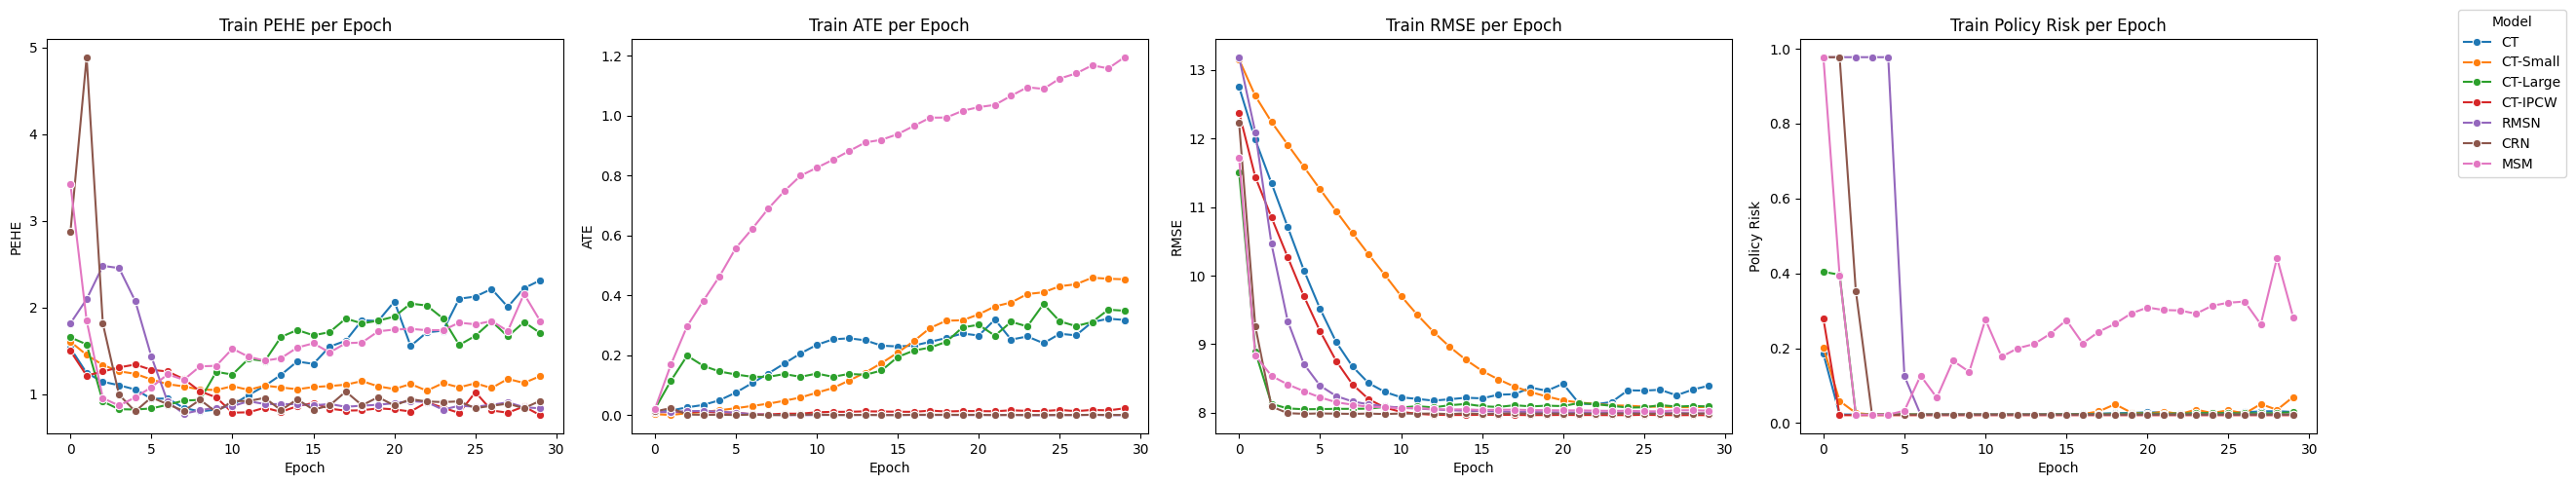

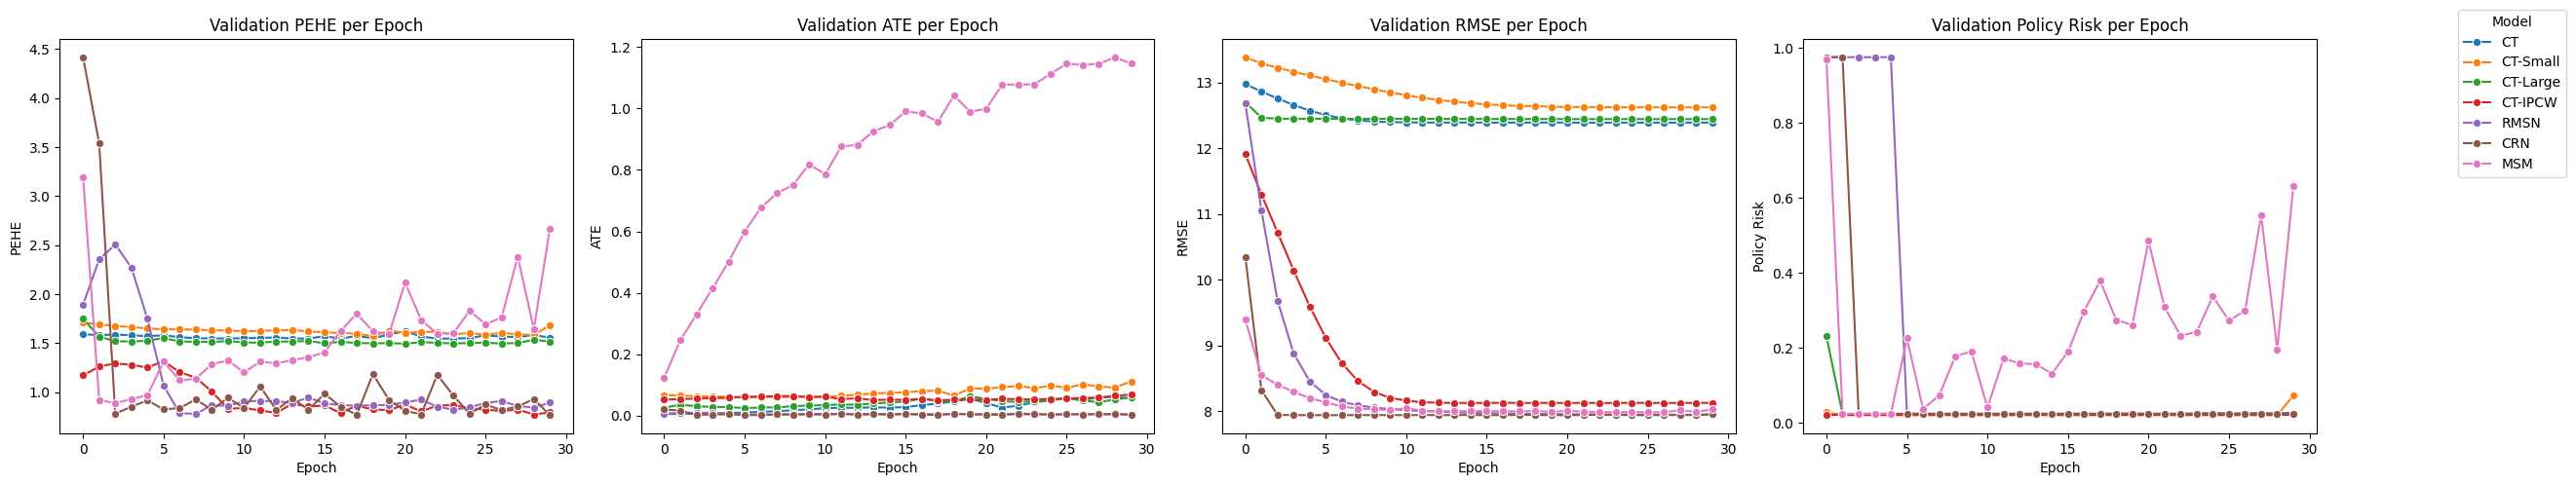

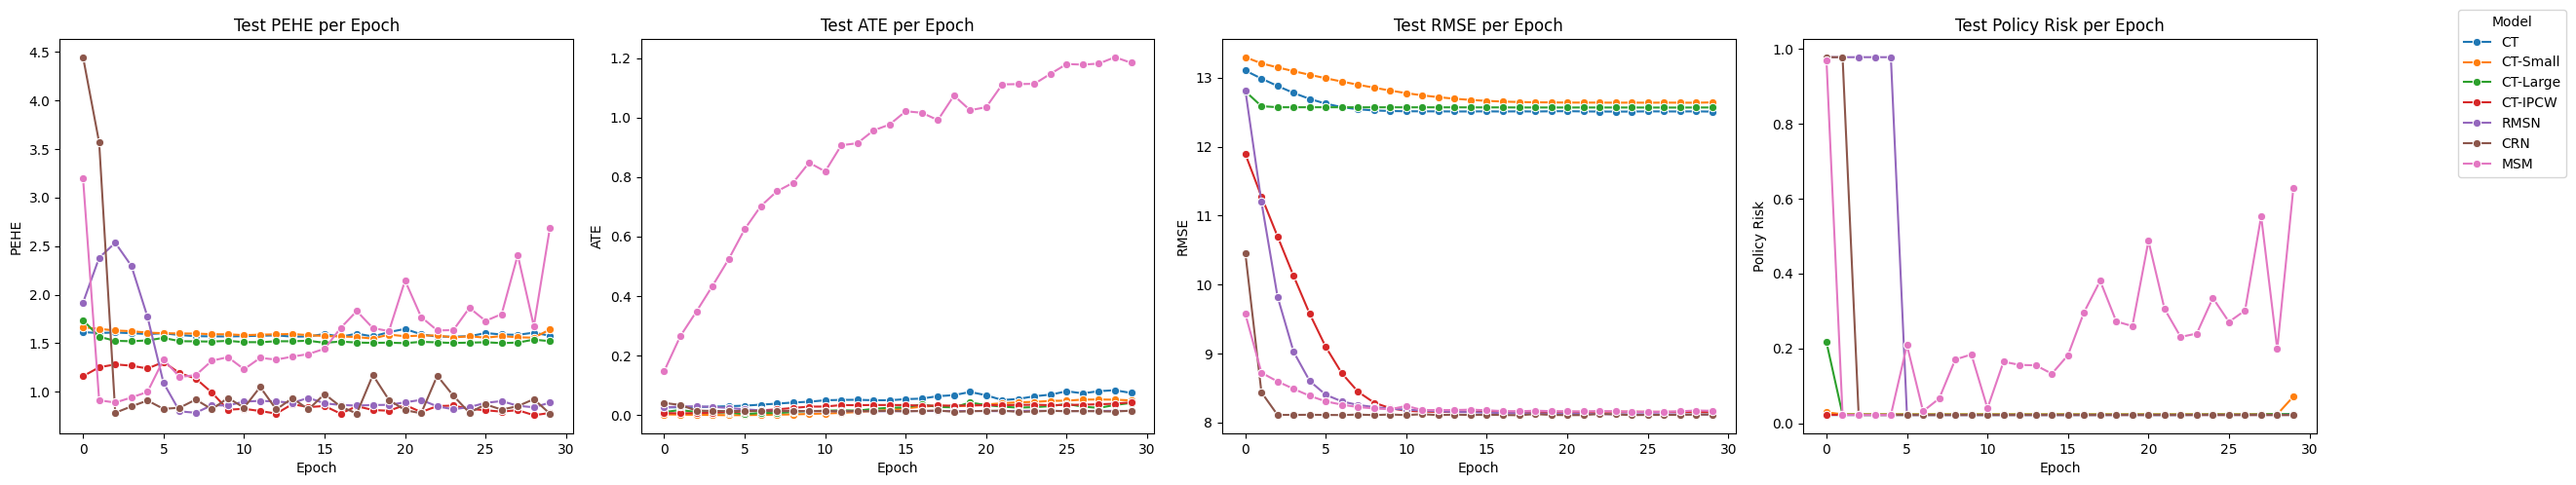

In [6]:
# Plot epoch summaries
plot_epoch_summary(train_epoch_long, split="Train")
plot_epoch_summary(val_epoch_long, split="Validation")
plot_epoch_summary(test_epoch_long, split="Test")

In [7]:

train_step_long = summary_tables["train_step_summary"].copy()
train_step_long["model"] = train_step_long["model"].map(name_map)
train_step_long["split"] = "Train"

val_step_long = summary_tables["val_step_summary"].copy()
val_step_long["model"] = val_step_long["model"].map(name_map)
val_step_long["split"] = "Validation"

test_step_long = summary_tables["test_step_summary"].copy()
test_step_long["model"] = test_step_long["model"].map(name_map)
test_step_long["split"] = "Test"

In [ ]:
def pivot_metric(df, metric_name):
    """
    Pivot test_step_long to wide format:
    - index = model
    - columns = timepoint
    - values = value (for selected metric)
    """
    df_metric = df[df["metric"] == metric_name].copy()

    wide_df = df_metric.pivot_table(
        index="model",
        columns="timepoint",
        values="value"
    )

    # Sort columns (timepoints)
    wide_df = wide_df.reindex(sorted(wide_df.columns), axis=1)

    return wide_df


In [31]:
pehe_wide = pivot_metric(test_step_long, "PEHE")
pehe_wide

timepoint         0         1         2         3         4         5  \
model                                                                   
CRN        0.784657  0.793962  0.755340  0.720472  0.739782  0.715866   
CT         1.229057  1.289171  1.326885  1.393925  1.518009  1.587962   
CT-IPCW    0.880391  0.886568  0.841510  0.790652  0.758707  0.742838   
CT-Large   1.173245  1.254956  1.323989  1.370857  1.457569  1.534562   
CT-Small   1.260037  1.292339  1.390052  1.430485  1.548716  1.615253   
MSM        2.426432  2.528242  2.412093  2.579224  2.668628  2.669124   
RMSN       1.045780  1.077719  1.017928  0.945920  0.889539  0.824947   

timepoint         6         7         8         9  
model                                              
CRN        0.739456  0.785611  0.805682  0.883632  
CT         1.675604  1.776624  1.840138  1.942226  
CT-IPCW    0.736135  0.706483  0.710906  0.743910  
CT-Large   1.604311  1.688696  1.787262  1.857261  
CT-Small   1.714751  1.893099  1.962904  2.079989  
MSM        2.737578  2.869338  2.938706  2.988689  
RMSN       0.782485  0.755098  0.717356  0.741233

In [54]:
ate_wide = pivot_metric(test_step_long, "ATE")
ate_wide

timepoint         0         1         2         3         4         5  \
model                                                                   
CRN        0.008544  0.005901  0.000701  0.004045  0.035906  0.002502   
CT         0.042553  0.074697  0.017385  0.106749  0.067719  0.066093   
CT-IPCW    0.066849  0.022940  0.082290  0.012600  0.017654  0.059358   
CT-Large   0.020551  0.024035  0.047280  0.057678  0.040483  0.068978   
CT-Small   0.090257  0.007738  0.061129  0.122042  0.041319  0.033776   
MSM        1.372425  1.355378  1.159208  1.316436  1.225617  1.144405   
RMSN       0.025924  0.012810  0.021676  0.024293  0.037487  0.000572   

timepoint         6         7         8         9  
model                                              
CRN        0.015218  0.030390  0.023446  0.045712  
CT         0.056455  0.093935  0.128687  0.089258  
CT-IPCW    0.026625  0.033056  0.053582  0.061156  
CT-Large   0.030481  0.038839  0.059140  0.024413  
CT-Small   0.008171  0.112270  0.006871  0.024519  
MSM        1.061161  1.071480  1.095588  1.034902  
RMSN       0.021000  0.032797  0.006934  0.033300

In [55]:
rmse_wide = pivot_metric(test_step_long, "RMSE")
rmse_wide

timepoint         0         1         2         3         4         5  \
model                                                                   
CRN        0.062593  0.051873  0.035941  0.027950  0.016669  0.010198   
CT         0.081883  0.057416  0.039030  0.029610  0.018089  0.010617   
CT-IPCW    0.057696  0.050892  0.032290  0.031251  0.018091  0.010016   
CT-Large   0.068358  0.053521  0.037372  0.028472  0.018070  0.012619   
CT-Small   0.120579  0.107026  0.065043  0.037893  0.020217  0.017317   
MSM        0.573343  0.606150  0.591774  0.624799  0.624406  0.631515   
RMSN       0.062593  0.051873  0.035941  0.027950  0.016669  0.010198   

timepoint         6         7         8         9  
model                                              
CRN        0.008300  0.004298  0.003194  0.001587  
CT         0.008300  0.004298  0.003194  0.001587  
CT-IPCW    0.011469  0.002671  0.004500  0.000000  
CT-Large   0.007885  0.006044  0.002955  0.001925  
CT-Small   0.051123  0.090471  0.111491  0.094078  
MSM        0.631479  0.641519  0.673571  0.677198  
RMSN       0.008300  0.004298  0.003194  0.001587

In [58]:
prisk_wide = pivot_metric(test_step_long, "Policy Risk")
prisk_wide

timepoint          0          1          2          3          4          5  \
model                                                                         
CRN         8.009976   8.092121   8.241568   8.374769   7.974400   8.040328   
CT         12.330223  12.482814  12.447310  12.565980  12.309649  12.218355   
CT-IPCW     8.200438   8.226316   8.248441   7.774950   8.194219   7.969470   
CT-Large   12.617590  12.541518  12.580113  12.537176  12.401197  12.535074   
CT-Small   12.411645  12.420929  12.226879  12.563440  12.503919  12.774033   
MSM         7.988837   8.154789   8.282675   8.470336   8.059234   8.144391   
RMSN        8.059008   8.086050   8.234965   8.362094   7.955776   8.008213   

timepoint          6          7          8          9  
model                                                  
CRN         7.874478   8.301636   8.076894   8.162673  
CT         12.398496  12.857902  12.524336  12.908841  
CT-IPCW     7.766098   8.245488   8.269004   8.588264  
CT-Large   12.478654  12.542449  12.684529  12.749684  
CT-Small   12.783272  12.746566  12.903289  13.055287  
MSM         7.928638   8.295561   8.180470   8.182240  
RMSN        7.871309   8.320393   8.074453   8.185639

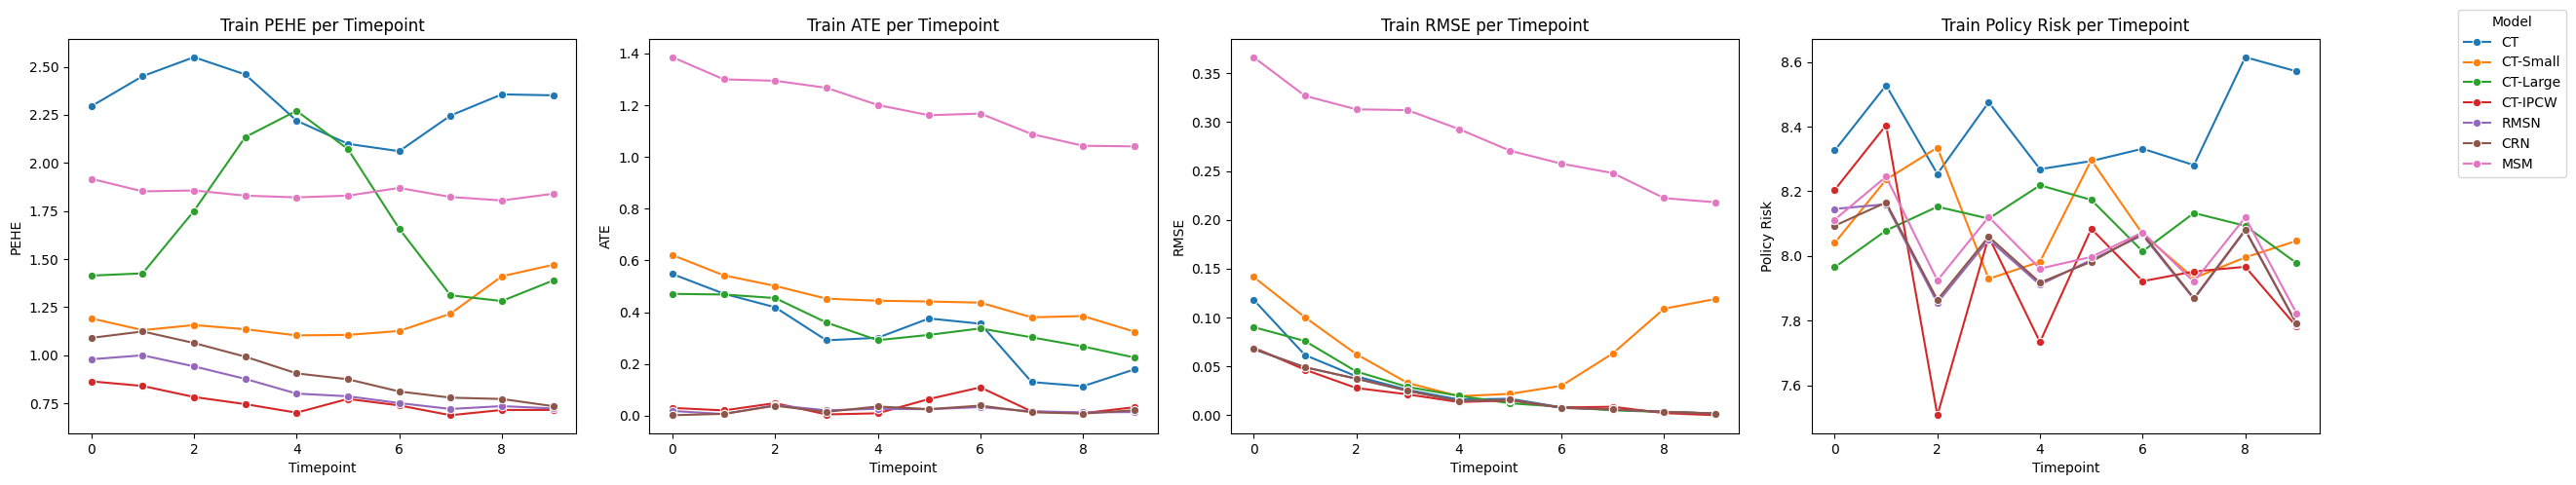

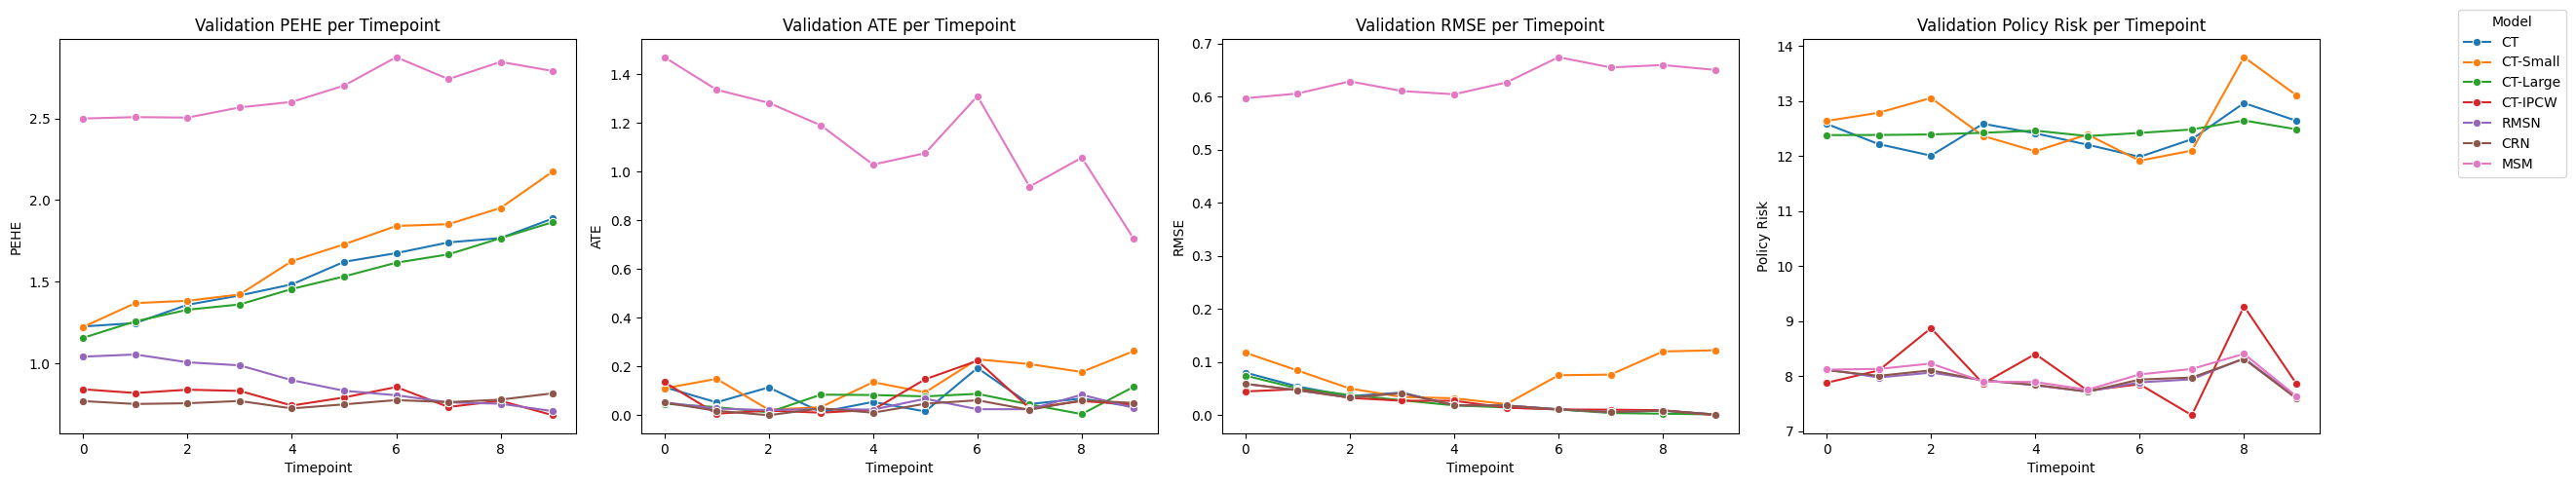

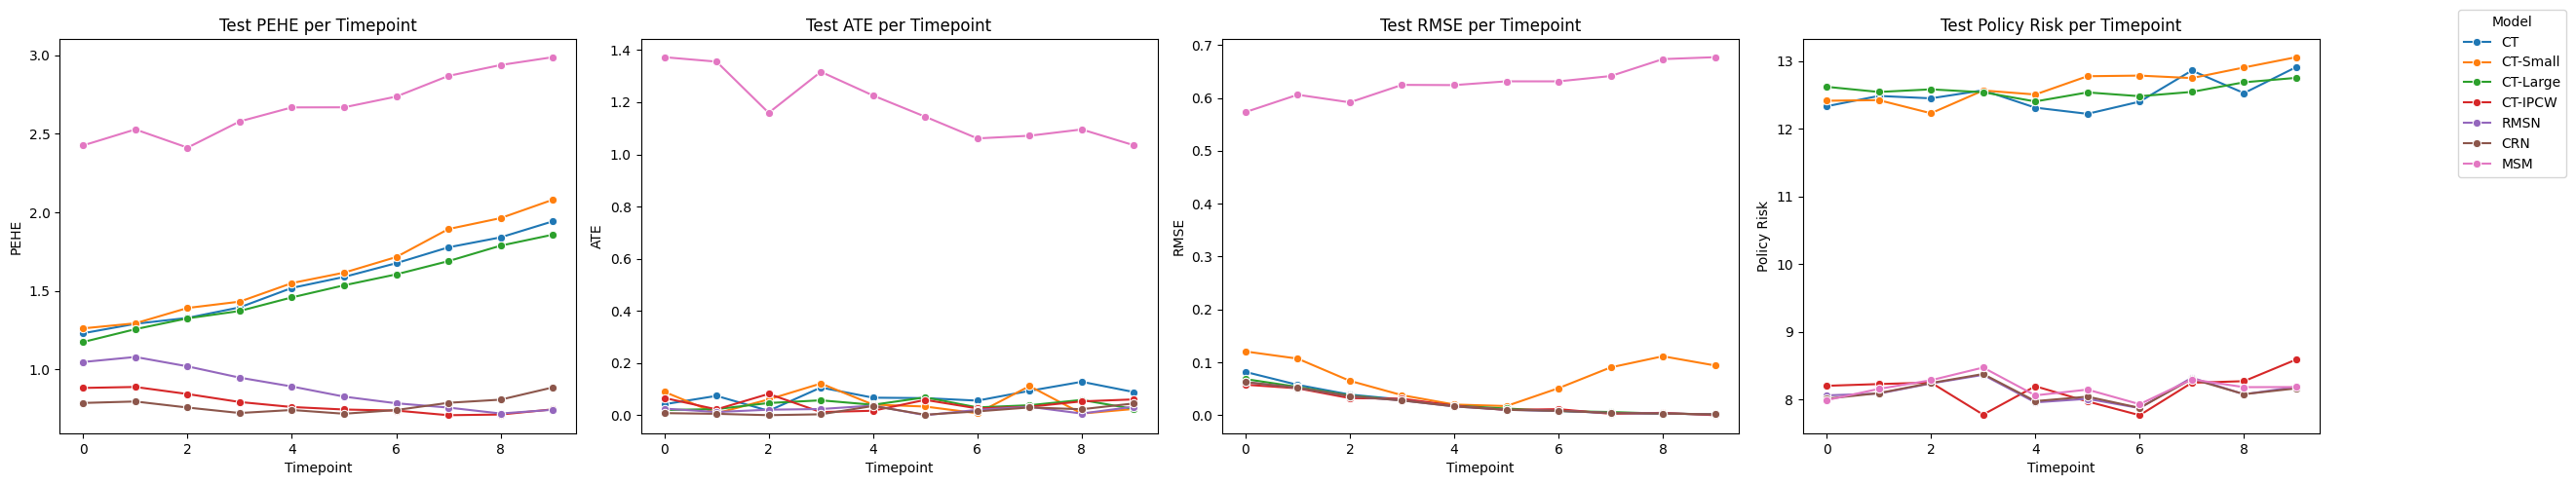

In [8]:
# Plot step summaries
plot_step_summary(train_step_long, split="Train")
plot_step_summary(val_step_long, split="Validation")
plot_step_summary(test_step_long, split="Test")

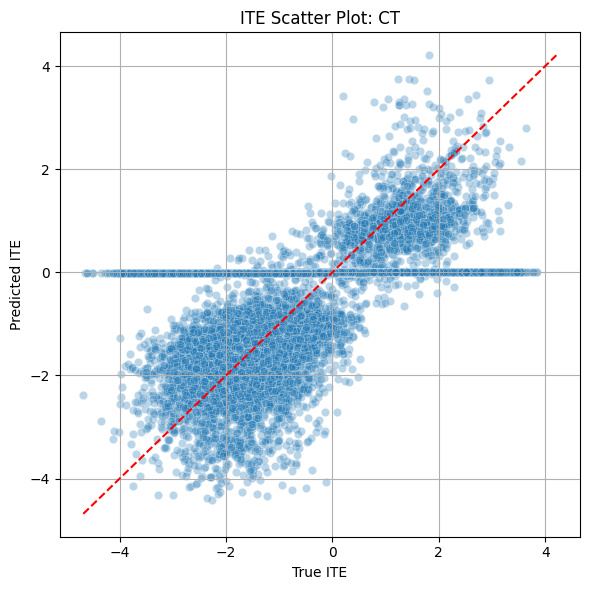

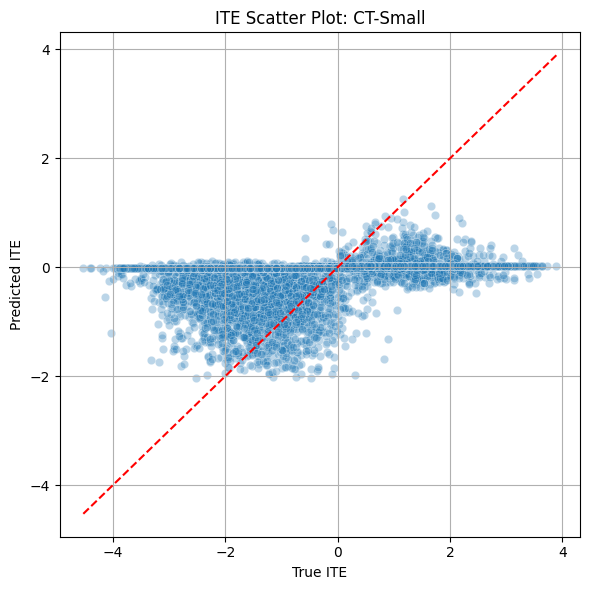

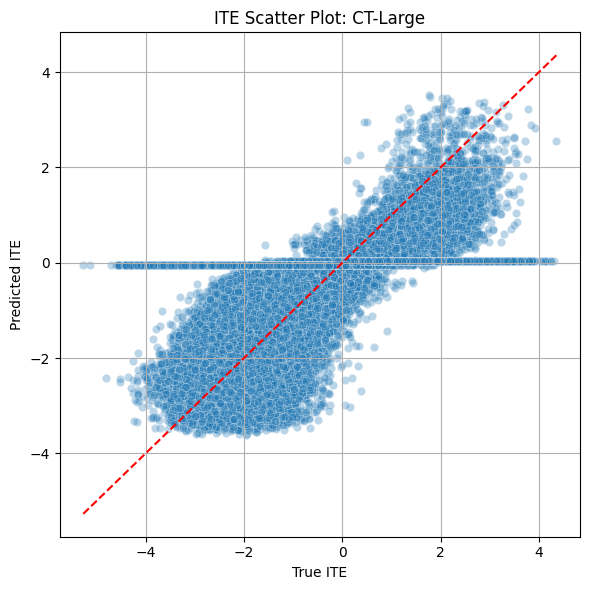

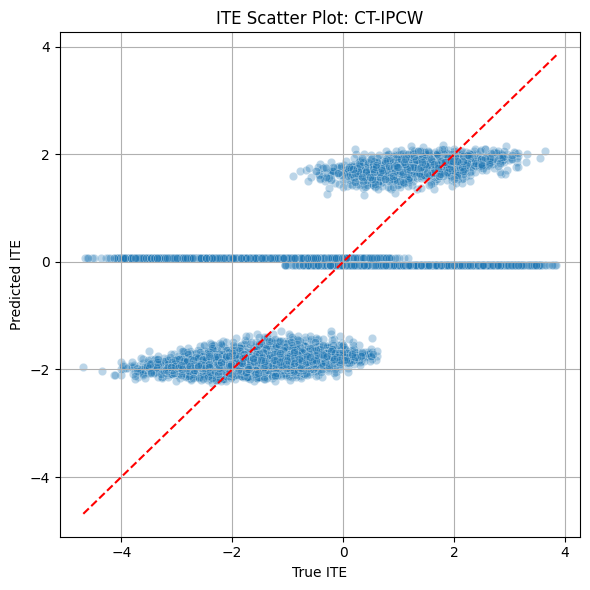

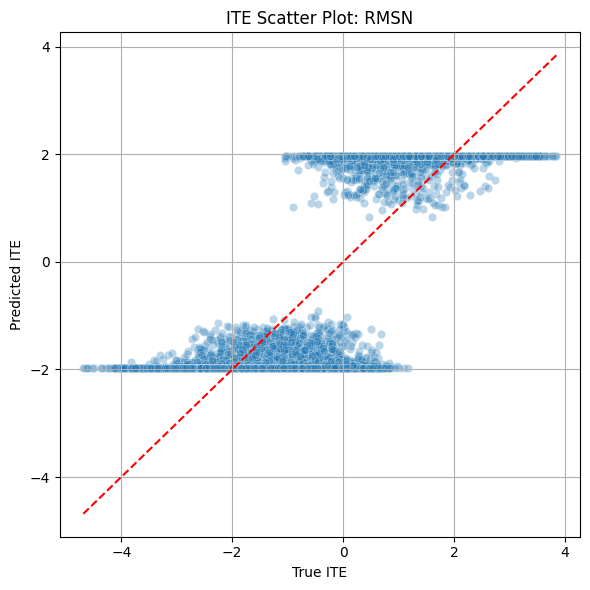

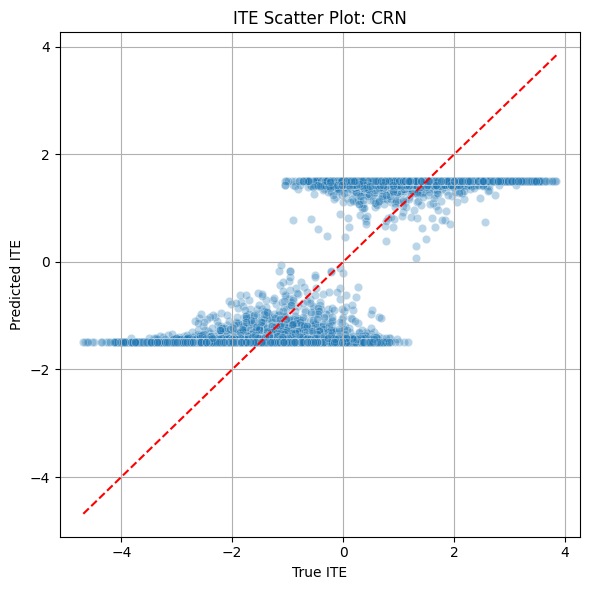

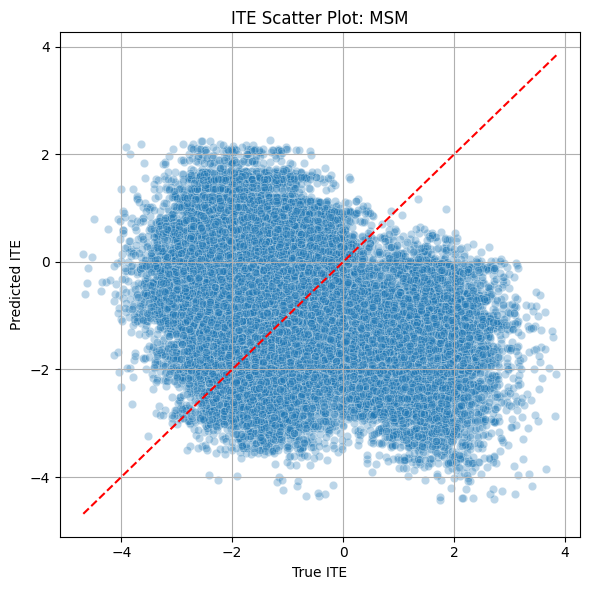

In [9]:
# Plot ITE scatterplots (one per model)
scatter_df = summary_tables["scatter_summary"]
if scatter_df is not None:
    for model_name in scatter_df["model"].unique():
        df_model = scatter_df[scatter_df["model"] == model_name]
        plot_ite_scatter(
            df_model["true_ite"].values,
            df_model["pred_ite"].values,
            model_name=name_map.get(model_name, model_name)
        )

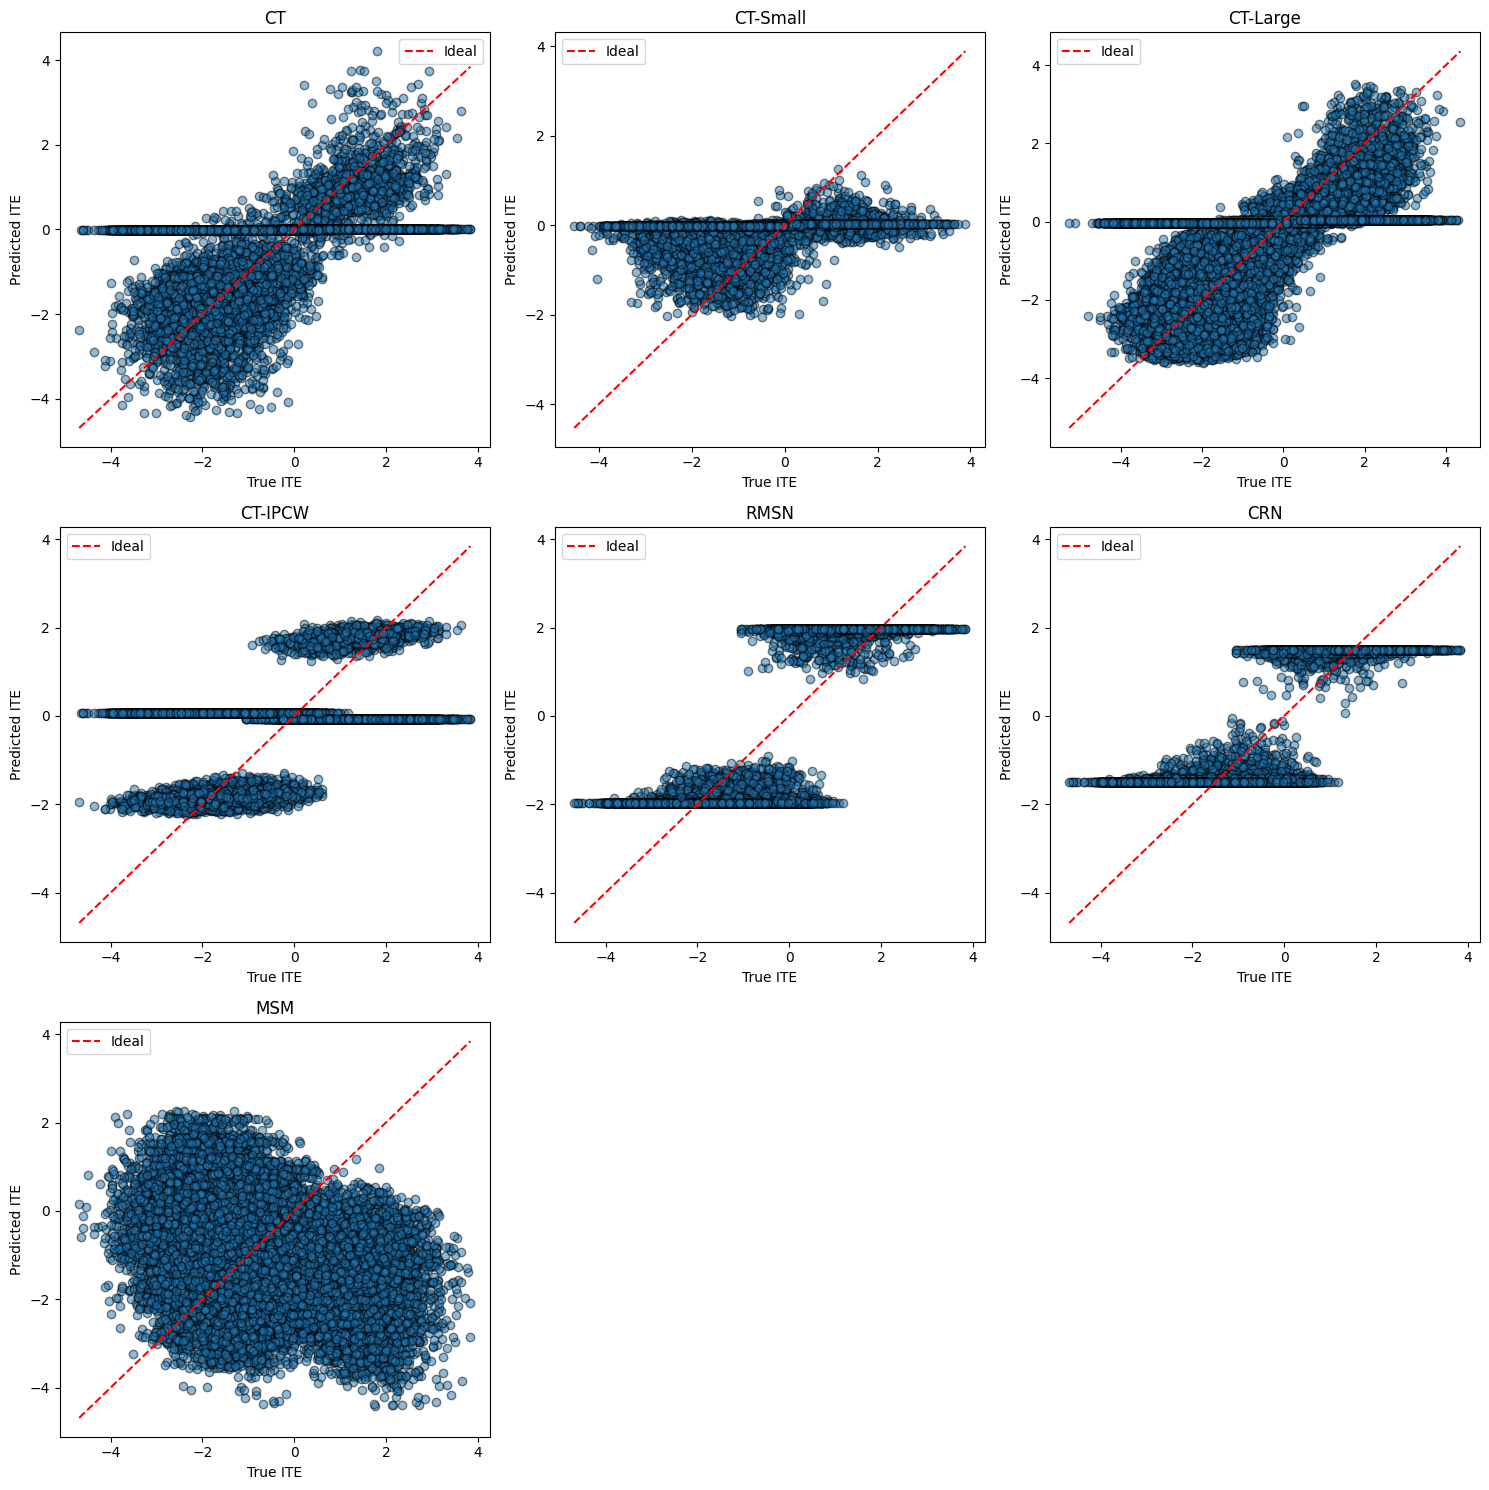

In [59]:
# Plot ITE scatterplots (one figure with subplots)
scatter_df = summary_tables["scatter_summary"]

if scatter_df is not None:
    models = scatter_df["model"].unique()
    n_models = len(models)

    # Set up the subplot grid
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols  # ceil division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()  # Flatten in case of single row

    for i, model_name in enumerate(models):
        df_model = scatter_df[scatter_df["model"] == model_name]

        ax = axes[i]
        ax.scatter(df_model["true_ite"], df_model["pred_ite"], alpha=0.5, edgecolor='k')
        ax.plot([df_model["true_ite"].min(), df_model["true_ite"].max()],
                [df_model["true_ite"].min(), df_model["true_ite"].max()],
                'r--', label="Ideal")
        ax.set_title(name_map.get(model_name, model_name))
        ax.set_xlabel("True ITE")
        ax.set_ylabel("Predicted ITE")
        ax.legend()

    # If there are unused subplots, turn them off
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


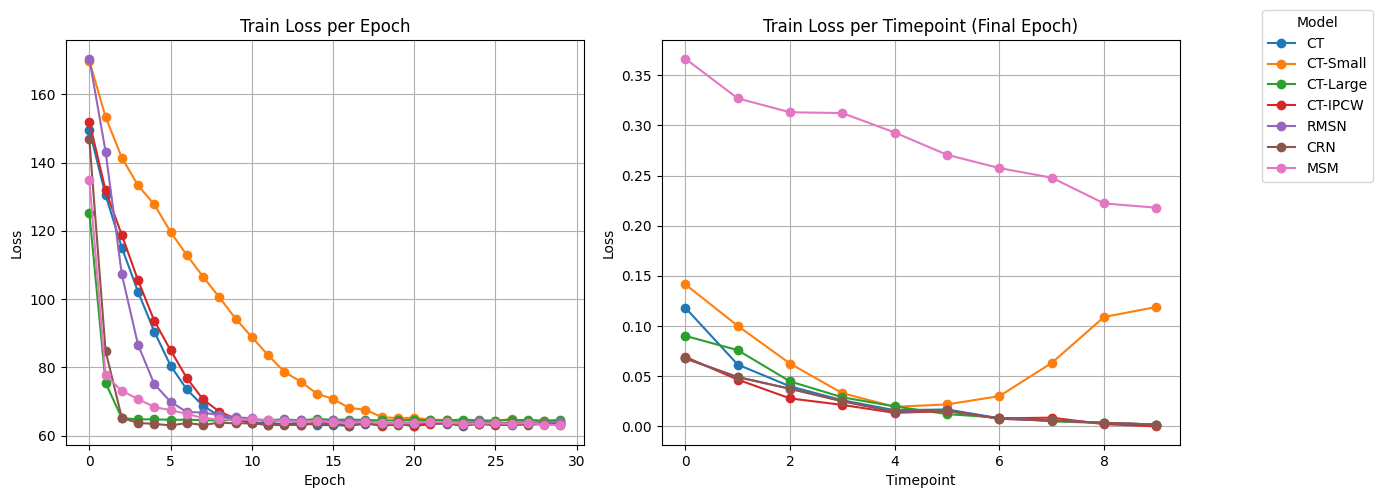

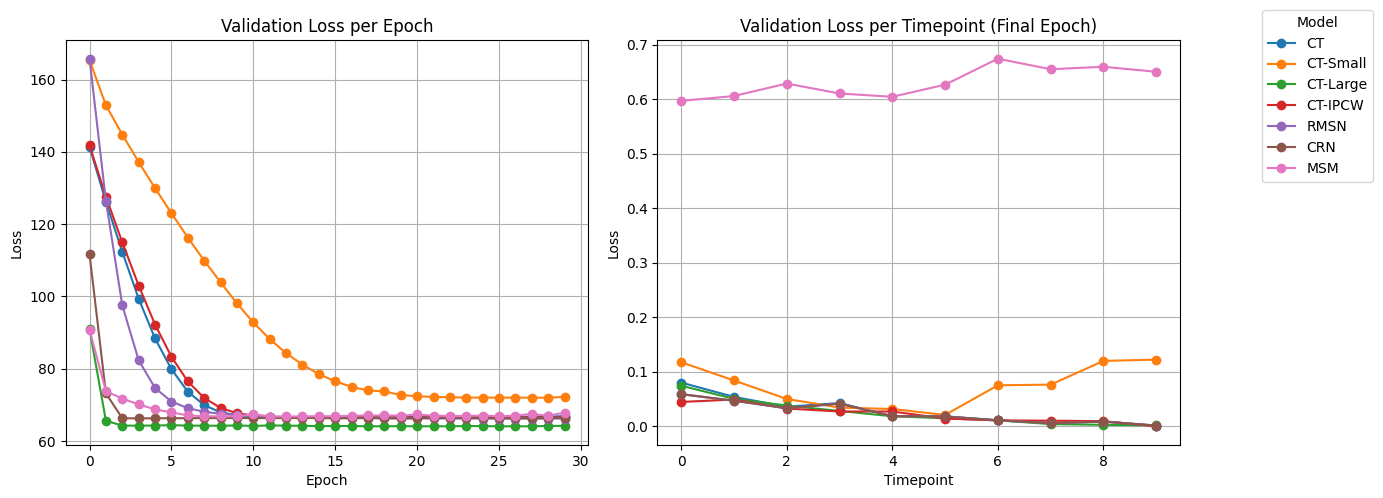

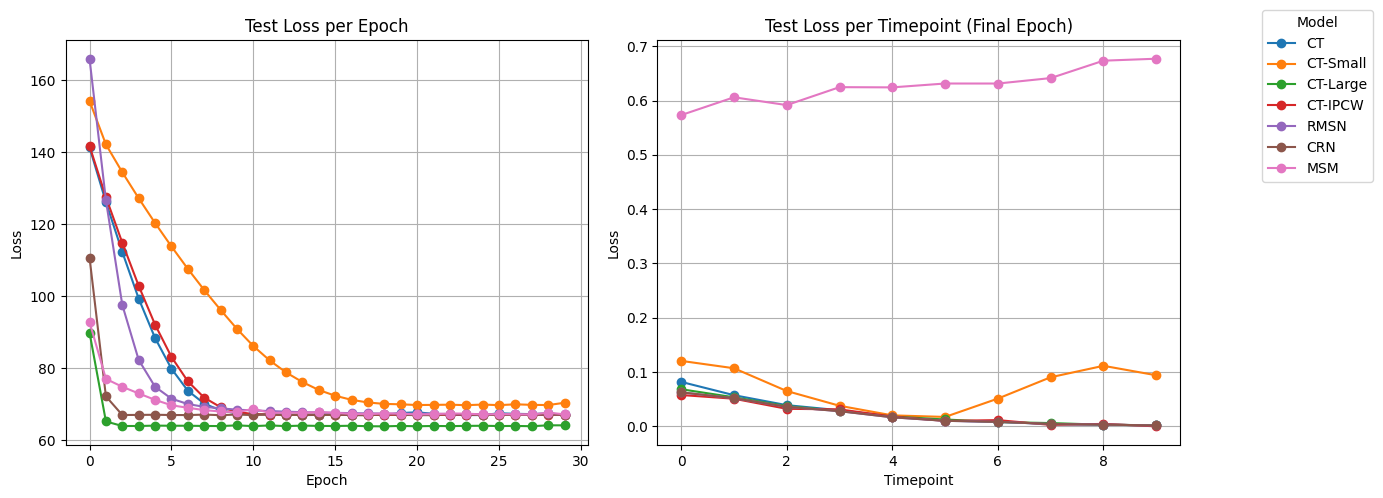

In [10]:
# Build a loss_dict_all_models dict:

# Build a loss_dict_all_models dict with display names from name_map

# For TRAIN
loss_dict_train_all = {
    name_map.get(model_name, model_name): {
        "epoch": results[model_name]["train_loss"],
        "per_timepoint": results[model_name]["train_loss_steps"]
    }
    for model_name in results.keys()
}

# For VAL
loss_dict_val_all = {
    name_map.get(model_name, model_name): {
        "epoch": results[model_name]["val_loss"],
        "per_timepoint": results[model_name]["val_loss_steps"]
    }
    for model_name in results.keys()
}

# For TEST
loss_dict_test_all = {
    name_map.get(model_name, model_name): {
        "epoch": results[model_name]["test_loss"],
        "per_timepoint": results[model_name]["test_loss_steps"]
    }
    for model_name in results.keys()
}

# Plot all models at once:
plot_loss_curves_all_models(loss_dict_train_all, split="Train")
plot_loss_curves_all_models(loss_dict_val_all, split="Validation")
plot_loss_curves_all_models(loss_dict_test_all, split="Test")


In [ ]:
def summarize_loss_tables(loss_dict):
    """
    Given a loss_dict in the format of loss_dict_test_all2, returns:
    - epoch_loss_table: DataFrame [models x epochs]
    - timepoint_loss_table: DataFrame [models x timepoints] (last valid per_timepoint entry)
    """
    import pandas as pd

    # Epoch loss table
    epoch_data = []
    for model_name, model_dict in loss_dict.items():
        epoch_losses = model_dict['epoch']
        for i, loss in enumerate(epoch_losses):
            if pd.notnull(loss):  # Skip NaNs
                epoch_data.append({
                    "model": model_name,
                    "epoch": i + 1,
                    "loss": loss
                })

    df_epoch_loss = pd.DataFrame(epoch_data)
    epoch_loss_table = df_epoch_loss.pivot(index="model", columns="epoch", values="loss")

    # Timepoint loss table
    timepoint_data = []
    for model_name, model_dict in loss_dict.items():
        # Get last valid per_timepoint entry
        per_tp_list = [x for x in model_dict['per_timepoint'] if x is not None and all(pd.notnull(x))]
        if per_tp_list:
            last_per_tp = per_tp_list[-1]
            for i, tp_loss in enumerate(last_per_tp):
                timepoint_data.append({
                    "model": model_name,
                    "timepoint": f"TP{i}",
                    "loss": tp_loss
                })

    df_timepoint_loss = pd.DataFrame(timepoint_data)
    timepoint_loss_table = df_timepoint_loss.pivot(index="model", columns="timepoint", values="loss")

    return epoch_loss_table, timepoint_loss_table

In [48]:
epoch_table, timepoint_table = summarize_loss_tables(loss_dict_test_all)

# To display
display(epoch_table)
display(timepoint_table)

epoch             1           2           3           4           5   \
model                                                                  
CRN       110.780459   72.190770   67.004393   67.031119   67.070126   
CT        141.426580  126.205868  112.335377   99.380938   88.418665   
CT-IPCW   141.807547  127.580275  114.895606  102.919311   92.135320   
CT-Large   89.921594   65.210156   63.947705   63.949333   64.053547   
CT-Small  154.315548  142.224970  134.486700  127.265673  120.388343   
MSM        92.864671   77.043298   74.852146   73.001800   71.213598   
RMSN      166.054922  126.711323   97.612132   82.322058   74.855770   

epoch             6           7           8          9          10         11  \
model                                                                           
CRN        67.005279   66.982911   67.112070  66.960620  67.138292  66.976296   
CT         79.876740   73.767024   70.176689  68.279682  67.457555  67.184078   
CT-IPCW    83.164963   76.376611   71.827026  69.176929  67.884790  67.254900   
CT-Large   64.019529   64.022309   63.955964  63.926917  64.126149  63.911697   
CT-Small  113.865240  107.632700  101.750318  96.229862  90.936720  86.169670   
MSM        69.710838   69.012767   68.369298  67.980299  67.755686  68.738157   
RMSN       71.547132   70.050138   69.274931  68.849206  68.488716  68.274000   

epoch            12         13         14         15         16         17  \
model                                                                        
CRN       67.220938  66.959051  67.113127  66.981029  67.082586  66.989536   
CT        67.137597  67.140968  66.972414  67.043440  67.263377  66.976371   
CT-IPCW   67.117938  67.010309  67.086577  67.061934  67.072106  67.009083   
CT-Large  64.105031  63.919089  64.055986  63.973889  63.944441  64.023838   
CT-Small  82.162002  78.828771  76.153088  73.948302  72.355627  71.215722   
MSM       67.603944  67.654184  67.651297  67.796926  67.598040  67.311424   
RMSN      68.098704  67.936574  67.777278  67.731481  67.606434  67.521032   

epoch            18         19         20         21         22         23  \
model                                                                        
CRN       66.910623  67.266944  67.043476  66.967507  66.965169  67.330543   
CT        67.329655  67.024535  67.552532  67.758626  67.319985  67.064126   
CT-IPCW   67.079404  67.043526  67.038095  67.088983  67.019583  67.093032   
CT-Large  63.881847  63.852794  63.971701  63.875743  63.955150  63.915377   
CT-Small  70.483046  70.091924  69.975511  69.778131  69.818872  69.876657   
MSM       67.257120  67.417507  67.390180  67.146537  67.246252  67.408458   
RMSN      67.456578  67.407319  67.366426  67.361408  67.360401  67.267901   

epoch            24         25         26         27         28         29  \
model                                                                        
CRN       67.208546  66.984195  67.056995  67.038524  67.089836  67.170958   
CT        66.989874  66.983300  67.484675  67.332916  67.247315  67.505813   
CT-IPCW   67.081372  67.078577  67.045703  67.042876  67.038776  67.008564   
CT-Large  63.978959  64.015454  63.940076  63.963077  63.887592  64.140428   
CT-Small  69.736690  69.907365  69.746639  69.977059  69.826246  69.768056   
MSM       67.400596  67.146791  67.264972  67.186161  67.145185  67.672032   
RMSN      67.215899  67.215201  67.243110  67.246685  67.175817  67.147609   

epoch            30  
model                
CRN       67.099498  
CT        66.990258  
CT-IPCW   67.030635  
CT-Large  64.130989  
CT-Small  70.410254  
MSM       67.185638  
RMSN      67.178501

timepoint       TP0       TP1       TP2       TP3       TP4       TP5  \
model                                                                   
CRN        0.062593  0.051873  0.035941  0.027950  0.016669  0.010198   
CT         0.081883  0.057416  0.039030  0.029610  0.018089  0.010617   
CT-IPCW    0.057696  0.050892  0.032290  0.031251  0.018091  0.010016   
CT-Large   0.068358  0.053521  0.037372  0.028472  0.018070  0.012619   
CT-Small   0.120579  0.107026  0.065043  0.037893  0.020217  0.017317   
MSM        0.573343  0.606150  0.591774  0.624799  0.624406  0.631515   
RMSN       0.062593  0.051873  0.035941  0.027950  0.016669  0.010198   

timepoint       TP6       TP7       TP8       TP9  
model                                              
CRN        0.008300  0.004298  0.003194  0.001587  
CT         0.008300  0.004298  0.003194  0.001587  
CT-IPCW    0.011469  0.002671  0.004500  0.000000  
CT-Large   0.007885  0.006044  0.002955  0.001925  
CT-Small   0.051123  0.090471  0.111491  0.094078  
MSM        0.631479  0.641519  0.673571  0.677198  
RMSN       0.008300  0.004298  0.003194  0.001587

In [49]:
epoch_table, timepoint_table = summarize_loss_tables(loss_dict_train_all)

# To display
display(epoch_table)
display(timepoint_table)

epoch             1           2           3           4           5   \
model                                                                  
CRN       146.885800   84.787184   65.186280   63.682872   63.430965   
CT        149.629683  130.543232  115.111163  102.132681   90.467671   
CT-IPCW   152.074058  131.876765  118.788697  105.493640   93.631643   
CT-Large  125.348317   75.446526   65.117480   64.725197   64.771365   
CT-Small  169.868705  153.440695  141.476066  133.328414  127.756349   
MSM       134.927632   77.607875   73.119897   70.694221   68.381327   
RMSN      170.492732  143.236688  107.254561   86.550118   75.087800   

epoch             6           7           8           9          10  \
model                                                                 
CRN        62.961774   63.660162   63.108111   63.767107  63.576711   
CT         80.491511   73.532331   68.707866   65.735702  64.653413   
CT-IPCW    85.017771   76.864814   70.579086   67.026714  64.974713   
CT-Large   64.601437   64.633930   64.530008   64.362184  64.659277   
CT-Small  119.706816  112.916439  106.591822  100.537741  94.296928   
MSM        67.406119   66.371721   65.117251   64.757304  64.612212   
RMSN       69.894846   66.896273   66.735237   65.991141  65.320651   

epoch            11         12         13         14         15         16  \
model                                                                        
CRN       63.583247  63.137517  63.041344  63.175236  63.753696  63.274796   
CT        63.753998  63.766413  63.302244  63.806759  63.084738  63.046335   
CT-IPCW   63.692096  63.111392  63.395520  63.013752  63.602504  63.615282   
CT-Large  64.631234  64.565271  64.711363  64.462062  64.836981  64.640053   
CT-Small  88.882329  83.611997  78.689987  75.827362  72.307072  70.733746   
MSM       64.733267  64.590682  64.181915  64.109388  64.302733  63.860189   
RMSN      65.091216  63.990695  64.614839  64.435177  64.202127  64.450529   

epoch            17         18         19         20         21         22  \
model                                                                        
CRN       62.917732  63.558431  63.036076  63.100726  63.461334  63.739997   
CT        62.901797  63.472706  63.195491  63.449817  62.695356  63.545361   
CT-IPCW   63.738385  63.578946  62.899168  63.985097  62.916815  63.292086   
CT-Large  64.677207  64.596416  64.410076  64.433053  64.588180  64.473491   
CT-Small  68.070310  67.579079  65.383494  65.100777  65.205391  64.693164   
MSM       63.594708  64.103897  63.590998  63.588551  63.655075  64.081283   
RMSN      64.122125  64.260592  63.535679  63.778913  63.814761  63.976528   

epoch            23         24         25         26         27         28  \
model                                                                        
CRN       63.550526  63.421822  63.396729  63.359374  63.561653  63.224534   
CT        63.467466  62.879475  63.511229  63.285627  62.988360  63.311806   
CT-IPCW   63.820874  62.979512  63.441813  62.978691  63.452977  63.729775   
CT-Large  64.440694  64.683580  64.437330  64.403259  64.557811  64.542665   
CT-Small  64.541046  63.973878  64.246377  64.140973  64.982513  63.555341   
MSM       63.865085  63.404168  63.535047  63.596314  63.394651  63.706361   
RMSN      63.600626  63.447918  64.163939  63.602508  63.764058  63.680940   

epoch            29         30  
model                           
CRN       63.393392  63.087229  
CT        63.353560  63.335507  
CT-IPCW   63.371745  63.637991  
CT-Large  64.392702  64.526531  
CT-Small  64.257652  64.277797  
MSM       63.197321  63.026107  
RMSN      63.803254  63.922797

timepoint       TP0       TP1       TP2       TP3       TP4       TP5  \
model                                                                   
CRN        0.067686  0.049099  0.037454  0.025064  0.014425  0.015816   
CT         0.118240  0.061600  0.039865  0.025980  0.016077  0.016828   
CT-IPCW    0.069257  0.046602  0.027858  0.021371  0.013447  0.015154   
CT-Large   0.090193  0.075964  0.044781  0.028949  0.019896  0.012218   
CT-Small   0.141541  0.100220  0.062549  0.033058  0.019471  0.021866   
MSM        0.366550  0.327018  0.313154  0.312350  0.292974  0.270733   
RMSN       0.067686  0.049099  0.037454  0.025064  0.014425  0.015816   

timepoint       TP6       TP7       TP8       TP9  
model                                              
CRN        0.007534  0.005837  0.003500  0.001765  
CT         0.008062  0.005837  0.003500  0.001765  
CT-IPCW    0.007917  0.008673  0.002137  0.000000  
CT-Large   0.008592  0.004967  0.003346  0.001800  
CT-Small   0.030144  0.063243  0.109057  0.119006  
MSM        0.257522  0.247907  0.222231  0.218001  
RMSN       0.007534  0.005837  0.003500  0.001765

In [50]:
epoch_table, timepoint_table = summarize_loss_tables(loss_dict_val_all)

# To display
display(epoch_table)
display(timepoint_table)

epoch             1           2           3           4           5   \
model                                                                  
CRN       111.682324   73.191346   66.306342   66.256463   66.278645   
CT        141.404963  126.167210  112.328210   99.357435   88.366851   
CT-IPCW   141.772937  127.608661  114.956684  102.997094   92.222886   
CT-Large   90.923188   65.611270   64.262785   64.241644   64.288957   
CT-Small  165.416171  152.849341  144.778079  137.163931  129.946040   
MSM        90.746949   73.782769   71.752817   70.110997   68.767432   
RMSN      165.752165  126.419523   97.533171   82.334638   74.671706   

epoch             6           7           8           9          10  \
model                                                                 
CRN        66.331629   66.303351   66.348060   66.330254  66.373494   
CT         79.878511   73.652732   69.920454   67.931897  67.134978   
CT-IPCW    83.312235   76.480607   71.913484   69.165520  67.692077   
CT-Large   64.378927   64.265506   64.241997   64.225829  64.309046   
CT-Small  122.992754  116.282285  109.895323  103.906760  98.058664   
MSM        67.900616   67.108292   66.826848   66.843486  66.790012   
RMSN       70.924933   69.086433   68.101503   67.531330  67.168803   

epoch            11         12         13         14         15         16  \
model                                                                        
CRN       66.321462  66.357578  66.339161  66.360369  66.367941  66.284277   
CT        66.702459  66.591008  66.544832  66.691373  66.583421  66.549232   
CT-IPCW   67.076540  66.626487  66.574517  66.488302  66.502386  66.493281   
CT-Large  64.165045  64.324813  64.245248  64.221633  64.127813  64.151321   
CT-Small  92.786882  88.192485  84.302020  81.109857  78.491945  76.505765   
MSM       67.445421  66.770039  66.790943  66.791375  66.879618  66.845521   
RMSN      66.925536  66.761456  66.626585  66.508589  66.438329  66.393019   

epoch            17         18         19         20         21         22  \
model                                                                        
CRN       66.323864  66.419357  66.307418  66.283647  66.331351  66.433791   
CT        66.678124  66.600594  66.686768  66.781176  66.751142  66.607403   
CT-IPCW   66.564122  66.497291  66.521644  66.526841  66.492645  66.535063   
CT-Large  64.162169  64.061864  64.085478  64.112986  64.067906  64.091554   
CT-Small  74.990165  73.978999  73.728439  72.721517  72.381152  72.197344   
MSM       66.996096  67.068367  67.072355  67.017739  67.340997  67.009550   
RMSN      66.346288  66.315005  66.278580  66.256515  66.247168  66.241933   

epoch            23         24         25         26         27         28  \
model                                                                        
CRN       66.338475  66.355210  66.351613  66.293010  66.310222  66.292527   
CT        66.625720  66.715640  66.757328  66.750021  66.671944  66.769696   
CT-IPCW   66.505764  66.486950  66.535909  66.515732  66.533284  66.508713   
CT-Large  64.071446  64.147790  64.130950  64.073403  64.085538  64.066973   
CT-Small  72.110137  72.006544  72.021340  71.988445  72.015147  71.985969   
MSM       66.939683  66.922493  67.046142  66.862076  67.008913  67.517565   
RMSN      66.238182  66.244650  66.227896  66.220651  66.218351  66.215789   

epoch            29         30  
model                           
CRN       66.293067  66.498085  
CT        66.791358  66.857896  
CT-IPCW   66.551812  66.525009  
CT-Large  64.185467  64.193450  
CT-Small  71.986410  72.221449  
MSM       66.980424  67.883875  
RMSN      66.222125  66.205144

timepoint       TP0       TP1       TP2       TP3       TP4       TP5  \
model                                                                   
CRN        0.059063  0.047003  0.033329  0.041684  0.018743  0.018211   
CT         0.080313  0.054053  0.036035  0.042706  0.018743  0.018211   
CT-IPCW    0.044770  0.049139  0.032668  0.027248  0.027236  0.014231   
CT-Large   0.074569  0.050477  0.038112  0.028212  0.018496  0.014755   
CT-Small   0.117677  0.084186  0.050312  0.034351  0.031826  0.020947   
MSM        0.597209  0.606089  0.629011  0.610747  0.604680  0.626934   
RMSN       0.059063  0.047003  0.033329  0.041684  0.018743  0.018211   

timepoint       TP6       TP7       TP8       TP9  
model                                              
CRN        0.011040  0.005813  0.008763  0.001368  
CT         0.011040  0.005813  0.008763  0.001368  
CT-IPCW    0.010890  0.010398  0.009438  0.000000  
CT-Large   0.010936  0.004118  0.002808  0.001598  
CT-Small   0.075309  0.076555  0.120054  0.122429  
MSM        0.674565  0.655283  0.659772  0.650599  
RMSN       0.011040  0.005813  0.008763  0.001368

# Running on real data

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define list of model configs
model_names = ["transformer", "transformer_ipcw", "rmsn", "crn", "msm"]

# Define best lr per model
lr_overrides = {
    "transformer": 7.68e-5,
    "transformer_ipcw": 7.68e-5,
    "rmsn": 4.6342578001718805e-5,
    "crn": 7.882919066627159e-4,
    "msm": 1e-3
}

results2 = {}

# Loop over models
for model_name in model_names:
    print(f"\n=== Running {model_name.upper()} ===")

    with initialize(version_base=None, config_path="config"):
        cfg = compose(config_name="config.yaml", overrides=[f"model={model_name}",
                                                            f"optimizer.lr={lr_overrides[model_name]}"])
        print(OmegaConf.to_yaml(cfg))

        df_used = df_real_prepared

        # Preprocess covariates
        covariate_cols = [
            'agemons',
            'binary_treatment',
            'sex', 'site', 'region', 'age_group',
            'nutri_counsel_disch', 'poor_feeding', 'acutely_ill'
        ]
        categorical_covs = [col for col in covariate_cols if col not in ["agemons", "binary_treatment"]]
        df_encoded = pd.get_dummies(df_used, columns=categorical_covs, drop_first=True)
        df_encoded["binary_treatment"] = df_used["binary_treatment"]

        encoded_covariates = [col for col in df_encoded.columns if any(base in col for base in covariate_cols)]
        df_encoded[encoded_covariates] = df_encoded[encoded_covariates].astype("float32")

        # Create dataloaders
        train_set, val_set, test_set, train_loader, val_loader, test_loader = create_dataloaders(
            df=df_encoded,
            covariates=encoded_covariates,
            outcome_col="pct_weight_gain_factual",
            treatment_col="binary_treatment",
            batch_size=cfg.batch_size,
        )

        # Infer correct input_dim
        input_dim = len(encoded_covariates)

        # Instantiate model and optimizer
        model = instantiate(cfg.model, input_dim=input_dim).to(device)
        optimizer = instantiate(cfg.optimizer, params=model.parameters())

        # For Transformer, CRN, RMSN: set _loss_type
        if hasattr(model, "_loss_type"):
            model._loss_type = "mse" 

        # Train model
        metrics = training_loop(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            optimizer=optimizer,
            loss_type="mse",  
            use_ipcw=cfg.model.use_ipcw,
            use_cdc=cfg.model.use_cdc,   
            lambda_cdc=0.1,              
            device=device,
            epochs=cfg.epochs,
        )

        # Store results
        results2[model_name] = metrics



=== Running TRANSFORMER ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 5
  n_heads: 8
  dropout: 0.12112631829351567
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 7.68e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 30
device: cpu



Training Epochs:   3%|▎         | 1/30 [00:36<17:52, 37.00s/it]

Epoch 0: Train PEHE=19.3393, ATE=7.2556, RMSE=19.3656


Training Epochs:   7%|▋         | 2/30 [01:12<16:48, 36.02s/it]

Epoch 1: Train PEHE=19.3367, ATE=7.2476, RMSE=19.3049


Training Epochs:  10%|█         | 3/30 [01:48<16:11, 35.98s/it]

Epoch 2: Train PEHE=19.3376, ATE=7.2627, RMSE=19.2357


Training Epochs:  13%|█▎        | 4/30 [02:25<15:48, 36.49s/it]

Epoch 3: Train PEHE=19.3428, ATE=7.2783, RMSE=19.1783


Training Epochs:  17%|█▋        | 5/30 [03:01<15:06, 36.28s/it]

Epoch 4: Train PEHE=19.3360, ATE=7.2764, RMSE=19.1226


Training Epochs:  20%|██        | 6/30 [03:37<14:26, 36.08s/it]

Epoch 5: Train PEHE=19.3456, ATE=7.3033, RMSE=19.0736


Training Epochs:  23%|██▎       | 7/30 [04:13<13:48, 36.02s/it]

Epoch 6: Train PEHE=19.3478, ATE=7.3291, RMSE=19.0310


Training Epochs:  27%|██▋       | 8/30 [04:50<13:21, 36.42s/it]

Epoch 7: Train PEHE=19.3482, ATE=7.3371, RMSE=18.9953


Training Epochs:  30%|███       | 9/30 [05:26<12:41, 36.28s/it]

Epoch 8: Train PEHE=19.3456, ATE=7.3387, RMSE=18.9580


Training Epochs:  33%|███▎      | 10/30 [06:06<12:30, 37.50s/it]

Epoch 9: Train PEHE=19.3493, ATE=7.3529, RMSE=18.9250


Training Epochs:  37%|███▋      | 11/30 [06:42<11:41, 36.90s/it]

Epoch 10: Train PEHE=19.3588, ATE=7.3876, RMSE=18.8967


Training Epochs:  40%|████      | 12/30 [07:18<10:59, 36.65s/it]

Epoch 11: Train PEHE=19.3723, ATE=7.4495, RMSE=18.8689


Training Epochs:  43%|████▎     | 13/30 [07:54<10:19, 36.42s/it]

Epoch 12: Train PEHE=19.3660, ATE=7.4395, RMSE=18.8419


Training Epochs:  47%|████▋     | 14/30 [08:30<09:44, 36.54s/it]

Epoch 13: Train PEHE=19.3523, ATE=7.4157, RMSE=18.8063


Training Epochs:  50%|█████     | 15/30 [09:07<09:06, 36.43s/it]

Epoch 14: Train PEHE=19.3624, ATE=7.4442, RMSE=18.7794


Training Epochs:  53%|█████▎    | 16/30 [09:42<08:23, 36.00s/it]

Epoch 15: Train PEHE=19.3514, ATE=7.4085, RMSE=18.7537


Training Epochs:  57%|█████▋    | 17/30 [10:17<07:46, 35.91s/it]

Epoch 16: Train PEHE=19.3401, ATE=7.3932, RMSE=18.7222


Training Epochs:  60%|██████    | 18/30 [10:52<07:08, 35.69s/it]

Epoch 17: Train PEHE=19.3458, ATE=7.4179, RMSE=18.6990


Training Epochs:  63%|██████▎   | 19/30 [11:28<06:33, 35.75s/it]

Epoch 18: Train PEHE=19.3417, ATE=7.4311, RMSE=18.6749


Training Epochs:  67%|██████▋   | 20/30 [12:04<05:58, 35.83s/it]

Epoch 19: Train PEHE=19.3359, ATE=7.4269, RMSE=18.6605


Training Epochs:  70%|███████   | 21/30 [12:40<05:22, 35.81s/it]

Epoch 20: Train PEHE=19.3585, ATE=7.5238, RMSE=18.6451


Training Epochs:  73%|███████▎  | 22/30 [13:16<04:47, 35.94s/it]

Epoch 21: Train PEHE=19.3873, ATE=7.6214, RMSE=18.6396


Training Epochs:  77%|███████▋  | 23/30 [13:53<04:12, 36.08s/it]

Epoch 22: Train PEHE=19.3502, ATE=7.5065, RMSE=18.5841


Training Epochs:  80%|████████  | 24/30 [14:29<03:36, 36.07s/it]

Epoch 23: Train PEHE=19.3517, ATE=7.5386, RMSE=18.5590


Training Epochs:  83%|████████▎ | 25/30 [15:05<03:00, 36.12s/it]

Epoch 24: Train PEHE=19.3966, ATE=7.6840, RMSE=18.5428


Training Epochs:  87%|████████▋ | 26/30 [15:41<02:24, 36.08s/it]

Epoch 25: Train PEHE=19.3724, ATE=7.6253, RMSE=18.5047


Training Epochs:  90%|█████████ | 27/30 [16:19<01:49, 36.52s/it]

Epoch 26: Train PEHE=19.3475, ATE=7.5324, RMSE=18.4741


Training Epochs:  93%|█████████▎| 28/30 [16:55<01:13, 36.58s/it]

Epoch 27: Train PEHE=19.3604, ATE=7.5852, RMSE=18.4570


Training Epochs:  97%|█████████▋| 29/30 [17:31<00:36, 36.25s/it]

Epoch 28: Train PEHE=19.3415, ATE=7.5410, RMSE=18.4234


Training Epochs: 100%|██████████| 30/30 [18:09<00:00, 36.30s/it]

Epoch 29: Train PEHE=19.3644, ATE=7.6104, RMSE=18.4124

>>> FINAL TEST METRICS (EPOCH 29):
Test PEHE=15.0178, ATE=6.7327, RMSE=14.9347, Policy Risk=0.2487

=== Running TRANSFORMER_IPCW ===


model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 5
  n_heads: 8
  dropout: 0.12112631829351567
  use_ipcw: true
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 7.68e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 30
device: cpu



Training Epochs:   3%|▎         | 1/30 [00:35<17:17, 35.78s/it]

Epoch 0: Train PEHE=48.9336, ATE=15.2686, RMSE=48.8973


Training Epochs:   7%|▋         | 2/30 [01:12<16:52, 36.14s/it]

Epoch 1: Train PEHE=48.8975, ATE=15.2400, RMSE=48.7137


Training Epochs:  10%|█         | 3/30 [01:47<16:10, 35.95s/it]

Epoch 2: Train PEHE=48.8855, ATE=15.2226, RMSE=48.6148


Training Epochs:  13%|█▎        | 4/30 [02:24<15:42, 36.25s/it]

Epoch 3: Train PEHE=48.8496, ATE=15.1774, RMSE=48.5272


Training Epochs:  17%|█▋        | 5/30 [03:01<15:09, 36.38s/it]

Epoch 4: Train PEHE=48.8621, ATE=15.1951, RMSE=48.4833


Training Epochs:  20%|██        | 6/30 [03:37<14:29, 36.24s/it]

Epoch 5: Train PEHE=48.8590, ATE=15.1653, RMSE=48.4400


Training Epochs:  23%|██▎       | 7/30 [04:13<13:51, 36.16s/it]

Epoch 6: Train PEHE=48.8485, ATE=15.1381, RMSE=48.3977


Training Epochs:  27%|██▋       | 8/30 [04:49<13:16, 36.18s/it]

Epoch 7: Train PEHE=48.8460, ATE=15.1431, RMSE=48.3613


Training Epochs:  30%|███       | 9/30 [05:25<12:40, 36.21s/it]

Epoch 8: Train PEHE=48.8461, ATE=15.1291, RMSE=48.3289


Training Epochs:  33%|███▎      | 10/30 [06:01<12:03, 36.19s/it]

Epoch 9: Train PEHE=48.8283, ATE=15.0896, RMSE=48.2900


Training Epochs:  37%|███▋      | 11/30 [06:38<11:31, 36.38s/it]

Epoch 10: Train PEHE=48.8089, ATE=15.1001, RMSE=48.2549


Training Epochs:  40%|████      | 12/30 [07:15<10:56, 36.46s/it]

Epoch 11: Train PEHE=48.8140, ATE=15.1112, RMSE=48.2252


Training Epochs:  43%|████▎     | 13/30 [07:51<10:20, 36.51s/it]

Epoch 12: Train PEHE=48.8056, ATE=15.1122, RMSE=48.1917


Training Epochs:  47%|████▋     | 14/30 [08:27<09:40, 36.28s/it]

Epoch 13: Train PEHE=48.7943, ATE=15.1070, RMSE=48.1633


Training Epochs:  50%|█████     | 15/30 [09:03<09:03, 36.25s/it]

Epoch 14: Train PEHE=48.8100, ATE=15.1663, RMSE=48.1277


Training Epochs:  53%|█████▎    | 16/30 [09:39<08:24, 36.05s/it]

Epoch 15: Train PEHE=48.8234, ATE=15.2143, RMSE=48.1015


Training Epochs:  57%|█████▋    | 17/30 [10:16<07:50, 36.22s/it]

Epoch 16: Train PEHE=48.8207, ATE=15.2334, RMSE=48.0687


Training Epochs:  60%|██████    | 18/30 [10:51<07:12, 36.08s/it]

Epoch 17: Train PEHE=48.8091, ATE=15.2718, RMSE=48.0376


Training Epochs:  63%|██████▎   | 19/30 [11:29<06:41, 36.52s/it]

Epoch 18: Train PEHE=48.8128, ATE=15.3155, RMSE=48.0095


Training Epochs:  67%|██████▋   | 20/30 [12:05<06:03, 36.34s/it]

Epoch 19: Train PEHE=48.7918, ATE=15.2744, RMSE=47.9694


Training Epochs:  70%|███████   | 21/30 [12:41<05:25, 36.22s/it]

Epoch 20: Train PEHE=48.7581, ATE=15.1669, RMSE=47.9592


Training Epochs:  73%|███████▎  | 22/30 [13:17<04:48, 36.10s/it]

Epoch 21: Train PEHE=48.7316, ATE=15.2856, RMSE=47.9054


Training Epochs:  77%|███████▋  | 23/30 [13:53<04:13, 36.26s/it]

Epoch 22: Train PEHE=48.7939, ATE=15.4238, RMSE=47.8801


Training Epochs:  80%|████████  | 24/30 [14:29<03:36, 36.08s/it]

Epoch 23: Train PEHE=48.7509, ATE=15.3907, RMSE=47.8354


Training Epochs:  83%|████████▎ | 25/30 [15:05<03:00, 36.02s/it]

Epoch 24: Train PEHE=48.7423, ATE=15.3849, RMSE=47.7996


Training Epochs:  87%|████████▋ | 26/30 [15:40<02:22, 35.72s/it]

Epoch 25: Train PEHE=48.7506, ATE=15.5173, RMSE=47.7647


Training Epochs:  90%|█████████ | 27/30 [16:16<01:47, 35.79s/it]

Epoch 26: Train PEHE=48.6746, ATE=15.4446, RMSE=47.7228


Training Epochs:  93%|█████████▎| 28/30 [16:52<01:11, 35.92s/it]

Epoch 27: Train PEHE=48.6638, ATE=15.4856, RMSE=47.6963


Training Epochs:  97%|█████████▋| 29/30 [17:29<00:36, 36.16s/it]

Epoch 28: Train PEHE=48.7102, ATE=15.5779, RMSE=47.6576


Training Epochs: 100%|██████████| 30/30 [18:08<00:00, 36.30s/it]

Epoch 29: Train PEHE=48.6865, ATE=15.5240, RMSE=47.6313

>>> FINAL TEST METRICS (EPOCH 29):
Test PEHE=20.7985, ATE=7.1182, RMSE=19.7741, Policy Risk=0.4088

=== Running RMSN ===


model:
  _target_: src.models.rmsn.RMSN
  input_dim: ???
  hidden_dim: 256
  num_layers: 3
  dropout: 0.15
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 4.6342578001718805e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 30
device: cpu



Training Epochs:   3%|▎         | 1/30 [00:34<16:37, 34.41s/it]

Epoch 0: Train PEHE=19.4003, ATE=7.5214, RMSE=19.3651


Training Epochs:   7%|▋         | 2/30 [01:08<16:05, 34.48s/it]

Epoch 1: Train PEHE=19.3997, ATE=7.5198, RMSE=19.3544


Training Epochs:  10%|█         | 3/30 [01:44<15:44, 34.99s/it]

Epoch 2: Train PEHE=19.3989, ATE=7.5178, RMSE=19.3444


Training Epochs:  13%|█▎        | 4/30 [02:19<15:08, 34.94s/it]

Epoch 3: Train PEHE=19.3975, ATE=7.5141, RMSE=19.3342


Training Epochs:  17%|█▋        | 5/30 [02:54<14:37, 35.09s/it]

Epoch 4: Train PEHE=19.3963, ATE=7.5104, RMSE=19.3229


Training Epochs:  20%|██        | 6/30 [03:29<13:59, 34.97s/it]

Epoch 5: Train PEHE=19.3949, ATE=7.5059, RMSE=19.3100


Training Epochs:  23%|██▎       | 7/30 [04:04<13:27, 35.12s/it]

Epoch 6: Train PEHE=19.3946, ATE=7.5051, RMSE=19.2943


Training Epochs:  27%|██▋       | 8/30 [04:39<12:51, 35.05s/it]

Epoch 7: Train PEHE=19.3955, ATE=7.5082, RMSE=19.2764


Training Epochs:  30%|███       | 9/30 [05:15<12:20, 35.28s/it]

Epoch 8: Train PEHE=19.3969, ATE=7.5130, RMSE=19.2552


Training Epochs:  33%|███▎      | 10/30 [05:51<11:48, 35.43s/it]

Epoch 9: Train PEHE=19.3979, ATE=7.5167, RMSE=19.2267


Training Epochs:  37%|███▋      | 11/30 [06:26<11:13, 35.44s/it]

Epoch 10: Train PEHE=19.3999, ATE=7.5243, RMSE=19.1911


Training Epochs:  40%|████      | 12/30 [07:01<10:34, 35.26s/it]

Epoch 11: Train PEHE=19.4038, ATE=7.5361, RMSE=19.1487


Training Epochs:  43%|████▎     | 13/30 [07:36<09:58, 35.20s/it]

Epoch 12: Train PEHE=19.4054, ATE=7.5414, RMSE=19.0896


Training Epochs:  47%|████▋     | 14/30 [08:12<09:26, 35.39s/it]

Epoch 13: Train PEHE=19.4098, ATE=7.5565, RMSE=19.0208


Training Epochs:  50%|█████     | 15/30 [08:48<08:54, 35.64s/it]

Epoch 14: Train PEHE=19.4187, ATE=7.5831, RMSE=18.9447


Training Epochs:  53%|█████▎    | 16/30 [09:23<08:17, 35.51s/it]

Epoch 15: Train PEHE=19.4287, ATE=7.6149, RMSE=18.8604


Training Epochs:  57%|█████▋    | 17/30 [10:00<07:45, 35.84s/it]

Epoch 16: Train PEHE=19.4415, ATE=7.6527, RMSE=18.7608


Training Epochs:  60%|██████    | 18/30 [10:35<07:06, 35.51s/it]

Epoch 17: Train PEHE=19.4481, ATE=7.6730, RMSE=18.6444


Training Epochs:  63%|██████▎   | 19/30 [11:10<06:29, 35.37s/it]

Epoch 18: Train PEHE=19.4545, ATE=7.6953, RMSE=18.5277


Training Epochs:  67%|██████▋   | 20/30 [11:45<05:53, 35.31s/it]

Epoch 19: Train PEHE=19.4713, ATE=7.7417, RMSE=18.4306


Training Epochs:  70%|███████   | 21/30 [12:21<05:20, 35.56s/it]

Epoch 20: Train PEHE=19.4880, ATE=7.7933, RMSE=18.3298


Training Epochs:  73%|███████▎  | 22/30 [12:56<04:43, 35.42s/it]

Epoch 21: Train PEHE=19.5007, ATE=7.8353, RMSE=18.2419


Training Epochs:  77%|███████▋  | 23/30 [13:32<04:08, 35.51s/it]

Epoch 22: Train PEHE=19.5183, ATE=7.8859, RMSE=18.1510


Training Epochs:  80%|████████  | 24/30 [14:09<03:34, 35.82s/it]

Epoch 23: Train PEHE=19.5430, ATE=7.9583, RMSE=18.0718


Training Epochs:  83%|████████▎ | 25/30 [14:44<02:58, 35.64s/it]

Epoch 24: Train PEHE=19.5737, ATE=8.0411, RMSE=17.9927


Training Epochs:  87%|████████▋ | 26/30 [15:20<02:23, 35.80s/it]

Epoch 25: Train PEHE=19.5983, ATE=8.1075, RMSE=17.9200


Training Epochs:  90%|█████████ | 27/30 [15:55<01:47, 35.67s/it]

Epoch 26: Train PEHE=19.6193, ATE=8.1683, RMSE=17.8563


Training Epochs:  93%|█████████▎| 28/30 [16:31<01:11, 35.79s/it]

Epoch 27: Train PEHE=19.6272, ATE=8.1939, RMSE=17.7893


Training Epochs:  97%|█████████▋| 29/30 [17:07<00:35, 35.62s/it]

Epoch 28: Train PEHE=19.6350, ATE=8.2170, RMSE=17.7386


Training Epochs: 100%|██████████| 30/30 [17:42<00:00, 35.42s/it]

Epoch 29: Train PEHE=19.6483, ATE=8.2535, RMSE=17.6972

>>> FINAL TEST METRICS (EPOCH 29):
Test PEHE=15.3241, ATE=7.5139, RMSE=13.1125, Policy Risk=0.7619

=== Running CRN ===


model:
  _target_: src.models.crn.CRN
  input_dim: ???
  hidden_dim: 64
  num_layers: 3
  dropout: 0.249
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.0007882919066627159
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 30
device: cpu



Training Epochs:   3%|▎         | 1/30 [00:36<17:27, 36.12s/it]

Epoch 0: Train PEHE=19.3731, ATE=7.4093, RMSE=19.3722


Training Epochs:   7%|▋         | 2/30 [01:11<16:40, 35.73s/it]

Epoch 1: Train PEHE=19.3767, ATE=7.4216, RMSE=19.3225


Training Epochs:  10%|█         | 3/30 [01:45<15:47, 35.08s/it]

Epoch 2: Train PEHE=19.3780, ATE=7.4271, RMSE=19.2532


Training Epochs:  13%|█▎        | 4/30 [02:20<15:02, 34.72s/it]

Epoch 3: Train PEHE=19.3814, ATE=7.4383, RMSE=19.1545


Training Epochs:  17%|█▋        | 5/30 [02:55<14:32, 34.90s/it]

Epoch 4: Train PEHE=19.3986, ATE=7.4916, RMSE=19.0164


Training Epochs:  20%|██        | 6/30 [03:29<13:55, 34.81s/it]

Epoch 5: Train PEHE=19.4141, ATE=7.5413, RMSE=18.8315


Training Epochs:  23%|██▎       | 7/30 [04:04<13:20, 34.79s/it]

Epoch 6: Train PEHE=19.4275, ATE=7.5832, RMSE=18.6525


Training Epochs:  27%|██▋       | 8/30 [04:39<12:45, 34.78s/it]

Epoch 7: Train PEHE=19.4370, ATE=7.6219, RMSE=18.4448


Training Epochs:  30%|███       | 9/30 [05:14<12:13, 34.93s/it]

Epoch 8: Train PEHE=19.4661, ATE=7.7153, RMSE=18.2714


Training Epochs:  33%|███▎      | 10/30 [05:48<11:33, 34.69s/it]

Epoch 9: Train PEHE=19.4693, ATE=7.7359, RMSE=18.1018


Training Epochs:  37%|███▋      | 11/30 [06:23<10:57, 34.60s/it]

Epoch 10: Train PEHE=19.4757, ATE=7.7632, RMSE=17.9694


Training Epochs:  40%|████      | 12/30 [06:58<10:26, 34.79s/it]

Epoch 11: Train PEHE=19.4681, ATE=7.7404, RMSE=17.8577


Training Epochs:  43%|████▎     | 13/30 [07:34<09:59, 35.25s/it]

Epoch 12: Train PEHE=19.4477, ATE=7.6698, RMSE=17.7842


Training Epochs:  47%|████▋     | 14/30 [08:09<09:22, 35.18s/it]

Epoch 13: Train PEHE=19.4522, ATE=7.6893, RMSE=17.7159


Training Epochs:  50%|█████     | 15/30 [08:44<08:44, 34.98s/it]

Epoch 14: Train PEHE=19.4889, ATE=7.8033, RMSE=17.6667


Training Epochs:  53%|█████▎    | 16/30 [09:19<08:11, 35.10s/it]

Epoch 15: Train PEHE=19.4898, ATE=7.8008, RMSE=17.6374


Training Epochs:  57%|█████▋    | 17/30 [09:54<07:34, 34.98s/it]

Epoch 16: Train PEHE=19.4847, ATE=7.7797, RMSE=17.6093


Training Epochs:  60%|██████    | 18/30 [10:30<07:04, 35.35s/it]

Epoch 17: Train PEHE=19.4920, ATE=7.7974, RMSE=17.5846


Training Epochs:  63%|██████▎   | 19/30 [11:06<06:29, 35.39s/it]

Epoch 18: Train PEHE=19.5149, ATE=7.8484, RMSE=17.5576


Training Epochs:  67%|██████▋   | 20/30 [11:41<05:54, 35.45s/it]

Epoch 19: Train PEHE=19.5018, ATE=7.7984, RMSE=17.5652


Training Epochs:  70%|███████   | 21/30 [12:16<05:16, 35.18s/it]

Epoch 20: Train PEHE=19.4552, ATE=7.6670, RMSE=17.6095


Training Epochs:  73%|███████▎  | 22/30 [12:51<04:40, 35.12s/it]

Epoch 21: Train PEHE=19.3962, ATE=7.4869, RMSE=17.6736


Training Epochs:  77%|███████▋  | 23/30 [13:25<04:05, 35.02s/it]

Epoch 22: Train PEHE=19.3431, ATE=7.3009, RMSE=17.7531


Training Epochs:  80%|████████  | 24/30 [14:01<03:30, 35.08s/it]

Epoch 23: Train PEHE=19.2838, ATE=7.0954, RMSE=17.8315


Training Epochs:  83%|████████▎ | 25/30 [14:36<02:55, 35.02s/it]

Epoch 24: Train PEHE=19.2551, ATE=7.0425, RMSE=17.8025


Training Epochs:  87%|████████▋ | 26/30 [15:10<02:19, 34.82s/it]

Epoch 25: Train PEHE=19.2236, ATE=7.0118, RMSE=17.8794


Training Epochs:  90%|█████████ | 27/30 [15:44<01:44, 34.73s/it]

Epoch 26: Train PEHE=19.2034, ATE=7.0223, RMSE=17.8621


Training Epochs:  93%|█████████▎| 28/30 [16:19<01:09, 34.64s/it]

Epoch 27: Train PEHE=19.1592, ATE=6.8218, RMSE=17.9551


Training Epochs:  97%|█████████▋| 29/30 [16:54<00:34, 34.66s/it]

Epoch 28: Train PEHE=nan, ATE=nan, RMSE=nan


Training Epochs: 100%|██████████| 30/30 [17:29<00:00, 35.00s/it]


Epoch 29: Train PEHE=nan, ATE=nan, RMSE=nan

>>> FINAL TEST METRICS (EPOCH 29):
Test PEHE=nan, ATE=nan, RMSE=nan, Policy Risk=0.1107

=== Running MSM ===
model:
  _target_: src.models.msm.MSM
  input_dim: ???
  hidden_dim: 128
  dropout: 0.1
  use_ipcw: false
  use_cdc: false
optimizer:
  _target_: torch.optim.Adam
  lr: 0.001
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 30
device: cpu



Training Epochs:   3%|▎         | 1/30 [00:34<16:40, 34.49s/it]

Epoch 0: Train PEHE=19.2318, ATE=6.0670, RMSE=19.1030


Training Epochs:   7%|▋         | 2/30 [01:09<16:13, 34.78s/it]

Epoch 1: Train PEHE=19.2413, ATE=6.3453, RMSE=18.9063


Training Epochs:  10%|█         | 3/30 [01:44<15:35, 34.66s/it]

Epoch 2: Train PEHE=19.2524, ATE=6.5446, RMSE=18.7403


Training Epochs:  13%|█▎        | 4/30 [02:17<14:53, 34.38s/it]

Epoch 3: Train PEHE=19.2568, ATE=6.6370, RMSE=18.6072


Training Epochs:  17%|█▋        | 5/30 [02:52<14:24, 34.56s/it]

Epoch 4: Train PEHE=19.2761, ATE=6.8408, RMSE=18.5041


Training Epochs:  20%|██        | 6/30 [03:27<13:54, 34.77s/it]

Epoch 5: Train PEHE=19.3079, ATE=7.0777, RMSE=18.4225


Training Epochs:  23%|██▎       | 7/30 [04:02<13:20, 34.80s/it]

Epoch 6: Train PEHE=19.3446, ATE=7.3121, RMSE=18.3546


Training Epochs:  27%|██▋       | 8/30 [04:37<12:43, 34.72s/it]

Epoch 7: Train PEHE=19.3901, ATE=7.5399, RMSE=18.3097


Training Epochs:  30%|███       | 9/30 [05:12<12:11, 34.84s/it]

Epoch 8: Train PEHE=19.4523, ATE=7.8098, RMSE=18.2742


Training Epochs:  33%|███▎      | 10/30 [05:48<11:44, 35.21s/it]

Epoch 9: Train PEHE=19.5205, ATE=8.0583, RMSE=18.2492


Training Epochs:  37%|███▋      | 11/30 [06:24<11:14, 35.50s/it]

Epoch 10: Train PEHE=19.6112, ATE=8.3379, RMSE=18.2369


Training Epochs:  40%|████      | 12/30 [07:00<10:41, 35.64s/it]

Epoch 11: Train PEHE=19.6790, ATE=8.5361, RMSE=18.2307


Training Epochs:  43%|████▎     | 13/30 [07:35<10:00, 35.30s/it]

Epoch 12: Train PEHE=19.7447, ATE=8.6967, RMSE=18.2368


Training Epochs:  47%|████▋     | 14/30 [08:10<09:23, 35.20s/it]

Epoch 13: Train PEHE=19.8252, ATE=8.9114, RMSE=18.2427


Training Epochs:  50%|█████     | 15/30 [08:46<08:53, 35.54s/it]

Epoch 14: Train PEHE=19.9068, ATE=9.1023, RMSE=18.2517


Training Epochs:  53%|█████▎    | 16/30 [09:21<08:17, 35.51s/it]

Epoch 15: Train PEHE=20.0689, ATE=9.4451, RMSE=18.2495


Training Epochs:  57%|█████▋    | 17/30 [10:01<07:57, 36.73s/it]

Epoch 16: Train PEHE=20.2604, ATE=9.8110, RMSE=18.2227


Training Epochs:  60%|██████    | 18/30 [10:35<07:10, 35.89s/it]

Epoch 17: Train PEHE=20.4193, ATE=10.0922, RMSE=18.1834


Training Epochs:  63%|██████▎   | 19/30 [11:11<06:34, 35.86s/it]

Epoch 18: Train PEHE=20.5429, ATE=10.3005, RMSE=18.1551


Training Epochs:  67%|██████▋   | 20/30 [11:46<05:56, 35.62s/it]

Epoch 19: Train PEHE=20.5646, ATE=10.3378, RMSE=18.1377


Training Epochs:  70%|███████   | 21/30 [12:21<05:19, 35.50s/it]

Epoch 20: Train PEHE=20.4864, ATE=10.2046, RMSE=18.1401


Training Epochs:  73%|███████▎  | 22/30 [12:55<04:41, 35.13s/it]

Epoch 21: Train PEHE=20.3622, ATE=9.9898, RMSE=18.1372


Training Epochs:  77%|███████▋  | 23/30 [13:31<04:06, 35.17s/it]

Epoch 22: Train PEHE=20.1874, ATE=9.6720, RMSE=18.1422


Training Epochs:  80%|████████  | 24/30 [14:06<03:31, 35.25s/it]

Epoch 23: Train PEHE=20.1296, ATE=9.5675, RMSE=18.1526


Training Epochs:  83%|████████▎ | 25/30 [14:41<02:55, 35.07s/it]

Epoch 24: Train PEHE=20.1418, ATE=9.5939, RMSE=18.1521


Training Epochs:  87%|████████▋ | 26/30 [15:15<02:19, 34.91s/it]

Epoch 25: Train PEHE=20.1112, ATE=9.5319, RMSE=18.1482


Training Epochs:  90%|█████████ | 27/30 [15:50<01:44, 34.96s/it]

Epoch 26: Train PEHE=19.9360, ATE=9.1853, RMSE=18.1819


Training Epochs:  93%|█████████▎| 28/30 [16:25<01:09, 34.77s/it]

Epoch 27: Train PEHE=19.8209, ATE=8.9408, RMSE=18.1830


Training Epochs:  97%|█████████▋| 29/30 [17:00<00:34, 34.92s/it]

Epoch 28: Train PEHE=19.6890, ATE=8.6254, RMSE=18.2013


Training Epochs: 100%|██████████| 30/30 [17:35<00:00, 35.20s/it]

Epoch 29: Train PEHE=19.6565, ATE=8.5620, RMSE=18.1726

>>> FINAL TEST METRICS (EPOCH 29):
Test PEHE=15.4925, ATE=7.9426, RMSE=13.8222, Policy Risk=0.6368


In [12]:
# Summarize all results
summary_tables2 = summarize_results(results2)

# Define display names for cleaner plot legends
name_map2 = {
    "transformer": "CT",
    "transformer_ipcw": "CT-IPCW",
    "rmsn": "RMSN",
    "crn": "CRN",
    "msm": "MSM"
}

# Convert epoch summaries to long format
train_epoch_long2 = convert_epoch_summary_wide_to_long(summary_tables2["train_epoch_summary"])
train_epoch_long2["model"] = train_epoch_long2["model"].map(name_map2)
train_epoch_long2["split"] = "Train"

val_epoch_long2 = convert_epoch_summary_wide_to_long(summary_tables2["val_epoch_summary"])
val_epoch_long2["model"] = val_epoch_long2["model"].map(name_map2)
val_epoch_long2["split"] = "Validation"

test_epoch_long2 = convert_epoch_summary_wide_to_long(summary_tables2["test_epoch_summary"])
test_epoch_long2["model"] = test_epoch_long2["model"].map(name_map2)
test_epoch_long2["split"] = "Test"

In [63]:
test_epoch_wide2 = summary_tables2["test_epoch_summary"]
# For each model, find max epoch and extract row
last_epoch_metrics2 = (
    test_epoch_wide2.loc[test_epoch_wide2.groupby("model")["epoch"].idxmax()]
    .reset_index(drop=True)
)

# Show result
last_epoch_metrics2

epoch       PEHE       ATE  Policy Risk       RMSE             model
0     29        NaN       NaN     0.110742        NaN               crn
1     29  15.492500  7.942625     0.636818  13.822173               msm
2     29  15.324140  7.513855     0.761908  13.112516              rmsn
3     29  15.017806  6.732707     0.248730  14.934680       transformer
4     29  20.798529  7.118186     0.408773  19.774063  transformer_ipcw

In [64]:
train_epoch_wide2 = summary_tables2["train_epoch_summary"]
# For each model, find max epoch and extract row
last_train_epoch_metrics2 = (
    train_epoch_wide2.loc[train_epoch_wide2.groupby("model")["epoch"].idxmax()]
    .reset_index(drop=True)
)

# Show result
last_train_epoch_metrics2

epoch       PEHE        ATE  Policy Risk       RMSE             model
0     29        NaN        NaN     0.108529        NaN               crn
1     29  19.656525   8.561991     0.640019  18.172573               msm
2     29  19.648321   8.253545     0.760898  17.697233              rmsn
3     29  19.364401   7.610386     0.559871  18.412386       transformer
4     29  48.686493  15.524008     0.485938  47.631348  transformer_ipcw

In [65]:
val_epoch_wide2 = summary_tables2["val_epoch_summary"]
# For each model, find max epoch and extract row
last_val_epoch_metrics2 = (
    val_epoch_wide2.loc[val_epoch_wide2.groupby("model")["epoch"].idxmax()]
    .reset_index(drop=True)
)

# Show result
last_val_epoch_metrics2

epoch       PEHE       ATE  Policy Risk       RMSE             model
0     29        NaN       NaN     0.099898        NaN               crn
1     29  17.586666  8.201950     0.650121  16.049860               msm
2     29  17.511541  7.789571     0.773724  15.443815              rmsn
3     29  17.204832  6.999152     0.244330  17.134451       transformer
4     29  26.255936  9.570383     0.397138  25.137817  transformer_ipcw

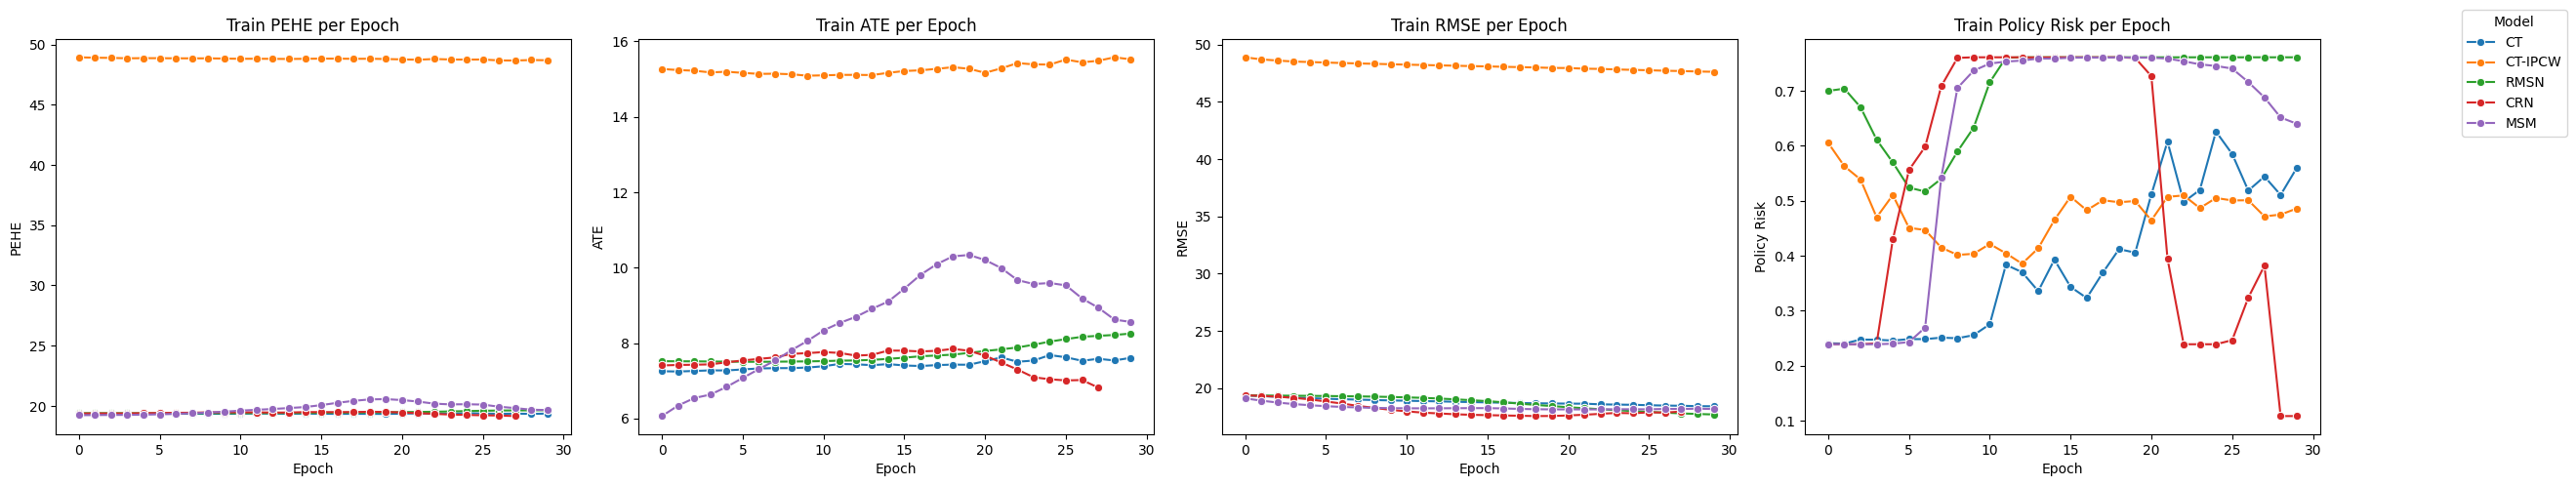

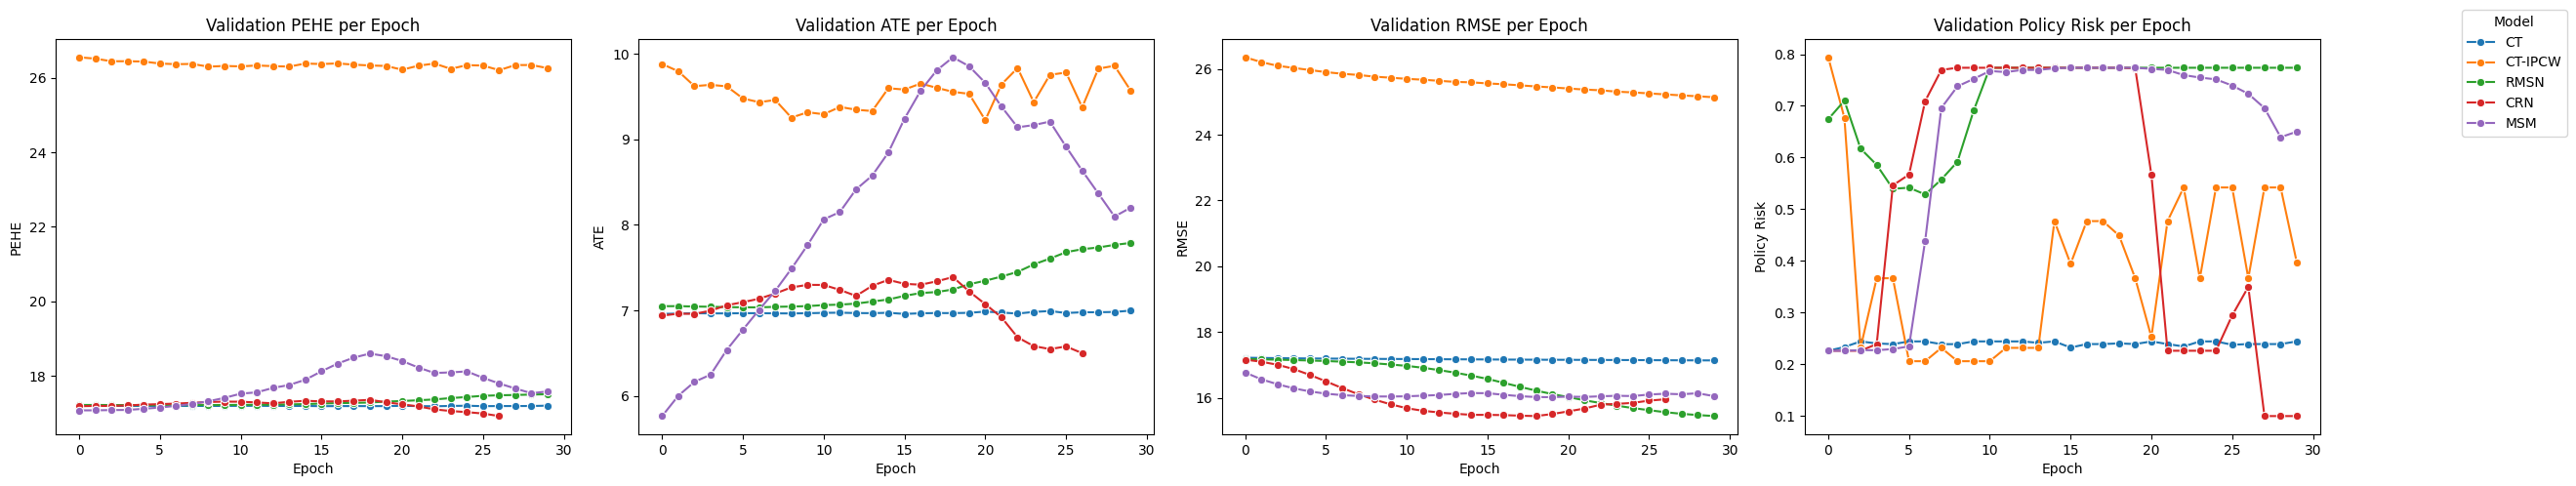

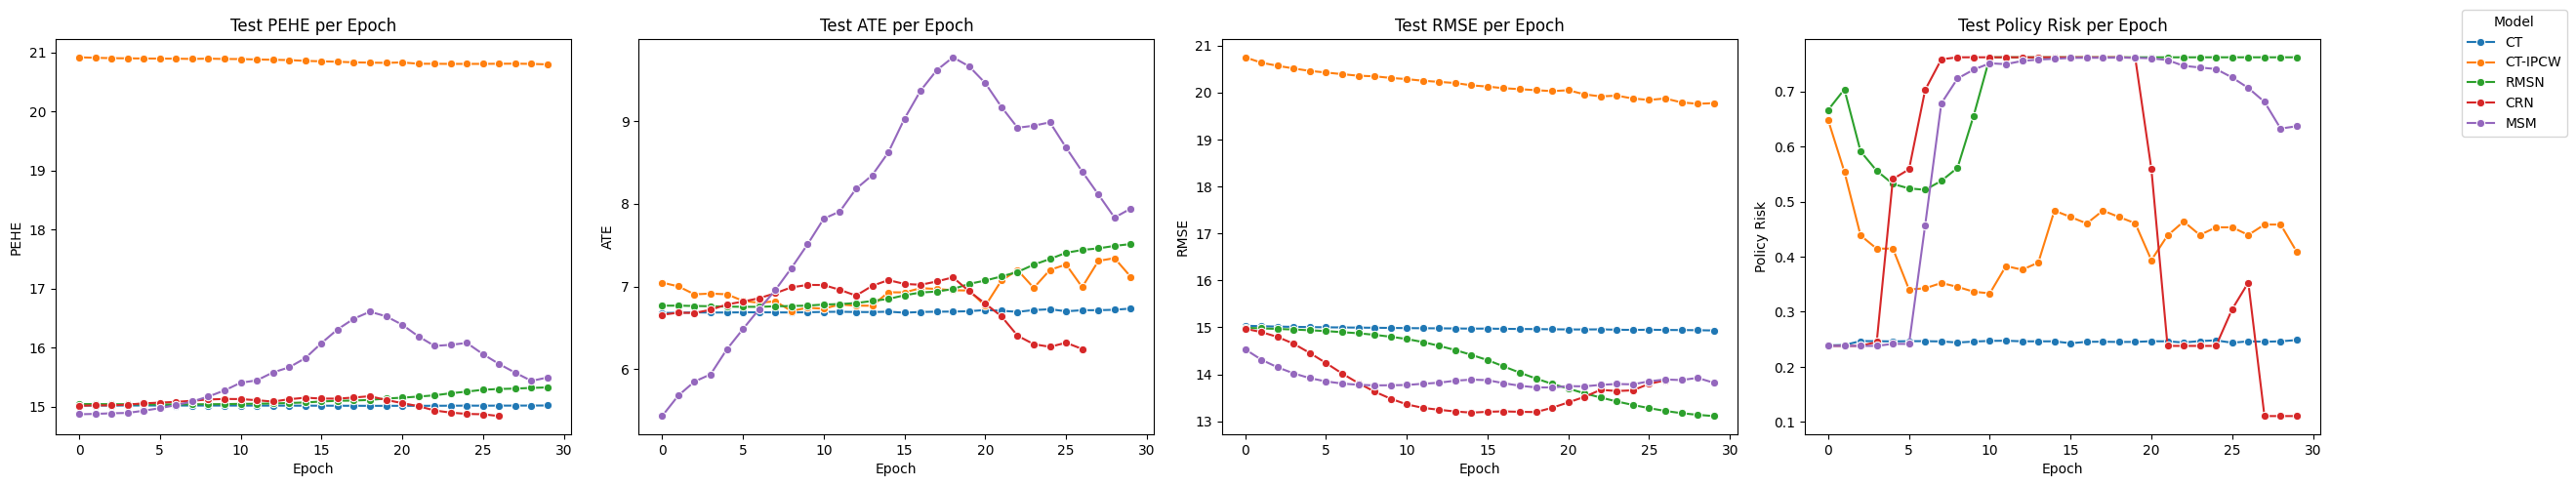

In [13]:
# Plot epoch summaries
plot_epoch_summary(train_epoch_long2, split="Train")
plot_epoch_summary(val_epoch_long2, split="Validation")
plot_epoch_summary(test_epoch_long2, split="Test")

In [14]:
train_step_long2 = summary_tables2["train_step_summary"].copy()
train_step_long2["model"] = train_step_long2["model"].map(name_map2)
train_step_long2["split"] = "Train"

val_step_long2 = summary_tables2["val_step_summary"].copy()
val_step_long2["model"] = val_step_long2["model"].map(name_map2)
val_step_long2["split"] = "Validation"

test_step_long2 = summary_tables2["test_step_summary"].copy()
test_step_long2["model"] = test_step_long2["model"].map(name_map2)
test_step_long2["split"] = "Test"

In [41]:
test_step_long2

timepoint       metric      value model split
0           0         PEHE   0.686868    CT  Test
1           1         PEHE  22.191078    CT  Test
2           2         PEHE  13.497229    CT  Test
3           3         PEHE  14.901677    CT  Test
4           0          ATE   0.000363    CT  Test
..        ...          ...        ...   ...   ...
75          3         RMSE   0.695387   MSM  Test
76          0  Policy Risk   7.645674   MSM  Test
77          1  Policy Risk  19.443850   MSM  Test
78          2  Policy Risk  12.975822   MSM  Test
79          3  Policy Risk  12.544668   MSM  Test

[80 rows x 5 columns]

In [62]:
rmse_wide = pivot_metric(test_step_long2, "RMSE")
rmse_wide

timepoint         0         1         2         3
model                                            
CRN        0.000000  0.137129  0.195197  0.108125
CT         0.120670  0.356585  0.302597  0.213211
CT-IPCW    0.557541  0.238725  0.389004  0.438688
MSM        0.775724  0.488163  0.589375  0.695387
RMSN       0.915818  0.638047  0.700280  0.795983

In [61]:
prisk_wide = pivot_metric(test_step_long2, "Policy Risk")
prisk_wide

timepoint         0          1          2          3
model                                               
CT         0.985908  22.076220  13.290413  14.906813
CT-IPCW    3.970861  23.910908  28.925911  12.294586
MSM        7.645674  19.443850  12.975822  12.544668
RMSN       3.450581  19.346497  12.223027  12.216256

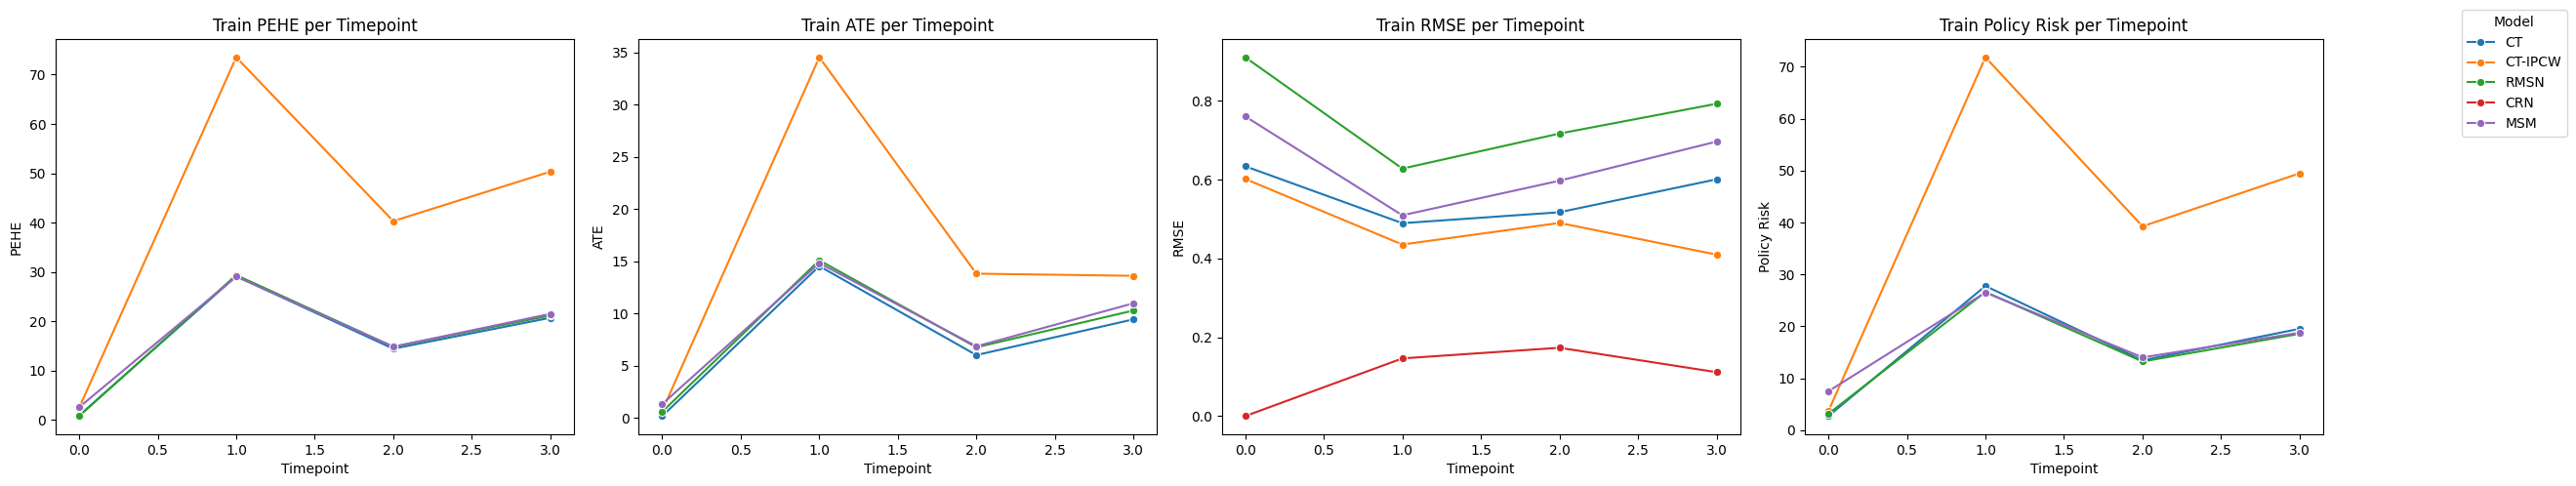

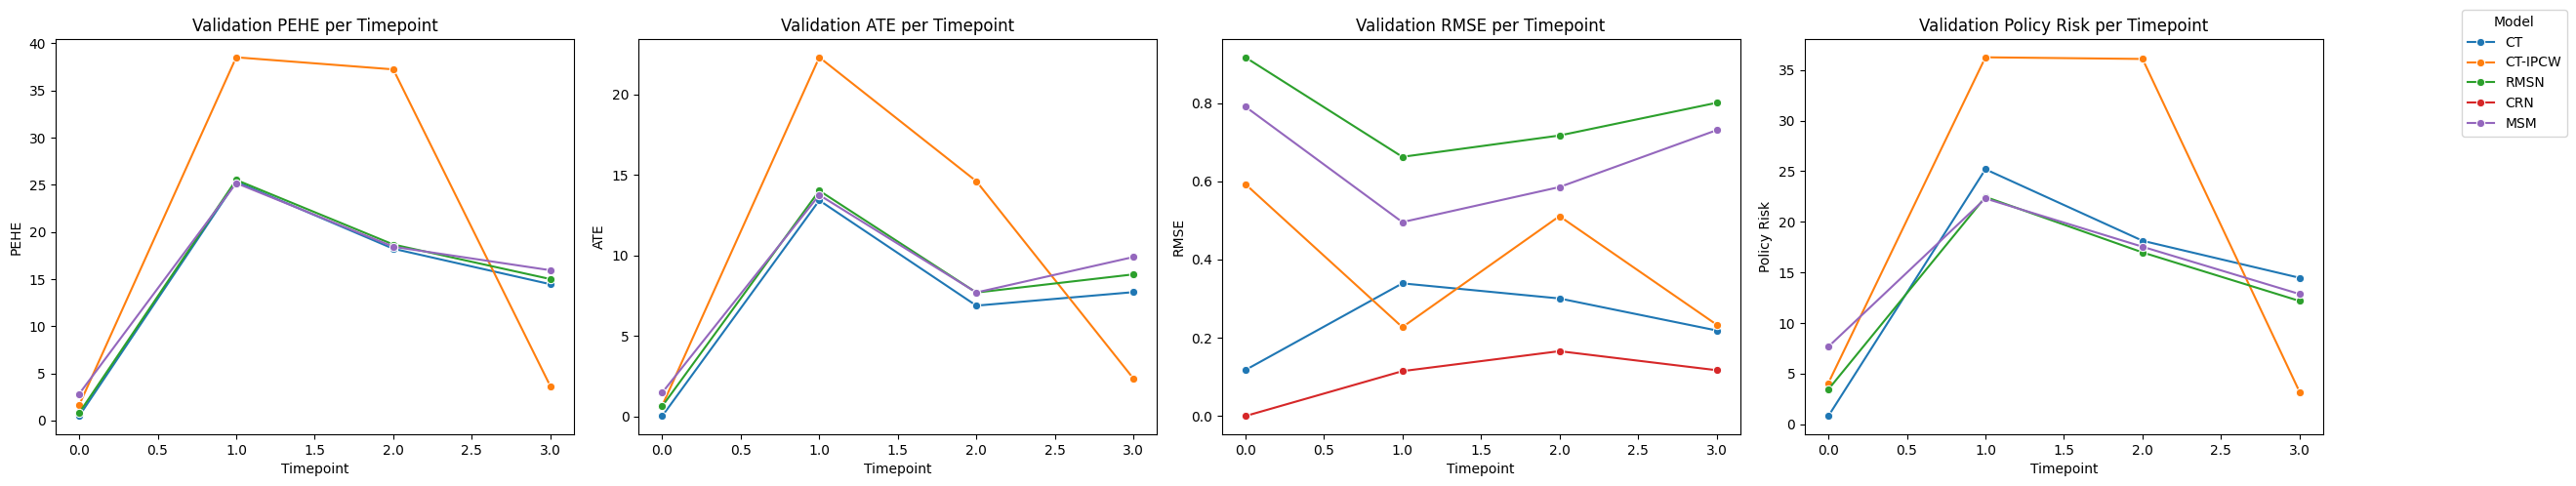

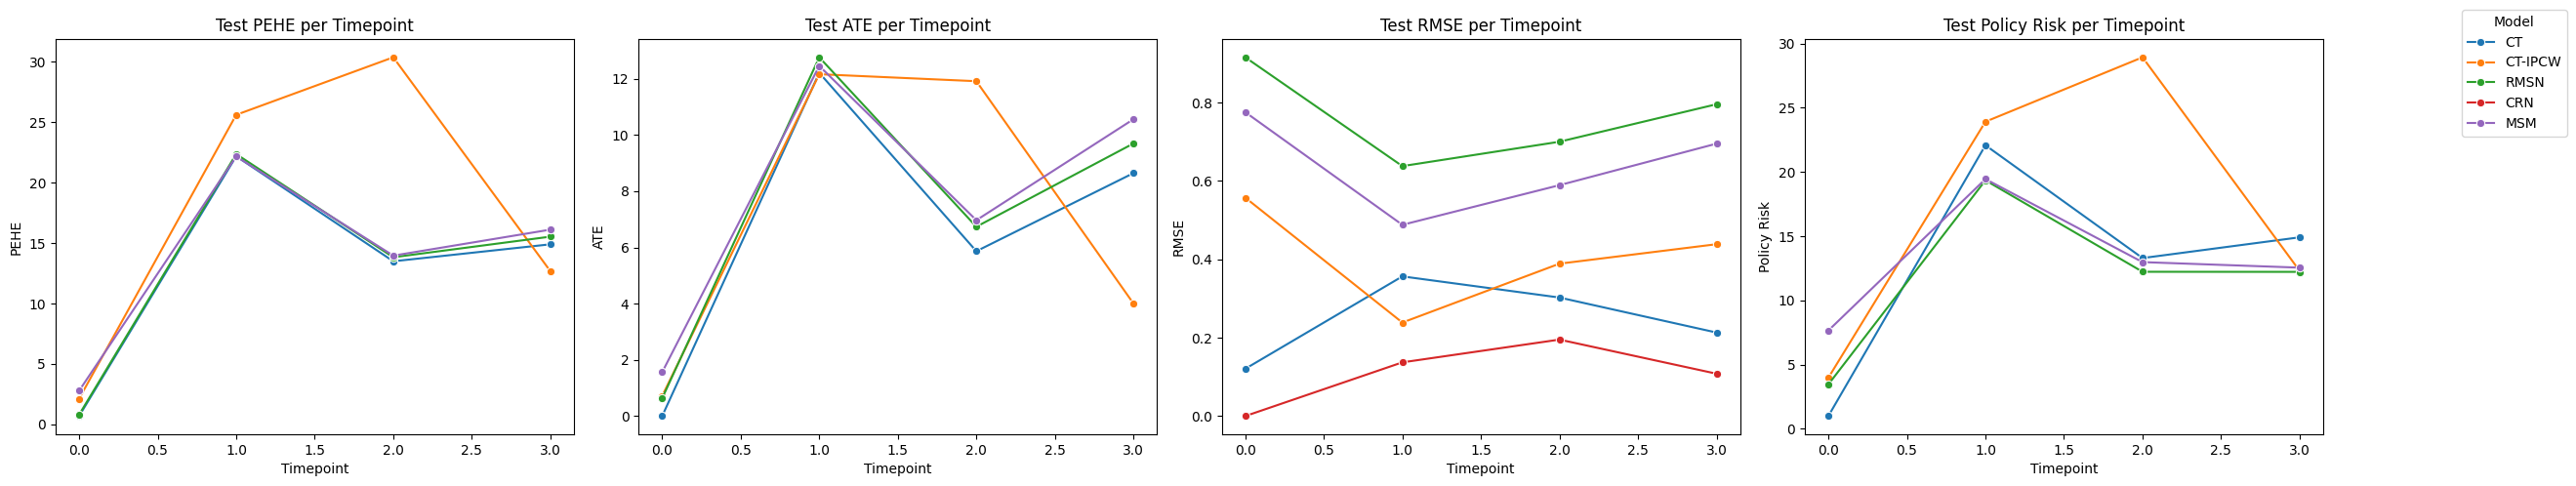

In [15]:
# Plot step summaries
plot_step_summary(train_step_long2, split="Train")
plot_step_summary(val_step_long2, split="Validation")
plot_step_summary(test_step_long2, split="Test")

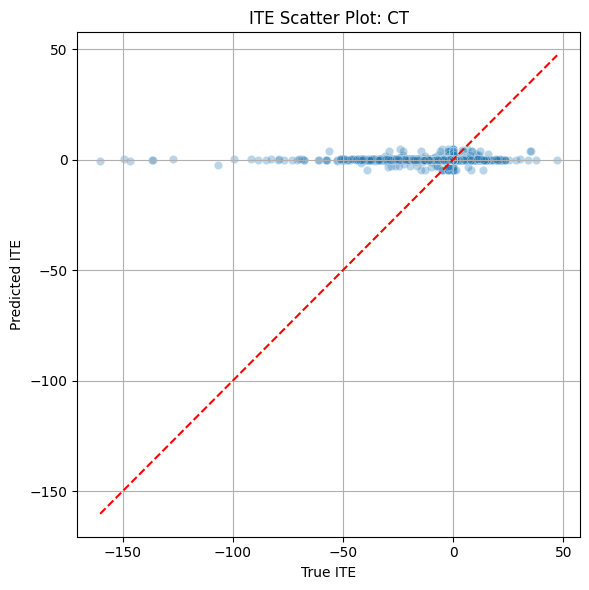

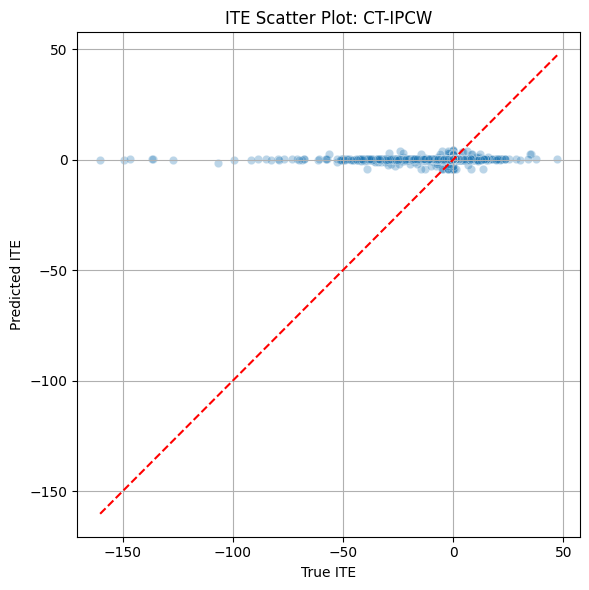

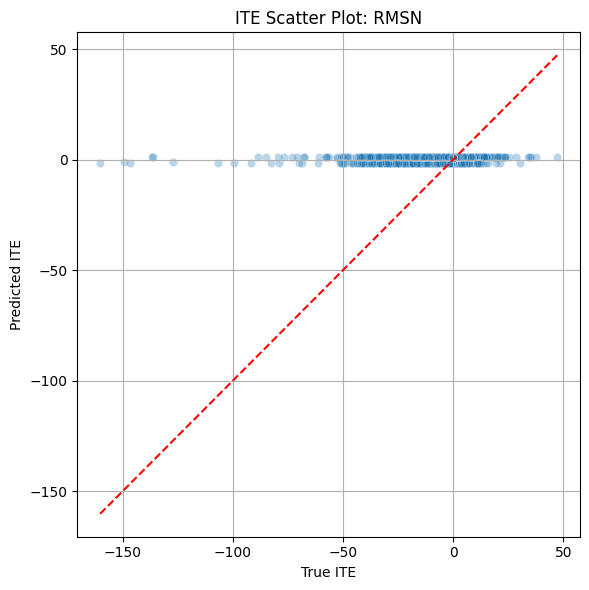

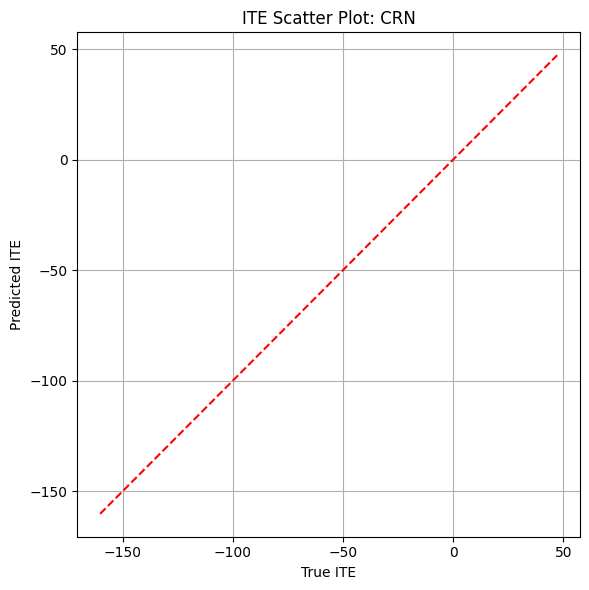

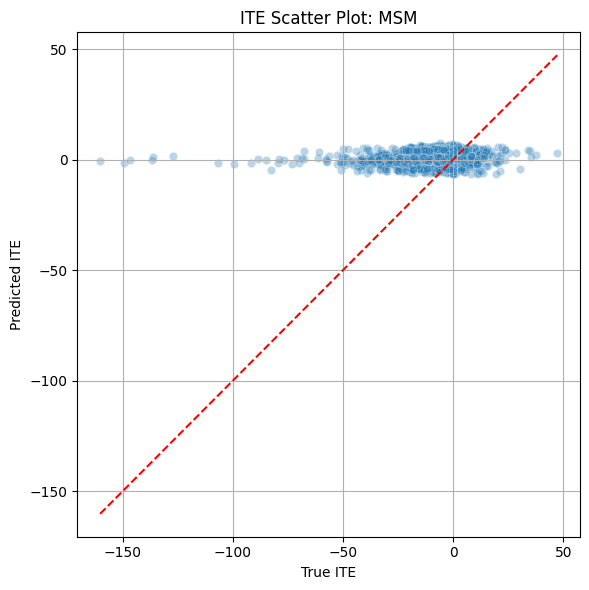

In [39]:
# Plot ITE scatterplots (one per model)
scatter_df2 = summary_tables2["scatter_summary"]
if scatter_df2 is not None:
    for model_name in scatter_df2["model"].unique():
        df_model2 = scatter_df2[scatter_df2["model"] == model_name]
        plot_ite_scatter(
            df_model2["true_ite"].values,
            df_model2["pred_ite"].values,
            model_name=name_map2.get(model_name, model_name)
        )

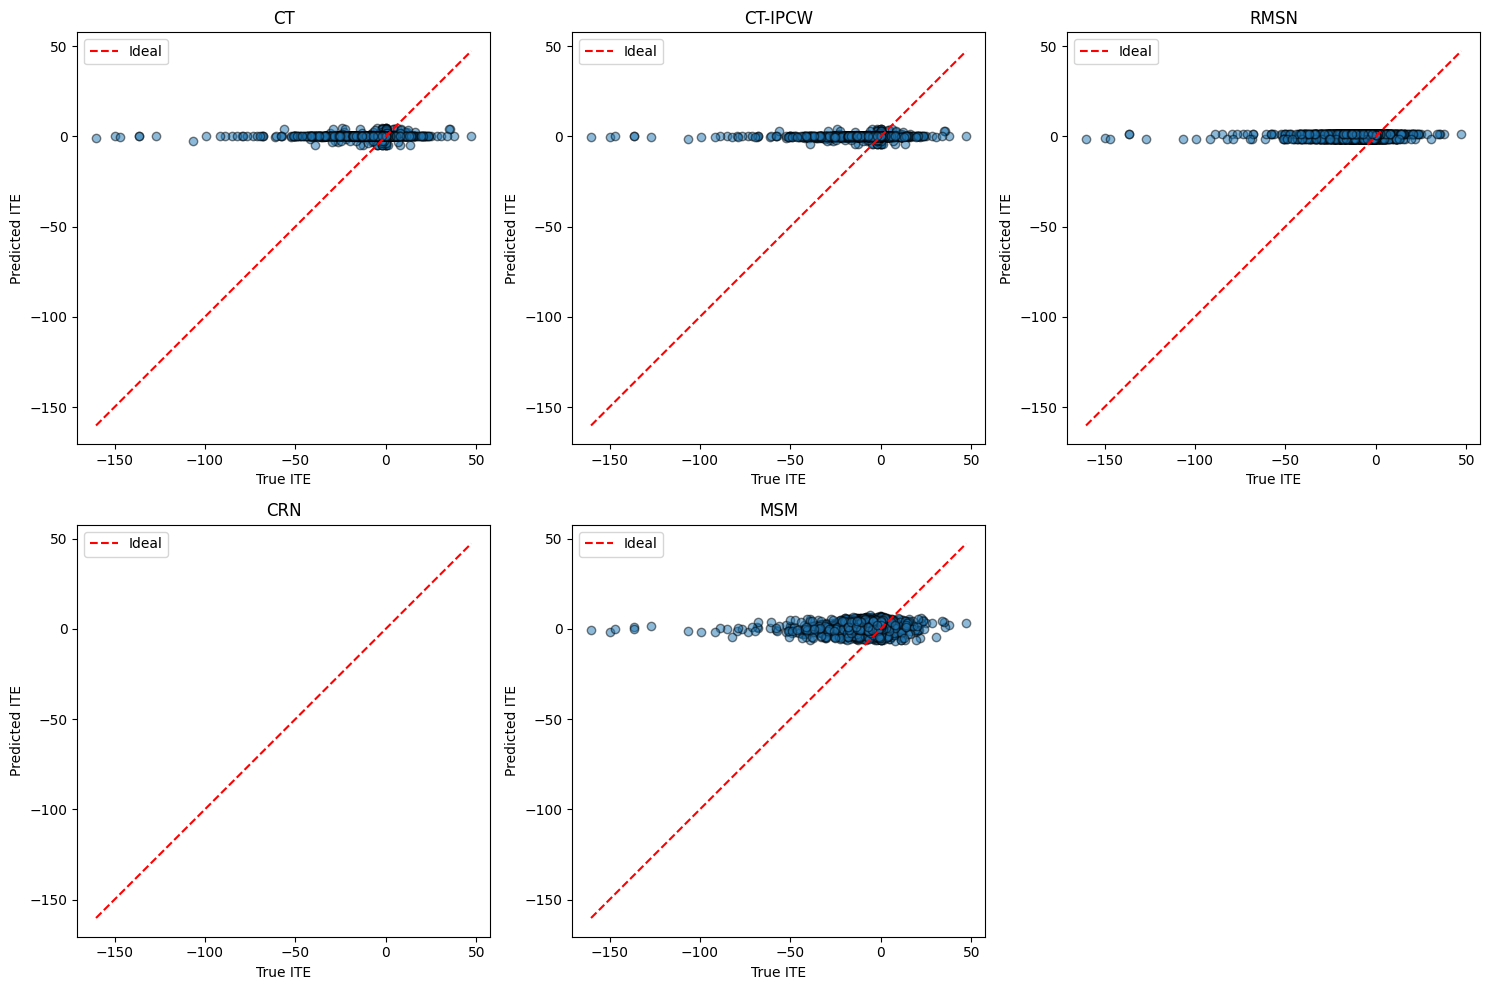

In [60]:
# Plot ITE scatterplots (one figure with subplots)
scatter_df2 = summary_tables2["scatter_summary"]

if scatter_df2 is not None:
    models = scatter_df2["model"].unique()
    n_models = len(models)

    # Set up the subplot grid
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols  # ceil division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()  # Flatten in case of single row

    for i, model_name in enumerate(models):
        df_model = scatter_df2[scatter_df2["model"] == model_name]

        ax = axes[i]
        ax.scatter(df_model["true_ite"], df_model["pred_ite"], alpha=0.5, edgecolor='k')
        ax.plot([df_model["true_ite"].min(), df_model["true_ite"].max()],
                [df_model["true_ite"].min(), df_model["true_ite"].max()],
                'r--', label="Ideal")
        ax.set_title(name_map.get(model_name, model_name))
        ax.set_xlabel("True ITE")
        ax.set_ylabel("Predicted ITE")
        ax.legend()

    # If there are unused subplots, turn them off
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


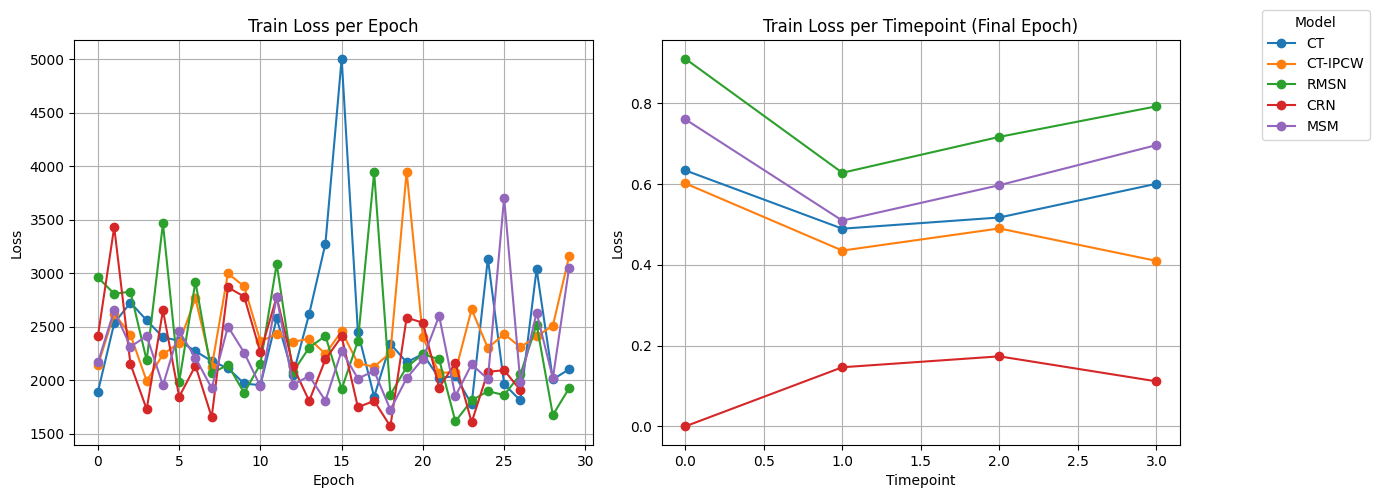

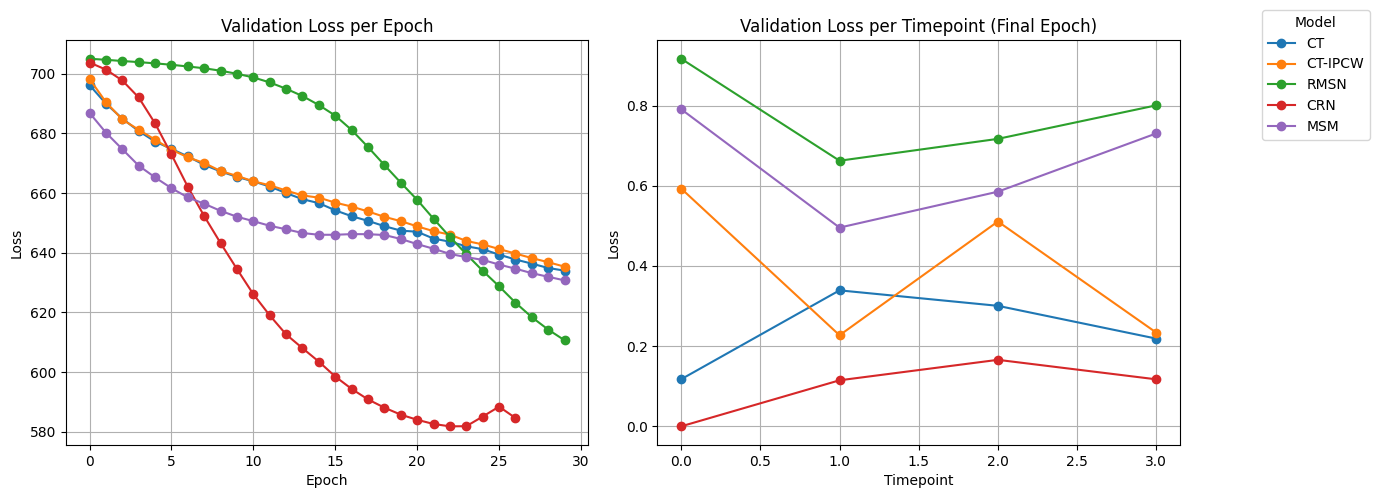

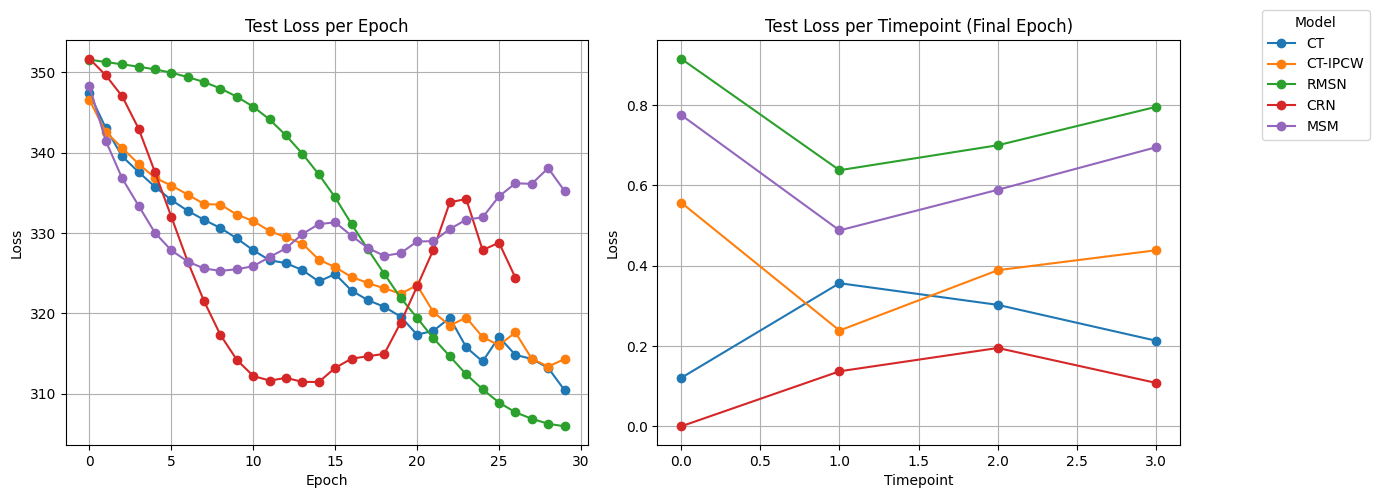

In [17]:
# Build a loss_dict_all_models dict:

# Build a loss_dict_all_models dict with display names from name_map

# For TRAIN
loss_dict_train_all2 = {
    name_map2.get(model_name, model_name): {
        "epoch": results2[model_name]["train_loss"],
        "per_timepoint": results2[model_name]["train_loss_steps"]
    }
    for model_name in results2.keys()
}

# For VAL
loss_dict_val_all2 = {
    name_map2.get(model_name, model_name): {
        "epoch": results2[model_name]["val_loss"],
        "per_timepoint": results2[model_name]["val_loss_steps"]
    }
    for model_name in results2.keys()
}

# For TEST
loss_dict_test_all2 = {
    name_map2.get(model_name, model_name): {
        "epoch": results2[model_name]["test_loss"],
        "per_timepoint": results2[model_name]["test_loss_steps"]
    }
    for model_name in results2.keys()
}

# Plot all models at once:
plot_loss_curves_all_models(loss_dict_train_all2, split="Train")
plot_loss_curves_all_models(loss_dict_val_all2, split="Validation")
plot_loss_curves_all_models(loss_dict_test_all2, split="Test")


In [44]:
epoch_table, timepoint_table = summarize_loss_tables(loss_dict_test_all2)

# To display
display(epoch_table)
display(timepoint_table)

epoch            1           2           3           4           5   \
model                                                                 
CRN      351.667400  349.600931  346.994844  342.986873  337.569752   
CT       347.345846  343.045198  339.526697  337.584599  335.739374   
CT-IPCW  346.523336  342.573704  340.563314  338.596812  336.856216   
MSM      348.245228  341.454967  336.785364  333.399496  330.022983   
RMSN     351.548988  351.251230  350.969609  350.678568  350.341845   

epoch            6           7           8           9           10  \
model                                                                 
CRN      332.013381  326.445497  321.504176  317.310388  314.218529   
CT       334.103966  332.757619  331.631735  330.614246  329.329879   
CT-IPCW  335.899212  334.778381  333.596687  333.522878  332.285471   
MSM      327.833430  326.443562  325.584331  325.286025  325.490912   
RMSN     349.929544  349.383865  348.772362  347.960601  346.944448   

epoch            11          12          13          14          15  \
model                                                                 
CRN      312.220028  311.646441  311.979584  311.487428  311.471050   
CT       327.842777  326.612368  326.245173  325.387026  323.970340   
CT-IPCW  331.488342  330.239798  329.465279  328.675330  326.692871   
MSM      325.870201  327.008447  328.096280  329.871869  331.099239   
RMSN     345.693392  344.111771  342.126213  339.849427  337.293263   

epoch            16          17          18          19          20  \
model                                                                 
CRN      313.221593  314.371437  314.671922  314.971774  318.861257   
CT       324.891498  322.832436  321.644616  320.812654  319.594334   
CT-IPCW  325.745766  324.526142  323.780806  323.114260  322.444895   
MSM      331.323198  329.650032  328.120604  327.159426  327.491968   
RMSN     334.412398  331.108625  327.963028  324.903557  321.924702   

epoch            21          22          23          24          25  \
model                                                                 
CRN      323.349261  327.938828  333.825531  334.218725  327.873446   
CT       317.354511  317.840677  319.453037  315.784608  314.018477   
CT-IPCW  323.501074  320.142977  318.491519  319.481140  317.055314   
MSM      328.941274  328.981659  330.491564  331.660538  331.937911   
RMSN     319.443167  316.902422  314.661918  312.417007  310.561537   

epoch            26          27          28          29          30  
model                                                                
CRN      328.791924  324.440411         NaN         NaN         NaN  
CT       317.065089  314.841496  314.335206  313.224289  310.453115  
CT-IPCW  316.041812  317.632421  314.361739  313.391274  314.319075  
MSM      334.551459  336.176018  336.109834  338.065980  335.227226  
RMSN     308.912384  307.701487  306.895972  306.279303  305.955500

timepoint       TP0       TP1       TP2       TP3
model                                            
CRN        0.000000  0.137129  0.195197  0.108125
CT         0.120670  0.356585  0.302597  0.213211
CT-IPCW    0.557541  0.238725  0.389004  0.438688
MSM        0.775724  0.488163  0.589375  0.695387
RMSN       0.915818  0.638047  0.700280  0.795983

In [45]:
epoch_table, timepoint_table = summarize_loss_tables(loss_dict_train_all2)

# To display
display(epoch_table)
display(timepoint_table)

epoch             1            2            3            4            5   \
model                                                                      
CRN      2415.859297  3432.209673  2152.875157  1729.410241  2654.712298   
CT       1895.077584  2534.204681  2726.364179  2560.684248  2402.800285   
CT-IPCW  2142.193852  2623.201586  2426.943359  1992.692269  2243.685394   
MSM      2169.263494  2654.000170  2314.012410  2414.314619  1953.231271   
RMSN     2961.198025  2809.069140  2828.710006  2185.673091  3465.996953   

epoch             6            7            8            9            10  \
model                                                                      
CRN      1846.515915  2137.507682  1657.115112  2869.168797  2781.980957   
CT       2370.073202  2272.409424  2179.816679  2113.039076  1970.812953   
CT-IPCW  2351.087690  2765.191315  2122.736330  2998.448011  2878.165606   
MSM      2458.197405  2209.925059  1927.459555  2502.762495  2259.056222   
RMSN     1986.155378  2921.184980  2067.319972  2143.971889  1882.076030   

epoch             11           12           13           14           15  \
model                                                                      
CRN      2260.465439  2779.495387  2133.571376  1807.051599  2195.925214   
CT       1954.747018  2578.455424  2050.334763  2619.389901  3276.198273   
CT-IPCW  2363.186135  2434.526895  2359.137303  2388.965498  2247.064641   
MSM      1942.824522  2781.202301  1957.752989  2041.292921  1809.590127   
RMSN     2153.988020  3088.887497  2077.324980  2305.834630  2415.505733   

epoch             16           17           18           19           20  \
model                                                                      
CRN      2410.006989  1748.877793  1808.215757  1570.442248  2586.450858   
CT       5004.750615  2451.223153  1847.247798  2340.723354  2169.192080   
CT-IPCW  2458.872615  2158.800267  2127.536909  2257.299696  3951.094687   
MSM      2276.603219  2016.932360  2087.326656  1726.345339  2019.315238   
RMSN     1918.636551  2366.550276  3943.094803  1867.063084  2124.305455   

epoch             21           22           23           24           25  \
model                                                                      
CRN      2538.081783  1933.130561  2162.154005  1608.174238  2079.940534   
CT       2245.855177  2020.578206  2040.726674  1777.833596  3138.191400   
CT-IPCW  2402.331911  2067.290431  2079.601628  2663.951586  2301.629028   
MSM      2202.427510  2602.219522  1853.047062  2149.522212  2011.810508   
RMSN     2245.489284  2196.303824  1616.493219  1812.518672  1898.714371   

epoch             26           27           28           29           30  
model                                                                     
CRN      2094.740474  1908.772631          NaN          NaN          NaN  
CT       1965.013960  1812.341078  3040.325642  2009.347831  2103.578550  
CT-IPCW  2433.087352  2309.922825  2410.816023  2510.993879  3158.423571  
MSM      3705.753261  1980.364633  2632.282761  2019.440310  3053.904999  
RMSN     1862.883253  2055.553711  2521.585658  1676.595302  1926.568876

timepoint       TP0       TP1       TP2       TP3
model                                            
CRN        0.000000  0.146379  0.173383  0.111426
CT         0.634078  0.489594  0.517366  0.600931
CT-IPCW    0.601871  0.435409  0.490233  0.409882
MSM        0.760627  0.509640  0.597407  0.696718
RMSN       0.910684  0.628138  0.717120  0.792733

In [46]:
epoch_table, timepoint_table = summarize_loss_tables(loss_dict_val_all2)

# To display
display(epoch_table)
display(timepoint_table)

epoch            1           2           3           4           5   \
model                                                                 
CRN      703.686190  701.313789  697.678198  691.985651  683.311657   
CT       696.122889  689.911379  684.928812  680.718748  677.233944   
CT-IPCW  698.183599  690.426071  684.606514  681.168911  677.850674   
MSM      686.832174  680.195242  674.664595  669.151781  665.222158   
RMSN     704.957989  704.588383  704.193609  703.822695  703.405916   

epoch            6           7           8           9           10  \
model                                                                 
CRN      672.889061  662.052376  652.248734  643.203201  634.523472   
CT       674.751963  672.232311  669.409510  667.205046  665.393162   
CT-IPCW  674.494661  671.930178  670.035172  667.347675  665.711752   
MSM      661.590847  658.522387  656.388006  654.011992  652.045273   
RMSN     702.933352  702.353174  701.765051  700.936293  699.910814   

epoch            11          12          13          14          15  \
model                                                                 
CRN      626.088057  619.001799  612.635777  608.018015  603.502064   
CT       663.870401  662.160545  659.965023  657.908936  656.596085   
CT-IPCW  663.906681  662.573215  660.813803  659.170666  658.432598   
MSM      650.562542  649.013039  647.834389  646.590122  645.995831   
RMSN     698.694033  697.023266  694.902582  692.451265  689.441858   

epoch            16          17          18          19          20  \
model                                                                 
CRN      598.523125  594.383175  590.856617  588.097897  585.759411   
CT       654.180195  652.223862  650.652905  648.886217  647.389118   
CT-IPCW  656.761389  655.452356  653.804739  652.007401  650.563177   
MSM      646.003090  646.218258  646.197636  645.916050  644.604774   
RMSN     685.905270  681.087080  675.371038  669.344593  663.447393   

epoch            21          22          23          24          25  \
model                                                                 
CRN      584.041691  582.637470  581.847504  581.892872  585.117588   
CT       647.014086  644.718393  643.682247  642.146587  641.175581   
CT-IPCW  648.817379  647.213367  646.047344  643.927597  642.783266   
MSM      642.876034  641.323727  639.580765  638.508381  637.589668   
RMSN     657.703539  651.361101  645.272451  639.504890  633.941231   

epoch            26          27          28          29          30  
model                                                                
CRN      588.440418  584.640564         NaN         NaN         NaN  
CT       639.351315  637.714819  636.335670  634.875795  633.987991  
CT-IPCW  641.227489  639.698664  638.195063  636.809683  635.322418  
MSM      636.026852  634.630642  633.151978  631.921509  630.728973  
RMSN     628.750280  623.265898  618.397039  614.234468  610.664053

timepoint       TP0       TP1       TP2       TP3
model                                            
CRN        0.000000  0.114819  0.165844  0.117242
CT         0.117498  0.339110  0.300524  0.218763
CT-IPCW    0.592952  0.227142  0.510792  0.233774
MSM        0.790771  0.495554  0.585158  0.730421
RMSN       0.916717  0.662343  0.716870  0.800452

## Optuna 10-fold CV

In [35]:
from torch.utils.data import DataLoader
from src.datamodule import TimeSeriesDataset

def create_dataloaders_from_df(df_train, df_val, covariates, batch_size, outcome_col="pct_weight_gain_factual", treatment_col="binary_treatment"):

    train_set = TimeSeriesDataset(df_train, covariates, outcome_col, treatment_col)
    val_set = TimeSeriesDataset(df_val, covariates, outcome_col, treatment_col)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader


# 10-Fold CV

## Transformer

In [ ]:
import optuna
from sklearn.model_selection import KFold
import numpy as np
import torch
from omegaconf import OmegaConf
from hydra import compose, initialize
from hydra.utils import instantiate

from src.datamodule import TimeSeriesDataset
#from utils import create_dataloaders_from_df


# Setup KFold on record_id level
kf = KFold(n_splits=10, shuffle=True, random_state=42)
record_ids = df_simulated["record_id"].unique()

def objective(trial):

    print(f"\n=== Starting trial {trial.number} ===")

    # Suggest hyperparameters: match model.yaml
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    embed_dim = trial.suggest_categorical("embed_dim", [64, 128, 256, 512])
    num_layers = trial.suggest_int("num_layers", 2, 6)
    n_heads = trial.suggest_categorical("n_heads", [2, 4, 8])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    # Initialize Hydra config for this trial
    with initialize(version_base=None, config_path="config"):
        cfg = compose(config_name="config.yaml", overrides=[
            "model=transformer",
            f"model.embed_dim={embed_dim}",
            f"model.num_layers={num_layers}",
            f"model.n_heads={n_heads}",
            f"model.dropout={dropout}",
            f"optimizer.lr={lr}"
        ])
        print(OmegaConf.to_yaml(cfg))

    pehe_per_fold = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(record_ids)):

        print(f"\n--- Fold {fold_idx+1}/10 ---")

        # Select record_id for this fold
        train_ids = record_ids[train_idx]
        val_ids = record_ids[val_idx]

        # Subset dataframe
        df_train_fold = df_simulated[df_simulated["record_id"].isin(train_ids)]
        df_val_fold = df_simulated[df_simulated["record_id"].isin(val_ids)]

        # Encode covariates — same as in the main loop
        covariate_cols = [
            'agemons',
            'binary_treatment',
            'sex', 'site', 'region', 'age_group',
            'nutri_counsel_disch', 'poor_feeding', 'acutely_ill'
        ]
        categorical_covs = [col for col in covariate_cols if col not in ["agemons", "binary_treatment"]]

        df_train_encoded = pd.get_dummies(df_train_fold, columns=categorical_covs, drop_first=True)
        df_train_encoded["binary_treatment"] = df_train_fold["binary_treatment"]

        df_val_encoded = pd.get_dummies(df_val_fold, columns=categorical_covs, drop_first=True)
        df_val_encoded["binary_treatment"] = df_val_fold["binary_treatment"]

        encoded_covariates = [col for col in df_train_encoded.columns if any(base in col for base in covariate_cols)]
        df_train_encoded[encoded_covariates] = df_train_encoded[encoded_covariates].astype("float32")
        df_val_encoded[encoded_covariates] = df_val_encoded[encoded_covariates].astype("float32")

        # Create dataloaders using the helper
        train_loader, val_loader = create_dataloaders_from_df(
            df_train=df_train_encoded,
            df_val=df_val_encoded,
            covariates=encoded_covariates,
            batch_size=cfg.batch_size
        )

        # Infer input_dim
        input_dim = len(encoded_covariates)

        # Instantiate model and optimizer: now with embed_dim
        model = instantiate(cfg.model, input_dim=input_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=cfg.optimizer.lr)

        # For Transformer: set _loss_type
        if hasattr(model, "_loss_type"):
            model._loss_type = "mse"

        # Run training loop for this fold
        metrics_dict = training_loop(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=val_loader,  # test_loader not used here, pass val_loader
            optimizer=optimizer,
            loss_type="mse",
            use_ipcw=cfg.model.use_ipcw,
            use_cdc=cfg.model.use_cdc,
            lambda_cdc=0.1,
            device=device,
            epochs=cfg.epochs,
        )

        # Extract PEHE at last epoch from val_epochs (list of dicts)
        val_pehe = metrics_dict["val_epochs"][-1]["PEHE"]
        print(f"Fold {fold_idx+1} val_pehe = {val_pehe:.4f}")
        pehe_per_fold.append(val_pehe)

    # Average PEHE across 10 folds
    avg_pehe = np.mean(pehe_per_fold)
    print(f"\nTrial {trial.number} average PEHE = {avg_pehe:.4f}")

    return avg_pehe


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20) # ideal trials would be 50-100


[I 2025-06-07 13:23:43,615] A new study created in memory with name: no-name-dd923f24-dfd4-42ab-b664-4b2b3ddfeab9



=== Starting trial 0 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 256
  num_layers: 6
  n_heads: 2
  dropout: 0.45606027433247964
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 1.1393608151114656e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [01:17<11:37, 77.53s/it]

Epoch 0: Train PEHE=1.5209, ATE=0.0006, RMSE=12.8303


Training Epochs:  20%|██        | 2/10 [02:34<10:19, 77.41s/it]

Epoch 1: Train PEHE=1.4123, ATE=0.0021, RMSE=12.0122


Training Epochs:  30%|███       | 3/10 [03:53<09:05, 77.91s/it]

Epoch 2: Train PEHE=1.3804, ATE=0.0049, RMSE=11.3853


Training Epochs:  40%|████      | 4/10 [05:11<07:47, 77.99s/it]

Epoch 3: Train PEHE=1.3081, ATE=0.0048, RMSE=10.8622


Training Epochs:  50%|█████     | 5/10 [06:28<06:28, 77.72s/it]

Epoch 4: Train PEHE=1.2544, ATE=0.0064, RMSE=10.4007


Training Epochs:  60%|██████    | 6/10 [07:48<05:13, 78.30s/it]

Epoch 5: Train PEHE=1.2156, ATE=0.0069, RMSE=9.9949


Training Epochs:  70%|███████   | 7/10 [09:06<03:54, 78.19s/it]

Epoch 6: Train PEHE=1.1854, ATE=0.0085, RMSE=9.6275


Training Epochs:  80%|████████  | 8/10 [10:25<02:37, 78.59s/it]

Epoch 7: Train PEHE=1.1337, ATE=0.0090, RMSE=9.3036


Training Epochs:  90%|█████████ | 9/10 [11:43<01:18, 78.51s/it]

Epoch 8: Train PEHE=1.0767, ATE=0.0091, RMSE=9.0255


Training Epochs: 100%|██████████| 10/10 [13:02<00:00, 78.24s/it]

Epoch 9: Train PEHE=1.0486, ATE=0.0103, RMSE=8.7923
Fold 1 val_pehe = 1.6058

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [01:18<11:45, 78.34s/it]

Epoch 0: Train PEHE=2.0481, ATE=0.0128, RMSE=13.0674


Training Epochs:  20%|██        | 2/10 [02:33<10:13, 76.75s/it]

Epoch 1: Train PEHE=1.9253, ATE=0.0100, RMSE=12.2562


Training Epochs:  30%|███       | 3/10 [03:50<08:55, 76.46s/it]

Epoch 2: Train PEHE=1.7733, ATE=0.0078, RMSE=11.6497


Training Epochs:  40%|████      | 4/10 [05:06<07:38, 76.35s/it]

Epoch 3: Train PEHE=1.7483, ATE=0.0057, RMSE=11.1359


Training Epochs:  50%|█████     | 5/10 [06:25<06:26, 77.27s/it]

Epoch 4: Train PEHE=1.7107, ATE=0.0040, RMSE=10.6739


Training Epochs:  60%|██████    | 6/10 [07:41<05:08, 77.07s/it]

Epoch 5: Train PEHE=1.6973, ATE=0.0021, RMSE=10.2572


Training Epochs:  70%|███████   | 7/10 [08:57<03:50, 76.72s/it]

Epoch 6: Train PEHE=1.6464, ATE=0.0010, RMSE=9.8784


Training Epochs:  80%|████████  | 8/10 [10:15<02:34, 77.02s/it]

Epoch 7: Train PEHE=1.6191, ATE=0.0001, RMSE=9.5376


Training Epochs:  90%|█████████ | 9/10 [11:33<01:17, 77.44s/it]

Epoch 8: Train PEHE=1.5672, ATE=0.0006, RMSE=9.2388


Training Epochs: 100%|██████████| 10/10 [12:50<00:00, 77.06s/it]


Epoch 9: Train PEHE=1.5164, ATE=0.0008, RMSE=8.9820
Fold 2 val_pehe = 1.6527

--- Fold 3/10 ---


Training Epochs:  10%|█         | 1/10 [01:16<11:31, 76.86s/it]

Epoch 0: Train PEHE=1.6930, ATE=0.0100, RMSE=12.9181


Training Epochs:  20%|██        | 2/10 [02:42<10:54, 81.86s/it]

Epoch 1: Train PEHE=1.5545, ATE=0.0133, RMSE=12.1230


Training Epochs:  30%|███       | 3/10 [04:02<09:27, 81.10s/it]

Epoch 2: Train PEHE=1.4638, ATE=0.0149, RMSE=11.5345


Training Epochs:  40%|████      | 4/10 [05:19<07:57, 79.63s/it]

Epoch 3: Train PEHE=1.4499, ATE=0.0159, RMSE=11.0206


Training Epochs:  50%|█████     | 5/10 [06:35<06:31, 78.34s/it]

Epoch 4: Train PEHE=1.4563, ATE=0.0160, RMSE=10.5440


Training Epochs:  60%|██████    | 6/10 [07:51<05:09, 77.48s/it]

Epoch 5: Train PEHE=1.4629, ATE=0.0167, RMSE=10.1114


Training Epochs:  70%|███████   | 7/10 [09:08<03:51, 77.13s/it]

Epoch 6: Train PEHE=1.4337, ATE=0.0182, RMSE=9.7151


Training Epochs:  80%|████████  | 8/10 [10:24<02:33, 76.87s/it]

Epoch 7: Train PEHE=1.3813, ATE=0.0202, RMSE=9.3619


Training Epochs:  90%|█████████ | 9/10 [11:42<01:17, 77.31s/it]

Epoch 8: Train PEHE=1.3521, ATE=0.0199, RMSE=9.0577


Training Epochs: 100%|██████████| 10/10 [13:00<00:00, 78.01s/it]


Epoch 9: Train PEHE=1.2985, ATE=0.0203, RMSE=8.8049
Fold 3 val_pehe = 1.5415

--- Fold 4/10 ---


Training Epochs:  10%|█         | 1/10 [01:18<11:42, 78.02s/it]

Epoch 0: Train PEHE=1.7403, ATE=0.0114, RMSE=13.2543


Training Epochs:  20%|██        | 2/10 [02:37<10:32, 79.03s/it]

Epoch 1: Train PEHE=1.8484, ATE=0.0068, RMSE=12.5323


Training Epochs:  30%|███       | 3/10 [03:55<09:07, 78.24s/it]

Epoch 2: Train PEHE=1.9606, ATE=0.0049, RMSE=11.9192


Training Epochs:  40%|████      | 4/10 [05:12<07:47, 77.85s/it]

Epoch 3: Train PEHE=2.0906, ATE=0.0053, RMSE=11.4006


Training Epochs:  50%|█████     | 5/10 [06:28<06:27, 77.43s/it]

Epoch 4: Train PEHE=2.1496, ATE=0.0056, RMSE=10.9440


Training Epochs:  60%|██████    | 6/10 [07:45<05:07, 76.98s/it]

Epoch 5: Train PEHE=2.2146, ATE=0.0054, RMSE=10.5250


Training Epochs:  70%|███████   | 7/10 [09:03<03:52, 77.35s/it]

Epoch 6: Train PEHE=2.2534, ATE=0.0048, RMSE=10.1448


Training Epochs:  80%|████████  | 8/10 [10:20<02:34, 77.44s/it]

Epoch 7: Train PEHE=2.3142, ATE=0.0048, RMSE=9.7971


Training Epochs:  90%|█████████ | 9/10 [11:37<01:17, 77.05s/it]

Epoch 8: Train PEHE=2.2795, ATE=0.0019, RMSE=9.4831


Training Epochs: 100%|██████████| 10/10 [12:55<00:00, 77.51s/it]


Epoch 9: Train PEHE=2.2631, ATE=0.0027, RMSE=9.2057
Fold 4 val_pehe = 1.8492

--- Fold 5/10 ---


Training Epochs:  10%|█         | 1/10 [01:15<11:23, 75.92s/it]

Epoch 0: Train PEHE=1.7894, ATE=0.0092, RMSE=12.9060


Training Epochs:  20%|██        | 2/10 [02:31<10:04, 75.53s/it]

Epoch 1: Train PEHE=1.6613, ATE=0.0028, RMSE=12.1089


Training Epochs:  30%|███       | 3/10 [03:49<08:58, 76.97s/it]

Epoch 2: Train PEHE=1.5396, ATE=0.0004, RMSE=11.4797


Training Epochs:  40%|████      | 4/10 [05:11<07:52, 78.79s/it]

Epoch 3: Train PEHE=1.4563, ATE=0.0020, RMSE=10.9521


Training Epochs:  50%|█████     | 5/10 [06:28<06:31, 78.22s/it]

Epoch 4: Train PEHE=1.3830, ATE=0.0058, RMSE=10.4850


Training Epochs:  60%|██████    | 6/10 [07:47<05:13, 78.29s/it]

Epoch 5: Train PEHE=1.3320, ATE=0.0065, RMSE=10.0655


Training Epochs:  70%|███████   | 7/10 [09:05<03:54, 78.25s/it]

Epoch 6: Train PEHE=1.2764, ATE=0.0075, RMSE=9.6901


Training Epochs:  80%|████████  | 8/10 [10:22<02:36, 78.02s/it]

Epoch 7: Train PEHE=1.2308, ATE=0.0100, RMSE=9.3553


Training Epochs:  90%|█████████ | 9/10 [11:40<01:17, 77.90s/it]

Epoch 8: Train PEHE=1.1809, ATE=0.0112, RMSE=9.0736


Training Epochs: 100%|██████████| 10/10 [12:55<00:00, 77.57s/it]

Epoch 9: Train PEHE=1.1252, ATE=0.0138, RMSE=8.8375
Fold 5 val_pehe = 1.5891

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [01:16<11:26, 76.23s/it]

Epoch 0: Train PEHE=2.0055, ATE=0.0051, RMSE=13.1790


Training Epochs:  20%|██        | 2/10 [02:34<10:21, 77.68s/it]

Epoch 1: Train PEHE=2.0424, ATE=0.0009, RMSE=12.4366


Training Epochs:  30%|███       | 3/10 [03:52<09:04, 77.74s/it]

Epoch 2: Train PEHE=1.9833, ATE=0.0005, RMSE=11.8146


Training Epochs:  40%|████      | 4/10 [05:09<07:43, 77.20s/it]

Epoch 3: Train PEHE=1.9868, ATE=0.0033, RMSE=11.2750


Training Epochs:  50%|█████     | 5/10 [06:26<06:26, 77.29s/it]

Epoch 4: Train PEHE=2.0195, ATE=0.0044, RMSE=10.8069


Training Epochs:  60%|██████    | 6/10 [07:45<05:11, 77.88s/it]

Epoch 5: Train PEHE=2.0083, ATE=0.0059, RMSE=10.3923


Training Epochs:  70%|███████   | 7/10 [09:03<03:53, 77.95s/it]

Epoch 6: Train PEHE=1.9973, ATE=0.0070, RMSE=10.0075


Training Epochs:  80%|████████  | 8/10 [10:20<02:35, 77.53s/it]

Epoch 7: Train PEHE=2.0053, ATE=0.0071, RMSE=9.6560


Training Epochs:  90%|█████████ | 9/10 [11:37<01:17, 77.56s/it]

Epoch 8: Train PEHE=1.9576, ATE=0.0076, RMSE=9.3475


Training Epochs: 100%|██████████| 10/10 [12:55<00:00, 77.59s/it]


Epoch 9: Train PEHE=1.9105, ATE=0.0082, RMSE=9.0828
Fold 6 val_pehe = 1.6978

--- Fold 7/10 ---


Training Epochs:  10%|█         | 1/10 [01:18<11:49, 78.79s/it]

Epoch 0: Train PEHE=1.4977, ATE=0.0044, RMSE=12.9632


Training Epochs:  20%|██        | 2/10 [02:37<10:30, 78.75s/it]

Epoch 1: Train PEHE=1.0671, ATE=0.0078, RMSE=12.0342


Training Epochs:  30%|███       | 3/10 [04:04<09:38, 82.66s/it]

Epoch 2: Train PEHE=0.8766, ATE=0.0081, RMSE=11.3764


Training Epochs:  40%|████      | 4/10 [06:01<09:36, 96.02s/it]

Epoch 3: Train PEHE=0.8177, ATE=0.0097, RMSE=10.8612


Training Epochs:  50%|█████     | 5/10 [07:53<08:29, 101.82s/it]

Epoch 4: Train PEHE=0.8064, ATE=0.0092, RMSE=10.4226


Training Epochs:  60%|██████    | 6/10 [09:38<06:51, 102.97s/it]

Epoch 5: Train PEHE=0.8235, ATE=0.0124, RMSE=10.0247


Training Epochs:  70%|███████   | 7/10 [11:22<05:09, 103.28s/it]

Epoch 6: Train PEHE=0.8395, ATE=0.0122, RMSE=9.6583


Training Epochs:  80%|████████  | 8/10 [13:02<03:24, 102.11s/it]

Epoch 7: Train PEHE=0.8566, ATE=0.0145, RMSE=9.3314


Training Epochs:  90%|█████████ | 9/10 [14:41<01:41, 101.35s/it]

Epoch 8: Train PEHE=0.8665, ATE=0.0154, RMSE=9.0589


Training Epochs: 100%|██████████| 10/10 [16:19<00:00, 97.95s/it] 

Epoch 9: Train PEHE=0.8624, ATE=0.0162, RMSE=8.8241
Fold 7 val_pehe = 1.5783

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [01:39<14:53, 99.32s/it]

Epoch 0: Train PEHE=1.3599, ATE=0.0028, RMSE=12.9159


Training Epochs:  20%|██        | 2/10 [03:19<13:20, 100.06s/it]

Epoch 1: Train PEHE=1.2622, ATE=0.0016, RMSE=12.0995


Training Epochs:  30%|███       | 3/10 [04:57<11:33, 99.09s/it] 

Epoch 2: Train PEHE=1.2346, ATE=0.0023, RMSE=11.4625


Training Epochs:  40%|████      | 4/10 [06:37<09:55, 99.31s/it]

Epoch 3: Train PEHE=1.2183, ATE=0.0005, RMSE=10.9295


Training Epochs:  50%|█████     | 5/10 [08:17<08:18, 99.73s/it]

Epoch 4: Train PEHE=1.1141, ATE=0.0025, RMSE=10.4658


Training Epochs:  60%|██████    | 6/10 [09:58<06:40, 100.00s/it]

Epoch 5: Train PEHE=1.0660, ATE=0.0025, RMSE=10.0562


Training Epochs:  70%|███████   | 7/10 [11:35<04:57, 99.01s/it] 

Epoch 6: Train PEHE=0.9921, ATE=0.0042, RMSE=9.6831


Training Epochs:  80%|████████  | 8/10 [13:13<03:17, 98.68s/it]

Epoch 7: Train PEHE=0.9487, ATE=0.0048, RMSE=9.3418


Training Epochs:  90%|█████████ | 9/10 [14:46<01:36, 96.79s/it]

Epoch 8: Train PEHE=0.9102, ATE=0.0046, RMSE=9.0563


Training Epochs: 100%|██████████| 10/10 [16:18<00:00, 97.87s/it]

Epoch 9: Train PEHE=0.8683, ATE=0.0058, RMSE=8.8175
Fold 8 val_pehe = 1.5725

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [01:25<12:48, 85.34s/it]

Epoch 0: Train PEHE=1.7352, ATE=0.0093, RMSE=13.0050


Training Epochs:  20%|██        | 2/10 [02:54<11:38, 87.29s/it]

Epoch 1: Train PEHE=1.5893, ATE=0.0048, RMSE=12.1844


Training Epochs:  30%|███       | 3/10 [04:18<10:00, 85.86s/it]

Epoch 2: Train PEHE=1.5277, ATE=0.0017, RMSE=11.5449


Training Epochs:  40%|████      | 4/10 [05:40<08:26, 84.41s/it]

Epoch 3: Train PEHE=1.4937, ATE=0.0007, RMSE=11.0078


Training Epochs:  50%|█████     | 5/10 [07:08<07:08, 85.76s/it]

Epoch 4: Train PEHE=1.4457, ATE=0.0018, RMSE=10.5422


Training Epochs:  60%|██████    | 6/10 [08:32<05:40, 85.12s/it]

Epoch 5: Train PEHE=1.3937, ATE=0.0024, RMSE=10.1227


Training Epochs:  70%|███████   | 7/10 [09:56<04:14, 84.68s/it]

Epoch 6: Train PEHE=1.3536, ATE=0.0037, RMSE=9.7525


Training Epochs:  80%|████████  | 8/10 [11:18<02:48, 84.08s/it]

Epoch 7: Train PEHE=1.3027, ATE=0.0045, RMSE=9.4197


Training Epochs:  90%|█████████ | 9/10 [12:43<01:24, 84.26s/it]

Epoch 8: Train PEHE=1.2351, ATE=0.0067, RMSE=9.1317


Training Epochs: 100%|██████████| 10/10 [14:04<00:00, 84.45s/it]


Epoch 9: Train PEHE=1.1732, ATE=0.0075, RMSE=8.8866
Fold 9 val_pehe = 1.6105

--- Fold 10/10 ---


Training Epochs:  10%|█         | 1/10 [01:19<11:54, 79.39s/it]

Epoch 0: Train PEHE=1.7359, ATE=0.0011, RMSE=13.0697


Training Epochs:  20%|██        | 2/10 [02:39<10:39, 79.92s/it]

Epoch 1: Train PEHE=1.6661, ATE=0.0046, RMSE=12.3571


Training Epochs:  30%|███       | 3/10 [04:01<09:24, 80.59s/it]

Epoch 2: Train PEHE=1.7052, ATE=0.0056, RMSE=11.7820


Training Epochs:  40%|████      | 4/10 [05:19<07:57, 79.56s/it]

Epoch 3: Train PEHE=1.6708, ATE=0.0066, RMSE=11.2922


Training Epochs:  50%|█████     | 5/10 [06:37<06:36, 79.30s/it]

Epoch 4: Train PEHE=1.6660, ATE=0.0084, RMSE=10.8537


Training Epochs:  60%|██████    | 6/10 [07:59<05:20, 80.11s/it]

Epoch 5: Train PEHE=1.6587, ATE=0.0071, RMSE=10.4507


Training Epochs:  70%|███████   | 7/10 [09:19<04:00, 80.12s/it]

Epoch 6: Train PEHE=1.6527, ATE=0.0093, RMSE=10.0879


Training Epochs:  80%|████████  | 8/10 [10:37<02:38, 79.34s/it]

Epoch 7: Train PEHE=1.6147, ATE=0.0102, RMSE=9.7534


Training Epochs:  90%|█████████ | 9/10 [11:57<01:19, 79.45s/it]

Epoch 8: Train PEHE=1.5767, ATE=0.0105, RMSE=9.4556


Training Epochs: 100%|██████████| 10/10 [13:16<00:00, 79.66s/it]
[I 2025-06-07 15:41:25,246] Trial 0 finished with value: 1.6388534307479858 and parameters: {'lr': 1.1393608151114656e-05, 'embed_dim': 256, 'num_layers': 6, 'n_heads': 2, 'dropout': 0.45606027433247964}. Best is trial 0 with value: 1.6388534307479858.


Epoch 9: Train PEHE=1.5459, ATE=0.0115, RMSE=9.1840
Fold 10 val_pehe = 1.6912

Trial 0 average PEHE = 1.6389

=== Starting trial 1 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 64
  num_layers: 4
  n_heads: 2
  dropout: 0.19122454291920699
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.0005476527126236949
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:54<08:12, 54.76s/it]

Epoch 0: Train PEHE=1.4224, ATE=0.0035, RMSE=11.8161


Training Epochs:  20%|██        | 2/10 [01:46<07:03, 52.90s/it]

Epoch 1: Train PEHE=1.1062, ATE=0.0298, RMSE=8.6786


Training Epochs:  30%|███       | 3/10 [02:39<06:11, 53.04s/it]

Epoch 2: Train PEHE=0.8231, ATE=0.0350, RMSE=8.0442


Training Epochs:  40%|████      | 4/10 [03:33<05:19, 53.28s/it]

Epoch 3: Train PEHE=0.8290, ATE=0.0252, RMSE=8.0397


Training Epochs:  50%|█████     | 5/10 [04:28<04:29, 53.99s/it]

Epoch 4: Train PEHE=0.8334, ATE=0.0268, RMSE=8.0336


Training Epochs:  60%|██████    | 6/10 [05:21<03:34, 53.58s/it]

Epoch 5: Train PEHE=0.8781, ATE=0.0225, RMSE=8.0353


Training Epochs:  70%|███████   | 7/10 [06:16<02:42, 54.03s/it]

Epoch 6: Train PEHE=0.8202, ATE=0.0238, RMSE=8.0354


Training Epochs:  80%|████████  | 8/10 [07:10<01:48, 54.19s/it]

Epoch 7: Train PEHE=0.9589, ATE=0.0269, RMSE=8.0413


Training Epochs:  90%|█████████ | 9/10 [08:04<00:54, 54.11s/it]

Epoch 8: Train PEHE=0.8996, ATE=0.0247, RMSE=8.0411


Training Epochs: 100%|██████████| 10/10 [08:55<00:00, 53.58s/it]

Epoch 9: Train PEHE=0.8852, ATE=0.0181, RMSE=8.0463
Fold 1 val_pehe = 1.6481

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:58<08:46, 58.55s/it]

Epoch 0: Train PEHE=2.2977, ATE=0.0035, RMSE=11.4611


Training Epochs:  20%|██        | 2/10 [01:54<07:34, 56.84s/it]

Epoch 1: Train PEHE=2.3542, ATE=0.0077, RMSE=8.4351


Training Epochs:  30%|███       | 3/10 [02:48<06:29, 55.68s/it]

Epoch 2: Train PEHE=0.8194, ATE=0.0033, RMSE=8.0567


Training Epochs:  40%|████      | 4/10 [03:44<05:33, 55.62s/it]

Epoch 3: Train PEHE=0.8037, ATE=0.0015, RMSE=8.0603


Training Epochs:  50%|█████     | 5/10 [04:38<04:36, 55.30s/it]

Epoch 4: Train PEHE=0.8574, ATE=0.0017, RMSE=8.0625


Training Epochs:  60%|██████    | 6/10 [05:30<03:37, 54.26s/it]

Epoch 5: Train PEHE=0.8608, ATE=0.0008, RMSE=8.0671


Training Epochs:  70%|███████   | 7/10 [06:22<02:40, 53.51s/it]

Epoch 6: Train PEHE=0.8152, ATE=0.0005, RMSE=8.0631


Training Epochs:  80%|████████  | 8/10 [07:15<01:46, 53.31s/it]

Epoch 7: Train PEHE=0.8745, ATE=0.0016, RMSE=8.0603


Training Epochs:  90%|█████████ | 9/10 [08:11<00:53, 53.93s/it]

Epoch 8: Train PEHE=0.8370, ATE=0.0005, RMSE=8.0613


Training Epochs: 100%|██████████| 10/10 [09:03<00:00, 54.38s/it]

Epoch 9: Train PEHE=0.8231, ATE=0.0015, RMSE=8.0605
Fold 2 val_pehe = 1.4766

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [00:54<08:08, 54.30s/it]

Epoch 0: Train PEHE=1.0084, ATE=0.0185, RMSE=10.9964


Training Epochs:  20%|██        | 2/10 [01:51<07:25, 55.74s/it]

Epoch 1: Train PEHE=1.2146, ATE=0.0515, RMSE=8.2140


Training Epochs:  30%|███       | 3/10 [02:45<06:27, 55.35s/it]

Epoch 2: Train PEHE=1.0897, ATE=0.0398, RMSE=8.0710


Training Epochs:  40%|████      | 4/10 [03:38<05:25, 54.18s/it]

Epoch 3: Train PEHE=1.0862, ATE=0.0376, RMSE=8.0753


Training Epochs:  50%|█████     | 5/10 [04:28<04:22, 52.59s/it]

Epoch 4: Train PEHE=1.1574, ATE=0.0291, RMSE=8.0797


Training Epochs:  60%|██████    | 6/10 [05:27<03:39, 54.88s/it]

Epoch 5: Train PEHE=1.0165, ATE=0.0299, RMSE=8.0802


Training Epochs:  70%|███████   | 7/10 [06:24<02:46, 55.55s/it]

Epoch 6: Train PEHE=1.0157, ATE=0.0267, RMSE=8.0795


Training Epochs:  80%|████████  | 8/10 [07:19<01:50, 55.43s/it]

Epoch 7: Train PEHE=1.0663, ATE=0.0264, RMSE=8.0848


Training Epochs:  90%|█████████ | 9/10 [08:12<00:54, 54.81s/it]

Epoch 8: Train PEHE=1.0439, ATE=0.0233, RMSE=8.0942


Training Epochs: 100%|██████████| 10/10 [09:08<00:00, 54.82s/it]

Epoch 9: Train PEHE=1.1757, ATE=0.0229, RMSE=8.0953
Fold 3 val_pehe = 1.5229

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [00:54<08:09, 54.34s/it]

Epoch 0: Train PEHE=1.3611, ATE=0.0044, RMSE=11.0712


Training Epochs:  20%|██        | 2/10 [01:48<07:13, 54.20s/it]

Epoch 1: Train PEHE=0.8509, ATE=0.0333, RMSE=8.1937


Training Epochs:  30%|███       | 3/10 [02:44<06:25, 55.01s/it]

Epoch 2: Train PEHE=0.8160, ATE=0.0258, RMSE=8.0371


Training Epochs:  40%|████      | 4/10 [03:39<05:29, 54.94s/it]

Epoch 3: Train PEHE=0.7821, ATE=0.0215, RMSE=8.0392


Training Epochs:  50%|█████     | 5/10 [04:33<04:33, 54.71s/it]

Epoch 4: Train PEHE=0.7818, ATE=0.0184, RMSE=8.0395


Training Epochs:  60%|██████    | 6/10 [05:25<03:35, 53.88s/it]

Epoch 5: Train PEHE=0.7855, ATE=0.0174, RMSE=8.0390


Training Epochs:  70%|███████   | 7/10 [06:19<02:41, 53.85s/it]

Epoch 6: Train PEHE=0.8215, ATE=0.0161, RMSE=8.0401


Training Epochs:  80%|████████  | 8/10 [07:15<01:49, 54.61s/it]

Epoch 7: Train PEHE=0.8700, ATE=0.0200, RMSE=8.0384


Training Epochs:  90%|█████████ | 9/10 [08:08<00:54, 54.11s/it]

Epoch 8: Train PEHE=0.8362, ATE=0.0175, RMSE=8.0411


Training Epochs: 100%|██████████| 10/10 [09:02<00:00, 54.25s/it]

Epoch 9: Train PEHE=0.8802, ATE=0.0192, RMSE=8.0387
Fold 4 val_pehe = 1.5065

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [00:55<08:17, 55.29s/it]

Epoch 0: Train PEHE=1.4828, ATE=0.0018, RMSE=11.6752


Training Epochs:  20%|██        | 2/10 [01:50<07:20, 55.04s/it]

Epoch 1: Train PEHE=0.9090, ATE=0.0303, RMSE=8.4610


Training Epochs:  30%|███       | 3/10 [02:44<06:23, 54.79s/it]

Epoch 2: Train PEHE=0.8005, ATE=0.0272, RMSE=8.0619


Training Epochs:  40%|████      | 4/10 [03:39<05:29, 54.90s/it]

Epoch 3: Train PEHE=0.8082, ATE=0.0217, RMSE=8.0525


Training Epochs:  50%|█████     | 5/10 [04:36<04:37, 55.49s/it]

Epoch 4: Train PEHE=0.7864, ATE=0.0202, RMSE=8.0555


Training Epochs:  60%|██████    | 6/10 [05:30<03:40, 55.17s/it]

Epoch 5: Train PEHE=0.7913, ATE=0.0184, RMSE=8.0534


Training Epochs:  70%|███████   | 7/10 [06:32<02:51, 57.27s/it]

Epoch 6: Train PEHE=0.8397, ATE=0.0164, RMSE=8.0563


Training Epochs:  80%|████████  | 8/10 [07:32<01:56, 58.27s/it]

Epoch 7: Train PEHE=0.7967, ATE=0.0129, RMSE=8.0542


Training Epochs:  90%|█████████ | 9/10 [08:26<00:56, 56.75s/it]

Epoch 8: Train PEHE=0.8535, ATE=0.0120, RMSE=8.0545


Training Epochs: 100%|██████████| 10/10 [09:21<00:00, 56.10s/it]

Epoch 9: Train PEHE=0.8512, ATE=0.0144, RMSE=8.0565
Fold 5 val_pehe = 1.5646

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [00:56<08:25, 56.16s/it]

Epoch 0: Train PEHE=0.9192, ATE=0.0095, RMSE=11.8975


Training Epochs:  20%|██        | 2/10 [01:50<07:22, 55.36s/it]

Epoch 1: Train PEHE=0.9532, ATE=0.0471, RMSE=8.8330


Training Epochs:  30%|███       | 3/10 [02:48<06:33, 56.23s/it]

Epoch 2: Train PEHE=0.9076, ATE=0.0670, RMSE=8.0600


Training Epochs:  40%|████      | 4/10 [03:41<05:29, 54.94s/it]

Epoch 3: Train PEHE=0.9571, ATE=0.0549, RMSE=8.0617


Training Epochs:  50%|█████     | 5/10 [04:38<04:39, 55.95s/it]

Epoch 4: Train PEHE=0.9106, ATE=0.0487, RMSE=8.0635


Training Epochs:  60%|██████    | 6/10 [05:33<03:41, 55.36s/it]

Epoch 5: Train PEHE=0.9784, ATE=0.0466, RMSE=8.0572


Training Epochs:  70%|███████   | 7/10 [06:28<02:45, 55.30s/it]

Epoch 6: Train PEHE=1.0513, ATE=0.0413, RMSE=8.0644


Training Epochs:  80%|████████  | 8/10 [07:22<01:50, 55.10s/it]

Epoch 7: Train PEHE=1.0259, ATE=0.0326, RMSE=8.0689


Training Epochs:  90%|█████████ | 9/10 [08:22<00:56, 56.55s/it]

Epoch 8: Train PEHE=0.9576, ATE=0.0413, RMSE=8.0583


Training Epochs: 100%|██████████| 10/10 [09:22<00:00, 56.20s/it]

Epoch 9: Train PEHE=0.9416, ATE=0.0439, RMSE=8.0548
Fold 6 val_pehe = 1.3490

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [00:52<07:54, 52.71s/it]

Epoch 0: Train PEHE=1.2745, ATE=0.0155, RMSE=11.7277


Training Epochs:  20%|██        | 2/10 [01:46<07:06, 53.35s/it]

Epoch 1: Train PEHE=0.9360, ATE=0.0511, RMSE=8.5283


Training Epochs:  30%|███       | 3/10 [02:42<06:21, 54.53s/it]

Epoch 2: Train PEHE=0.8237, ATE=0.0477, RMSE=8.0708


Training Epochs:  40%|████      | 4/10 [03:48<05:55, 59.21s/it]

Epoch 3: Train PEHE=0.8210, ATE=0.0431, RMSE=8.0728


Training Epochs:  50%|█████     | 5/10 [04:49<04:58, 59.66s/it]

Epoch 4: Train PEHE=0.8366, ATE=0.0414, RMSE=8.0712


Training Epochs:  60%|██████    | 6/10 [05:49<03:58, 59.70s/it]

Epoch 5: Train PEHE=0.8888, ATE=0.0343, RMSE=8.0739


Training Epochs:  70%|███████   | 7/10 [06:46<02:57, 59.07s/it]

Epoch 6: Train PEHE=0.8565, ATE=0.0283, RMSE=8.0679


Training Epochs:  80%|████████  | 8/10 [07:43<01:56, 58.29s/it]

Epoch 7: Train PEHE=0.8164, ATE=0.0302, RMSE=8.0642


Training Epochs:  90%|█████████ | 9/10 [08:41<00:58, 58.31s/it]

Epoch 8: Train PEHE=0.8429, ATE=0.0308, RMSE=8.0675


Training Epochs: 100%|██████████| 10/10 [09:38<00:00, 57.86s/it]

Epoch 9: Train PEHE=0.8548, ATE=0.0326, RMSE=8.0726
Fold 7 val_pehe = 1.4150

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [00:56<08:26, 56.26s/it]

Epoch 0: Train PEHE=1.4233, ATE=0.0021, RMSE=11.5347


Training Epochs:  20%|██        | 2/10 [01:56<07:47, 58.46s/it]

Epoch 1: Train PEHE=0.9375, ATE=0.0237, RMSE=8.4115


Training Epochs:  30%|███       | 3/10 [02:53<06:45, 57.96s/it]

Epoch 2: Train PEHE=0.8490, ATE=0.0258, RMSE=8.0631


Training Epochs:  40%|████      | 4/10 [03:50<05:45, 57.65s/it]

Epoch 3: Train PEHE=0.8237, ATE=0.0220, RMSE=8.0627


Training Epochs:  50%|█████     | 5/10 [04:46<04:44, 56.97s/it]

Epoch 4: Train PEHE=0.8342, ATE=0.0208, RMSE=8.0597


Training Epochs:  60%|██████    | 6/10 [05:43<03:48, 57.05s/it]

Epoch 5: Train PEHE=0.8601, ATE=0.0166, RMSE=8.0615


Training Epochs:  70%|███████   | 7/10 [06:40<02:50, 56.79s/it]

Epoch 6: Train PEHE=0.8401, ATE=0.0130, RMSE=8.0572


Training Epochs:  80%|████████  | 8/10 [07:34<01:51, 55.92s/it]

Epoch 7: Train PEHE=0.7975, ATE=0.0117, RMSE=8.0557


Training Epochs:  90%|█████████ | 9/10 [08:28<00:55, 55.31s/it]

Epoch 8: Train PEHE=0.8494, ATE=0.0146, RMSE=8.0543


Training Epochs: 100%|██████████| 10/10 [09:22<00:00, 56.29s/it]

Epoch 9: Train PEHE=0.9753, ATE=0.0103, RMSE=8.0619
Fold 8 val_pehe = 1.6420

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [00:51<07:43, 51.47s/it]

Epoch 0: Train PEHE=1.3030, ATE=0.0020, RMSE=11.4489


Training Epochs:  20%|██        | 2/10 [01:45<07:03, 52.90s/it]

Epoch 1: Train PEHE=0.9952, ATE=0.0222, RMSE=8.4570


Training Epochs:  30%|███       | 3/10 [02:40<06:17, 53.86s/it]

Epoch 2: Train PEHE=0.8087, ATE=0.0250, RMSE=8.0596


Training Epochs:  40%|████      | 4/10 [03:33<05:22, 53.72s/it]

Epoch 3: Train PEHE=0.8179, ATE=0.0198, RMSE=8.0601


Training Epochs:  50%|█████     | 5/10 [04:27<04:28, 53.69s/it]

Epoch 4: Train PEHE=0.8069, ATE=0.0194, RMSE=8.0551


Training Epochs:  60%|██████    | 6/10 [05:22<03:35, 53.97s/it]

Epoch 5: Train PEHE=0.8052, ATE=0.0178, RMSE=8.0564


Training Epochs:  70%|███████   | 7/10 [06:15<02:41, 53.77s/it]

Epoch 6: Train PEHE=0.7967, ATE=0.0164, RMSE=8.0558


Training Epochs:  80%|████████  | 8/10 [07:09<01:48, 54.00s/it]

Epoch 7: Train PEHE=0.8207, ATE=0.0197, RMSE=8.0514


Training Epochs:  90%|█████████ | 9/10 [08:02<00:53, 53.48s/it]

Epoch 8: Train PEHE=0.8073, ATE=0.0176, RMSE=8.0507


Training Epochs: 100%|██████████| 10/10 [08:56<00:00, 53.68s/it]

Epoch 9: Train PEHE=0.8143, ATE=0.0181, RMSE=8.0537
Fold 9 val_pehe = 1.4702

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [00:54<08:06, 54.04s/it]

Epoch 0: Train PEHE=3.5378, ATE=0.0044, RMSE=11.6394


Training Epochs:  20%|██        | 2/10 [01:53<07:38, 57.31s/it]

Epoch 1: Train PEHE=3.0606, ATE=0.0258, RMSE=8.6228


Training Epochs:  30%|███       | 3/10 [02:45<06:24, 54.90s/it]

Epoch 2: Train PEHE=0.8879, ATE=0.0228, RMSE=8.0604


Training Epochs:  40%|████      | 4/10 [03:37<05:22, 53.77s/it]

Epoch 3: Train PEHE=0.9253, ATE=0.0170, RMSE=8.0630


Training Epochs:  50%|█████     | 5/10 [04:32<04:30, 54.02s/it]

Epoch 4: Train PEHE=0.8366, ATE=0.0177, RMSE=8.0621


Training Epochs:  60%|██████    | 6/10 [05:28<03:38, 54.66s/it]

Epoch 5: Train PEHE=0.8950, ATE=0.0132, RMSE=8.0606


Training Epochs:  70%|███████   | 7/10 [06:22<02:43, 54.58s/it]

Epoch 6: Train PEHE=0.8411, ATE=0.0139, RMSE=8.0619


Training Epochs:  80%|████████  | 8/10 [07:20<01:51, 55.57s/it]

Epoch 7: Train PEHE=0.8238, ATE=0.0121, RMSE=8.0557


Training Epochs:  90%|█████████ | 9/10 [08:13<00:54, 54.96s/it]

Epoch 8: Train PEHE=0.9254, ATE=0.0099, RMSE=8.0597


Training Epochs: 100%|██████████| 10/10 [09:07<00:00, 54.78s/it]
[I 2025-06-07 17:13:29,417] Trial 1 finished with value: 1.520766019821167 and parameters: {'lr': 0.0005476527126236949, 'embed_dim': 64, 'num_layers': 4, 'n_heads': 2, 'dropout': 0.19122454291920699}. Best is trial 1 with value: 1.520766019821167.


Epoch 9: Train PEHE=0.8260, ATE=0.0108, RMSE=8.0593
Fold 10 val_pehe = 1.6126

Trial 1 average PEHE = 1.5208

=== Starting trial 2 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 64
  num_layers: 5
  n_heads: 4
  dropout: 0.38426728498057106
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 1.9212417217622956e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:55<08:17, 55.32s/it]

Epoch 0: Train PEHE=1.9594, ATE=0.0158, RMSE=13.4752


Training Epochs:  20%|██        | 2/10 [01:50<07:21, 55.23s/it]

Epoch 1: Train PEHE=1.8589, ATE=0.0144, RMSE=13.1447


Training Epochs:  30%|███       | 3/10 [02:46<06:29, 55.67s/it]

Epoch 2: Train PEHE=1.7328, ATE=0.0119, RMSE=12.9032


Training Epochs:  40%|████      | 4/10 [03:43<05:37, 56.21s/it]

Epoch 3: Train PEHE=1.6413, ATE=0.0102, RMSE=12.7078


Training Epochs:  50%|█████     | 5/10 [04:38<04:38, 55.63s/it]

Epoch 4: Train PEHE=1.5698, ATE=0.0089, RMSE=12.5389


Training Epochs:  60%|██████    | 6/10 [05:34<03:43, 55.75s/it]

Epoch 5: Train PEHE=1.5028, ATE=0.0054, RMSE=12.3825


Training Epochs:  70%|███████   | 7/10 [06:29<02:46, 55.54s/it]

Epoch 6: Train PEHE=1.4175, ATE=0.0053, RMSE=12.2343


Training Epochs:  80%|████████  | 8/10 [07:22<01:49, 54.79s/it]

Epoch 7: Train PEHE=1.3473, ATE=0.0047, RMSE=12.0900


Training Epochs:  90%|█████████ | 9/10 [08:23<00:56, 56.66s/it]

Epoch 8: Train PEHE=1.2857, ATE=0.0031, RMSE=11.9521


Training Epochs: 100%|██████████| 10/10 [09:23<00:00, 56.33s/it]

Epoch 9: Train PEHE=1.2351, ATE=0.0028, RMSE=11.8172
Fold 1 val_pehe = 1.6584

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:56<08:26, 56.22s/it]

Epoch 0: Train PEHE=1.5689, ATE=0.0144, RMSE=13.2501


Training Epochs:  20%|██        | 2/10 [01:56<07:50, 58.81s/it]

Epoch 1: Train PEHE=1.4951, ATE=0.0139, RMSE=12.9639


Training Epochs:  30%|███       | 3/10 [02:58<07:00, 60.00s/it]

Epoch 2: Train PEHE=1.4528, ATE=0.0125, RMSE=12.7597


Training Epochs:  40%|████      | 4/10 [03:55<05:52, 58.77s/it]

Epoch 3: Train PEHE=1.4343, ATE=0.0095, RMSE=12.5762


Training Epochs:  50%|█████     | 5/10 [04:50<04:47, 57.46s/it]

Epoch 4: Train PEHE=1.4064, ATE=0.0093, RMSE=12.3944


Training Epochs:  60%|██████    | 6/10 [05:45<03:47, 56.76s/it]

Epoch 5: Train PEHE=1.3779, ATE=0.0085, RMSE=12.2218


Training Epochs:  70%|███████   | 7/10 [06:40<02:47, 55.98s/it]

Epoch 6: Train PEHE=1.3553, ATE=0.0069, RMSE=12.0531


Training Epochs:  80%|████████  | 8/10 [07:38<01:53, 56.69s/it]

Epoch 7: Train PEHE=1.3254, ATE=0.0066, RMSE=11.8935


Training Epochs:  90%|█████████ | 9/10 [08:35<00:56, 56.82s/it]

Epoch 8: Train PEHE=1.3229, ATE=0.0059, RMSE=11.7383


Training Epochs: 100%|██████████| 10/10 [09:32<00:00, 57.28s/it]


Epoch 9: Train PEHE=1.3161, ATE=0.0049, RMSE=11.5843
Fold 2 val_pehe = 1.4480

--- Fold 3/10 ---


Training Epochs:  10%|█         | 1/10 [00:59<08:52, 59.17s/it]

Epoch 0: Train PEHE=1.4512, ATE=0.0015, RMSE=13.4499


Training Epochs:  20%|██        | 2/10 [01:56<07:46, 58.27s/it]

Epoch 1: Train PEHE=1.3221, ATE=0.0002, RMSE=13.1921


Training Epochs:  30%|███       | 3/10 [02:53<06:41, 57.40s/it]

Epoch 2: Train PEHE=1.2203, ATE=0.0001, RMSE=12.9792


Training Epochs:  40%|████      | 4/10 [03:51<05:47, 57.89s/it]

Epoch 3: Train PEHE=1.1558, ATE=0.0002, RMSE=12.7915


Training Epochs:  50%|█████     | 5/10 [04:50<04:51, 58.31s/it]

Epoch 4: Train PEHE=1.1276, ATE=0.0028, RMSE=12.6307


Training Epochs:  60%|██████    | 6/10 [05:44<03:46, 56.72s/it]

Epoch 5: Train PEHE=1.1192, ATE=0.0037, RMSE=12.4847


Training Epochs:  70%|███████   | 7/10 [06:43<02:52, 57.34s/it]

Epoch 6: Train PEHE=1.1037, ATE=0.0027, RMSE=12.3369


Training Epochs:  80%|████████  | 8/10 [07:39<01:53, 56.96s/it]

Epoch 7: Train PEHE=1.0818, ATE=0.0050, RMSE=12.1885


Training Epochs:  90%|█████████ | 9/10 [08:37<00:57, 57.29s/it]

Epoch 8: Train PEHE=1.0601, ATE=0.0058, RMSE=12.0437


Training Epochs: 100%|██████████| 10/10 [09:35<00:00, 57.58s/it]

Epoch 9: Train PEHE=1.0524, ATE=0.0069, RMSE=11.9041
Fold 3 val_pehe = 1.6502

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [00:55<08:23, 55.97s/it]

Epoch 0: Train PEHE=1.7050, ATE=0.0068, RMSE=13.3196


Training Epochs:  20%|██        | 2/10 [01:52<07:28, 56.06s/it]

Epoch 1: Train PEHE=1.6069, ATE=0.0063, RMSE=13.1218


Training Epochs:  30%|███       | 3/10 [02:48<06:32, 56.07s/it]

Epoch 2: Train PEHE=1.6650, ATE=0.0087, RMSE=12.9437


Training Epochs:  40%|████      | 4/10 [03:45<05:39, 56.64s/it]

Epoch 3: Train PEHE=1.7551, ATE=0.0087, RMSE=12.7753


Training Epochs:  50%|█████     | 5/10 [04:42<04:43, 56.67s/it]

Epoch 4: Train PEHE=1.7851, ATE=0.0079, RMSE=12.6043


Training Epochs:  60%|██████    | 6/10 [05:37<03:44, 56.16s/it]

Epoch 5: Train PEHE=1.7661, ATE=0.0077, RMSE=12.4387


Training Epochs:  70%|███████   | 7/10 [06:33<02:48, 56.08s/it]

Epoch 6: Train PEHE=1.8036, ATE=0.0058, RMSE=12.2752


Training Epochs:  80%|████████  | 8/10 [07:29<01:52, 56.07s/it]

Epoch 7: Train PEHE=1.8238, ATE=0.0045, RMSE=12.1199


Training Epochs:  90%|█████████ | 9/10 [08:23<00:55, 55.45s/it]

Epoch 8: Train PEHE=1.8289, ATE=0.0045, RMSE=11.9687


Training Epochs: 100%|██████████| 10/10 [09:29<00:00, 56.96s/it]


Epoch 9: Train PEHE=1.8411, ATE=0.0033, RMSE=11.8214
Fold 4 val_pehe = 1.7786

--- Fold 5/10 ---


Training Epochs:  10%|█         | 1/10 [00:57<08:37, 57.47s/it]

Epoch 0: Train PEHE=2.0278, ATE=0.0087, RMSE=13.2591


Training Epochs:  20%|██        | 2/10 [01:56<07:46, 58.35s/it]

Epoch 1: Train PEHE=2.0191, ATE=0.0025, RMSE=12.9470


Training Epochs:  30%|███       | 3/10 [02:51<06:37, 56.83s/it]

Epoch 2: Train PEHE=1.9198, ATE=0.0021, RMSE=12.7009


Training Epochs:  40%|████      | 4/10 [03:47<05:38, 56.47s/it]

Epoch 3: Train PEHE=1.8406, ATE=0.0033, RMSE=12.5097


Training Epochs:  50%|█████     | 5/10 [04:42<04:40, 56.00s/it]

Epoch 4: Train PEHE=1.8059, ATE=0.0062, RMSE=12.3419


Training Epochs:  60%|██████    | 6/10 [05:40<03:45, 56.50s/it]

Epoch 5: Train PEHE=1.7915, ATE=0.0090, RMSE=12.1879


Training Epochs:  70%|███████   | 7/10 [06:35<02:48, 56.10s/it]

Epoch 6: Train PEHE=1.7701, ATE=0.0089, RMSE=12.0412


Training Epochs:  80%|████████  | 8/10 [07:33<01:53, 56.68s/it]

Epoch 7: Train PEHE=1.7773, ATE=0.0108, RMSE=11.8951


Training Epochs:  90%|█████████ | 9/10 [08:30<00:56, 56.96s/it]

Epoch 8: Train PEHE=1.7650, ATE=0.0123, RMSE=11.7493


Training Epochs: 100%|██████████| 10/10 [09:29<00:00, 56.92s/it]


Epoch 9: Train PEHE=1.7589, ATE=0.0144, RMSE=11.6002
Fold 5 val_pehe = 1.8283

--- Fold 6/10 ---


Training Epochs:  10%|█         | 1/10 [01:20<12:05, 80.65s/it]

Epoch 0: Train PEHE=1.8898, ATE=0.0063, RMSE=13.3613


Training Epochs:  20%|██        | 2/10 [02:28<09:45, 73.21s/it]

Epoch 1: Train PEHE=1.8061, ATE=0.0059, RMSE=13.1781


Training Epochs:  30%|███       | 3/10 [03:31<07:58, 68.41s/it]

Epoch 2: Train PEHE=1.6997, ATE=0.0031, RMSE=13.0364


Training Epochs:  40%|████      | 4/10 [04:37<06:44, 67.41s/it]

Epoch 3: Train PEHE=1.5668, ATE=0.0003, RMSE=12.8810


Training Epochs:  50%|█████     | 5/10 [05:53<05:53, 70.75s/it]

Epoch 4: Train PEHE=1.4718, ATE=0.0022, RMSE=12.7223


Training Epochs:  60%|██████    | 6/10 [07:02<04:40, 70.16s/it]

Epoch 5: Train PEHE=1.4287, ATE=0.0031, RMSE=12.5627


Training Epochs:  70%|███████   | 7/10 [08:20<03:37, 72.63s/it]

Epoch 6: Train PEHE=1.3984, ATE=0.0044, RMSE=12.4063


Training Epochs:  80%|████████  | 8/10 [09:50<02:35, 77.99s/it]

Epoch 7: Train PEHE=1.3617, ATE=0.0061, RMSE=12.2602


Training Epochs:  90%|█████████ | 9/10 [10:52<01:13, 73.11s/it]

Epoch 8: Train PEHE=1.3179, ATE=0.0064, RMSE=12.1167


Training Epochs: 100%|██████████| 10/10 [12:03<00:00, 72.33s/it]

Epoch 9: Train PEHE=1.2775, ATE=0.0070, RMSE=11.9742
Fold 6 val_pehe = 1.7140

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [01:07<10:09, 67.69s/it]

Epoch 0: Train PEHE=1.4057, ATE=0.0016, RMSE=13.6082


Training Epochs:  20%|██        | 2/10 [02:10<08:36, 64.60s/it]

Epoch 1: Train PEHE=1.1858, ATE=0.0024, RMSE=13.3187


Training Epochs:  30%|███       | 3/10 [03:10<07:17, 62.52s/it]

Epoch 2: Train PEHE=1.0821, ATE=0.0041, RMSE=13.1380


Training Epochs:  40%|████      | 4/10 [04:10<06:08, 61.47s/it]

Epoch 3: Train PEHE=1.0241, ATE=0.0037, RMSE=12.9988


Training Epochs:  50%|█████     | 5/10 [05:11<05:06, 61.36s/it]

Epoch 4: Train PEHE=0.9904, ATE=0.0023, RMSE=12.8713


Training Epochs:  60%|██████    | 6/10 [06:10<04:02, 60.65s/it]

Epoch 5: Train PEHE=0.9691, ATE=0.0019, RMSE=12.7522


Training Epochs:  70%|███████   | 7/10 [07:04<02:54, 58.33s/it]

Epoch 6: Train PEHE=0.9465, ATE=0.0025, RMSE=12.6403


Training Epochs:  80%|████████  | 8/10 [07:58<01:54, 57.22s/it]

Epoch 7: Train PEHE=0.9257, ATE=0.0025, RMSE=12.5334


Training Epochs:  90%|█████████ | 9/10 [08:51<00:55, 55.65s/it]

Epoch 8: Train PEHE=0.9101, ATE=0.0037, RMSE=12.4263


Training Epochs: 100%|██████████| 10/10 [09:44<00:00, 58.43s/it]


Epoch 9: Train PEHE=0.8901, ATE=0.0034, RMSE=12.3230
Fold 7 val_pehe = 1.5190

--- Fold 8/10 ---


Training Epochs:  10%|█         | 1/10 [00:49<07:26, 49.57s/it]

Epoch 0: Train PEHE=1.3145, ATE=0.0138, RMSE=13.2181


Training Epochs:  20%|██        | 2/10 [01:41<06:48, 51.03s/it]

Epoch 1: Train PEHE=1.2082, ATE=0.0114, RMSE=12.9284


Training Epochs:  30%|███       | 3/10 [02:41<06:26, 55.26s/it]

Epoch 2: Train PEHE=1.1292, ATE=0.0097, RMSE=12.7095


Training Epochs:  40%|████      | 4/10 [03:41<05:42, 57.04s/it]

Epoch 3: Train PEHE=1.0455, ATE=0.0084, RMSE=12.5262


Training Epochs:  50%|█████     | 5/10 [04:33<04:35, 55.03s/it]

Epoch 4: Train PEHE=0.9728, ATE=0.0064, RMSE=12.3546


Training Epochs:  60%|██████    | 6/10 [05:26<03:37, 54.47s/it]

Epoch 5: Train PEHE=0.9176, ATE=0.0056, RMSE=12.1964


Training Epochs:  70%|███████   | 7/10 [06:16<02:39, 53.09s/it]

Epoch 6: Train PEHE=0.8723, ATE=0.0032, RMSE=12.0470


Training Epochs:  80%|████████  | 8/10 [07:07<01:44, 52.40s/it]

Epoch 7: Train PEHE=0.8466, ATE=0.0039, RMSE=11.9036


Training Epochs:  90%|█████████ | 9/10 [07:59<00:52, 52.20s/it]

Epoch 8: Train PEHE=0.8293, ATE=0.0013, RMSE=11.7568


Training Epochs: 100%|██████████| 10/10 [08:51<00:00, 53.15s/it]


Epoch 9: Train PEHE=0.8191, ATE=0.0010, RMSE=11.6100
Fold 8 val_pehe = 1.5518

--- Fold 9/10 ---


Training Epochs:  10%|█         | 1/10 [00:54<08:09, 54.38s/it]

Epoch 0: Train PEHE=1.7622, ATE=0.0062, RMSE=13.2954


Training Epochs:  20%|██        | 2/10 [01:48<07:12, 54.03s/it]

Epoch 1: Train PEHE=1.6335, ATE=0.0086, RMSE=13.0587


Training Epochs:  30%|███       | 3/10 [02:41<06:16, 53.79s/it]

Epoch 2: Train PEHE=1.4792, ATE=0.0095, RMSE=12.7998


Training Epochs:  40%|████      | 4/10 [03:29<05:09, 51.58s/it]

Epoch 3: Train PEHE=1.3857, ATE=0.0083, RMSE=12.5801


Training Epochs:  50%|█████     | 5/10 [04:18<04:13, 50.67s/it]

Epoch 4: Train PEHE=1.2894, ATE=0.0086, RMSE=12.4007


Training Epochs:  60%|██████    | 6/10 [05:15<03:30, 52.66s/it]

Epoch 5: Train PEHE=1.1976, ATE=0.0090, RMSE=12.2327


Training Epochs:  70%|███████   | 7/10 [06:05<02:35, 51.94s/it]

Epoch 6: Train PEHE=1.1321, ATE=0.0094, RMSE=12.0808


Training Epochs:  80%|████████  | 8/10 [06:59<01:45, 52.59s/it]

Epoch 7: Train PEHE=1.0797, ATE=0.0092, RMSE=11.9381


Training Epochs:  90%|█████████ | 9/10 [08:05<00:56, 56.53s/it]

Epoch 8: Train PEHE=1.0348, ATE=0.0098, RMSE=11.7980


Training Epochs: 100%|██████████| 10/10 [09:24<00:00, 56.45s/it]

Epoch 9: Train PEHE=0.9905, ATE=0.0100, RMSE=11.6610
Fold 9 val_pehe = 1.7699

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [01:09<10:21, 69.10s/it]

Epoch 0: Train PEHE=0.9176, ATE=0.0088, RMSE=13.5351


Training Epochs:  20%|██        | 2/10 [02:07<08:24, 63.09s/it]

Epoch 1: Train PEHE=0.9098, ATE=0.0088, RMSE=13.3182


Training Epochs:  30%|███       | 3/10 [03:09<07:15, 62.24s/it]

Epoch 2: Train PEHE=0.8982, ATE=0.0072, RMSE=13.1011


Training Epochs:  40%|████      | 4/10 [04:08<06:06, 61.14s/it]

Epoch 3: Train PEHE=0.9026, ATE=0.0047, RMSE=12.8813


Training Epochs:  50%|█████     | 5/10 [05:05<04:58, 59.66s/it]

Epoch 4: Train PEHE=0.8920, ATE=0.0022, RMSE=12.6761


Training Epochs:  60%|██████    | 6/10 [06:06<04:00, 60.08s/it]

Epoch 5: Train PEHE=0.8668, ATE=0.0025, RMSE=12.4909


Training Epochs:  70%|███████   | 7/10 [07:05<02:58, 59.58s/it]

Epoch 6: Train PEHE=0.8380, ATE=0.0017, RMSE=12.3185


Training Epochs:  80%|████████  | 8/10 [08:00<01:56, 58.15s/it]

Epoch 7: Train PEHE=0.8114, ATE=0.0006, RMSE=12.1553


Training Epochs:  90%|█████████ | 9/10 [08:57<00:57, 57.90s/it]

Epoch 8: Train PEHE=0.7945, ATE=0.0021, RMSE=11.9967


Training Epochs: 100%|██████████| 10/10 [09:58<00:00, 59.89s/it]
[I 2025-06-07 18:51:06,129] Trial 2 finished with value: 1.6335499286651611 and parameters: {'lr': 1.9212417217622956e-05, 'embed_dim': 64, 'num_layers': 5, 'n_heads': 4, 'dropout': 0.38426728498057106}. Best is trial 1 with value: 1.520766019821167.


Epoch 9: Train PEHE=0.7869, ATE=0.0029, RMSE=11.8426
Fold 10 val_pehe = 1.4174

Trial 2 average PEHE = 1.6335

=== Starting trial 3 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 5
  n_heads: 8
  dropout: 0.12112631829351567
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 7.680702508606688e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [01:05<09:47, 65.31s/it]

Epoch 0: Train PEHE=1.9269, ATE=0.0006, RMSE=12.6563


Training Epochs:  20%|██        | 2/10 [02:08<08:33, 64.15s/it]

Epoch 1: Train PEHE=1.9117, ATE=0.0177, RMSE=11.3620


Training Epochs:  30%|███       | 3/10 [03:12<07:27, 63.88s/it]

Epoch 2: Train PEHE=2.0962, ATE=0.0530, RMSE=10.1931


Training Epochs:  40%|████      | 4/10 [04:18<06:29, 64.94s/it]

Epoch 3: Train PEHE=2.1345, ATE=0.1381, RMSE=9.2427


Training Epochs:  50%|█████     | 5/10 [05:21<05:20, 64.01s/it]

Epoch 4: Train PEHE=1.9261, ATE=0.3706, RMSE=8.6192


Training Epochs:  60%|██████    | 6/10 [06:24<04:15, 63.91s/it]

Epoch 5: Train PEHE=1.6023, ATE=0.6154, RMSE=8.2955


Training Epochs:  70%|███████   | 7/10 [07:27<03:10, 63.53s/it]

Epoch 6: Train PEHE=1.3182, ATE=0.6291, RMSE=8.1597


Training Epochs:  80%|████████  | 8/10 [08:32<02:08, 64.01s/it]

Epoch 7: Train PEHE=1.0460, ATE=0.5146, RMSE=8.1000


Training Epochs:  90%|█████████ | 9/10 [09:36<01:03, 63.93s/it]

Epoch 8: Train PEHE=1.0485, ATE=0.4992, RMSE=8.0785


Training Epochs: 100%|██████████| 10/10 [10:46<00:00, 64.64s/it]

Epoch 9: Train PEHE=0.9303, ATE=0.4284, RMSE=8.0719
Fold 1 val_pehe = 1.5317

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [01:07<10:11, 67.98s/it]

Epoch 0: Train PEHE=1.7373, ATE=0.0048, RMSE=12.4067


Training Epochs:  20%|██        | 2/10 [02:12<08:45, 65.66s/it]

Epoch 1: Train PEHE=1.1392, ATE=0.0215, RMSE=11.1201


Training Epochs:  30%|███       | 3/10 [03:19<07:44, 66.41s/it]

Epoch 2: Train PEHE=0.9733, ATE=0.0421, RMSE=9.8859


Training Epochs:  40%|████      | 4/10 [04:18<06:21, 63.62s/it]

Epoch 3: Train PEHE=0.8806, ATE=0.0732, RMSE=8.9416


Training Epochs:  50%|█████     | 5/10 [05:22<05:17, 63.52s/it]

Epoch 4: Train PEHE=0.8000, ATE=0.1117, RMSE=8.4203


Training Epochs:  60%|██████    | 6/10 [06:24<04:12, 63.22s/it]

Epoch 5: Train PEHE=0.8070, ATE=0.1352, RMSE=8.2291


Training Epochs:  70%|███████   | 7/10 [07:29<03:11, 63.85s/it]

Epoch 6: Train PEHE=0.8295, ATE=0.1383, RMSE=8.1659


Training Epochs:  80%|████████  | 8/10 [08:34<02:08, 64.05s/it]

Epoch 7: Train PEHE=0.8807, ATE=0.1298, RMSE=8.1500


Training Epochs:  90%|█████████ | 9/10 [09:58<01:10, 70.41s/it]

Epoch 8: Train PEHE=0.8736, ATE=0.1305, RMSE=8.1320


Training Epochs: 100%|██████████| 10/10 [11:03<00:00, 66.38s/it]

Epoch 9: Train PEHE=0.8505, ATE=0.1335, RMSE=8.1308
Fold 2 val_pehe = 1.5652

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [01:06<09:57, 66.41s/it]

Epoch 0: Train PEHE=1.6252, ATE=0.0070, RMSE=12.4670


Training Epochs:  20%|██        | 2/10 [02:15<09:02, 67.82s/it]

Epoch 1: Train PEHE=1.5777, ATE=0.0118, RMSE=11.0502


Training Epochs:  30%|███       | 3/10 [03:31<08:22, 71.77s/it]

Epoch 2: Train PEHE=1.5552, ATE=0.0455, RMSE=9.7963


Training Epochs:  40%|████      | 4/10 [04:58<07:45, 77.66s/it]

Epoch 3: Train PEHE=1.4163, ATE=0.1131, RMSE=8.8565


Training Epochs:  50%|█████     | 5/10 [06:00<06:00, 72.04s/it]

Epoch 4: Train PEHE=1.2265, ATE=0.2076, RMSE=8.3663


Training Epochs:  60%|██████    | 6/10 [07:04<04:37, 69.30s/it]

Epoch 5: Train PEHE=0.9822, ATE=0.2638, RMSE=8.1929


Training Epochs:  70%|███████   | 7/10 [08:07<03:21, 67.31s/it]

Epoch 6: Train PEHE=0.8671, ATE=0.2477, RMSE=8.1400


Training Epochs:  80%|████████  | 8/10 [09:22<02:19, 69.65s/it]

Epoch 7: Train PEHE=0.8336, ATE=0.2539, RMSE=8.1350


Training Epochs:  90%|█████████ | 9/10 [10:25<01:07, 67.75s/it]

Epoch 8: Train PEHE=0.9512, ATE=0.2040, RMSE=8.1417


Training Epochs: 100%|██████████| 10/10 [11:29<00:00, 68.92s/it]

Epoch 9: Train PEHE=0.8799, ATE=0.2037, RMSE=8.1168
Fold 3 val_pehe = 1.4775

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [01:05<09:48, 65.43s/it]

Epoch 0: Train PEHE=1.6106, ATE=0.0082, RMSE=12.5157


Training Epochs:  20%|██        | 2/10 [02:11<08:48, 66.02s/it]

Epoch 1: Train PEHE=1.4605, ATE=0.0129, RMSE=11.1865


Training Epochs:  30%|███       | 3/10 [03:18<07:43, 66.18s/it]

Epoch 2: Train PEHE=1.3460, ATE=0.0319, RMSE=9.9551


Training Epochs:  40%|████      | 4/10 [04:23<06:35, 65.86s/it]

Epoch 3: Train PEHE=1.2055, ATE=0.0618, RMSE=8.9941


Training Epochs:  50%|█████     | 5/10 [05:40<05:48, 69.79s/it]

Epoch 4: Train PEHE=1.0330, ATE=0.0972, RMSE=8.4485


Training Epochs:  60%|██████    | 6/10 [07:15<05:13, 78.50s/it]

Epoch 5: Train PEHE=0.8775, ATE=0.1197, RMSE=8.2311


Training Epochs:  70%|███████   | 7/10 [08:24<03:45, 75.27s/it]

Epoch 6: Train PEHE=0.8398, ATE=0.1294, RMSE=8.1637


Training Epochs:  80%|████████  | 8/10 [09:41<02:31, 75.82s/it]

Epoch 7: Train PEHE=0.8171, ATE=0.1318, RMSE=8.1462


Training Epochs:  90%|█████████ | 9/10 [11:21<01:23, 83.27s/it]

Epoch 8: Train PEHE=0.7885, ATE=0.1268, RMSE=8.1392


Training Epochs: 100%|██████████| 10/10 [12:37<00:00, 75.75s/it]

Epoch 9: Train PEHE=0.7744, ATE=0.1267, RMSE=8.1394
Fold 4 val_pehe = 1.4704

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [01:07<10:03, 67.03s/it]

Epoch 0: Train PEHE=1.5715, ATE=0.0046, RMSE=12.3619


Training Epochs:  20%|██        | 2/10 [02:10<08:40, 65.06s/it]

Epoch 1: Train PEHE=1.2323, ATE=0.0196, RMSE=11.0081


Training Epochs:  30%|███       | 3/10 [03:16<07:36, 65.24s/it]

Epoch 2: Train PEHE=1.1595, ATE=0.0483, RMSE=9.7941


Training Epochs:  40%|████      | 4/10 [04:21<06:31, 65.26s/it]

Epoch 3: Train PEHE=1.0663, ATE=0.0972, RMSE=8.8918


Training Epochs:  50%|█████     | 5/10 [05:26<05:26, 65.24s/it]

Epoch 4: Train PEHE=0.9552, ATE=0.1688, RMSE=8.3943


Training Epochs:  60%|██████    | 6/10 [06:34<04:24, 66.14s/it]

Epoch 5: Train PEHE=0.8804, ATE=0.2280, RMSE=8.2065


Training Epochs:  70%|███████   | 7/10 [07:46<03:23, 67.98s/it]

Epoch 6: Train PEHE=0.8948, ATE=0.2594, RMSE=8.1595


Training Epochs:  80%|████████  | 8/10 [08:52<02:14, 67.37s/it]

Epoch 7: Train PEHE=0.8993, ATE=0.2689, RMSE=8.1478


Training Epochs:  90%|█████████ | 9/10 [10:01<01:07, 67.90s/it]

Epoch 8: Train PEHE=0.8919, ATE=0.2590, RMSE=8.1343


Training Epochs: 100%|██████████| 10/10 [11:09<00:00, 66.91s/it]

Epoch 9: Train PEHE=1.0645, ATE=0.2338, RMSE=8.1593
Fold 5 val_pehe = 1.4829

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [01:04<09:40, 64.54s/it]

Epoch 0: Train PEHE=1.3410, ATE=0.0019, RMSE=12.4285


Training Epochs:  20%|██        | 2/10 [02:09<08:37, 64.69s/it]

Epoch 1: Train PEHE=1.5171, ATE=0.0106, RMSE=11.1902


Training Epochs:  30%|███       | 3/10 [03:10<07:22, 63.24s/it]

Epoch 2: Train PEHE=1.6966, ATE=0.0265, RMSE=10.1543


Training Epochs:  40%|████      | 4/10 [04:17<06:26, 64.43s/it]

Epoch 3: Train PEHE=1.6182, ATE=0.0547, RMSE=9.2614


Training Epochs:  50%|█████     | 5/10 [05:16<05:13, 62.64s/it]

Epoch 4: Train PEHE=1.2876, ATE=0.1047, RMSE=8.6561


Training Epochs:  60%|██████    | 6/10 [06:16<04:06, 61.61s/it]

Epoch 5: Train PEHE=0.9754, ATE=0.1565, RMSE=8.3382


Training Epochs:  70%|███████   | 7/10 [07:14<03:01, 60.63s/it]

Epoch 6: Train PEHE=0.8613, ATE=0.1766, RMSE=8.1892


Training Epochs:  80%|████████  | 8/10 [08:11<01:58, 59.30s/it]

Epoch 7: Train PEHE=0.9083, ATE=0.1719, RMSE=8.1323


Training Epochs:  90%|█████████ | 9/10 [09:08<00:58, 58.71s/it]

Epoch 8: Train PEHE=0.9805, ATE=0.1688, RMSE=8.1187


Training Epochs: 100%|██████████| 10/10 [10:06<00:00, 60.60s/it]


Epoch 9: Train PEHE=1.0237, ATE=0.1676, RMSE=8.1066
Fold 6 val_pehe = 1.4341

--- Fold 7/10 ---


Training Epochs:  10%|█         | 1/10 [00:56<08:30, 56.67s/it]

Epoch 0: Train PEHE=1.5007, ATE=0.0038, RMSE=12.5631


Training Epochs:  20%|██        | 2/10 [01:54<07:38, 57.34s/it]

Epoch 1: Train PEHE=1.5115, ATE=0.0286, RMSE=11.5030


Training Epochs:  30%|███       | 3/10 [02:58<07:03, 60.44s/it]

Epoch 2: Train PEHE=1.4083, ATE=0.0950, RMSE=10.5327


Training Epochs:  40%|████      | 4/10 [04:14<06:38, 66.37s/it]

Epoch 3: Train PEHE=1.2578, ATE=0.4905, RMSE=9.6474


Training Epochs:  50%|█████     | 5/10 [05:49<06:24, 76.86s/it]

Epoch 4: Train PEHE=1.4985, ATE=1.0266, RMSE=8.9247


Training Epochs:  60%|██████    | 6/10 [07:21<05:28, 82.04s/it]

Epoch 5: Train PEHE=1.7098, ATE=1.2846, RMSE=8.4870


Training Epochs:  70%|███████   | 7/10 [08:27<03:50, 76.75s/it]

Epoch 6: Train PEHE=1.8742, ATE=1.4489, RMSE=8.2710


Training Epochs:  80%|████████  | 8/10 [09:35<02:27, 73.83s/it]

Epoch 7: Train PEHE=1.9883, ATE=1.4078, RMSE=8.2035


Training Epochs:  90%|█████████ | 9/10 [10:41<01:11, 71.67s/it]

Epoch 8: Train PEHE=2.0054, ATE=1.3720, RMSE=8.1652


Training Epochs: 100%|██████████| 10/10 [12:15<00:00, 73.60s/it]

Epoch 9: Train PEHE=1.8717, ATE=1.1907, RMSE=8.1420
Fold 7 val_pehe = 1.5178

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [01:10<10:34, 70.47s/it]

Epoch 0: Train PEHE=1.4661, ATE=0.0022, RMSE=12.3377


Training Epochs:  20%|██        | 2/10 [02:50<11:42, 87.78s/it]

Epoch 1: Train PEHE=1.3162, ATE=0.0106, RMSE=10.9683


Training Epochs:  30%|███       | 3/10 [04:16<10:08, 86.87s/it]

Epoch 2: Train PEHE=1.1304, ATE=0.0244, RMSE=9.7456


Training Epochs:  40%|████      | 4/10 [05:19<07:46, 77.74s/it]

Epoch 3: Train PEHE=0.8694, ATE=0.0412, RMSE=8.7928


Training Epochs:  50%|█████     | 5/10 [06:24<06:05, 73.09s/it]

Epoch 4: Train PEHE=0.7839, ATE=0.0594, RMSE=8.3238


Training Epochs:  60%|██████    | 6/10 [07:33<04:46, 71.57s/it]

Epoch 5: Train PEHE=0.8290, ATE=0.0697, RMSE=8.1659


Training Epochs:  70%|███████   | 7/10 [08:39<03:29, 69.75s/it]

Epoch 6: Train PEHE=0.8901, ATE=0.0674, RMSE=8.1219


Training Epochs:  80%|████████  | 8/10 [09:41<02:14, 67.35s/it]

Epoch 7: Train PEHE=0.9027, ATE=0.0662, RMSE=8.1149


Training Epochs:  90%|█████████ | 9/10 [10:49<01:07, 67.38s/it]

Epoch 8: Train PEHE=0.9837, ATE=0.0657, RMSE=8.1111


Training Epochs: 100%|██████████| 10/10 [12:06<00:00, 72.65s/it]


Epoch 9: Train PEHE=0.9772, ATE=0.0662, RMSE=8.1157
Fold 8 val_pehe = 1.4171

--- Fold 9/10 ---


Training Epochs:  10%|█         | 1/10 [01:04<09:38, 64.25s/it]

Epoch 0: Train PEHE=1.4182, ATE=0.0044, RMSE=12.7503


Training Epochs:  20%|██        | 2/10 [02:09<08:36, 64.55s/it]

Epoch 1: Train PEHE=1.1275, ATE=0.0091, RMSE=11.4779


Training Epochs:  30%|███       | 3/10 [03:12<07:28, 64.14s/it]

Epoch 2: Train PEHE=0.9961, ATE=0.0186, RMSE=10.3355


Training Epochs:  40%|████      | 4/10 [04:14<06:18, 63.09s/it]

Epoch 3: Train PEHE=0.9335, ATE=0.0356, RMSE=9.3260


Training Epochs:  50%|█████     | 5/10 [05:12<05:06, 61.26s/it]

Epoch 4: Train PEHE=0.8873, ATE=0.0582, RMSE=8.6391


Training Epochs:  60%|██████    | 6/10 [06:13<04:05, 61.44s/it]

Epoch 5: Train PEHE=0.8115, ATE=0.0816, RMSE=8.2925


Training Epochs:  70%|███████   | 7/10 [07:18<03:07, 62.56s/it]

Epoch 6: Train PEHE=0.7896, ATE=0.0892, RMSE=8.1697


Training Epochs:  80%|████████  | 8/10 [08:27<02:08, 64.41s/it]

Epoch 7: Train PEHE=0.8206, ATE=0.0946, RMSE=8.1274


Training Epochs:  90%|█████████ | 9/10 [09:38<01:06, 66.45s/it]

Epoch 8: Train PEHE=0.8289, ATE=0.0896, RMSE=8.1124


Training Epochs: 100%|██████████| 10/10 [10:41<00:00, 64.12s/it]

Epoch 9: Train PEHE=0.8476, ATE=0.0891, RMSE=8.1115
Fold 9 val_pehe = 1.4550

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [01:07<10:09, 67.77s/it]

Epoch 0: Train PEHE=1.4388, ATE=0.0002, RMSE=12.5746


Training Epochs:  20%|██        | 2/10 [02:16<09:05, 68.18s/it]

Epoch 1: Train PEHE=1.1399, ATE=0.0221, RMSE=11.2052


Training Epochs:  30%|███       | 3/10 [03:22<07:50, 67.25s/it]

Epoch 2: Train PEHE=0.8697, ATE=0.0532, RMSE=10.0502


Training Epochs:  40%|████      | 4/10 [04:32<06:49, 68.28s/it]

Epoch 3: Train PEHE=0.8307, ATE=0.1268, RMSE=9.1320


Training Epochs:  50%|█████     | 5/10 [05:50<05:58, 71.79s/it]

Epoch 4: Train PEHE=1.0316, ATE=0.2613, RMSE=8.6059


Training Epochs:  60%|██████    | 6/10 [07:01<04:46, 71.63s/it]

Epoch 5: Train PEHE=1.2731, ATE=0.3448, RMSE=8.3911


Training Epochs:  70%|███████   | 7/10 [08:09<03:31, 70.37s/it]

Epoch 6: Train PEHE=1.4202, ATE=0.3600, RMSE=8.3097


Training Epochs:  80%|████████  | 8/10 [09:13<02:16, 68.36s/it]

Epoch 7: Train PEHE=1.5499, ATE=0.2939, RMSE=8.3125


Training Epochs:  90%|█████████ | 9/10 [10:15<01:06, 66.42s/it]

Epoch 8: Train PEHE=1.4016, ATE=0.2663, RMSE=8.2730


Training Epochs: 100%|██████████| 10/10 [11:23<00:00, 68.37s/it]
[I 2025-06-07 20:44:49,991] Trial 3 finished with value: 1.4703266620635986 and parameters: {'lr': 7.680702508606688e-05, 'embed_dim': 128, 'num_layers': 5, 'n_heads': 8, 'dropout': 0.12112631829351567}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=1.4228, ATE=0.2790, RMSE=8.2490
Fold 10 val_pehe = 1.3515

Trial 3 average PEHE = 1.4703

=== Starting trial 4 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 64
  num_layers: 6
  n_heads: 4
  dropout: 0.148120593349657
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.0003915312213560043
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [01:06<09:54, 66.04s/it]

Epoch 0: Train PEHE=2.3237, ATE=0.0000, RMSE=12.1831


Training Epochs:  20%|██        | 2/10 [02:09<08:37, 64.73s/it]

Epoch 1: Train PEHE=2.6616, ATE=0.0163, RMSE=9.7373


Training Epochs:  30%|███       | 3/10 [03:15<07:35, 65.00s/it]

Epoch 2: Train PEHE=1.5413, ATE=0.0368, RMSE=8.2251


Training Epochs:  40%|████      | 4/10 [04:15<06:19, 63.25s/it]

Epoch 3: Train PEHE=0.8693, ATE=0.0313, RMSE=8.0605


Training Epochs:  50%|█████     | 5/10 [05:16<05:11, 62.24s/it]

Epoch 4: Train PEHE=0.8218, ATE=0.0307, RMSE=8.0494


Training Epochs:  60%|██████    | 6/10 [06:14<04:03, 60.94s/it]

Epoch 5: Train PEHE=0.8372, ATE=0.0242, RMSE=8.0545


Training Epochs:  70%|███████   | 7/10 [07:05<02:53, 57.77s/it]

Epoch 6: Train PEHE=0.8445, ATE=0.0230, RMSE=8.0485


Training Epochs:  80%|████████  | 8/10 [08:02<01:54, 57.31s/it]

Epoch 7: Train PEHE=0.8041, ATE=0.0201, RMSE=8.0428


Training Epochs:  90%|█████████ | 9/10 [08:58<00:56, 56.90s/it]

Epoch 8: Train PEHE=0.8025, ATE=0.0190, RMSE=8.0445


Training Epochs: 100%|██████████| 10/10 [09:56<00:00, 59.60s/it]

Epoch 9: Train PEHE=0.8003, ATE=0.0181, RMSE=8.0400
Fold 1 val_pehe = 1.5432

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [01:04<09:38, 64.33s/it]

Epoch 0: Train PEHE=1.1820, ATE=0.0025, RMSE=12.1521


Training Epochs:  20%|██        | 2/10 [02:07<08:28, 63.54s/it]

Epoch 1: Train PEHE=1.0256, ATE=0.0212, RMSE=9.7049


Training Epochs:  30%|███       | 3/10 [03:11<07:25, 63.63s/it]

Epoch 2: Train PEHE=0.9720, ATE=0.0406, RMSE=8.2309


Training Epochs:  40%|████      | 4/10 [04:10<06:10, 61.79s/it]

Epoch 3: Train PEHE=0.7960, ATE=0.0395, RMSE=8.0735


Training Epochs:  50%|█████     | 5/10 [05:06<04:59, 59.97s/it]

Epoch 4: Train PEHE=0.8132, ATE=0.0352, RMSE=8.0715


Training Epochs:  60%|██████    | 6/10 [06:18<04:16, 64.00s/it]

Epoch 5: Train PEHE=0.8088, ATE=0.0331, RMSE=8.0694


Training Epochs:  70%|███████   | 7/10 [07:52<03:41, 73.89s/it]

Epoch 6: Train PEHE=0.7973, ATE=0.0271, RMSE=8.0608


Training Epochs:  80%|████████  | 8/10 [08:59<02:23, 71.61s/it]

Epoch 7: Train PEHE=0.8103, ATE=0.0303, RMSE=8.0620


Training Epochs:  90%|█████████ | 9/10 [10:07<01:10, 70.60s/it]

Epoch 8: Train PEHE=0.8144, ATE=0.0256, RMSE=8.0577


Training Epochs: 100%|██████████| 10/10 [11:09<00:00, 66.95s/it]


Epoch 9: Train PEHE=0.8021, ATE=0.0234, RMSE=8.0583
Fold 2 val_pehe = 1.8000

--- Fold 3/10 ---


Training Epochs:  10%|█         | 1/10 [01:05<09:53, 65.90s/it]

Epoch 0: Train PEHE=1.4736, ATE=0.0013, RMSE=11.9116


Training Epochs:  20%|██        | 2/10 [02:16<09:08, 68.61s/it]

Epoch 1: Train PEHE=1.2635, ATE=0.0146, RMSE=9.2033


Training Epochs:  30%|███       | 3/10 [03:23<07:55, 67.92s/it]

Epoch 2: Train PEHE=0.8912, ATE=0.0242, RMSE=8.1523


Training Epochs:  40%|████      | 4/10 [04:24<06:30, 65.02s/it]

Epoch 3: Train PEHE=0.8365, ATE=0.0217, RMSE=8.0794


Training Epochs:  50%|█████     | 5/10 [05:47<05:58, 71.78s/it]

Epoch 4: Train PEHE=0.8499, ATE=0.0148, RMSE=8.0790


Training Epochs:  60%|██████    | 6/10 [07:11<05:03, 75.94s/it]

Epoch 5: Train PEHE=0.8013, ATE=0.0138, RMSE=8.0734


Training Epochs:  70%|███████   | 7/10 [08:19<03:39, 73.21s/it]

Epoch 6: Train PEHE=0.7972, ATE=0.0122, RMSE=8.0773


Training Epochs:  80%|████████  | 8/10 [09:23<02:20, 70.29s/it]

Epoch 7: Train PEHE=0.8087, ATE=0.0111, RMSE=8.0645


Training Epochs:  90%|█████████ | 9/10 [10:32<01:10, 70.01s/it]

Epoch 8: Train PEHE=0.8522, ATE=0.0103, RMSE=8.0660


Training Epochs: 100%|██████████| 10/10 [11:35<00:00, 69.53s/it]

Epoch 9: Train PEHE=0.8467, ATE=0.0100, RMSE=8.0639
Fold 3 val_pehe = 1.6040

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [01:03<09:35, 63.93s/it]

Epoch 0: Train PEHE=1.7521, ATE=0.0011, RMSE=11.9229


Training Epochs:  20%|██        | 2/10 [02:08<08:34, 64.33s/it]

Epoch 1: Train PEHE=1.8631, ATE=0.0126, RMSE=9.2527


Training Epochs:  30%|███       | 3/10 [03:13<07:31, 64.48s/it]

Epoch 2: Train PEHE=1.1994, ATE=0.0289, RMSE=8.1379


Training Epochs:  40%|████      | 4/10 [04:24<06:41, 66.99s/it]

Epoch 3: Train PEHE=0.9273, ATE=0.0282, RMSE=8.0663


Training Epochs:  50%|█████     | 5/10 [05:38<05:48, 69.61s/it]

Epoch 4: Train PEHE=0.8531, ATE=0.0230, RMSE=8.0532


Training Epochs:  60%|██████    | 6/10 [06:49<04:41, 70.29s/it]

Epoch 5: Train PEHE=0.8976, ATE=0.0236, RMSE=8.0491


Training Epochs:  70%|███████   | 7/10 [07:57<03:28, 69.34s/it]

Epoch 6: Train PEHE=0.9026, ATE=0.0211, RMSE=8.0490


Training Epochs:  80%|████████  | 8/10 [09:04<02:17, 68.74s/it]

Epoch 7: Train PEHE=0.8631, ATE=0.0206, RMSE=8.0507


Training Epochs:  90%|█████████ | 9/10 [10:07<01:06, 66.76s/it]

Epoch 8: Train PEHE=0.8430, ATE=0.0188, RMSE=8.0455


Training Epochs: 100%|██████████| 10/10 [11:14<00:00, 67.46s/it]

Epoch 9: Train PEHE=0.8720, ATE=0.0168, RMSE=8.0478
Fold 4 val_pehe = 1.7380

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [01:03<09:35, 63.91s/it]

Epoch 0: Train PEHE=1.4448, ATE=0.0032, RMSE=12.1143


Training Epochs:  20%|██        | 2/10 [02:05<08:21, 62.65s/it]

Epoch 1: Train PEHE=1.1963, ATE=0.0113, RMSE=9.3344


Training Epochs:  30%|███       | 3/10 [03:13<07:36, 65.22s/it]

Epoch 2: Train PEHE=0.9264, ATE=0.0267, RMSE=8.1365


Training Epochs:  40%|████      | 4/10 [04:20<06:33, 65.57s/it]

Epoch 3: Train PEHE=0.8167, ATE=0.0237, RMSE=8.0773


Training Epochs:  50%|█████     | 5/10 [05:19<05:17, 63.41s/it]

Epoch 4: Train PEHE=0.8024, ATE=0.0224, RMSE=8.0678


Training Epochs:  60%|██████    | 6/10 [06:23<04:14, 63.52s/it]

Epoch 5: Train PEHE=0.8102, ATE=0.0184, RMSE=8.0641


Training Epochs:  70%|███████   | 7/10 [07:18<03:02, 60.75s/it]

Epoch 6: Train PEHE=0.8169, ATE=0.0176, RMSE=8.0642


Training Epochs:  80%|████████  | 8/10 [08:13<01:57, 58.79s/it]

Epoch 7: Train PEHE=0.7819, ATE=0.0168, RMSE=8.0698


Training Epochs:  90%|█████████ | 9/10 [09:10<00:58, 58.45s/it]

Epoch 8: Train PEHE=0.7737, ATE=0.0192, RMSE=8.0606


Training Epochs: 100%|██████████| 10/10 [10:07<00:00, 60.75s/it]

Epoch 9: Train PEHE=0.8146, ATE=0.0177, RMSE=8.0608
Fold 5 val_pehe = 1.5839

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [00:57<08:41, 57.94s/it]

Epoch 0: Train PEHE=1.1350, ATE=0.0050, RMSE=11.3002


Training Epochs:  20%|██        | 2/10 [01:53<07:31, 56.45s/it]

Epoch 1: Train PEHE=0.8154, ATE=0.0243, RMSE=8.6140


Training Epochs:  30%|███       | 3/10 [02:50<06:35, 56.57s/it]

Epoch 2: Train PEHE=0.7863, ATE=0.0280, RMSE=8.0916


Training Epochs:  40%|████      | 4/10 [03:48<05:42, 57.13s/it]

Epoch 3: Train PEHE=0.7877, ATE=0.0208, RMSE=8.0766


Training Epochs:  50%|█████     | 5/10 [04:45<04:46, 57.30s/it]

Epoch 4: Train PEHE=0.7999, ATE=0.0192, RMSE=8.0689


Training Epochs:  60%|██████    | 6/10 [05:41<03:47, 56.75s/it]

Epoch 5: Train PEHE=0.8202, ATE=0.0178, RMSE=8.0685


Training Epochs:  70%|███████   | 7/10 [06:42<02:54, 58.11s/it]

Epoch 6: Train PEHE=0.7897, ATE=0.0164, RMSE=8.0586


Training Epochs:  80%|████████  | 8/10 [07:38<01:55, 57.62s/it]

Epoch 7: Train PEHE=0.7753, ATE=0.0147, RMSE=8.0578


Training Epochs:  90%|█████████ | 9/10 [08:35<00:57, 57.28s/it]

Epoch 8: Train PEHE=0.8012, ATE=0.0146, RMSE=8.0634


Training Epochs: 100%|██████████| 10/10 [09:33<00:00, 57.38s/it]


Epoch 9: Train PEHE=0.8037, ATE=0.0139, RMSE=8.0629
Fold 6 val_pehe = 1.4016

--- Fold 7/10 ---


Training Epochs:  10%|█         | 1/10 [00:54<08:11, 54.57s/it]

Epoch 0: Train PEHE=1.9334, ATE=0.0004, RMSE=12.2164


Training Epochs:  20%|██        | 2/10 [01:50<07:22, 55.29s/it]

Epoch 1: Train PEHE=2.4970, ATE=0.0145, RMSE=9.8646


Training Epochs:  30%|███       | 3/10 [02:46<06:29, 55.61s/it]

Epoch 2: Train PEHE=1.9921, ATE=0.0491, RMSE=8.3058


Training Epochs:  40%|████      | 4/10 [03:44<05:38, 56.44s/it]

Epoch 3: Train PEHE=1.0934, ATE=0.0531, RMSE=8.0814


Training Epochs:  50%|█████     | 5/10 [04:39<04:40, 56.06s/it]

Epoch 4: Train PEHE=0.9774, ATE=0.0416, RMSE=8.0745


Training Epochs:  60%|██████    | 6/10 [05:36<03:45, 56.35s/it]

Epoch 5: Train PEHE=0.9320, ATE=0.0354, RMSE=8.0655


Training Epochs:  70%|███████   | 7/10 [06:30<02:47, 55.74s/it]

Epoch 6: Train PEHE=0.8896, ATE=0.0311, RMSE=8.0601


Training Epochs:  80%|████████  | 8/10 [07:27<01:51, 55.88s/it]

Epoch 7: Train PEHE=0.8499, ATE=0.0308, RMSE=8.0555


Training Epochs:  90%|█████████ | 9/10 [08:21<00:55, 55.38s/it]

Epoch 8: Train PEHE=0.8510, ATE=0.0283, RMSE=8.0550


Training Epochs: 100%|██████████| 10/10 [09:19<00:00, 55.94s/it]


Epoch 9: Train PEHE=0.8617, ATE=0.0259, RMSE=8.0541
Fold 7 val_pehe = 1.4858

--- Fold 8/10 ---


Training Epochs:  10%|█         | 1/10 [00:54<08:07, 54.18s/it]

Epoch 0: Train PEHE=1.2038, ATE=0.0043, RMSE=12.0365


Training Epochs:  20%|██        | 2/10 [01:49<07:20, 55.04s/it]

Epoch 1: Train PEHE=0.9902, ATE=0.0233, RMSE=9.4795


Training Epochs:  30%|███       | 3/10 [02:47<06:32, 56.08s/it]

Epoch 2: Train PEHE=0.8198, ATE=0.0419, RMSE=8.1983


Training Epochs:  40%|████      | 4/10 [03:43<05:36, 56.04s/it]

Epoch 3: Train PEHE=0.7898, ATE=0.0328, RMSE=8.0935


Training Epochs:  50%|█████     | 5/10 [04:39<04:41, 56.29s/it]

Epoch 4: Train PEHE=0.8010, ATE=0.0283, RMSE=8.0844


Training Epochs:  60%|██████    | 6/10 [05:36<03:45, 56.32s/it]

Epoch 5: Train PEHE=0.7737, ATE=0.0273, RMSE=8.0749


Training Epochs:  70%|███████   | 7/10 [06:34<02:51, 57.05s/it]

Epoch 6: Train PEHE=0.7858, ATE=0.0227, RMSE=8.0721


Training Epochs:  80%|████████  | 8/10 [07:24<01:49, 54.74s/it]

Epoch 7: Train PEHE=0.7891, ATE=0.0226, RMSE=8.0790


Training Epochs:  90%|█████████ | 9/10 [08:10<00:51, 51.90s/it]

Epoch 8: Train PEHE=0.7906, ATE=0.0201, RMSE=8.0733


Training Epochs: 100%|██████████| 10/10 [08:56<00:00, 53.70s/it]

Epoch 9: Train PEHE=0.8021, ATE=0.0212, RMSE=8.0607
Fold 8 val_pehe = 1.3953

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [01:02<09:23, 62.66s/it]

Epoch 0: Train PEHE=1.2242, ATE=0.0036, RMSE=11.7487


Training Epochs:  20%|██        | 2/10 [02:12<08:56, 67.07s/it]

Epoch 1: Train PEHE=1.0440, ATE=0.0055, RMSE=9.0204


Training Epochs:  30%|███       | 3/10 [03:18<07:46, 66.66s/it]

Epoch 2: Train PEHE=0.8139, ATE=0.0107, RMSE=8.1165


Training Epochs:  40%|████      | 4/10 [04:10<06:04, 60.67s/it]

Epoch 3: Train PEHE=0.8231, ATE=0.0072, RMSE=8.0811


Training Epochs:  50%|█████     | 5/10 [04:57<04:39, 55.89s/it]

Epoch 4: Train PEHE=0.7992, ATE=0.0059, RMSE=8.0710


Training Epochs:  60%|██████    | 6/10 [05:45<03:31, 52.92s/it]

Epoch 5: Train PEHE=0.8144, ATE=0.0051, RMSE=8.0664


Training Epochs:  70%|███████   | 7/10 [06:31<02:32, 50.80s/it]

Epoch 6: Train PEHE=0.7987, ATE=0.0049, RMSE=8.0646


Training Epochs:  80%|████████  | 8/10 [07:16<01:37, 48.98s/it]

Epoch 7: Train PEHE=0.7997, ATE=0.0036, RMSE=8.0613


Training Epochs:  90%|█████████ | 9/10 [08:02<00:48, 48.05s/it]

Epoch 8: Train PEHE=0.8093, ATE=0.0032, RMSE=8.0593


Training Epochs: 100%|██████████| 10/10 [08:48<00:00, 52.87s/it]

Epoch 9: Train PEHE=0.7977, ATE=0.0027, RMSE=8.0568
Fold 9 val_pehe = 1.4753

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [00:45<06:51, 45.75s/it]

Epoch 0: Train PEHE=1.8817, ATE=0.0014, RMSE=11.8180


Training Epochs:  20%|██        | 2/10 [01:31<06:03, 45.50s/it]

Epoch 1: Train PEHE=2.2337, ATE=0.0044, RMSE=9.2546


Training Epochs:  30%|███       | 3/10 [02:17<05:19, 45.70s/it]

Epoch 2: Train PEHE=1.3520, ATE=0.0092, RMSE=8.1443


Training Epochs:  40%|████      | 4/10 [03:02<04:33, 45.54s/it]

Epoch 3: Train PEHE=0.8664, ATE=0.0069, RMSE=8.0647


Training Epochs:  50%|█████     | 5/10 [03:47<03:47, 45.53s/it]

Epoch 4: Train PEHE=0.8159, ATE=0.0079, RMSE=8.0609


Training Epochs:  60%|██████    | 6/10 [04:33<03:02, 45.50s/it]

Epoch 5: Train PEHE=0.8193, ATE=0.0064, RMSE=8.0614


Training Epochs:  70%|███████   | 7/10 [05:19<02:17, 45.70s/it]

Epoch 6: Train PEHE=0.8094, ATE=0.0056, RMSE=8.0601


Training Epochs:  80%|████████  | 8/10 [06:06<01:32, 46.17s/it]

Epoch 7: Train PEHE=0.8152, ATE=0.0044, RMSE=8.0609


Training Epochs:  90%|█████████ | 9/10 [06:53<00:46, 46.45s/it]

Epoch 8: Train PEHE=0.8164, ATE=0.0030, RMSE=8.0589


Training Epochs: 100%|██████████| 10/10 [07:40<00:00, 46.10s/it]
[I 2025-06-07 22:23:16,433] Trial 4 finished with value: 1.557223916053772 and parameters: {'lr': 0.0003915312213560043, 'embed_dim': 64, 'num_layers': 6, 'n_heads': 4, 'dropout': 0.148120593349657}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=0.8378, ATE=0.0040, RMSE=8.0607
Fold 10 val_pehe = 1.5451

Trial 4 average PEHE = 1.5572

=== Starting trial 5 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 4
  n_heads: 4
  dropout: 0.20990606820800295
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.00035491987668142156
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:49<07:22, 49.22s/it]

Epoch 0: Train PEHE=1.8237, ATE=0.0221, RMSE=10.0346


Training Epochs:  20%|██        | 2/10 [01:36<06:22, 47.86s/it]

Epoch 1: Train PEHE=0.8362, ATE=0.0308, RMSE=8.0523


Training Epochs:  30%|███       | 3/10 [02:22<05:28, 46.99s/it]

Epoch 2: Train PEHE=0.8231, ATE=0.0215, RMSE=8.0514


Training Epochs:  40%|████      | 4/10 [03:07<04:38, 46.43s/it]

Epoch 3: Train PEHE=0.7929, ATE=0.0181, RMSE=8.0436


Training Epochs:  50%|█████     | 5/10 [03:53<03:50, 46.19s/it]

Epoch 4: Train PEHE=0.8108, ATE=0.0164, RMSE=8.0423


Training Epochs:  60%|██████    | 6/10 [04:41<03:06, 46.70s/it]

Epoch 5: Train PEHE=0.8237, ATE=0.0131, RMSE=8.0429


Training Epochs:  70%|███████   | 7/10 [05:29<02:22, 47.37s/it]

Epoch 6: Train PEHE=0.8215, ATE=0.0117, RMSE=8.0429


Training Epochs:  80%|████████  | 8/10 [06:15<01:33, 46.79s/it]

Epoch 7: Train PEHE=0.8863, ATE=0.0092, RMSE=8.0421


Training Epochs:  90%|█████████ | 9/10 [07:01<00:46, 46.62s/it]

Epoch 8: Train PEHE=0.8146, ATE=0.0088, RMSE=8.0442


Training Epochs: 100%|██████████| 10/10 [07:49<00:00, 46.91s/it]

Epoch 9: Train PEHE=0.8578, ATE=0.0097, RMSE=8.0413
Fold 1 val_pehe = 1.5068

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:45<06:53, 45.98s/it]

Epoch 0: Train PEHE=0.9536, ATE=0.0059, RMSE=10.8976


Training Epochs:  20%|██        | 2/10 [01:32<06:11, 46.42s/it]

Epoch 1: Train PEHE=0.9275, ATE=0.0193, RMSE=8.1405


Training Epochs:  30%|███       | 3/10 [02:19<05:24, 46.40s/it]

Epoch 2: Train PEHE=0.8299, ATE=0.0107, RMSE=8.0637


Training Epochs:  40%|████      | 4/10 [03:04<04:37, 46.19s/it]

Epoch 3: Train PEHE=0.8153, ATE=0.0071, RMSE=8.0562


Training Epochs:  50%|█████     | 5/10 [03:51<03:51, 46.27s/it]

Epoch 4: Train PEHE=0.8097, ATE=0.0065, RMSE=8.0587


Training Epochs:  60%|██████    | 6/10 [04:37<03:04, 46.15s/it]

Epoch 5: Train PEHE=0.8455, ATE=0.0054, RMSE=8.0600


Training Epochs:  70%|███████   | 7/10 [05:22<02:17, 45.96s/it]

Epoch 6: Train PEHE=0.8095, ATE=0.0060, RMSE=8.0590


Training Epochs:  80%|████████  | 8/10 [06:10<01:32, 46.37s/it]

Epoch 7: Train PEHE=0.8252, ATE=0.0048, RMSE=8.0551


Training Epochs:  90%|█████████ | 9/10 [07:02<00:48, 48.27s/it]

Epoch 8: Train PEHE=0.8495, ATE=0.0046, RMSE=8.0544


Training Epochs: 100%|██████████| 10/10 [07:55<00:00, 47.54s/it]


Epoch 9: Train PEHE=0.8111, ATE=0.0036, RMSE=8.0494
Fold 2 val_pehe = 1.5085

--- Fold 3/10 ---


Training Epochs:  10%|█         | 1/10 [00:56<08:32, 56.99s/it]

Epoch 0: Train PEHE=2.9363, ATE=0.0186, RMSE=10.4462


Training Epochs:  20%|██        | 2/10 [01:50<07:21, 55.21s/it]

Epoch 1: Train PEHE=1.2010, ATE=0.0200, RMSE=8.1039


Training Epochs:  30%|███       | 3/10 [02:46<06:26, 55.16s/it]

Epoch 2: Train PEHE=0.8756, ATE=0.0153, RMSE=8.0656


Training Epochs:  40%|████      | 4/10 [03:40<05:30, 55.04s/it]

Epoch 3: Train PEHE=0.8802, ATE=0.0156, RMSE=8.0643


Training Epochs:  50%|█████     | 5/10 [04:33<04:30, 54.20s/it]

Epoch 4: Train PEHE=0.8561, ATE=0.0130, RMSE=8.0584


Training Epochs:  60%|██████    | 6/10 [05:27<03:35, 53.95s/it]

Epoch 5: Train PEHE=0.9377, ATE=0.0101, RMSE=8.0587


Training Epochs:  70%|███████   | 7/10 [06:18<02:39, 53.17s/it]

Epoch 6: Train PEHE=0.8538, ATE=0.0111, RMSE=8.0619


Training Epochs:  80%|████████  | 8/10 [07:11<01:45, 52.95s/it]

Epoch 7: Train PEHE=0.8370, ATE=0.0091, RMSE=8.0598


Training Epochs:  90%|█████████ | 9/10 [08:03<00:52, 52.67s/it]

Epoch 8: Train PEHE=0.8499, ATE=0.0072, RMSE=8.0595


Training Epochs: 100%|██████████| 10/10 [08:55<00:00, 53.59s/it]


Epoch 9: Train PEHE=0.8468, ATE=0.0073, RMSE=8.0591
Fold 3 val_pehe = 1.7259

--- Fold 4/10 ---


Training Epochs:  10%|█         | 1/10 [00:51<07:44, 51.63s/it]

Epoch 0: Train PEHE=1.5057, ATE=0.0026, RMSE=11.2431


Training Epochs:  20%|██        | 2/10 [01:44<06:56, 52.08s/it]

Epoch 1: Train PEHE=0.9553, ATE=0.0311, RMSE=8.1967


Training Epochs:  30%|███       | 3/10 [02:36<06:05, 52.16s/it]

Epoch 2: Train PEHE=0.8063, ATE=0.0232, RMSE=8.0515


Training Epochs:  40%|████      | 4/10 [03:30<05:17, 52.86s/it]

Epoch 3: Train PEHE=0.8744, ATE=0.0178, RMSE=8.0503


Training Epochs:  50%|█████     | 5/10 [04:22<04:23, 52.63s/it]

Epoch 4: Train PEHE=0.7921, ATE=0.0133, RMSE=8.0423


Training Epochs:  60%|██████    | 6/10 [05:19<03:36, 54.16s/it]

Epoch 5: Train PEHE=0.8348, ATE=0.0151, RMSE=8.0419


Training Epochs:  70%|███████   | 7/10 [06:13<02:42, 54.02s/it]

Epoch 6: Train PEHE=0.8202, ATE=0.0112, RMSE=8.0443


Training Epochs:  80%|████████  | 8/10 [07:05<01:46, 53.29s/it]

Epoch 7: Train PEHE=0.8026, ATE=0.0128, RMSE=8.0432


Training Epochs:  90%|█████████ | 9/10 [08:02<00:54, 54.64s/it]

Epoch 8: Train PEHE=0.8242, ATE=0.0127, RMSE=8.0412


Training Epochs: 100%|██████████| 10/10 [08:54<00:00, 53.47s/it]

Epoch 9: Train PEHE=0.8396, ATE=0.0111, RMSE=8.0420
Fold 4 val_pehe = 1.6457

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [00:51<07:47, 51.98s/it]

Epoch 0: Train PEHE=1.3972, ATE=0.0019, RMSE=10.5411


Training Epochs:  20%|██        | 2/10 [01:46<07:07, 53.39s/it]

Epoch 1: Train PEHE=0.9400, ATE=0.0116, RMSE=8.0924


Training Epochs:  30%|███       | 3/10 [02:37<06:05, 52.28s/it]

Epoch 2: Train PEHE=0.8021, ATE=0.0073, RMSE=8.0524


Training Epochs:  40%|████      | 4/10 [03:29<05:13, 52.33s/it]

Epoch 3: Train PEHE=0.8257, ATE=0.0061, RMSE=8.0469


Training Epochs:  50%|█████     | 5/10 [04:23<04:24, 52.82s/it]

Epoch 4: Train PEHE=0.8369, ATE=0.0054, RMSE=8.0515


Training Epochs:  60%|██████    | 6/10 [05:21<03:38, 54.53s/it]

Epoch 5: Train PEHE=0.8131, ATE=0.0048, RMSE=8.0540


Training Epochs:  70%|███████   | 7/10 [06:13<02:41, 53.89s/it]

Epoch 6: Train PEHE=0.8330, ATE=0.0037, RMSE=8.0506


Training Epochs:  80%|████████  | 8/10 [07:06<01:46, 53.50s/it]

Epoch 7: Train PEHE=0.7824, ATE=0.0043, RMSE=8.0490


Training Epochs:  90%|█████████ | 9/10 [08:00<00:53, 53.59s/it]

Epoch 8: Train PEHE=0.8483, ATE=0.0017, RMSE=8.0518


Training Epochs: 100%|██████████| 10/10 [09:05<00:00, 54.52s/it]


Epoch 9: Train PEHE=0.8398, ATE=0.0037, RMSE=8.0507
Fold 5 val_pehe = 1.5920

--- Fold 6/10 ---


Training Epochs:  10%|█         | 1/10 [00:58<08:42, 58.10s/it]

Epoch 0: Train PEHE=1.2633, ATE=0.0069, RMSE=10.4540


Training Epochs:  20%|██        | 2/10 [01:50<07:16, 54.54s/it]

Epoch 1: Train PEHE=0.8652, ATE=0.0179, RMSE=8.0910


Training Epochs:  30%|███       | 3/10 [02:42<06:14, 53.45s/it]

Epoch 2: Train PEHE=0.8249, ATE=0.0144, RMSE=8.0676


Training Epochs:  40%|████      | 4/10 [03:36<05:21, 53.56s/it]

Epoch 3: Train PEHE=0.8112, ATE=0.0109, RMSE=8.0623


Training Epochs:  50%|█████     | 5/10 [04:27<04:24, 52.82s/it]

Epoch 4: Train PEHE=0.8583, ATE=0.0116, RMSE=8.0639


Training Epochs:  60%|██████    | 6/10 [05:22<03:34, 53.67s/it]

Epoch 5: Train PEHE=0.8143, ATE=0.0095, RMSE=8.0609


Training Epochs:  70%|███████   | 7/10 [06:17<02:42, 54.05s/it]

Epoch 6: Train PEHE=0.8082, ATE=0.0087, RMSE=8.0557


Training Epochs:  80%|████████  | 8/10 [07:09<01:46, 53.19s/it]

Epoch 7: Train PEHE=0.8071, ATE=0.0104, RMSE=8.0554


Training Epochs:  90%|█████████ | 9/10 [07:59<00:52, 52.46s/it]

Epoch 8: Train PEHE=0.8353, ATE=0.0096, RMSE=8.0562


Training Epochs: 100%|██████████| 10/10 [08:53<00:00, 53.35s/it]


Epoch 9: Train PEHE=0.8567, ATE=0.0068, RMSE=8.0581
Fold 6 val_pehe = 1.6909

--- Fold 7/10 ---


Training Epochs:  10%|█         | 1/10 [00:52<07:56, 52.94s/it]

Epoch 0: Train PEHE=1.1139, ATE=0.0098, RMSE=10.8155


Training Epochs:  20%|██        | 2/10 [01:45<06:59, 52.43s/it]

Epoch 1: Train PEHE=0.8274, ATE=0.0363, RMSE=8.1175


Training Epochs:  30%|███       | 3/10 [02:39<06:14, 53.52s/it]

Epoch 2: Train PEHE=0.8730, ATE=0.0238, RMSE=8.0554


Training Epochs:  40%|████      | 4/10 [03:32<05:19, 53.30s/it]

Epoch 3: Train PEHE=0.8085, ATE=0.0203, RMSE=8.0538


Training Epochs:  50%|█████     | 5/10 [04:23<04:21, 52.28s/it]

Epoch 4: Train PEHE=0.7872, ATE=0.0197, RMSE=8.0502


Training Epochs:  60%|██████    | 6/10 [05:14<03:28, 52.03s/it]

Epoch 5: Train PEHE=0.8100, ATE=0.0178, RMSE=8.0529


Training Epochs:  70%|███████   | 7/10 [06:07<02:37, 52.38s/it]

Epoch 6: Train PEHE=0.8711, ATE=0.0176, RMSE=8.0538


Training Epochs:  80%|████████  | 8/10 [07:00<01:44, 52.32s/it]

Epoch 7: Train PEHE=0.8259, ATE=0.0154, RMSE=8.0521


Training Epochs:  90%|█████████ | 9/10 [07:54<00:52, 52.96s/it]

Epoch 8: Train PEHE=0.8326, ATE=0.0164, RMSE=8.0549


Training Epochs: 100%|██████████| 10/10 [08:47<00:00, 52.73s/it]

Epoch 9: Train PEHE=0.8805, ATE=0.0188, RMSE=8.0545
Fold 7 val_pehe = 1.5846

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [00:53<07:58, 53.21s/it]

Epoch 0: Train PEHE=1.2556, ATE=0.0029, RMSE=10.4630


Training Epochs:  20%|██        | 2/10 [01:45<07:00, 52.61s/it]

Epoch 1: Train PEHE=0.8650, ATE=0.0123, RMSE=8.0873


Training Epochs:  30%|███       | 3/10 [02:37<06:07, 52.51s/it]

Epoch 2: Train PEHE=0.7969, ATE=0.0103, RMSE=8.0655


Training Epochs:  40%|████      | 4/10 [03:32<05:20, 53.35s/it]

Epoch 3: Train PEHE=0.8265, ATE=0.0074, RMSE=8.0645


Training Epochs:  50%|█████     | 5/10 [04:24<04:23, 52.71s/it]

Epoch 4: Train PEHE=0.8235, ATE=0.0078, RMSE=8.0599


Training Epochs:  60%|██████    | 6/10 [05:16<03:29, 52.48s/it]

Epoch 5: Train PEHE=0.8204, ATE=0.0074, RMSE=8.0578


Training Epochs:  70%|███████   | 7/10 [06:12<02:41, 53.69s/it]

Epoch 6: Train PEHE=0.9298, ATE=0.0080, RMSE=8.0658


Training Epochs:  80%|████████  | 8/10 [07:04<01:46, 53.33s/it]

Epoch 7: Train PEHE=0.8503, ATE=0.0055, RMSE=8.0592


Training Epochs:  90%|█████████ | 9/10 [07:58<00:53, 53.45s/it]

Epoch 8: Train PEHE=0.8545, ATE=0.0071, RMSE=8.0569


Training Epochs: 100%|██████████| 10/10 [08:52<00:00, 53.30s/it]


Epoch 9: Train PEHE=0.8592, ATE=0.0066, RMSE=8.0591
Fold 8 val_pehe = 1.6081

--- Fold 9/10 ---


Training Epochs:  10%|█         | 1/10 [00:52<07:50, 52.23s/it]

Epoch 0: Train PEHE=2.3496, ATE=0.0056, RMSE=10.7227


Training Epochs:  20%|██        | 2/10 [01:44<06:58, 52.30s/it]

Epoch 1: Train PEHE=1.2731, ATE=0.0148, RMSE=8.1434


Training Epochs:  30%|███       | 3/10 [02:37<06:06, 52.36s/it]

Epoch 2: Train PEHE=0.8082, ATE=0.0116, RMSE=8.0571


Training Epochs:  40%|████      | 4/10 [03:30<05:17, 52.99s/it]

Epoch 3: Train PEHE=0.7984, ATE=0.0092, RMSE=8.0586


Training Epochs:  50%|█████     | 5/10 [04:22<04:21, 52.34s/it]

Epoch 4: Train PEHE=0.8470, ATE=0.0061, RMSE=8.0562


Training Epochs:  60%|██████    | 6/10 [05:15<03:31, 52.77s/it]

Epoch 5: Train PEHE=0.8646, ATE=0.0066, RMSE=8.0540


Training Epochs:  70%|███████   | 7/10 [06:10<02:39, 53.26s/it]

Epoch 6: Train PEHE=0.7963, ATE=0.0059, RMSE=8.0509


Training Epochs:  80%|████████  | 8/10 [07:06<01:48, 54.14s/it]

Epoch 7: Train PEHE=0.8758, ATE=0.0037, RMSE=8.0523


Training Epochs:  90%|█████████ | 9/10 [08:06<00:56, 56.13s/it]

Epoch 8: Train PEHE=0.8764, ATE=0.0032, RMSE=8.0492


Training Epochs: 100%|██████████| 10/10 [09:02<00:00, 54.26s/it]


Epoch 9: Train PEHE=0.8110, ATE=0.0032, RMSE=8.0481
Fold 9 val_pehe = 1.4480

--- Fold 10/10 ---


Training Epochs:  10%|█         | 1/10 [00:55<08:16, 55.21s/it]

Epoch 0: Train PEHE=1.0769, ATE=0.0085, RMSE=10.6473


Training Epochs:  20%|██        | 2/10 [01:49<07:16, 54.56s/it]

Epoch 1: Train PEHE=0.8106, ATE=0.0231, RMSE=8.1003


Training Epochs:  30%|███       | 3/10 [02:42<06:18, 54.10s/it]

Epoch 2: Train PEHE=0.8214, ATE=0.0151, RMSE=8.0609


Training Epochs:  40%|████      | 4/10 [03:36<05:22, 53.75s/it]

Epoch 3: Train PEHE=0.8119, ATE=0.0122, RMSE=8.0631


Training Epochs:  50%|█████     | 5/10 [04:28<04:26, 53.29s/it]

Epoch 4: Train PEHE=0.8102, ATE=0.0125, RMSE=8.0595


Training Epochs:  60%|██████    | 6/10 [05:21<03:33, 53.27s/it]

Epoch 5: Train PEHE=0.8648, ATE=0.0102, RMSE=8.0628


Training Epochs:  70%|███████   | 7/10 [06:15<02:39, 53.27s/it]

Epoch 6: Train PEHE=0.8260, ATE=0.0078, RMSE=8.0628


Training Epochs:  80%|████████  | 8/10 [07:07<01:46, 53.06s/it]

Epoch 7: Train PEHE=0.7988, ATE=0.0092, RMSE=8.0593


Training Epochs:  90%|█████████ | 9/10 [08:00<00:52, 52.97s/it]

Epoch 8: Train PEHE=0.7899, ATE=0.0090, RMSE=8.0653


Training Epochs: 100%|██████████| 10/10 [08:54<00:00, 53.41s/it]
[I 2025-06-07 23:50:30,248] Trial 5 finished with value: 1.5871002674102783 and parameters: {'lr': 0.00035491987668142156, 'embed_dim': 128, 'num_layers': 4, 'n_heads': 4, 'dropout': 0.20990606820800295}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=0.8084, ATE=0.0079, RMSE=8.0582
Fold 10 val_pehe = 1.5605

Trial 5 average PEHE = 1.5871

=== Starting trial 6 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 64
  num_layers: 6
  n_heads: 2
  dropout: 0.4455503548940538
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 3.360019645065362e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:54<08:14, 54.97s/it]

Epoch 0: Train PEHE=2.0300, ATE=0.0002, RMSE=13.0888


Training Epochs:  20%|██        | 2/10 [01:48<07:12, 54.07s/it]

Epoch 1: Train PEHE=1.9752, ATE=0.0006, RMSE=12.7243


Training Epochs:  30%|███       | 3/10 [02:42<06:17, 53.86s/it]

Epoch 2: Train PEHE=1.9712, ATE=0.0028, RMSE=12.4327


Training Epochs:  40%|████      | 4/10 [03:38<05:28, 54.81s/it]

Epoch 3: Train PEHE=1.9598, ATE=0.0022, RMSE=12.1389


Training Epochs:  50%|█████     | 5/10 [04:30<04:28, 53.76s/it]

Epoch 4: Train PEHE=1.9359, ATE=0.0037, RMSE=11.8472


Training Epochs:  60%|██████    | 6/10 [05:21<03:32, 53.07s/it]

Epoch 5: Train PEHE=1.9263, ATE=0.0048, RMSE=11.5534


Training Epochs:  70%|███████   | 7/10 [06:12<02:37, 52.39s/it]

Epoch 6: Train PEHE=1.9037, ATE=0.0052, RMSE=11.2602


Training Epochs:  80%|████████  | 8/10 [07:05<01:44, 52.35s/it]

Epoch 7: Train PEHE=1.8742, ATE=0.0066, RMSE=10.9598


Training Epochs:  90%|█████████ | 9/10 [07:56<00:52, 52.03s/it]

Epoch 8: Train PEHE=1.8441, ATE=0.0072, RMSE=10.6605


Training Epochs: 100%|██████████| 10/10 [08:47<00:00, 52.76s/it]


Epoch 9: Train PEHE=1.8021, ATE=0.0078, RMSE=10.3627
Fold 1 val_pehe = 1.8635

--- Fold 2/10 ---


Training Epochs:  10%|█         | 1/10 [00:55<08:21, 55.75s/it]

Epoch 0: Train PEHE=1.6336, ATE=0.0039, RMSE=13.4135


Training Epochs:  20%|██        | 2/10 [01:49<07:17, 54.66s/it]

Epoch 1: Train PEHE=1.5812, ATE=0.0013, RMSE=13.0984


Training Epochs:  30%|███       | 3/10 [02:42<06:16, 53.85s/it]

Epoch 2: Train PEHE=1.5424, ATE=0.0006, RMSE=12.8427


Training Epochs:  40%|████      | 4/10 [03:36<05:22, 53.76s/it]

Epoch 3: Train PEHE=1.4909, ATE=0.0009, RMSE=12.6045


Training Epochs:  50%|█████     | 5/10 [04:27<04:24, 52.96s/it]

Epoch 4: Train PEHE=1.4482, ATE=0.0015, RMSE=12.3744


Training Epochs:  60%|██████    | 6/10 [05:19<03:30, 52.65s/it]

Epoch 5: Train PEHE=1.4095, ATE=0.0026, RMSE=12.1461


Training Epochs:  70%|███████   | 7/10 [06:12<02:37, 52.66s/it]

Epoch 6: Train PEHE=1.3832, ATE=0.0015, RMSE=11.9145


Training Epochs:  80%|████████  | 8/10 [07:05<01:45, 52.85s/it]

Epoch 7: Train PEHE=1.3561, ATE=0.0032, RMSE=11.6758


Training Epochs:  90%|█████████ | 9/10 [07:56<00:52, 52.37s/it]

Epoch 8: Train PEHE=1.3199, ATE=0.0030, RMSE=11.4338


Training Epochs: 100%|██████████| 10/10 [08:50<00:00, 53.04s/it]

Epoch 9: Train PEHE=1.2907, ATE=0.0036, RMSE=11.1872
Fold 2 val_pehe = 1.6099

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [00:57<08:35, 57.30s/it]

Epoch 0: Train PEHE=2.0328, ATE=0.0040, RMSE=13.1230


Training Epochs:  20%|██        | 2/10 [01:49<07:14, 54.33s/it]

Epoch 1: Train PEHE=2.1450, ATE=0.0058, RMSE=12.7535


Training Epochs:  30%|███       | 3/10 [02:42<06:14, 53.54s/it]

Epoch 2: Train PEHE=2.2789, ATE=0.0054, RMSE=12.4712


Training Epochs:  40%|████      | 4/10 [03:35<05:20, 53.40s/it]

Epoch 3: Train PEHE=2.3759, ATE=0.0054, RMSE=12.2284


Training Epochs:  50%|█████     | 5/10 [04:28<04:25, 53.14s/it]

Epoch 4: Train PEHE=2.4675, ATE=0.0046, RMSE=12.0015


Training Epochs:  60%|██████    | 6/10 [05:19<03:30, 52.67s/it]

Epoch 5: Train PEHE=2.5390, ATE=0.0054, RMSE=11.7640


Training Epochs:  70%|███████   | 7/10 [06:13<02:38, 52.98s/it]

Epoch 6: Train PEHE=2.5760, ATE=0.0044, RMSE=11.5079


Training Epochs:  80%|████████  | 8/10 [07:06<01:45, 52.96s/it]

Epoch 7: Train PEHE=2.6401, ATE=0.0063, RMSE=11.2506


Training Epochs:  90%|█████████ | 9/10 [07:58<00:52, 52.80s/it]

Epoch 8: Train PEHE=2.7366, ATE=0.0077, RMSE=10.9897


Training Epochs: 100%|██████████| 10/10 [08:49<00:00, 52.93s/it]

Epoch 9: Train PEHE=2.8149, ATE=0.0070, RMSE=10.7279
Fold 3 val_pehe = 1.9857

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [00:52<07:56, 52.99s/it]

Epoch 0: Train PEHE=1.9381, ATE=0.0112, RMSE=13.4254


Training Epochs:  20%|██        | 2/10 [01:45<06:59, 52.49s/it]

Epoch 1: Train PEHE=2.1310, ATE=0.0101, RMSE=13.1200


Training Epochs:  30%|███       | 3/10 [02:36<06:05, 52.20s/it]

Epoch 2: Train PEHE=2.1601, ATE=0.0069, RMSE=12.8891


Training Epochs:  40%|████      | 4/10 [03:27<05:09, 51.61s/it]

Epoch 3: Train PEHE=2.1396, ATE=0.0043, RMSE=12.6708


Training Epochs:  50%|█████     | 5/10 [04:24<04:27, 53.49s/it]

Epoch 4: Train PEHE=2.1307, ATE=0.0022, RMSE=12.4549


Training Epochs:  60%|██████    | 6/10 [05:19<03:36, 54.09s/it]

Epoch 5: Train PEHE=2.1033, ATE=0.0016, RMSE=12.2389


Training Epochs:  70%|███████   | 7/10 [06:12<02:41, 53.81s/it]

Epoch 6: Train PEHE=2.1093, ATE=0.0008, RMSE=12.0226


Training Epochs:  80%|████████  | 8/10 [07:07<01:47, 53.96s/it]

Epoch 7: Train PEHE=2.1010, ATE=0.0007, RMSE=11.7959


Training Epochs:  90%|█████████ | 9/10 [08:00<00:53, 53.63s/it]

Epoch 8: Train PEHE=2.1069, ATE=0.0001, RMSE=11.5600


Training Epochs: 100%|██████████| 10/10 [08:53<00:00, 53.38s/it]


Epoch 9: Train PEHE=2.1167, ATE=0.0021, RMSE=11.3174
Fold 4 val_pehe = 1.7682

--- Fold 5/10 ---


Training Epochs:  10%|█         | 1/10 [00:49<07:28, 49.88s/it]

Epoch 0: Train PEHE=1.6904, ATE=0.0001, RMSE=13.2863


Training Epochs:  20%|██        | 2/10 [01:40<06:43, 50.39s/it]

Epoch 1: Train PEHE=1.3459, ATE=0.0021, RMSE=12.9669


Training Epochs:  30%|███       | 3/10 [02:32<05:58, 51.21s/it]

Epoch 2: Train PEHE=1.1298, ATE=0.0026, RMSE=12.6939


Training Epochs:  40%|████      | 4/10 [03:25<05:11, 51.98s/it]

Epoch 3: Train PEHE=0.9884, ATE=0.0031, RMSE=12.4254


Training Epochs:  50%|█████     | 5/10 [04:18<04:20, 52.02s/it]

Epoch 4: Train PEHE=0.8959, ATE=0.0037, RMSE=12.1635


Training Epochs:  60%|██████    | 6/10 [05:09<03:27, 51.95s/it]

Epoch 5: Train PEHE=0.8454, ATE=0.0051, RMSE=11.9043


Training Epochs:  70%|███████   | 7/10 [06:05<02:38, 52.99s/it]

Epoch 6: Train PEHE=0.8168, ATE=0.0058, RMSE=11.6528


Training Epochs:  80%|████████  | 8/10 [06:57<01:45, 52.97s/it]

Epoch 7: Train PEHE=0.8013, ATE=0.0059, RMSE=11.3983


Training Epochs:  90%|█████████ | 9/10 [07:49<00:52, 52.63s/it]

Epoch 8: Train PEHE=0.7968, ATE=0.0066, RMSE=11.1418


Training Epochs: 100%|██████████| 10/10 [08:40<00:00, 52.08s/it]


Epoch 9: Train PEHE=0.7951, ATE=0.0078, RMSE=10.8869
Fold 5 val_pehe = 1.8158

--- Fold 6/10 ---


Training Epochs:  10%|█         | 1/10 [00:51<07:45, 51.76s/it]

Epoch 0: Train PEHE=1.9722, ATE=0.0056, RMSE=13.2436


Training Epochs:  20%|██        | 2/10 [01:44<06:57, 52.18s/it]

Epoch 1: Train PEHE=1.8321, ATE=0.0131, RMSE=12.8048


Training Epochs:  30%|███       | 3/10 [02:36<06:05, 52.24s/it]

Epoch 2: Train PEHE=1.6275, ATE=0.0149, RMSE=12.3710


Training Epochs:  40%|████      | 4/10 [03:29<05:14, 52.44s/it]

Epoch 3: Train PEHE=1.4940, ATE=0.0137, RMSE=12.0248


Training Epochs:  50%|█████     | 5/10 [04:25<04:28, 53.68s/it]

Epoch 4: Train PEHE=1.4046, ATE=0.0138, RMSE=11.7173


Training Epochs:  60%|██████    | 6/10 [05:17<03:32, 53.24s/it]

Epoch 5: Train PEHE=1.3121, ATE=0.0154, RMSE=11.4198


Training Epochs:  70%|███████   | 7/10 [06:08<02:37, 52.64s/it]

Epoch 6: Train PEHE=1.2399, ATE=0.0155, RMSE=11.1217


Training Epochs:  80%|████████  | 8/10 [07:02<01:45, 52.79s/it]

Epoch 7: Train PEHE=1.1729, ATE=0.0184, RMSE=10.8260


Training Epochs:  90%|█████████ | 9/10 [07:55<00:52, 52.96s/it]

Epoch 8: Train PEHE=1.1239, ATE=0.0177, RMSE=10.5338


Training Epochs: 100%|██████████| 10/10 [08:46<00:00, 52.66s/it]

Epoch 9: Train PEHE=1.0775, ATE=0.0198, RMSE=10.2425
Fold 6 val_pehe = 1.6932

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [00:55<08:15, 55.10s/it]

Epoch 0: Train PEHE=1.7819, ATE=0.0004, RMSE=13.0810


Training Epochs:  20%|██        | 2/10 [01:47<07:06, 53.28s/it]

Epoch 1: Train PEHE=1.4812, ATE=0.0031, RMSE=12.6238


Training Epochs:  30%|███       | 3/10 [02:39<06:11, 53.02s/it]

Epoch 2: Train PEHE=1.2466, ATE=0.0040, RMSE=12.2939


Training Epochs:  40%|████      | 4/10 [03:31<05:14, 52.44s/it]

Epoch 3: Train PEHE=1.1253, ATE=0.0059, RMSE=12.0179


Training Epochs:  50%|█████     | 5/10 [04:23<04:20, 52.17s/it]

Epoch 4: Train PEHE=1.0352, ATE=0.0064, RMSE=11.7464


Training Epochs:  60%|██████    | 6/10 [05:15<03:28, 52.15s/it]

Epoch 5: Train PEHE=0.9769, ATE=0.0076, RMSE=11.4727


Training Epochs:  70%|███████   | 7/10 [06:07<02:36, 52.14s/it]

Epoch 6: Train PEHE=0.9214, ATE=0.0096, RMSE=11.1979


Training Epochs:  80%|████████  | 8/10 [06:58<01:43, 51.88s/it]

Epoch 7: Train PEHE=0.8896, ATE=0.0078, RMSE=10.9234


Training Epochs:  90%|█████████ | 9/10 [07:52<00:52, 52.50s/it]

Epoch 8: Train PEHE=0.8657, ATE=0.0092, RMSE=10.6406


Training Epochs: 100%|██████████| 10/10 [08:45<00:00, 52.51s/it]

Epoch 9: Train PEHE=0.8461, ATE=0.0104, RMSE=10.3536
Fold 7 val_pehe = 1.3916

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [00:52<07:52, 52.47s/it]

Epoch 0: Train PEHE=2.0107, ATE=0.0011, RMSE=13.3150


Training Epochs:  20%|██        | 2/10 [01:49<07:20, 55.05s/it]

Epoch 1: Train PEHE=2.1578, ATE=0.0022, RMSE=12.9853


Training Epochs:  30%|███       | 3/10 [02:42<06:17, 53.98s/it]

Epoch 2: Train PEHE=2.2773, ATE=0.0045, RMSE=12.7330


Training Epochs:  40%|████      | 4/10 [03:34<05:19, 53.31s/it]

Epoch 3: Train PEHE=2.3950, ATE=0.0059, RMSE=12.4832


Training Epochs:  50%|█████     | 5/10 [04:27<04:25, 53.14s/it]

Epoch 4: Train PEHE=2.4583, ATE=0.0054, RMSE=12.2202


Training Epochs:  60%|██████    | 6/10 [05:18<03:30, 52.62s/it]

Epoch 5: Train PEHE=2.5345, ATE=0.0065, RMSE=11.9509


Training Epochs:  70%|███████   | 7/10 [06:09<02:36, 52.08s/it]

Epoch 6: Train PEHE=2.5893, ATE=0.0073, RMSE=11.6791


Training Epochs:  80%|████████  | 8/10 [07:00<01:43, 51.81s/it]

Epoch 7: Train PEHE=2.6319, ATE=0.0077, RMSE=11.4054


Training Epochs:  90%|█████████ | 9/10 [07:53<00:52, 52.05s/it]

Epoch 8: Train PEHE=2.6404, ATE=0.0070, RMSE=11.1324


Training Epochs: 100%|██████████| 10/10 [08:46<00:00, 52.69s/it]

Epoch 9: Train PEHE=2.6452, ATE=0.0071, RMSE=10.8557
Fold 8 val_pehe = 1.8858

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [00:50<07:38, 50.92s/it]

Epoch 0: Train PEHE=1.6004, ATE=0.0082, RMSE=13.1513


Training Epochs:  20%|██        | 2/10 [01:45<07:06, 53.30s/it]

Epoch 1: Train PEHE=1.3599, ATE=0.0077, RMSE=12.7703


Training Epochs:  30%|███       | 3/10 [02:38<06:09, 52.78s/it]

Epoch 2: Train PEHE=1.2216, ATE=0.0053, RMSE=12.4643


Training Epochs:  40%|████      | 4/10 [03:30<05:15, 52.54s/it]

Epoch 3: Train PEHE=1.1320, ATE=0.0031, RMSE=12.1751


Training Epochs:  50%|█████     | 5/10 [04:22<04:22, 52.53s/it]

Epoch 4: Train PEHE=1.0483, ATE=0.0008, RMSE=11.8762


Training Epochs:  60%|██████    | 6/10 [05:15<03:30, 52.67s/it]

Epoch 5: Train PEHE=0.9683, ATE=0.0004, RMSE=11.5803


Training Epochs:  70%|███████   | 7/10 [06:07<02:37, 52.40s/it]

Epoch 6: Train PEHE=0.9048, ATE=0.0012, RMSE=11.2801


Training Epochs:  80%|████████  | 8/10 [06:58<01:44, 52.04s/it]

Epoch 7: Train PEHE=0.8617, ATE=0.0011, RMSE=10.9776


Training Epochs:  90%|█████████ | 9/10 [07:53<00:52, 52.87s/it]

Epoch 8: Train PEHE=0.8271, ATE=0.0016, RMSE=10.6795


Training Epochs: 100%|██████████| 10/10 [08:45<00:00, 52.51s/it]

Epoch 9: Train PEHE=0.8051, ATE=0.0033, RMSE=10.3816
Fold 9 val_pehe = 1.5459

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [00:51<07:42, 51.35s/it]

Epoch 0: Train PEHE=2.0960, ATE=0.0056, RMSE=13.2210


Training Epochs:  20%|██        | 2/10 [01:46<07:09, 53.64s/it]

Epoch 1: Train PEHE=2.0887, ATE=0.0049, RMSE=12.8682


Training Epochs:  30%|███       | 3/10 [02:42<06:23, 54.76s/it]

Epoch 2: Train PEHE=2.0809, ATE=0.0021, RMSE=12.4774


Training Epochs:  40%|████      | 4/10 [03:35<05:24, 54.07s/it]

Epoch 3: Train PEHE=2.0127, ATE=0.0016, RMSE=12.1497


Training Epochs:  50%|█████     | 5/10 [04:31<04:33, 54.70s/it]

Epoch 4: Train PEHE=1.8913, ATE=0.0005, RMSE=11.8503


Training Epochs:  60%|██████    | 6/10 [05:22<03:34, 53.53s/it]

Epoch 5: Train PEHE=1.8031, ATE=0.0011, RMSE=11.5554


Training Epochs:  70%|███████   | 7/10 [06:12<02:37, 52.43s/it]

Epoch 6: Train PEHE=1.7323, ATE=0.0006, RMSE=11.2564


Training Epochs:  80%|████████  | 8/10 [07:04<01:44, 52.05s/it]

Epoch 7: Train PEHE=1.7042, ATE=0.0021, RMSE=10.9417


Training Epochs:  90%|█████████ | 9/10 [07:56<00:52, 52.01s/it]

Epoch 8: Train PEHE=1.7263, ATE=0.0025, RMSE=10.6173


Training Epochs: 100%|██████████| 10/10 [08:47<00:00, 52.77s/it]
[I 2025-06-08 01:18:27,020] Trial 6 finished with value: 1.7324336767196655 and parameters: {'lr': 3.360019645065362e-05, 'embed_dim': 64, 'num_layers': 6, 'n_heads': 2, 'dropout': 0.4455503548940538}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=1.6917, ATE=0.0033, RMSE=10.3079
Fold 10 val_pehe = 1.7648

Trial 6 average PEHE = 1.7324

=== Starting trial 7 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 2
  n_heads: 2
  dropout: 0.4675877312314318
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 1.2202967358607176e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:48<07:12, 48.07s/it]

Epoch 0: Train PEHE=1.8448, ATE=0.0116, RMSE=13.0975


Training Epochs:  20%|██        | 2/10 [01:34<06:15, 47.00s/it]

Epoch 1: Train PEHE=2.0160, ATE=0.0073, RMSE=12.7062


Training Epochs:  30%|███       | 3/10 [02:21<05:28, 46.99s/it]

Epoch 2: Train PEHE=2.1534, ATE=0.0029, RMSE=12.3820


Training Epochs:  40%|████      | 4/10 [03:08<04:42, 47.11s/it]

Epoch 3: Train PEHE=2.2182, ATE=0.0018, RMSE=12.1118


Training Epochs:  50%|█████     | 5/10 [03:58<04:01, 48.23s/it]

Epoch 4: Train PEHE=2.2448, ATE=0.0013, RMSE=11.8731


Training Epochs:  60%|██████    | 6/10 [04:45<03:11, 47.77s/it]

Epoch 5: Train PEHE=2.2503, ATE=0.0023, RMSE=11.6479


Training Epochs:  70%|███████   | 7/10 [05:40<02:30, 50.23s/it]

Epoch 6: Train PEHE=2.2248, ATE=0.0020, RMSE=11.4270


Training Epochs:  80%|████████  | 8/10 [06:32<01:41, 50.64s/it]

Epoch 7: Train PEHE=2.2158, ATE=0.0050, RMSE=11.2128


Training Epochs:  90%|█████████ | 9/10 [07:24<00:51, 51.13s/it]

Epoch 8: Train PEHE=2.2036, ATE=0.0053, RMSE=11.0093


Training Epochs: 100%|██████████| 10/10 [08:12<00:00, 49.26s/it]

Epoch 9: Train PEHE=2.1755, ATE=0.0067, RMSE=10.8042
Fold 1 val_pehe = 1.8943

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:47<07:10, 47.86s/it]

Epoch 0: Train PEHE=1.6781, ATE=0.0021, RMSE=13.1587


Training Epochs:  20%|██        | 2/10 [01:33<06:11, 46.40s/it]

Epoch 1: Train PEHE=1.6973, ATE=0.0017, RMSE=12.8092


Training Epochs:  30%|███       | 3/10 [02:19<05:24, 46.32s/it]

Epoch 2: Train PEHE=1.7413, ATE=0.0026, RMSE=12.4916


Training Epochs:  40%|████      | 4/10 [03:05<04:37, 46.27s/it]

Epoch 3: Train PEHE=1.7843, ATE=0.0047, RMSE=12.2052


Training Epochs:  50%|█████     | 5/10 [03:52<03:51, 46.38s/it]

Epoch 4: Train PEHE=1.8296, ATE=0.0082, RMSE=11.9477


Training Epochs:  60%|██████    | 6/10 [04:41<03:08, 47.24s/it]

Epoch 5: Train PEHE=1.8481, ATE=0.0096, RMSE=11.7101


Training Epochs:  70%|███████   | 7/10 [05:28<02:21, 47.33s/it]

Epoch 6: Train PEHE=1.8516, ATE=0.0121, RMSE=11.4877


Training Epochs:  80%|████████  | 8/10 [06:14<01:33, 46.93s/it]

Epoch 7: Train PEHE=1.8441, ATE=0.0134, RMSE=11.2772


Training Epochs:  90%|█████████ | 9/10 [07:00<00:46, 46.71s/it]

Epoch 8: Train PEHE=1.8497, ATE=0.0139, RMSE=11.0719


Training Epochs: 100%|██████████| 10/10 [07:47<00:00, 46.76s/it]

Epoch 9: Train PEHE=1.8656, ATE=0.0152, RMSE=10.8714
Fold 2 val_pehe = 1.7464

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [00:47<07:04, 47.16s/it]

Epoch 0: Train PEHE=1.6884, ATE=0.0031, RMSE=13.2952


Training Epochs:  20%|██        | 2/10 [01:34<06:16, 47.06s/it]

Epoch 1: Train PEHE=1.7522, ATE=0.0041, RMSE=13.0050


Training Epochs:  30%|███       | 3/10 [02:20<05:27, 46.85s/it]

Epoch 2: Train PEHE=1.7042, ATE=0.0053, RMSE=12.7214


Training Epochs:  40%|████      | 4/10 [03:08<04:42, 47.02s/it]

Epoch 3: Train PEHE=1.5448, ATE=0.0081, RMSE=12.4458


Training Epochs:  50%|█████     | 5/10 [03:53<03:52, 46.54s/it]

Epoch 4: Train PEHE=1.3935, ATE=0.0096, RMSE=12.1896


Training Epochs:  60%|██████    | 6/10 [04:43<03:10, 47.61s/it]

Epoch 5: Train PEHE=1.2587, ATE=0.0114, RMSE=11.9551


Training Epochs:  70%|███████   | 7/10 [05:31<02:23, 47.80s/it]

Epoch 6: Train PEHE=1.1766, ATE=0.0134, RMSE=11.7356


Training Epochs:  80%|████████  | 8/10 [06:19<01:35, 47.92s/it]

Epoch 7: Train PEHE=1.1094, ATE=0.0153, RMSE=11.5301


Training Epochs:  90%|█████████ | 9/10 [07:07<00:47, 47.72s/it]

Epoch 8: Train PEHE=1.0743, ATE=0.0182, RMSE=11.3297


Training Epochs: 100%|██████████| 10/10 [07:57<00:00, 47.78s/it]


Epoch 9: Train PEHE=1.0462, ATE=0.0178, RMSE=11.1330
Fold 3 val_pehe = 1.3853

--- Fold 4/10 ---


Training Epochs:  10%|█         | 1/10 [00:47<07:11, 47.90s/it]

Epoch 0: Train PEHE=1.0409, ATE=0.0109, RMSE=13.2264


Training Epochs:  20%|██        | 2/10 [01:34<06:17, 47.25s/it]

Epoch 1: Train PEHE=1.0070, ATE=0.0132, RMSE=12.8618


Training Epochs:  30%|███       | 3/10 [02:21<05:29, 47.02s/it]

Epoch 2: Train PEHE=0.9877, ATE=0.0152, RMSE=12.5549


Training Epochs:  40%|████      | 4/10 [03:06<04:36, 46.17s/it]

Epoch 3: Train PEHE=0.9517, ATE=0.0159, RMSE=12.2957


Training Epochs:  50%|█████     | 5/10 [03:56<03:57, 47.53s/it]

Epoch 4: Train PEHE=0.9139, ATE=0.0173, RMSE=12.0611


Training Epochs:  60%|██████    | 6/10 [04:41<03:07, 46.87s/it]

Epoch 5: Train PEHE=0.8684, ATE=0.0186, RMSE=11.8409


Training Epochs:  70%|███████   | 7/10 [05:30<02:22, 47.59s/it]

Epoch 6: Train PEHE=0.8364, ATE=0.0206, RMSE=11.6291


Training Epochs:  80%|████████  | 8/10 [06:16<01:34, 47.02s/it]

Epoch 7: Train PEHE=0.8185, ATE=0.0204, RMSE=11.4210


Training Epochs:  90%|█████████ | 9/10 [07:03<00:46, 46.87s/it]

Epoch 8: Train PEHE=0.8113, ATE=0.0228, RMSE=11.2088


Training Epochs: 100%|██████████| 10/10 [07:50<00:00, 47.08s/it]

Epoch 9: Train PEHE=0.8032, ATE=0.0242, RMSE=11.0086
Fold 4 val_pehe = 1.5105

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [00:48<07:15, 48.44s/it]

Epoch 0: Train PEHE=1.1660, ATE=0.0012, RMSE=13.1839


Training Epochs:  20%|██        | 2/10 [01:35<06:19, 47.38s/it]

Epoch 1: Train PEHE=1.0180, ATE=0.0021, RMSE=12.8300


Training Epochs:  30%|███       | 3/10 [02:22<05:33, 47.59s/it]

Epoch 2: Train PEHE=0.9262, ATE=0.0061, RMSE=12.5003


Training Epochs:  40%|████      | 4/10 [03:09<04:42, 47.11s/it]

Epoch 3: Train PEHE=0.8686, ATE=0.0086, RMSE=12.1966


Training Epochs:  50%|█████     | 5/10 [04:00<04:02, 48.58s/it]

Epoch 4: Train PEHE=0.8326, ATE=0.0096, RMSE=11.9263


Training Epochs:  60%|██████    | 6/10 [04:48<03:13, 48.36s/it]

Epoch 5: Train PEHE=0.8202, ATE=0.0118, RMSE=11.6779


Training Epochs:  70%|███████   | 7/10 [05:34<02:23, 47.72s/it]

Epoch 6: Train PEHE=0.8182, ATE=0.0132, RMSE=11.4427


Training Epochs:  80%|████████  | 8/10 [06:22<01:35, 47.55s/it]

Epoch 7: Train PEHE=0.8188, ATE=0.0142, RMSE=11.2153


Training Epochs:  90%|█████████ | 9/10 [07:09<00:47, 47.42s/it]

Epoch 8: Train PEHE=0.8167, ATE=0.0161, RMSE=11.0005


Training Epochs: 100%|██████████| 10/10 [07:56<00:00, 47.64s/it]


Epoch 9: Train PEHE=0.8171, ATE=0.0163, RMSE=10.7920
Fold 5 val_pehe = 1.4264

--- Fold 6/10 ---


Training Epochs:  10%|█         | 1/10 [00:46<07:02, 46.98s/it]

Epoch 0: Train PEHE=1.4586, ATE=0.0080, RMSE=13.3591


Training Epochs:  20%|██        | 2/10 [01:35<06:21, 47.67s/it]

Epoch 1: Train PEHE=1.2705, ATE=0.0093, RMSE=12.9852


Training Epochs:  30%|███       | 3/10 [02:22<05:32, 47.52s/it]

Epoch 2: Train PEHE=1.1117, ATE=0.0112, RMSE=12.6098


Training Epochs:  40%|████      | 4/10 [03:10<04:45, 47.65s/it]

Epoch 3: Train PEHE=1.0064, ATE=0.0135, RMSE=12.2868


Training Epochs:  50%|█████     | 5/10 [04:02<04:06, 49.25s/it]

Epoch 4: Train PEHE=0.9481, ATE=0.0161, RMSE=12.0214


Training Epochs:  60%|██████    | 6/10 [04:49<03:13, 48.42s/it]

Epoch 5: Train PEHE=0.9278, ATE=0.0171, RMSE=11.7865


Training Epochs:  70%|███████   | 7/10 [05:36<02:24, 48.16s/it]

Epoch 6: Train PEHE=0.9116, ATE=0.0182, RMSE=11.5638


Training Epochs:  80%|████████  | 8/10 [06:24<01:35, 47.86s/it]

Epoch 7: Train PEHE=0.9053, ATE=0.0213, RMSE=11.3521


Training Epochs:  90%|█████████ | 9/10 [07:12<00:47, 47.97s/it]

Epoch 8: Train PEHE=0.8939, ATE=0.0194, RMSE=11.1504


Training Epochs: 100%|██████████| 10/10 [08:00<00:00, 48.02s/it]


Epoch 9: Train PEHE=0.8798, ATE=0.0224, RMSE=10.9553
Fold 6 val_pehe = 1.7079

--- Fold 7/10 ---


Training Epochs:  10%|█         | 1/10 [00:48<07:12, 48.08s/it]

Epoch 0: Train PEHE=1.7397, ATE=0.0111, RMSE=13.1638


Training Epochs:  20%|██        | 2/10 [01:36<06:25, 48.18s/it]

Epoch 1: Train PEHE=1.9233, ATE=0.0122, RMSE=12.8208


Training Epochs:  30%|███       | 3/10 [02:24<05:36, 48.02s/it]

Epoch 2: Train PEHE=2.1595, ATE=0.0095, RMSE=12.5012


Training Epochs:  40%|████      | 4/10 [03:10<04:44, 47.43s/it]

Epoch 3: Train PEHE=2.2948, ATE=0.0056, RMSE=12.1830


Training Epochs:  50%|█████     | 5/10 [03:58<03:58, 47.71s/it]

Epoch 4: Train PEHE=2.3473, ATE=0.0037, RMSE=11.8815


Training Epochs:  60%|██████    | 6/10 [04:47<03:12, 48.11s/it]

Epoch 5: Train PEHE=2.3560, ATE=0.0010, RMSE=11.5974


Training Epochs:  70%|███████   | 7/10 [05:34<02:22, 47.50s/it]

Epoch 6: Train PEHE=2.3951, ATE=0.0003, RMSE=11.3377


Training Epochs:  80%|████████  | 8/10 [06:23<01:35, 47.99s/it]

Epoch 7: Train PEHE=2.4217, ATE=0.0010, RMSE=11.0892


Training Epochs:  90%|█████████ | 9/10 [07:10<00:47, 47.72s/it]

Epoch 8: Train PEHE=2.4065, ATE=0.0013, RMSE=10.8484


Training Epochs: 100%|██████████| 10/10 [07:57<00:00, 47.79s/it]

Epoch 9: Train PEHE=2.3821, ATE=0.0038, RMSE=10.6257
Fold 7 val_pehe = 1.8590

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [00:47<07:05, 47.30s/it]

Epoch 0: Train PEHE=1.4525, ATE=0.0105, RMSE=13.3622


Training Epochs:  20%|██        | 2/10 [01:35<06:21, 47.65s/it]

Epoch 1: Train PEHE=1.4313, ATE=0.0102, RMSE=12.9828


Training Epochs:  30%|███       | 3/10 [02:22<05:31, 47.40s/it]

Epoch 2: Train PEHE=1.3905, ATE=0.0080, RMSE=12.6267


Training Epochs:  40%|████      | 4/10 [03:10<04:47, 47.91s/it]

Epoch 3: Train PEHE=1.3606, ATE=0.0057, RMSE=12.3158


Training Epochs:  50%|█████     | 5/10 [03:57<03:57, 47.50s/it]

Epoch 4: Train PEHE=1.3317, ATE=0.0049, RMSE=12.0452


Training Epochs:  60%|██████    | 6/10 [04:45<03:10, 47.55s/it]

Epoch 5: Train PEHE=1.2979, ATE=0.0023, RMSE=11.7946


Training Epochs:  70%|███████   | 7/10 [05:33<02:23, 47.78s/it]

Epoch 6: Train PEHE=1.2532, ATE=0.0010, RMSE=11.5595


Training Epochs:  80%|████████  | 8/10 [06:22<01:35, 47.98s/it]

Epoch 7: Train PEHE=1.2176, ATE=0.0018, RMSE=11.3374


Training Epochs:  90%|█████████ | 9/10 [07:11<00:48, 48.50s/it]

Epoch 8: Train PEHE=1.1883, ATE=0.0023, RMSE=11.1258


Training Epochs: 100%|██████████| 10/10 [08:02<00:00, 48.23s/it]

Epoch 9: Train PEHE=1.1598, ATE=0.0045, RMSE=10.9206
Fold 8 val_pehe = 1.5031

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [00:46<06:59, 46.63s/it]

Epoch 0: Train PEHE=1.2715, ATE=0.0005, RMSE=13.2907


Training Epochs:  20%|██        | 2/10 [01:32<06:10, 46.35s/it]

Epoch 1: Train PEHE=1.1564, ATE=0.0009, RMSE=12.9923


Training Epochs:  30%|███       | 3/10 [02:23<05:38, 48.30s/it]

Epoch 2: Train PEHE=1.0771, ATE=0.0017, RMSE=12.7068


Training Epochs:  40%|████      | 4/10 [03:10<04:48, 48.00s/it]

Epoch 3: Train PEHE=1.0018, ATE=0.0031, RMSE=12.4160


Training Epochs:  50%|█████     | 5/10 [03:57<03:57, 47.55s/it]

Epoch 4: Train PEHE=0.9504, ATE=0.0027, RMSE=12.1507


Training Epochs:  60%|██████    | 6/10 [04:45<03:10, 47.53s/it]

Epoch 5: Train PEHE=0.9089, ATE=0.0052, RMSE=11.9239


Training Epochs:  70%|███████   | 7/10 [05:33<02:23, 47.78s/it]

Epoch 6: Train PEHE=0.8829, ATE=0.0055, RMSE=11.7153


Training Epochs:  80%|████████  | 8/10 [06:21<01:35, 47.90s/it]

Epoch 7: Train PEHE=0.8647, ATE=0.0062, RMSE=11.5184


Training Epochs:  90%|█████████ | 9/10 [07:08<00:47, 47.48s/it]

Epoch 8: Train PEHE=0.8497, ATE=0.0055, RMSE=11.3320


Training Epochs: 100%|██████████| 10/10 [07:55<00:00, 47.52s/it]

Epoch 9: Train PEHE=0.8390, ATE=0.0060, RMSE=11.1483
Fold 9 val_pehe = 1.5765

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [00:46<07:02, 46.92s/it]

Epoch 0: Train PEHE=1.2770, ATE=0.0065, RMSE=13.4188


Training Epochs:  20%|██        | 2/10 [01:35<06:21, 47.68s/it]

Epoch 1: Train PEHE=1.2901, ATE=0.0082, RMSE=13.0458


Training Epochs:  30%|███       | 3/10 [02:23<05:37, 48.21s/it]

Epoch 2: Train PEHE=1.3757, ATE=0.0091, RMSE=12.7075


Training Epochs:  40%|████      | 4/10 [03:10<04:44, 47.40s/it]

Epoch 3: Train PEHE=1.4431, ATE=0.0095, RMSE=12.4287


Training Epochs:  50%|█████     | 5/10 [03:57<03:56, 47.27s/it]

Epoch 4: Train PEHE=1.4882, ATE=0.0087, RMSE=12.1923


Training Epochs:  60%|██████    | 6/10 [04:43<03:07, 46.81s/it]

Epoch 5: Train PEHE=1.4984, ATE=0.0110, RMSE=11.9785


Training Epochs:  70%|███████   | 7/10 [05:30<02:20, 46.91s/it]

Epoch 6: Train PEHE=1.5224, ATE=0.0099, RMSE=11.7819


Training Epochs:  80%|████████  | 8/10 [06:17<01:34, 47.07s/it]

Epoch 7: Train PEHE=1.5329, ATE=0.0107, RMSE=11.5933


Training Epochs:  90%|█████████ | 9/10 [07:06<00:47, 47.49s/it]

Epoch 8: Train PEHE=1.5481, ATE=0.0113, RMSE=11.4118


Training Epochs: 100%|██████████| 10/10 [07:53<00:00, 47.37s/it]
[I 2025-06-08 02:38:04,034] Trial 7 finished with value: 1.6205284595489502 and parameters: {'lr': 1.2202967358607176e-05, 'embed_dim': 128, 'num_layers': 2, 'n_heads': 2, 'dropout': 0.4675877312314318}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=1.5565, ATE=0.0119, RMSE=11.2327
Fold 10 val_pehe = 1.5960

Trial 7 average PEHE = 1.6205

=== Starting trial 8 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 512
  num_layers: 2
  n_heads: 4
  dropout: 0.2813616030801923
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.00012085182961443117
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [01:12<10:56, 72.95s/it]

Epoch 0: Train PEHE=1.4160, ATE=0.0207, RMSE=9.1557


Training Epochs:  20%|██        | 2/10 [02:23<09:30, 71.36s/it]

Epoch 1: Train PEHE=0.9573, ATE=0.0256, RMSE=8.0441


Training Epochs:  30%|███       | 3/10 [03:32<08:12, 70.33s/it]

Epoch 2: Train PEHE=0.8301, ATE=0.0213, RMSE=8.0411


Training Epochs:  40%|████      | 4/10 [04:41<06:59, 69.94s/it]

Epoch 3: Train PEHE=0.8863, ATE=0.0195, RMSE=8.0403


Training Epochs:  50%|█████     | 5/10 [05:51<05:49, 69.96s/it]

Epoch 4: Train PEHE=0.8298, ATE=0.0148, RMSE=8.0354


Training Epochs:  60%|██████    | 6/10 [07:01<04:40, 70.07s/it]

Epoch 5: Train PEHE=0.9756, ATE=0.0116, RMSE=8.0395


Training Epochs:  70%|███████   | 7/10 [08:11<03:29, 69.98s/it]

Epoch 6: Train PEHE=0.8870, ATE=0.0116, RMSE=8.0409


Training Epochs:  80%|████████  | 8/10 [09:20<02:19, 69.76s/it]

Epoch 7: Train PEHE=0.9802, ATE=0.0111, RMSE=8.0430


Training Epochs:  90%|█████████ | 9/10 [10:32<01:10, 70.41s/it]

Epoch 8: Train PEHE=1.1160, ATE=0.0120, RMSE=8.0447


Training Epochs: 100%|██████████| 10/10 [11:43<00:00, 70.31s/it]

Epoch 9: Train PEHE=0.9483, ATE=0.0055, RMSE=8.0367
Fold 1 val_pehe = 1.5379

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [01:13<10:59, 73.26s/it]

Epoch 0: Train PEHE=1.6781, ATE=0.0272, RMSE=9.1672


Training Epochs:  20%|██        | 2/10 [02:26<09:45, 73.15s/it]

Epoch 1: Train PEHE=0.9822, ATE=0.0299, RMSE=8.0597


Training Epochs:  30%|███       | 3/10 [03:37<08:24, 72.11s/it]

Epoch 2: Train PEHE=0.8623, ATE=0.0228, RMSE=8.0555


Training Epochs:  40%|████      | 4/10 [04:50<07:15, 72.58s/it]

Epoch 3: Train PEHE=0.8090, ATE=0.0239, RMSE=8.0554


Training Epochs:  50%|█████     | 5/10 [05:59<05:56, 71.22s/it]

Epoch 4: Train PEHE=0.8566, ATE=0.0230, RMSE=8.0541


Training Epochs:  60%|██████    | 6/10 [07:08<04:41, 70.36s/it]

Epoch 5: Train PEHE=0.8769, ATE=0.0199, RMSE=8.0557


Training Epochs:  70%|███████   | 7/10 [08:18<03:31, 70.43s/it]

Epoch 6: Train PEHE=0.8491, ATE=0.0182, RMSE=8.0494


Training Epochs:  80%|████████  | 8/10 [09:28<02:20, 70.31s/it]

Epoch 7: Train PEHE=0.8291, ATE=0.0157, RMSE=8.0476


Training Epochs:  90%|█████████ | 9/10 [10:37<01:09, 69.88s/it]

Epoch 8: Train PEHE=0.9798, ATE=0.0153, RMSE=8.0561


Training Epochs: 100%|██████████| 10/10 [11:48<00:00, 70.86s/it]

Epoch 9: Train PEHE=0.9217, ATE=0.0138, RMSE=8.0508
Fold 2 val_pehe = 1.5182

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [01:09<10:29, 69.98s/it]

Epoch 0: Train PEHE=1.4496, ATE=0.0360, RMSE=9.1185


Training Epochs:  20%|██        | 2/10 [02:20<09:22, 70.35s/it]

Epoch 1: Train PEHE=0.9858, ATE=0.0345, RMSE=8.0619


Training Epochs:  30%|███       | 3/10 [03:31<08:13, 70.48s/it]

Epoch 2: Train PEHE=0.8255, ATE=0.0285, RMSE=8.0584


Training Epochs:  40%|████      | 4/10 [04:42<07:03, 70.64s/it]

Epoch 3: Train PEHE=0.8955, ATE=0.0250, RMSE=8.0597


Training Epochs:  50%|█████     | 5/10 [05:54<05:55, 71.16s/it]

Epoch 4: Train PEHE=0.8562, ATE=0.0210, RMSE=8.0611


Training Epochs:  60%|██████    | 6/10 [07:03<04:42, 70.56s/it]

Epoch 5: Train PEHE=0.8052, ATE=0.0174, RMSE=8.0570


Training Epochs:  70%|███████   | 7/10 [08:20<03:38, 72.71s/it]

Epoch 6: Train PEHE=0.8186, ATE=0.0163, RMSE=8.0544


Training Epochs:  80%|████████  | 8/10 [09:36<02:27, 73.61s/it]

Epoch 7: Train PEHE=0.9963, ATE=0.0142, RMSE=8.0624


Training Epochs:  90%|█████████ | 9/10 [10:48<01:13, 73.18s/it]

Epoch 8: Train PEHE=1.1045, ATE=0.0145, RMSE=8.0655


Training Epochs: 100%|██████████| 10/10 [12:03<00:00, 72.36s/it]

Epoch 9: Train PEHE=1.0567, ATE=0.0141, RMSE=8.0636
Fold 3 val_pehe = 1.4836

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [01:09<10:24, 69.39s/it]

Epoch 0: Train PEHE=0.8901, ATE=0.0270, RMSE=9.1255


Training Epochs:  20%|██        | 2/10 [02:20<09:21, 70.23s/it]

Epoch 1: Train PEHE=0.9067, ATE=0.0250, RMSE=8.0465


Training Epochs:  30%|███       | 3/10 [03:30<08:10, 70.07s/it]

Epoch 2: Train PEHE=0.9500, ATE=0.0208, RMSE=8.0463


Training Epochs:  40%|████      | 4/10 [04:38<06:55, 69.33s/it]

Epoch 3: Train PEHE=0.8837, ATE=0.0157, RMSE=8.0475


Training Epochs:  50%|█████     | 5/10 [05:48<05:48, 69.67s/it]

Epoch 4: Train PEHE=1.0222, ATE=0.0142, RMSE=8.0500


Training Epochs:  60%|██████    | 6/10 [06:57<04:38, 69.56s/it]

Epoch 5: Train PEHE=1.0457, ATE=0.0134, RMSE=8.0511


Training Epochs:  70%|███████   | 7/10 [08:06<03:28, 69.41s/it]

Epoch 6: Train PEHE=1.0940, ATE=0.0139, RMSE=8.0533


Training Epochs:  80%|████████  | 8/10 [09:21<02:22, 71.00s/it]

Epoch 7: Train PEHE=0.9951, ATE=0.0129, RMSE=8.0463


Training Epochs:  90%|█████████ | 9/10 [10:31<01:10, 70.67s/it]

Epoch 8: Train PEHE=1.0857, ATE=0.0120, RMSE=8.0505


Training Epochs: 100%|██████████| 10/10 [11:42<00:00, 70.26s/it]

Epoch 9: Train PEHE=1.0969, ATE=0.0104, RMSE=8.0492
Fold 4 val_pehe = 1.5621

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [01:09<10:29, 69.90s/it]

Epoch 0: Train PEHE=1.1192, ATE=0.0211, RMSE=9.1466


Training Epochs:  20%|██        | 2/10 [02:21<09:25, 70.68s/it]

Epoch 1: Train PEHE=0.8638, ATE=0.0264, RMSE=8.0581


Training Epochs:  30%|███       | 3/10 [03:31<08:12, 70.36s/it]

Epoch 2: Train PEHE=0.8309, ATE=0.0199, RMSE=8.0524


Training Epochs:  40%|████      | 4/10 [04:40<06:59, 69.99s/it]

Epoch 3: Train PEHE=0.9064, ATE=0.0188, RMSE=8.0550


Training Epochs:  50%|█████     | 5/10 [05:52<05:53, 70.71s/it]

Epoch 4: Train PEHE=0.8773, ATE=0.0144, RMSE=8.0520


Training Epochs:  60%|██████    | 6/10 [07:02<04:42, 70.55s/it]

Epoch 5: Train PEHE=0.8244, ATE=0.0110, RMSE=8.0517


Training Epochs:  70%|███████   | 7/10 [08:13<03:31, 70.59s/it]

Epoch 6: Train PEHE=0.8611, ATE=0.0107, RMSE=8.0529


Training Epochs:  80%|████████  | 8/10 [09:24<02:21, 70.60s/it]

Epoch 7: Train PEHE=1.0088, ATE=0.0116, RMSE=8.0575


Training Epochs:  90%|█████████ | 9/10 [10:33<01:10, 70.11s/it]

Epoch 8: Train PEHE=1.0035, ATE=0.0120, RMSE=8.0564


Training Epochs: 100%|██████████| 10/10 [11:43<00:00, 70.38s/it]

Epoch 9: Train PEHE=1.0017, ATE=0.0073, RMSE=8.0553
Fold 5 val_pehe = 1.5316

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [01:10<10:36, 70.71s/it]

Epoch 0: Train PEHE=1.0602, ATE=0.0249, RMSE=9.2578


Training Epochs:  20%|██        | 2/10 [02:19<09:14, 69.37s/it]

Epoch 1: Train PEHE=0.8277, ATE=0.0266, RMSE=8.0683


Training Epochs:  30%|███       | 3/10 [03:31<08:14, 70.67s/it]

Epoch 2: Train PEHE=0.8324, ATE=0.0240, RMSE=8.0661


Training Epochs:  40%|████      | 4/10 [04:41<07:03, 70.52s/it]

Epoch 3: Train PEHE=0.9579, ATE=0.0178, RMSE=8.0693


Training Epochs:  50%|█████     | 5/10 [05:55<05:57, 71.60s/it]

Epoch 4: Train PEHE=0.8279, ATE=0.0165, RMSE=8.0709


Training Epochs:  60%|██████    | 6/10 [07:04<04:43, 70.76s/it]

Epoch 5: Train PEHE=0.9407, ATE=0.0134, RMSE=8.0692


Training Epochs:  70%|███████   | 7/10 [08:13<03:30, 70.29s/it]

Epoch 6: Train PEHE=0.9254, ATE=0.0106, RMSE=8.0691


Training Epochs:  80%|████████  | 8/10 [09:23<02:20, 70.09s/it]

Epoch 7: Train PEHE=0.9536, ATE=0.0123, RMSE=8.0642


Training Epochs:  90%|█████████ | 9/10 [10:32<01:09, 69.68s/it]

Epoch 8: Train PEHE=0.9028, ATE=0.0113, RMSE=8.0615


Training Epochs: 100%|██████████| 10/10 [11:54<00:00, 71.42s/it]

Epoch 9: Train PEHE=1.0360, ATE=0.0092, RMSE=8.0597
Fold 6 val_pehe = 1.5600

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [01:17<11:35, 77.23s/it]

Epoch 0: Train PEHE=1.2883, ATE=0.0078, RMSE=9.3742


Training Epochs:  20%|██        | 2/10 [02:35<10:24, 78.11s/it]

Epoch 1: Train PEHE=0.9203, ATE=0.0088, RMSE=8.0744


Training Epochs:  30%|███       | 3/10 [03:53<09:03, 77.70s/it]

Epoch 2: Train PEHE=0.8736, ATE=0.0087, RMSE=8.0682


Training Epochs:  40%|████      | 4/10 [05:10<07:44, 77.44s/it]

Epoch 3: Train PEHE=0.8982, ATE=0.0058, RMSE=8.0713


Training Epochs:  50%|█████     | 5/10 [06:23<06:19, 75.90s/it]

Epoch 4: Train PEHE=0.9330, ATE=0.0056, RMSE=8.0648


Training Epochs:  60%|██████    | 6/10 [07:36<04:59, 74.96s/it]

Epoch 5: Train PEHE=0.8417, ATE=0.0033, RMSE=8.0616


Training Epochs:  70%|███████   | 7/10 [08:46<03:40, 73.39s/it]

Epoch 6: Train PEHE=0.8556, ATE=0.0034, RMSE=8.0618


Training Epochs:  80%|████████  | 8/10 [09:58<02:25, 72.86s/it]

Epoch 7: Train PEHE=0.8447, ATE=0.0028, RMSE=8.0610


Training Epochs:  90%|█████████ | 9/10 [11:08<01:12, 72.05s/it]

Epoch 8: Train PEHE=0.9175, ATE=0.0009, RMSE=8.0589


Training Epochs: 100%|██████████| 10/10 [12:19<00:00, 73.97s/it]


Epoch 9: Train PEHE=0.9376, ATE=0.0012, RMSE=8.0644
Fold 7 val_pehe = 1.5808

--- Fold 8/10 ---


Training Epochs:  10%|█         | 1/10 [01:11<10:41, 71.24s/it]

Epoch 0: Train PEHE=1.6364, ATE=0.0098, RMSE=9.2526


Training Epochs:  20%|██        | 2/10 [02:22<09:28, 71.02s/it]

Epoch 1: Train PEHE=0.9171, ATE=0.0170, RMSE=8.0580


Training Epochs:  30%|███       | 3/10 [03:32<08:14, 70.69s/it]

Epoch 2: Train PEHE=0.9192, ATE=0.0135, RMSE=8.0521


Training Epochs:  40%|████      | 4/10 [04:43<07:04, 70.68s/it]

Epoch 3: Train PEHE=0.7820, ATE=0.0125, RMSE=8.0492


Training Epochs:  50%|█████     | 5/10 [05:53<05:52, 70.48s/it]

Epoch 4: Train PEHE=0.8741, ATE=0.0138, RMSE=8.0545


Training Epochs:  60%|██████    | 6/10 [07:02<04:40, 70.19s/it]

Epoch 5: Train PEHE=1.0118, ATE=0.0108, RMSE=8.0603


Training Epochs:  70%|███████   | 7/10 [08:13<03:30, 70.22s/it]

Epoch 6: Train PEHE=1.1627, ATE=0.0089, RMSE=8.0662


Training Epochs:  80%|████████  | 8/10 [09:25<02:22, 71.06s/it]

Epoch 7: Train PEHE=1.0055, ATE=0.0089, RMSE=8.0580


Training Epochs:  90%|█████████ | 9/10 [10:35<01:10, 70.62s/it]

Epoch 8: Train PEHE=1.1535, ATE=0.0078, RMSE=8.0640


Training Epochs: 100%|██████████| 10/10 [11:48<00:00, 70.83s/it]

Epoch 9: Train PEHE=1.0853, ATE=0.0080, RMSE=8.0619
Fold 8 val_pehe = 1.5439

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [01:08<10:20, 68.92s/it]

Epoch 0: Train PEHE=1.2515, ATE=0.0236, RMSE=9.1742


Training Epochs:  20%|██        | 2/10 [02:17<09:11, 68.93s/it]

Epoch 1: Train PEHE=0.8229, ATE=0.0212, RMSE=8.0594


Training Epochs:  30%|███       | 3/10 [03:27<08:05, 69.39s/it]

Epoch 2: Train PEHE=0.8333, ATE=0.0190, RMSE=8.0593


Training Epochs:  40%|████      | 4/10 [04:37<06:57, 69.53s/it]

Epoch 3: Train PEHE=0.8348, ATE=0.0172, RMSE=8.0555


Training Epochs:  50%|█████     | 5/10 [05:46<05:46, 69.36s/it]

Epoch 4: Train PEHE=0.9027, ATE=0.0147, RMSE=8.0565


Training Epochs:  60%|██████    | 6/10 [06:57<04:38, 69.73s/it]

Epoch 5: Train PEHE=0.9409, ATE=0.0146, RMSE=8.0563


Training Epochs:  70%|███████   | 7/10 [08:08<03:31, 70.39s/it]

Epoch 6: Train PEHE=0.9776, ATE=0.0140, RMSE=8.0554


Training Epochs:  80%|████████  | 8/10 [09:20<02:21, 70.71s/it]

Epoch 7: Train PEHE=0.9484, ATE=0.0140, RMSE=8.0585


Training Epochs:  90%|█████████ | 9/10 [10:29<01:10, 70.20s/it]

Epoch 8: Train PEHE=1.0091, ATE=0.0088, RMSE=8.0593


Training Epochs: 100%|██████████| 10/10 [11:43<00:00, 70.30s/it]


Epoch 9: Train PEHE=1.0800, ATE=0.0096, RMSE=8.0546
Fold 9 val_pehe = 1.5915

--- Fold 10/10 ---


Training Epochs:  10%|█         | 1/10 [01:09<10:27, 69.77s/it]

Epoch 0: Train PEHE=1.4718, ATE=0.0218, RMSE=9.1665


Training Epochs:  20%|██        | 2/10 [02:20<09:23, 70.50s/it]

Epoch 1: Train PEHE=0.8694, ATE=0.0244, RMSE=8.0659


Training Epochs:  30%|███       | 3/10 [03:30<08:09, 69.96s/it]

Epoch 2: Train PEHE=0.9381, ATE=0.0206, RMSE=8.0649


Training Epochs:  40%|████      | 4/10 [04:39<06:59, 69.86s/it]

Epoch 3: Train PEHE=0.9196, ATE=0.0161, RMSE=8.0652


Training Epochs:  50%|█████     | 5/10 [05:50<05:50, 70.10s/it]

Epoch 4: Train PEHE=0.9122, ATE=0.0108, RMSE=8.0610


Training Epochs:  60%|██████    | 6/10 [07:00<04:40, 70.16s/it]

Epoch 5: Train PEHE=0.8975, ATE=0.0153, RMSE=8.0621


Training Epochs:  70%|███████   | 7/10 [08:10<03:29, 69.97s/it]

Epoch 6: Train PEHE=0.8114, ATE=0.0112, RMSE=8.0610


Training Epochs:  80%|████████  | 8/10 [09:20<02:20, 70.04s/it]

Epoch 7: Train PEHE=0.8472, ATE=0.0130, RMSE=8.0604


Training Epochs:  90%|█████████ | 9/10 [10:29<01:09, 69.71s/it]

Epoch 8: Train PEHE=0.8178, ATE=0.0130, RMSE=8.0559


Training Epochs: 100%|██████████| 10/10 [11:38<00:00, 69.85s/it]
[I 2025-06-08 04:36:32,743] Trial 8 finished with value: 1.5441814661026 and parameters: {'lr': 0.00012085182961443117, 'embed_dim': 512, 'num_layers': 2, 'n_heads': 4, 'dropout': 0.2813616030801923}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=0.8582, ATE=0.0136, RMSE=8.0558
Fold 10 val_pehe = 1.5321

Trial 8 average PEHE = 1.5442

=== Starting trial 9 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 2
  n_heads: 4
  dropout: 0.16161161057875773
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.0006995697686453698
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:48<07:14, 48.30s/it]

Epoch 0: Train PEHE=0.9226, ATE=0.0048, RMSE=9.7495


Training Epochs:  20%|██        | 2/10 [01:34<06:15, 46.98s/it]

Epoch 1: Train PEHE=0.9262, ATE=0.0044, RMSE=8.0385


Training Epochs:  30%|███       | 3/10 [02:21<05:28, 46.95s/it]

Epoch 2: Train PEHE=0.9148, ATE=0.0018, RMSE=8.0380


Training Epochs:  40%|████      | 4/10 [03:07<04:40, 46.79s/it]

Epoch 3: Train PEHE=0.8759, ATE=0.0001, RMSE=8.0353


Training Epochs:  50%|█████     | 5/10 [03:57<03:59, 47.84s/it]

Epoch 4: Train PEHE=0.8095, ATE=0.0008, RMSE=8.0379


Training Epochs:  60%|██████    | 6/10 [04:46<03:12, 48.09s/it]

Epoch 5: Train PEHE=0.8458, ATE=0.0013, RMSE=8.0339


Training Epochs:  70%|███████   | 7/10 [05:36<02:26, 48.84s/it]

Epoch 6: Train PEHE=0.8460, ATE=0.0020, RMSE=8.0349


Training Epochs:  80%|████████  | 8/10 [06:22<01:35, 47.89s/it]

Epoch 7: Train PEHE=0.8584, ATE=0.0007, RMSE=8.0344


Training Epochs:  90%|█████████ | 9/10 [07:08<00:47, 47.22s/it]

Epoch 8: Train PEHE=0.9774, ATE=0.0022, RMSE=8.0388


Training Epochs: 100%|██████████| 10/10 [07:54<00:00, 47.50s/it]

Epoch 9: Train PEHE=0.9698, ATE=0.0008, RMSE=8.0397
Fold 1 val_pehe = 1.6141

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:47<07:07, 47.50s/it]

Epoch 0: Train PEHE=1.1045, ATE=0.0157, RMSE=9.5920


Training Epochs:  20%|██        | 2/10 [01:33<06:13, 46.71s/it]

Epoch 1: Train PEHE=0.8206, ATE=0.0174, RMSE=8.0465


Training Epochs:  30%|███       | 3/10 [02:21<05:29, 47.11s/it]

Epoch 2: Train PEHE=0.8596, ATE=0.0146, RMSE=8.0465


Training Epochs:  40%|████      | 4/10 [03:09<04:44, 47.38s/it]

Epoch 3: Train PEHE=0.8713, ATE=0.0119, RMSE=8.0533


Training Epochs:  50%|█████     | 5/10 [03:55<03:54, 46.95s/it]

Epoch 4: Train PEHE=0.8212, ATE=0.0127, RMSE=8.0489


Training Epochs:  60%|██████    | 6/10 [04:41<03:07, 46.76s/it]

Epoch 5: Train PEHE=0.8381, ATE=0.0111, RMSE=8.0504


Training Epochs:  70%|███████   | 7/10 [05:31<02:23, 47.93s/it]

Epoch 6: Train PEHE=0.9345, ATE=0.0134, RMSE=8.0564


Training Epochs:  80%|████████  | 8/10 [06:23<01:38, 49.14s/it]

Epoch 7: Train PEHE=0.9514, ATE=0.0084, RMSE=8.0537


Training Epochs:  90%|█████████ | 9/10 [07:18<00:51, 51.01s/it]

Epoch 8: Train PEHE=0.8767, ATE=0.0110, RMSE=8.0510


Training Epochs: 100%|██████████| 10/10 [08:14<00:00, 49.41s/it]


Epoch 9: Train PEHE=0.9796, ATE=0.0131, RMSE=8.0517
Fold 2 val_pehe = 1.7240

--- Fold 3/10 ---


Training Epochs:  10%|█         | 1/10 [00:51<07:44, 51.59s/it]

Epoch 0: Train PEHE=1.0920, ATE=0.0057, RMSE=9.6477


Training Epochs:  20%|██        | 2/10 [01:43<06:54, 51.79s/it]

Epoch 1: Train PEHE=0.9565, ATE=0.0034, RMSE=8.0580


Training Epochs:  30%|███       | 3/10 [02:38<06:12, 53.23s/it]

Epoch 2: Train PEHE=0.9537, ATE=0.0037, RMSE=8.0517


Training Epochs:  40%|████      | 4/10 [03:30<05:16, 52.80s/it]

Epoch 3: Train PEHE=0.8780, ATE=0.0047, RMSE=8.0542


Training Epochs:  50%|█████     | 5/10 [04:26<04:29, 53.84s/it]

Epoch 4: Train PEHE=0.8923, ATE=0.0047, RMSE=8.0571


Training Epochs:  60%|██████    | 6/10 [05:18<03:32, 53.12s/it]

Epoch 5: Train PEHE=0.9205, ATE=0.0037, RMSE=8.0585


Training Epochs:  70%|███████   | 7/10 [06:11<02:39, 53.23s/it]

Epoch 6: Train PEHE=0.9471, ATE=0.0028, RMSE=8.0604


Training Epochs:  80%|████████  | 8/10 [07:02<01:45, 52.61s/it]

Epoch 7: Train PEHE=0.9425, ATE=0.0049, RMSE=8.0589


Training Epochs:  90%|█████████ | 9/10 [07:54<00:52, 52.29s/it]

Epoch 8: Train PEHE=0.9656, ATE=0.0002, RMSE=8.0594


Training Epochs: 100%|██████████| 10/10 [08:42<00:00, 52.23s/it]


Epoch 9: Train PEHE=0.9179, ATE=0.0055, RMSE=8.0572
Fold 3 val_pehe = 1.6098

--- Fold 4/10 ---


Training Epochs:  10%|█         | 1/10 [00:47<07:09, 47.73s/it]

Epoch 0: Train PEHE=1.3821, ATE=0.0285, RMSE=9.4429


Training Epochs:  20%|██        | 2/10 [01:36<06:27, 48.50s/it]

Epoch 1: Train PEHE=0.8351, ATE=0.0346, RMSE=8.0384


Training Epochs:  30%|███       | 3/10 [02:22<05:32, 47.46s/it]

Epoch 2: Train PEHE=0.8209, ATE=0.0266, RMSE=8.0387


Training Epochs:  40%|████      | 4/10 [03:09<04:43, 47.18s/it]

Epoch 3: Train PEHE=0.8390, ATE=0.0214, RMSE=8.0372


Training Epochs:  50%|█████     | 5/10 [03:54<03:52, 46.42s/it]

Epoch 4: Train PEHE=0.8496, ATE=0.0212, RMSE=8.0406


Training Epochs:  60%|██████    | 6/10 [04:41<03:06, 46.62s/it]

Epoch 5: Train PEHE=0.9431, ATE=0.0202, RMSE=8.0411


Training Epochs:  70%|███████   | 7/10 [05:28<02:20, 46.67s/it]

Epoch 6: Train PEHE=1.0073, ATE=0.0193, RMSE=8.0433


Training Epochs:  80%|████████  | 8/10 [06:15<01:33, 46.85s/it]

Epoch 7: Train PEHE=1.0338, ATE=0.0202, RMSE=8.0429


Training Epochs:  90%|█████████ | 9/10 [07:03<00:46, 47.00s/it]

Epoch 8: Train PEHE=1.0029, ATE=0.0155, RMSE=8.0437


Training Epochs: 100%|██████████| 10/10 [07:50<00:00, 47.00s/it]

Epoch 9: Train PEHE=0.9522, ATE=0.0155, RMSE=8.0431
Fold 4 val_pehe = 1.4818

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [00:51<07:42, 51.33s/it]

Epoch 0: Train PEHE=1.7689, ATE=0.0108, RMSE=9.5683


Training Epochs:  20%|██        | 2/10 [01:40<06:39, 49.90s/it]

Epoch 1: Train PEHE=0.9001, ATE=0.0164, RMSE=8.0513


Training Epochs:  30%|███       | 3/10 [02:28<05:43, 49.06s/it]

Epoch 2: Train PEHE=0.8423, ATE=0.0110, RMSE=8.0473


Training Epochs:  40%|████      | 4/10 [03:16<04:51, 48.61s/it]

Epoch 3: Train PEHE=0.8367, ATE=0.0077, RMSE=8.0510


Training Epochs:  50%|█████     | 5/10 [04:02<03:58, 47.77s/it]

Epoch 4: Train PEHE=0.8657, ATE=0.0066, RMSE=8.0489


Training Epochs:  60%|██████    | 6/10 [04:50<03:10, 47.74s/it]

Epoch 5: Train PEHE=0.8666, ATE=0.0036, RMSE=8.0509


Training Epochs:  70%|███████   | 7/10 [05:36<02:22, 47.43s/it]

Epoch 6: Train PEHE=0.8694, ATE=0.0021, RMSE=8.0508


Training Epochs:  80%|████████  | 8/10 [06:24<01:34, 47.33s/it]

Epoch 7: Train PEHE=0.8066, ATE=0.0031, RMSE=8.0481


Training Epochs:  90%|█████████ | 9/10 [07:11<00:47, 47.50s/it]

Epoch 8: Train PEHE=0.8802, ATE=0.0009, RMSE=8.0502


Training Epochs: 100%|██████████| 10/10 [07:59<00:00, 47.94s/it]

Epoch 9: Train PEHE=0.8743, ATE=0.0044, RMSE=8.0500
Fold 5 val_pehe = 1.5205

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [00:47<07:03, 47.11s/it]

Epoch 0: Train PEHE=1.4675, ATE=0.0142, RMSE=9.2890


Training Epochs:  20%|██        | 2/10 [01:34<06:15, 46.99s/it]

Epoch 1: Train PEHE=0.9504, ATE=0.0124, RMSE=8.0554


Training Epochs:  30%|███       | 3/10 [02:22<05:33, 47.58s/it]

Epoch 2: Train PEHE=0.8938, ATE=0.0103, RMSE=8.0561


Training Epochs:  40%|████      | 4/10 [03:14<04:55, 49.29s/it]

Epoch 3: Train PEHE=0.8697, ATE=0.0069, RMSE=8.0556


Training Epochs:  50%|█████     | 5/10 [04:04<04:07, 49.57s/it]

Epoch 4: Train PEHE=0.8205, ATE=0.0048, RMSE=8.0509


Training Epochs:  60%|██████    | 6/10 [04:52<03:16, 49.04s/it]

Epoch 5: Train PEHE=0.8155, ATE=0.0041, RMSE=8.0499


Training Epochs:  70%|███████   | 7/10 [05:39<02:25, 48.35s/it]

Epoch 6: Train PEHE=0.8657, ATE=0.0045, RMSE=8.0532


Training Epochs:  80%|████████  | 8/10 [06:25<01:35, 47.69s/it]

Epoch 7: Train PEHE=0.8172, ATE=0.0025, RMSE=8.0523


Training Epochs:  90%|█████████ | 9/10 [07:12<00:47, 47.45s/it]

Epoch 8: Train PEHE=0.8989, ATE=0.0041, RMSE=8.0607


Training Epochs: 100%|██████████| 10/10 [08:02<00:00, 48.21s/it]

Epoch 9: Train PEHE=0.9628, ATE=0.0027, RMSE=8.0554
Fold 6 val_pehe = 1.5935

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [00:47<07:03, 47.08s/it]

Epoch 0: Train PEHE=0.9659, ATE=0.0180, RMSE=9.4738


Training Epochs:  20%|██        | 2/10 [01:35<06:21, 47.72s/it]

Epoch 1: Train PEHE=0.8830, ATE=0.0232, RMSE=8.0543


Training Epochs:  30%|███       | 3/10 [02:21<05:30, 47.19s/it]

Epoch 2: Train PEHE=0.8443, ATE=0.0129, RMSE=8.0526


Training Epochs:  40%|████      | 4/10 [03:08<04:42, 47.01s/it]

Epoch 3: Train PEHE=0.9303, ATE=0.0125, RMSE=8.0567


Training Epochs:  50%|█████     | 5/10 [03:56<03:56, 47.27s/it]

Epoch 4: Train PEHE=0.9118, ATE=0.0133, RMSE=8.0565


Training Epochs:  60%|██████    | 6/10 [04:44<03:10, 47.58s/it]

Epoch 5: Train PEHE=0.9179, ATE=0.0106, RMSE=8.0622


Training Epochs:  70%|███████   | 7/10 [05:30<02:21, 47.19s/it]

Epoch 6: Train PEHE=1.0057, ATE=0.0122, RMSE=8.0628


Training Epochs:  80%|████████  | 8/10 [06:19<01:35, 47.81s/it]

Epoch 7: Train PEHE=1.0569, ATE=0.0207, RMSE=8.0605


Training Epochs:  90%|█████████ | 9/10 [07:08<00:48, 48.16s/it]

Epoch 8: Train PEHE=0.8635, ATE=0.0118, RMSE=8.0552


Training Epochs: 100%|██████████| 10/10 [07:56<00:00, 47.62s/it]

Epoch 9: Train PEHE=0.9640, ATE=0.0187, RMSE=8.0592
Fold 7 val_pehe = 1.5664

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [00:47<07:07, 47.47s/it]

Epoch 0: Train PEHE=1.1965, ATE=0.0143, RMSE=9.4237


Training Epochs:  20%|██        | 2/10 [01:35<06:20, 47.52s/it]

Epoch 1: Train PEHE=0.8770, ATE=0.0102, RMSE=8.0500


Training Epochs:  30%|███       | 3/10 [02:22<05:31, 47.37s/it]

Epoch 2: Train PEHE=0.8108, ATE=0.0095, RMSE=8.0502


Training Epochs:  40%|████      | 4/10 [03:10<04:45, 47.55s/it]

Epoch 3: Train PEHE=0.8376, ATE=0.0057, RMSE=8.0489


Training Epochs:  50%|█████     | 5/10 [03:56<03:55, 47.08s/it]

Epoch 4: Train PEHE=0.8337, ATE=0.0048, RMSE=8.0532


Training Epochs:  60%|██████    | 6/10 [04:42<03:07, 46.91s/it]

Epoch 5: Train PEHE=0.8821, ATE=0.0054, RMSE=8.0543


Training Epochs:  70%|███████   | 7/10 [05:30<02:21, 47.28s/it]

Epoch 6: Train PEHE=0.9557, ATE=0.0032, RMSE=8.0558


Training Epochs:  80%|████████  | 8/10 [06:18<01:34, 47.32s/it]

Epoch 7: Train PEHE=1.0566, ATE=0.0014, RMSE=8.0596


Training Epochs:  90%|█████████ | 9/10 [07:09<00:48, 48.51s/it]

Epoch 8: Train PEHE=1.0927, ATE=0.0005, RMSE=8.0600


Training Epochs: 100%|██████████| 10/10 [07:56<00:00, 47.68s/it]


Epoch 9: Train PEHE=1.0467, ATE=0.0008, RMSE=8.0612
Fold 8 val_pehe = 1.4344

--- Fold 9/10 ---


Training Epochs:  10%|█         | 1/10 [00:49<07:21, 49.07s/it]

Epoch 0: Train PEHE=1.6470, ATE=0.0202, RMSE=9.5501


Training Epochs:  20%|██        | 2/10 [01:37<06:30, 48.75s/it]

Epoch 1: Train PEHE=0.8753, ATE=0.0211, RMSE=8.0506


Training Epochs:  30%|███       | 3/10 [02:24<05:33, 47.68s/it]

Epoch 2: Train PEHE=0.9191, ATE=0.0082, RMSE=8.0489


Training Epochs:  40%|████      | 4/10 [03:13<04:49, 48.25s/it]

Epoch 3: Train PEHE=0.8511, ATE=0.0101, RMSE=8.0486


Training Epochs:  50%|█████     | 5/10 [03:59<03:57, 47.58s/it]

Epoch 4: Train PEHE=0.8173, ATE=0.0072, RMSE=8.0484


Training Epochs:  60%|██████    | 6/10 [04:47<03:10, 47.75s/it]

Epoch 5: Train PEHE=0.8209, ATE=0.0054, RMSE=8.0480


Training Epochs:  70%|███████   | 7/10 [05:34<02:22, 47.47s/it]

Epoch 6: Train PEHE=0.8955, ATE=0.0041, RMSE=8.0530


Training Epochs:  80%|████████  | 8/10 [06:20<01:34, 47.00s/it]

Epoch 7: Train PEHE=0.8257, ATE=0.0073, RMSE=8.0553


Training Epochs:  90%|█████████ | 9/10 [07:05<00:46, 46.53s/it]

Epoch 8: Train PEHE=0.8733, ATE=0.0056, RMSE=8.0498


Training Epochs: 100%|██████████| 10/10 [07:51<00:00, 47.20s/it]


Epoch 9: Train PEHE=0.8434, ATE=0.0038, RMSE=8.0489
Fold 9 val_pehe = 1.7043

--- Fold 10/10 ---


Training Epochs:  10%|█         | 1/10 [00:46<07:01, 46.78s/it]

Epoch 0: Train PEHE=1.7132, ATE=0.0105, RMSE=9.6876


Training Epochs:  20%|██        | 2/10 [01:34<06:16, 47.11s/it]

Epoch 1: Train PEHE=0.8724, ATE=0.0083, RMSE=8.0646


Training Epochs:  30%|███       | 3/10 [02:22<05:33, 47.62s/it]

Epoch 2: Train PEHE=0.9074, ATE=0.0050, RMSE=8.0616


Training Epochs:  40%|████      | 4/10 [03:11<04:48, 48.13s/it]

Epoch 3: Train PEHE=0.8845, ATE=0.0041, RMSE=8.0590


Training Epochs:  50%|█████     | 5/10 [03:57<03:57, 47.45s/it]

Epoch 4: Train PEHE=0.8921, ATE=0.0001, RMSE=8.0630


Training Epochs:  60%|██████    | 6/10 [04:45<03:10, 47.65s/it]

Epoch 5: Train PEHE=0.8502, ATE=0.0020, RMSE=8.0595


Training Epochs:  70%|███████   | 7/10 [05:32<02:21, 47.33s/it]

Epoch 6: Train PEHE=0.9215, ATE=0.0003, RMSE=8.0625


Training Epochs:  80%|████████  | 8/10 [06:21<01:35, 47.91s/it]

Epoch 7: Train PEHE=0.9170, ATE=0.0010, RMSE=8.0617


Training Epochs:  90%|█████████ | 9/10 [07:07<00:47, 47.20s/it]

Epoch 8: Train PEHE=0.8188, ATE=0.0008, RMSE=8.0575


Training Epochs: 100%|██████████| 10/10 [07:57<00:00, 47.73s/it]
[I 2025-06-08 05:57:01,105] Trial 9 finished with value: 1.5981428623199463 and parameters: {'lr': 0.0006995697686453698, 'embed_dim': 128, 'num_layers': 2, 'n_heads': 4, 'dropout': 0.16161161057875773}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=0.9380, ATE=0.0021, RMSE=8.0617
Fold 10 val_pehe = 1.7326

Trial 9 average PEHE = 1.5981

=== Starting trial 10 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 512
  num_layers: 5
  n_heads: 8
  dropout: 0.10202063360013153
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 8.871831346617557e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [01:52<16:49, 112.12s/it]

Epoch 0: Train PEHE=0.9467, ATE=0.0193, RMSE=9.6164


Training Epochs:  20%|██        | 2/10 [03:44<14:59, 112.48s/it]

Epoch 1: Train PEHE=0.8556, ATE=0.0176, RMSE=8.0580


Training Epochs:  30%|███       | 3/10 [05:37<13:06, 112.34s/it]

Epoch 2: Train PEHE=0.9034, ATE=0.0128, RMSE=8.0601


Training Epochs:  40%|████      | 4/10 [07:26<11:08, 111.40s/it]

Epoch 3: Train PEHE=0.8445, ATE=0.0117, RMSE=8.0585


Training Epochs:  50%|█████     | 5/10 [09:17<09:14, 110.91s/it]

Epoch 4: Train PEHE=0.8842, ATE=0.0125, RMSE=8.0583


Training Epochs:  60%|██████    | 6/10 [11:07<07:23, 110.77s/it]

Epoch 5: Train PEHE=0.9342, ATE=0.0120, RMSE=8.0558


Training Epochs:  70%|███████   | 7/10 [12:56<05:30, 110.30s/it]

Epoch 6: Train PEHE=1.0547, ATE=0.0151, RMSE=8.0640


Training Epochs:  80%|████████  | 8/10 [14:49<03:42, 111.11s/it]

Epoch 7: Train PEHE=1.2029, ATE=0.0141, RMSE=8.0695


Training Epochs:  90%|█████████ | 9/10 [16:40<01:50, 110.88s/it]

Epoch 8: Train PEHE=1.5346, ATE=0.0126, RMSE=8.0868


Training Epochs: 100%|██████████| 10/10 [18:27<00:00, 110.75s/it]

Epoch 9: Train PEHE=1.5341, ATE=0.0088, RMSE=8.0741
Fold 1 val_pehe = 1.6302

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [01:48<16:19, 108.85s/it]

Epoch 0: Train PEHE=1.2567, ATE=0.0044, RMSE=9.6997


Training Epochs:  20%|██        | 2/10 [03:37<14:30, 108.77s/it]

Epoch 1: Train PEHE=0.8623, ATE=0.0053, RMSE=8.1145


Training Epochs:  30%|███       | 3/10 [05:28<12:49, 109.92s/it]

Epoch 2: Train PEHE=0.8796, ATE=0.0044, RMSE=8.1044


Training Epochs:  40%|████      | 4/10 [07:20<11:03, 110.57s/it]

Epoch 3: Train PEHE=0.8165, ATE=0.0047, RMSE=8.0972


Training Epochs:  50%|█████     | 5/10 [09:11<09:13, 110.61s/it]

Epoch 4: Train PEHE=0.8853, ATE=0.0023, RMSE=8.0961


Training Epochs:  60%|██████    | 6/10 [11:03<07:24, 111.15s/it]

Epoch 5: Train PEHE=0.8169, ATE=0.0029, RMSE=8.0917


Training Epochs:  70%|███████   | 7/10 [12:55<05:34, 111.49s/it]

Epoch 6: Train PEHE=0.8299, ATE=0.0037, RMSE=8.0843


Training Epochs:  80%|████████  | 8/10 [14:46<03:42, 111.31s/it]

Epoch 7: Train PEHE=0.8725, ATE=0.0052, RMSE=8.0818


Training Epochs:  90%|█████████ | 9/10 [16:37<01:51, 111.09s/it]

Epoch 8: Train PEHE=0.8396, ATE=0.0014, RMSE=8.0800


Training Epochs: 100%|██████████| 10/10 [18:27<00:00, 110.76s/it]

Epoch 9: Train PEHE=0.9030, ATE=0.0019, RMSE=8.0749
Fold 2 val_pehe = 1.5821

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [01:48<16:13, 108.20s/it]

Epoch 0: Train PEHE=0.8936, ATE=0.0166, RMSE=9.5543


Training Epochs:  20%|██        | 2/10 [03:37<14:31, 108.96s/it]

Epoch 1: Train PEHE=0.8000, ATE=0.0189, RMSE=8.0998


Training Epochs:  30%|███       | 3/10 [05:27<12:45, 109.34s/it]

Epoch 2: Train PEHE=0.9080, ATE=0.0183, RMSE=8.0952


Training Epochs:  40%|████      | 4/10 [07:26<11:20, 113.34s/it]

Epoch 3: Train PEHE=0.8954, ATE=0.0122, RMSE=8.0902


Training Epochs:  50%|█████     | 5/10 [09:16<09:19, 111.81s/it]

Epoch 4: Train PEHE=0.8986, ATE=0.0086, RMSE=8.0874


Training Epochs:  60%|██████    | 6/10 [11:04<07:22, 110.72s/it]

Epoch 5: Train PEHE=0.7998, ATE=0.0091, RMSE=8.0809


Training Epochs:  70%|███████   | 7/10 [12:54<05:31, 110.56s/it]

Epoch 6: Train PEHE=0.8322, ATE=0.0094, RMSE=8.0768


Training Epochs:  80%|████████  | 8/10 [14:46<03:41, 110.83s/it]

Epoch 7: Train PEHE=0.9104, ATE=0.0091, RMSE=8.0762


Training Epochs:  90%|█████████ | 9/10 [16:36<01:50, 110.72s/it]

Epoch 8: Train PEHE=0.9089, ATE=0.0097, RMSE=8.0755


Training Epochs: 100%|██████████| 10/10 [18:31<00:00, 111.13s/it]


Epoch 9: Train PEHE=1.0009, ATE=0.0069, RMSE=8.0808
Fold 3 val_pehe = 1.6170

--- Fold 4/10 ---


Training Epochs:  10%|█         | 1/10 [01:48<16:19, 108.83s/it]

Epoch 0: Train PEHE=1.6904, ATE=0.0112, RMSE=9.6738


Training Epochs:  20%|██        | 2/10 [03:41<14:47, 110.91s/it]

Epoch 1: Train PEHE=0.9126, ATE=0.0162, RMSE=8.0913


Training Epochs:  30%|███       | 3/10 [05:33<13:00, 111.50s/it]

Epoch 2: Train PEHE=0.9982, ATE=0.0100, RMSE=8.0902


Training Epochs:  40%|████      | 4/10 [07:30<11:21, 113.56s/it]

Epoch 3: Train PEHE=0.8990, ATE=0.0089, RMSE=8.0763


Training Epochs:  50%|█████     | 5/10 [09:21<09:24, 112.90s/it]

Epoch 4: Train PEHE=0.8415, ATE=0.0091, RMSE=8.0717


Training Epochs:  60%|██████    | 6/10 [11:14<07:31, 112.97s/it]

Epoch 5: Train PEHE=0.8743, ATE=0.0051, RMSE=8.0709


Training Epochs:  70%|███████   | 7/10 [13:04<05:35, 111.79s/it]

Epoch 6: Train PEHE=0.8269, ATE=0.0069, RMSE=8.0642


Training Epochs:  80%|████████  | 8/10 [14:56<03:44, 112.00s/it]

Epoch 7: Train PEHE=0.8202, ATE=0.0068, RMSE=8.0621


Training Epochs:  90%|█████████ | 9/10 [16:46<01:51, 111.16s/it]

Epoch 8: Train PEHE=0.8134, ATE=0.0066, RMSE=8.0566


Training Epochs: 100%|██████████| 10/10 [18:42<00:00, 112.20s/it]

Epoch 9: Train PEHE=0.8268, ATE=0.0046, RMSE=8.0529
Fold 4 val_pehe = 1.6136

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [01:50<16:33, 110.43s/it]

Epoch 0: Train PEHE=0.9070, ATE=0.0084, RMSE=9.4043


Training Epochs:  20%|██        | 2/10 [03:44<14:58, 112.32s/it]

Epoch 1: Train PEHE=0.8077, ATE=0.0135, RMSE=8.0797


Training Epochs:  30%|███       | 3/10 [05:37<13:09, 112.76s/it]

Epoch 2: Train PEHE=0.8093, ATE=0.0121, RMSE=8.0779


Training Epochs:  40%|████      | 4/10 [07:27<11:09, 111.58s/it]

Epoch 3: Train PEHE=0.8459, ATE=0.0091, RMSE=8.0844


Training Epochs:  50%|█████     | 5/10 [09:16<09:14, 110.93s/it]

Epoch 4: Train PEHE=0.8615, ATE=0.0075, RMSE=8.0723


Training Epochs:  60%|██████    | 6/10 [11:09<07:26, 111.56s/it]

Epoch 5: Train PEHE=0.7861, ATE=0.0060, RMSE=8.0644


Training Epochs:  70%|███████   | 7/10 [12:59<05:33, 111.04s/it]

Epoch 6: Train PEHE=0.8536, ATE=0.0060, RMSE=8.0670


Training Epochs:  80%|████████  | 8/10 [14:54<03:44, 112.25s/it]

Epoch 7: Train PEHE=0.8213, ATE=0.0070, RMSE=8.0578


Training Epochs:  90%|█████████ | 9/10 [16:46<01:52, 112.21s/it]

Epoch 8: Train PEHE=0.8193, ATE=0.0078, RMSE=8.0603


Training Epochs: 100%|██████████| 10/10 [18:39<00:00, 111.91s/it]


Epoch 9: Train PEHE=0.8912, ATE=0.0061, RMSE=8.0614
Fold 5 val_pehe = 1.5491

--- Fold 6/10 ---


Training Epochs:  10%|█         | 1/10 [01:49<16:29, 109.97s/it]

Epoch 0: Train PEHE=1.0444, ATE=0.0076, RMSE=9.5377


Training Epochs:  20%|██        | 2/10 [03:41<14:48, 111.12s/it]

Epoch 1: Train PEHE=0.8701, ATE=0.0109, RMSE=8.0684


Training Epochs:  30%|███       | 3/10 [05:32<12:55, 110.79s/it]

Epoch 2: Train PEHE=0.8691, ATE=0.0063, RMSE=8.0688


Training Epochs:  40%|████      | 4/10 [07:21<11:01, 110.26s/it]

Epoch 3: Train PEHE=0.7971, ATE=0.0050, RMSE=8.0651


Training Epochs:  50%|█████     | 5/10 [09:12<09:12, 110.48s/it]

Epoch 4: Train PEHE=0.9584, ATE=0.0022, RMSE=8.0723


Training Epochs:  60%|██████    | 6/10 [11:06<07:25, 111.50s/it]

Epoch 5: Train PEHE=0.8594, ATE=0.0020, RMSE=8.0648


Training Epochs:  70%|███████   | 7/10 [12:59<05:36, 112.16s/it]

Epoch 6: Train PEHE=0.8510, ATE=0.0030, RMSE=8.0614


Training Epochs:  80%|████████  | 8/10 [14:48<03:42, 111.11s/it]

Epoch 7: Train PEHE=0.8271, ATE=0.0017, RMSE=8.0619


Training Epochs:  90%|█████████ | 9/10 [16:37<01:50, 110.47s/it]

Epoch 8: Train PEHE=0.9341, ATE=0.0007, RMSE=8.0654


Training Epochs: 100%|██████████| 10/10 [18:26<00:00, 110.66s/it]


Epoch 9: Train PEHE=0.8663, ATE=0.0010, RMSE=8.0597
Fold 6 val_pehe = 1.5413

--- Fold 7/10 ---


Training Epochs:  10%|█         | 1/10 [01:49<16:26, 109.59s/it]

Epoch 0: Train PEHE=1.0517, ATE=0.0102, RMSE=9.6266


Training Epochs:  20%|██        | 2/10 [03:41<14:45, 110.71s/it]

Epoch 1: Train PEHE=0.8016, ATE=0.0169, RMSE=8.0922


Training Epochs:  30%|███       | 3/10 [05:31<12:54, 110.58s/it]

Epoch 2: Train PEHE=0.8290, ATE=0.0148, RMSE=8.1002


Training Epochs:  40%|████      | 4/10 [07:21<11:01, 110.33s/it]

Epoch 3: Train PEHE=0.8776, ATE=0.0128, RMSE=8.0906


Training Epochs:  50%|█████     | 5/10 [09:11<09:11, 110.36s/it]

Epoch 4: Train PEHE=0.8301, ATE=0.0118, RMSE=8.0862


Training Epochs:  60%|██████    | 6/10 [11:05<07:25, 111.40s/it]

Epoch 5: Train PEHE=0.8992, ATE=0.0087, RMSE=8.0832


Training Epochs:  70%|███████   | 7/10 [12:56<05:34, 111.44s/it]

Epoch 6: Train PEHE=0.8316, ATE=0.0080, RMSE=8.0795


Training Epochs:  80%|████████  | 8/10 [14:50<03:44, 112.01s/it]

Epoch 7: Train PEHE=0.9385, ATE=0.0102, RMSE=8.0810


Training Epochs:  90%|█████████ | 9/10 [16:41<01:51, 111.72s/it]

Epoch 8: Train PEHE=0.8740, ATE=0.0114, RMSE=8.0786


Training Epochs: 100%|██████████| 10/10 [18:31<00:00, 111.14s/it]


Epoch 9: Train PEHE=0.9362, ATE=0.0157, RMSE=8.0776
Fold 7 val_pehe = 1.5255

--- Fold 8/10 ---


Training Epochs:  10%|█         | 1/10 [01:48<16:16, 108.48s/it]

Epoch 0: Train PEHE=0.9796, ATE=0.0035, RMSE=9.4365


Training Epochs:  20%|██        | 2/10 [03:37<14:28, 108.51s/it]

Epoch 1: Train PEHE=0.8278, ATE=0.0090, RMSE=8.0817


Training Epochs:  30%|███       | 3/10 [05:29<12:51, 110.18s/it]

Epoch 2: Train PEHE=0.8528, ATE=0.0064, RMSE=8.0777


Training Epochs:  40%|████      | 4/10 [07:17<10:56, 109.41s/it]

Epoch 3: Train PEHE=0.9008, ATE=0.0055, RMSE=8.0812


Training Epochs:  50%|█████     | 5/10 [09:07<09:08, 109.75s/it]

Epoch 4: Train PEHE=0.9382, ATE=0.0073, RMSE=8.0738


Training Epochs:  60%|██████    | 6/10 [10:58<07:19, 109.95s/it]

Epoch 5: Train PEHE=0.8445, ATE=0.0055, RMSE=8.0704


Training Epochs:  70%|███████   | 7/10 [12:47<05:29, 109.87s/it]

Epoch 6: Train PEHE=0.8418, ATE=0.0050, RMSE=8.0695


Training Epochs:  80%|████████  | 8/10 [14:35<03:38, 109.32s/it]

Epoch 7: Train PEHE=0.9316, ATE=0.0069, RMSE=8.0712


Training Epochs:  90%|█████████ | 9/10 [16:28<01:50, 110.35s/it]

Epoch 8: Train PEHE=1.1129, ATE=0.0087, RMSE=8.0669


Training Epochs: 100%|██████████| 10/10 [18:19<00:00, 109.91s/it]

Epoch 9: Train PEHE=1.0914, ATE=0.0048, RMSE=8.0736
Fold 8 val_pehe = 1.5785

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [01:48<16:16, 108.55s/it]

Epoch 0: Train PEHE=1.3642, ATE=0.0113, RMSE=9.6639


Training Epochs:  20%|██        | 2/10 [03:37<14:31, 108.98s/it]

Epoch 1: Train PEHE=0.8638, ATE=0.0190, RMSE=8.0759


Training Epochs:  30%|███       | 3/10 [05:26<12:42, 108.95s/it]

Epoch 2: Train PEHE=0.8703, ATE=0.0149, RMSE=8.0770


Training Epochs:  40%|████      | 4/10 [07:15<10:52, 108.80s/it]

Epoch 3: Train PEHE=0.9186, ATE=0.0138, RMSE=8.0751


Training Epochs:  50%|█████     | 5/10 [09:03<09:02, 108.48s/it]

Epoch 4: Train PEHE=0.9817, ATE=0.0133, RMSE=8.0748


Training Epochs:  60%|██████    | 6/10 [10:52<07:14, 108.60s/it]

Epoch 5: Train PEHE=0.8296, ATE=0.0104, RMSE=8.0636


Training Epochs:  70%|███████   | 7/10 [12:41<05:26, 108.81s/it]

Epoch 6: Train PEHE=0.7939, ATE=0.0092, RMSE=8.0631


Training Epochs:  80%|████████  | 8/10 [14:31<03:38, 109.17s/it]

Epoch 7: Train PEHE=0.8950, ATE=0.0077, RMSE=8.0618


Training Epochs:  90%|█████████ | 9/10 [16:23<01:50, 110.29s/it]

Epoch 8: Train PEHE=0.8212, ATE=0.0096, RMSE=8.0588


Training Epochs: 100%|██████████| 10/10 [18:19<00:00, 109.94s/it]


Epoch 9: Train PEHE=0.8286, ATE=0.0098, RMSE=8.0611
Fold 9 val_pehe = 1.6837

--- Fold 10/10 ---


Training Epochs:  10%|█         | 1/10 [01:50<16:33, 110.36s/it]

Epoch 0: Train PEHE=0.9098, ATE=0.0049, RMSE=9.4012


Training Epochs:  20%|██        | 2/10 [03:40<14:44, 110.52s/it]

Epoch 1: Train PEHE=0.8412, ATE=0.0067, RMSE=8.0926


Training Epochs:  30%|███       | 3/10 [05:30<12:51, 110.16s/it]

Epoch 2: Train PEHE=0.8602, ATE=0.0083, RMSE=8.0944


Training Epochs:  40%|████      | 4/10 [07:21<11:02, 110.35s/it]

Epoch 3: Train PEHE=0.8345, ATE=0.0063, RMSE=8.0912


Training Epochs:  50%|█████     | 5/10 [09:11<09:11, 110.23s/it]

Epoch 4: Train PEHE=0.8753, ATE=0.0030, RMSE=8.0811


Training Epochs:  60%|██████    | 6/10 [10:59<07:17, 109.50s/it]

Epoch 5: Train PEHE=0.8863, ATE=0.0039, RMSE=8.0851


Training Epochs:  70%|███████   | 7/10 [12:51<05:31, 110.38s/it]

Epoch 6: Train PEHE=0.8335, ATE=0.0027, RMSE=8.0850


Training Epochs:  80%|████████  | 8/10 [14:41<03:40, 110.24s/it]

Epoch 7: Train PEHE=0.9371, ATE=0.0016, RMSE=8.0813


Training Epochs:  90%|█████████ | 9/10 [16:31<01:50, 110.21s/it]

Epoch 8: Train PEHE=0.8681, ATE=0.0035, RMSE=8.0757


Training Epochs: 100%|██████████| 10/10 [18:24<00:00, 110.42s/it]
[I 2025-06-08 09:01:52,612] Trial 10 finished with value: 1.580177903175354 and parameters: {'lr': 8.871831346617557e-05, 'embed_dim': 512, 'num_layers': 5, 'n_heads': 8, 'dropout': 0.10202063360013153}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=0.8722, ATE=0.0044, RMSE=8.0755
Fold 10 val_pehe = 1.4809

Trial 10 average PEHE = 1.5802

=== Starting trial 11 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 256
  num_layers: 4
  n_heads: 8
  dropout: 0.24827300801289368
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 9.135894615683405e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [01:04<09:39, 64.39s/it]

Epoch 0: Train PEHE=1.5376, ATE=0.0143, RMSE=11.1206


Training Epochs:  20%|██        | 2/10 [02:06<08:24, 63.11s/it]

Epoch 1: Train PEHE=1.2806, ATE=0.0322, RMSE=8.6654


Training Epochs:  30%|███       | 3/10 [03:15<07:39, 65.66s/it]

Epoch 2: Train PEHE=0.9238, ATE=0.0385, RMSE=8.0980


Training Epochs:  40%|████      | 4/10 [04:25<06:44, 67.39s/it]

Epoch 3: Train PEHE=0.8538, ATE=0.0341, RMSE=8.0678


Training Epochs:  50%|█████     | 5/10 [05:52<06:12, 74.46s/it]

Epoch 4: Train PEHE=0.8075, ATE=0.0321, RMSE=8.0543


Training Epochs:  60%|██████    | 6/10 [07:02<04:51, 72.98s/it]

Epoch 5: Train PEHE=0.7884, ATE=0.0298, RMSE=8.0537


Training Epochs:  70%|███████   | 7/10 [08:13<03:37, 72.34s/it]

Epoch 6: Train PEHE=0.7825, ATE=0.0272, RMSE=8.0484


Training Epochs:  80%|████████  | 8/10 [09:26<02:25, 72.56s/it]

Epoch 7: Train PEHE=0.7902, ATE=0.0252, RMSE=8.0451


Training Epochs:  90%|█████████ | 9/10 [10:40<01:13, 73.13s/it]

Epoch 8: Train PEHE=0.7762, ATE=0.0247, RMSE=8.0424


Training Epochs: 100%|██████████| 10/10 [11:58<00:00, 71.88s/it]

Epoch 9: Train PEHE=0.7680, ATE=0.0244, RMSE=8.0499
Fold 1 val_pehe = 1.6666

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [01:17<11:33, 77.03s/it]

Epoch 0: Train PEHE=1.4588, ATE=0.0110, RMSE=11.3234


Training Epochs:  20%|██        | 2/10 [02:26<09:39, 72.41s/it]

Epoch 1: Train PEHE=1.3633, ATE=0.0348, RMSE=8.8166


Training Epochs:  30%|███       | 3/10 [03:40<08:34, 73.48s/it]

Epoch 2: Train PEHE=0.8471, ATE=0.0499, RMSE=8.1188


Training Epochs:  40%|████      | 4/10 [04:52<07:16, 72.72s/it]

Epoch 3: Train PEHE=0.8083, ATE=0.0488, RMSE=8.0774


Training Epochs:  50%|█████     | 5/10 [06:04<06:02, 72.49s/it]

Epoch 4: Train PEHE=0.7777, ATE=0.0444, RMSE=8.0742


Training Epochs:  60%|██████    | 6/10 [07:15<04:48, 72.04s/it]

Epoch 5: Train PEHE=0.7780, ATE=0.0402, RMSE=8.0689


Training Epochs:  70%|███████   | 7/10 [08:30<03:38, 72.91s/it]

Epoch 6: Train PEHE=0.7897, ATE=0.0396, RMSE=8.0665


Training Epochs:  80%|████████  | 8/10 [09:41<02:24, 72.33s/it]

Epoch 7: Train PEHE=0.8106, ATE=0.0385, RMSE=8.0589


Training Epochs:  90%|█████████ | 9/10 [11:00<01:14, 74.49s/it]

Epoch 8: Train PEHE=0.8019, ATE=0.0361, RMSE=8.0621


Training Epochs: 100%|██████████| 10/10 [12:16<00:00, 73.61s/it]

Epoch 9: Train PEHE=0.7718, ATE=0.0369, RMSE=8.0597
Fold 2 val_pehe = 1.5426

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [01:15<11:20, 75.60s/it]

Epoch 0: Train PEHE=2.8260, ATE=0.0165, RMSE=11.1460


Training Epochs:  20%|██        | 2/10 [02:29<09:56, 74.55s/it]

Epoch 1: Train PEHE=2.6150, ATE=0.0259, RMSE=8.7545


Training Epochs:  30%|███       | 3/10 [03:43<08:40, 74.40s/it]

Epoch 2: Train PEHE=1.2440, ATE=0.0273, RMSE=8.1310


Training Epochs:  40%|████      | 4/10 [04:47<07:02, 70.39s/it]

Epoch 3: Train PEHE=0.8686, ATE=0.0259, RMSE=8.0845


Training Epochs:  50%|█████     | 5/10 [05:50<05:38, 67.76s/it]

Epoch 4: Train PEHE=0.8735, ATE=0.0230, RMSE=8.0797


Training Epochs:  60%|██████    | 6/10 [06:55<04:26, 66.66s/it]

Epoch 5: Train PEHE=0.8302, ATE=0.0208, RMSE=8.0698


Training Epochs:  70%|███████   | 7/10 [07:58<03:16, 65.55s/it]

Epoch 6: Train PEHE=0.7810, ATE=0.0194, RMSE=8.0699


Training Epochs:  80%|████████  | 8/10 [09:01<02:09, 64.80s/it]

Epoch 7: Train PEHE=0.8288, ATE=0.0182, RMSE=8.0721


Training Epochs:  90%|█████████ | 9/10 [10:12<01:06, 66.62s/it]

Epoch 8: Train PEHE=0.7965, ATE=0.0184, RMSE=8.0671


Training Epochs: 100%|██████████| 10/10 [11:23<00:00, 68.34s/it]

Epoch 9: Train PEHE=0.7883, ATE=0.0190, RMSE=8.0698
Fold 3 val_pehe = 1.5736

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [01:04<09:37, 64.16s/it]

Epoch 0: Train PEHE=1.5341, ATE=0.0007, RMSE=10.9675


Training Epochs:  20%|██        | 2/10 [02:09<08:38, 64.75s/it]

Epoch 1: Train PEHE=1.2051, ATE=0.0218, RMSE=8.5258


Training Epochs:  30%|███       | 3/10 [03:12<07:28, 64.06s/it]

Epoch 2: Train PEHE=0.8039, ATE=0.0276, RMSE=8.0839


Training Epochs:  40%|████      | 4/10 [04:21<06:35, 65.85s/it]

Epoch 3: Train PEHE=0.7936, ATE=0.0249, RMSE=8.0718


Training Epochs:  50%|█████     | 5/10 [05:24<05:25, 65.01s/it]

Epoch 4: Train PEHE=0.7867, ATE=0.0246, RMSE=8.0631


Training Epochs:  60%|██████    | 6/10 [06:27<04:16, 64.25s/it]

Epoch 5: Train PEHE=0.7776, ATE=0.0244, RMSE=8.0574


Training Epochs:  70%|███████   | 7/10 [07:32<03:13, 64.53s/it]

Epoch 6: Train PEHE=0.7959, ATE=0.0253, RMSE=8.0537


Training Epochs:  80%|████████  | 8/10 [08:34<02:07, 63.86s/it]

Epoch 7: Train PEHE=0.8232, ATE=0.0247, RMSE=8.0530


Training Epochs:  90%|█████████ | 9/10 [09:38<01:03, 63.82s/it]

Epoch 8: Train PEHE=0.8250, ATE=0.0251, RMSE=8.0511


Training Epochs: 100%|██████████| 10/10 [10:42<00:00, 64.29s/it]

Epoch 9: Train PEHE=0.8545, ATE=0.0238, RMSE=8.0512
Fold 4 val_pehe = 1.4383

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [01:11<10:40, 71.16s/it]

Epoch 0: Train PEHE=1.3378, ATE=0.0036, RMSE=11.1728


Training Epochs:  20%|██        | 2/10 [02:17<09:06, 68.27s/it]

Epoch 1: Train PEHE=1.1658, ATE=0.0157, RMSE=8.6943


Training Epochs:  30%|███       | 3/10 [03:21<07:43, 66.23s/it]

Epoch 2: Train PEHE=0.8141, ATE=0.0224, RMSE=8.1071


Training Epochs:  40%|████      | 4/10 [04:23<06:28, 64.72s/it]

Epoch 3: Train PEHE=0.7962, ATE=0.0234, RMSE=8.0862


Training Epochs:  50%|█████     | 5/10 [05:26<05:19, 63.88s/it]

Epoch 4: Train PEHE=0.8052, ATE=0.0206, RMSE=8.0791


Training Epochs:  60%|██████    | 6/10 [06:29<04:15, 63.81s/it]

Epoch 5: Train PEHE=0.7949, ATE=0.0208, RMSE=8.0717


Training Epochs:  70%|███████   | 7/10 [07:32<03:10, 63.37s/it]

Epoch 6: Train PEHE=0.8175, ATE=0.0198, RMSE=8.0721


Training Epochs:  80%|████████  | 8/10 [08:39<02:09, 64.78s/it]

Epoch 7: Train PEHE=0.8330, ATE=0.0178, RMSE=8.0699


Training Epochs:  90%|█████████ | 9/10 [09:42<01:04, 64.15s/it]

Epoch 8: Train PEHE=0.8283, ATE=0.0176, RMSE=8.0681


Training Epochs: 100%|██████████| 10/10 [10:45<00:00, 64.59s/it]


Epoch 9: Train PEHE=0.8319, ATE=0.0164, RMSE=8.0676
Fold 5 val_pehe = 1.5803

--- Fold 6/10 ---


Training Epochs:  10%|█         | 1/10 [01:05<09:46, 65.12s/it]

Epoch 0: Train PEHE=1.7946, ATE=0.0063, RMSE=11.2050


Training Epochs:  20%|██        | 2/10 [02:09<08:37, 64.65s/it]

Epoch 1: Train PEHE=1.8087, ATE=0.0245, RMSE=8.6759


Training Epochs:  30%|███       | 3/10 [03:16<07:39, 65.68s/it]

Epoch 2: Train PEHE=0.9945, ATE=0.0296, RMSE=8.1555


Training Epochs:  40%|████      | 4/10 [04:21<06:33, 65.52s/it]

Epoch 3: Train PEHE=0.8467, ATE=0.0274, RMSE=8.1090


Training Epochs:  50%|█████     | 5/10 [05:25<05:24, 65.00s/it]

Epoch 4: Train PEHE=0.8276, ATE=0.0262, RMSE=8.0989


Training Epochs:  60%|██████    | 6/10 [06:27<04:16, 64.07s/it]

Epoch 5: Train PEHE=0.8367, ATE=0.0252, RMSE=8.0854


Training Epochs:  70%|███████   | 7/10 [07:32<03:12, 64.09s/it]

Epoch 6: Train PEHE=0.8693, ATE=0.0193, RMSE=8.0827


Training Epochs:  80%|████████  | 8/10 [08:36<02:08, 64.19s/it]

Epoch 7: Train PEHE=0.8261, ATE=0.0180, RMSE=8.0766


Training Epochs:  90%|█████████ | 9/10 [09:41<01:04, 64.52s/it]

Epoch 8: Train PEHE=0.7872, ATE=0.0180, RMSE=8.0699


Training Epochs: 100%|██████████| 10/10 [10:46<00:00, 64.67s/it]

Epoch 9: Train PEHE=0.7956, ATE=0.0166, RMSE=8.0729
Fold 6 val_pehe = 1.5088

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [01:03<09:33, 63.76s/it]

Epoch 0: Train PEHE=1.5231, ATE=0.0100, RMSE=10.8859


Training Epochs:  20%|██        | 2/10 [02:06<08:24, 63.01s/it]

Epoch 1: Train PEHE=1.3231, ATE=0.0263, RMSE=8.4825


Training Epochs:  30%|███       | 3/10 [03:11<07:29, 64.21s/it]

Epoch 2: Train PEHE=0.8521, ATE=0.0312, RMSE=8.1050


Training Epochs:  40%|████      | 4/10 [04:15<06:22, 63.82s/it]

Epoch 3: Train PEHE=0.8326, ATE=0.0287, RMSE=8.0931


Training Epochs:  50%|█████     | 5/10 [05:18<05:17, 63.50s/it]

Epoch 4: Train PEHE=0.8877, ATE=0.0268, RMSE=8.0862


Training Epochs:  60%|██████    | 6/10 [06:21<04:14, 63.61s/it]

Epoch 5: Train PEHE=0.8063, ATE=0.0244, RMSE=8.0796


Training Epochs:  70%|███████   | 7/10 [07:25<03:10, 63.46s/it]

Epoch 6: Train PEHE=0.7854, ATE=0.0237, RMSE=8.0786


Training Epochs:  80%|████████  | 8/10 [08:26<02:05, 62.85s/it]

Epoch 7: Train PEHE=0.7776, ATE=0.0223, RMSE=8.0742


Training Epochs:  90%|█████████ | 9/10 [09:29<01:02, 62.77s/it]

Epoch 8: Train PEHE=0.8065, ATE=0.0192, RMSE=8.0749


Training Epochs: 100%|██████████| 10/10 [10:32<00:00, 63.23s/it]


Epoch 9: Train PEHE=0.8255, ATE=0.0208, RMSE=8.0749
Fold 7 val_pehe = 1.5506

--- Fold 8/10 ---


Training Epochs:  10%|█         | 1/10 [01:03<09:31, 63.55s/it]

Epoch 0: Train PEHE=1.2588, ATE=0.0137, RMSE=11.1810


Training Epochs:  20%|██        | 2/10 [02:07<08:31, 63.93s/it]

Epoch 1: Train PEHE=0.8001, ATE=0.0378, RMSE=8.6496


Training Epochs:  30%|███       | 3/10 [03:13<07:34, 64.87s/it]

Epoch 2: Train PEHE=0.8304, ATE=0.0478, RMSE=8.1076


Training Epochs:  40%|████      | 4/10 [04:23<06:39, 66.63s/it]

Epoch 3: Train PEHE=0.8667, ATE=0.0430, RMSE=8.0935


Training Epochs:  50%|█████     | 5/10 [05:26<05:27, 65.57s/it]

Epoch 4: Train PEHE=0.8507, ATE=0.0437, RMSE=8.0858


Training Epochs:  60%|██████    | 6/10 [06:33<04:23, 65.93s/it]

Epoch 5: Train PEHE=1.0390, ATE=0.0398, RMSE=8.0915


Training Epochs:  70%|███████   | 7/10 [07:36<03:15, 65.04s/it]

Epoch 6: Train PEHE=0.9967, ATE=0.0381, RMSE=8.0951


Training Epochs:  80%|████████  | 8/10 [08:39<02:08, 64.33s/it]

Epoch 7: Train PEHE=1.0332, ATE=0.0390, RMSE=8.1002


Training Epochs:  90%|█████████ | 9/10 [09:43<01:04, 64.37s/it]

Epoch 8: Train PEHE=1.1628, ATE=0.0410, RMSE=8.1131


Training Epochs: 100%|██████████| 10/10 [10:47<00:00, 64.76s/it]


Epoch 9: Train PEHE=1.3407, ATE=0.0430, RMSE=8.1387
Fold 8 val_pehe = 1.5452

--- Fold 9/10 ---


Training Epochs:  10%|█         | 1/10 [01:03<09:33, 63.68s/it]

Epoch 0: Train PEHE=1.2282, ATE=0.0191, RMSE=11.1403


Training Epochs:  20%|██        | 2/10 [02:06<08:25, 63.15s/it]

Epoch 1: Train PEHE=0.8510, ATE=0.0375, RMSE=8.6070


Training Epochs:  30%|███       | 3/10 [03:11<07:27, 63.94s/it]

Epoch 2: Train PEHE=0.8104, ATE=0.0460, RMSE=8.1161


Training Epochs:  40%|████      | 4/10 [04:14<06:22, 63.74s/it]

Epoch 3: Train PEHE=0.8174, ATE=0.0428, RMSE=8.0946


Training Epochs:  50%|█████     | 5/10 [05:20<05:21, 64.40s/it]

Epoch 4: Train PEHE=0.8168, ATE=0.0385, RMSE=8.0866


Training Epochs:  60%|██████    | 6/10 [06:26<04:19, 64.86s/it]

Epoch 5: Train PEHE=0.8499, ATE=0.0389, RMSE=8.0858


Training Epochs:  70%|███████   | 7/10 [07:29<03:12, 64.33s/it]

Epoch 6: Train PEHE=0.8606, ATE=0.0364, RMSE=8.0784


Training Epochs:  80%|████████  | 8/10 [08:33<02:08, 64.20s/it]

Epoch 7: Train PEHE=0.8780, ATE=0.0332, RMSE=8.0736


Training Epochs:  90%|█████████ | 9/10 [09:36<01:03, 63.88s/it]

Epoch 8: Train PEHE=0.9114, ATE=0.0323, RMSE=8.0734


Training Epochs: 100%|██████████| 10/10 [10:39<00:00, 63.97s/it]

Epoch 9: Train PEHE=1.0406, ATE=0.0325, RMSE=8.0805
Fold 9 val_pehe = 1.6043

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [01:08<10:18, 68.74s/it]

Epoch 0: Train PEHE=1.6370, ATE=0.0037, RMSE=11.0686


Training Epochs:  20%|██        | 2/10 [02:11<08:42, 65.35s/it]

Epoch 1: Train PEHE=1.2277, ATE=0.0194, RMSE=8.5499


Training Epochs:  30%|███       | 3/10 [03:14<07:29, 64.27s/it]

Epoch 2: Train PEHE=0.9676, ATE=0.0242, RMSE=8.1119


Training Epochs:  40%|████      | 4/10 [04:23<06:35, 65.89s/it]

Epoch 3: Train PEHE=0.8350, ATE=0.0181, RMSE=8.0918


Training Epochs:  50%|█████     | 5/10 [05:27<05:26, 65.38s/it]

Epoch 4: Train PEHE=0.8558, ATE=0.0185, RMSE=8.0883


Training Epochs:  60%|██████    | 6/10 [06:30<04:18, 64.51s/it]

Epoch 5: Train PEHE=0.8848, ATE=0.0183, RMSE=8.0851


Training Epochs:  70%|███████   | 7/10 [07:35<03:13, 64.61s/it]

Epoch 6: Train PEHE=0.8398, ATE=0.0161, RMSE=8.0813


Training Epochs:  80%|████████  | 8/10 [08:38<02:08, 64.35s/it]

Epoch 7: Train PEHE=0.8189, ATE=0.0144, RMSE=8.0812


Training Epochs:  90%|█████████ | 9/10 [09:41<01:03, 63.78s/it]

Epoch 8: Train PEHE=0.8147, ATE=0.0144, RMSE=8.0862


Training Epochs: 100%|██████████| 10/10 [10:46<00:00, 64.63s/it]
[I 2025-06-08 10:52:35,785] Trial 11 finished with value: 1.556723713874817 and parameters: {'lr': 9.135894615683405e-05, 'embed_dim': 256, 'num_layers': 4, 'n_heads': 8, 'dropout': 0.24827300801289368}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=0.7954, ATE=0.0147, RMSE=8.0832
Fold 10 val_pehe = 1.5569

Trial 11 average PEHE = 1.5567

=== Starting trial 12 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 3
  n_heads: 8
  dropout: 0.18385004542954056
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.00019716512524311974
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:50<07:31, 50.11s/it]

Epoch 0: Train PEHE=1.7315, ATE=0.0234, RMSE=11.8940


Training Epochs:  20%|██        | 2/10 [01:40<06:40, 50.07s/it]

Epoch 1: Train PEHE=1.7449, ATE=0.0828, RMSE=9.4146


Training Epochs:  30%|███       | 3/10 [02:30<05:52, 50.39s/it]

Epoch 2: Train PEHE=1.0826, ATE=0.1533, RMSE=8.2366


Training Epochs:  40%|████      | 4/10 [03:21<05:02, 50.46s/it]

Epoch 3: Train PEHE=0.8301, ATE=0.1505, RMSE=8.0886


Training Epochs:  50%|█████     | 5/10 [04:13<04:14, 50.97s/it]

Epoch 4: Train PEHE=0.8593, ATE=0.1325, RMSE=8.0729


Training Epochs:  60%|██████    | 6/10 [05:07<03:28, 52.08s/it]

Epoch 5: Train PEHE=0.9164, ATE=0.1146, RMSE=8.0661


Training Epochs:  70%|███████   | 7/10 [05:59<02:36, 52.06s/it]

Epoch 6: Train PEHE=0.9457, ATE=0.1016, RMSE=8.0765


Training Epochs:  80%|████████  | 8/10 [06:51<01:44, 52.06s/it]

Epoch 7: Train PEHE=0.9143, ATE=0.1053, RMSE=8.0698


Training Epochs:  90%|█████████ | 9/10 [07:43<00:51, 51.99s/it]

Epoch 8: Train PEHE=1.1182, ATE=0.0986, RMSE=8.0930


Training Epochs: 100%|██████████| 10/10 [08:32<00:00, 51.23s/it]


Epoch 9: Train PEHE=1.2256, ATE=0.1012, RMSE=8.1044
Fold 1 val_pehe = 1.4360

--- Fold 2/10 ---


Training Epochs:  10%|█         | 1/10 [00:51<07:39, 51.06s/it]

Epoch 0: Train PEHE=2.6204, ATE=0.0021, RMSE=11.5788


Training Epochs:  20%|██        | 2/10 [01:44<06:59, 52.43s/it]

Epoch 1: Train PEHE=2.2365, ATE=0.0250, RMSE=9.0382


Training Epochs:  30%|███       | 3/10 [02:36<06:05, 52.16s/it]

Epoch 2: Train PEHE=1.1118, ATE=0.0339, RMSE=8.1188


Training Epochs:  40%|████      | 4/10 [03:27<05:10, 51.67s/it]

Epoch 3: Train PEHE=0.8317, ATE=0.0310, RMSE=8.0628


Training Epochs:  50%|█████     | 5/10 [04:18<04:17, 51.43s/it]

Epoch 4: Train PEHE=0.8031, ATE=0.0262, RMSE=8.0579


Training Epochs:  60%|██████    | 6/10 [05:09<03:25, 51.39s/it]

Epoch 5: Train PEHE=0.8222, ATE=0.0252, RMSE=8.0628


Training Epochs:  70%|███████   | 7/10 [06:01<02:34, 51.65s/it]

Epoch 6: Train PEHE=0.7924, ATE=0.0215, RMSE=8.0560


Training Epochs:  80%|████████  | 8/10 [06:52<01:42, 51.49s/it]

Epoch 7: Train PEHE=0.7884, ATE=0.0208, RMSE=8.0568


Training Epochs:  90%|█████████ | 9/10 [07:43<00:51, 51.17s/it]

Epoch 8: Train PEHE=0.7793, ATE=0.0210, RMSE=8.0521


Training Epochs: 100%|██████████| 10/10 [08:33<00:00, 51.39s/it]

Epoch 9: Train PEHE=0.8022, ATE=0.0214, RMSE=8.0514
Fold 2 val_pehe = 1.5867

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [00:53<07:59, 53.26s/it]

Epoch 0: Train PEHE=1.8161, ATE=0.0120, RMSE=11.5582


Training Epochs:  20%|██        | 2/10 [01:44<06:56, 52.12s/it]

Epoch 1: Train PEHE=1.4295, ATE=0.0389, RMSE=8.8383


Training Epochs:  30%|███       | 3/10 [02:40<06:18, 54.03s/it]

Epoch 2: Train PEHE=0.8149, ATE=0.0456, RMSE=8.1200


Training Epochs:  40%|████      | 4/10 [03:31<05:16, 52.77s/it]

Epoch 3: Train PEHE=0.7987, ATE=0.0423, RMSE=8.0917


Training Epochs:  50%|█████     | 5/10 [04:22<04:19, 51.89s/it]

Epoch 4: Train PEHE=0.8040, ATE=0.0431, RMSE=8.0859


Training Epochs:  60%|██████    | 6/10 [05:12<03:26, 51.50s/it]

Epoch 5: Train PEHE=0.8310, ATE=0.0397, RMSE=8.0880


Training Epochs:  70%|███████   | 7/10 [06:03<02:33, 51.09s/it]

Epoch 6: Train PEHE=0.8346, ATE=0.0366, RMSE=8.0904


Training Epochs:  80%|████████  | 8/10 [06:53<01:41, 50.94s/it]

Epoch 7: Train PEHE=0.8127, ATE=0.0390, RMSE=8.0791


Training Epochs:  90%|█████████ | 9/10 [07:43<00:50, 50.59s/it]

Epoch 8: Train PEHE=0.8737, ATE=0.0361, RMSE=8.0880


Training Epochs: 100%|██████████| 10/10 [08:35<00:00, 51.59s/it]

Epoch 9: Train PEHE=0.8770, ATE=0.0366, RMSE=8.0903
Fold 3 val_pehe = 1.6110

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [00:51<07:40, 51.21s/it]

Epoch 0: Train PEHE=1.9600, ATE=0.0068, RMSE=11.5570


Training Epochs:  20%|██        | 2/10 [01:42<06:50, 51.34s/it]

Epoch 1: Train PEHE=1.5164, ATE=0.0363, RMSE=8.8409


Training Epochs:  30%|███       | 3/10 [02:32<05:54, 50.63s/it]

Epoch 2: Train PEHE=0.8117, ATE=0.0501, RMSE=8.1022


Training Epochs:  40%|████      | 4/10 [03:21<05:00, 50.16s/it]

Epoch 3: Train PEHE=0.7979, ATE=0.0494, RMSE=8.0809


Training Epochs:  50%|█████     | 5/10 [04:14<04:14, 50.98s/it]

Epoch 4: Train PEHE=0.8117, ATE=0.0461, RMSE=8.0777


Training Epochs:  60%|██████    | 6/10 [05:06<03:25, 51.29s/it]

Epoch 5: Train PEHE=0.8053, ATE=0.0453, RMSE=8.0704


Training Epochs:  70%|███████   | 7/10 [05:57<02:33, 51.18s/it]

Epoch 6: Train PEHE=0.8310, ATE=0.0409, RMSE=8.0734


Training Epochs:  80%|████████  | 8/10 [06:47<01:41, 50.92s/it]

Epoch 7: Train PEHE=0.8595, ATE=0.0420, RMSE=8.0774


Training Epochs:  90%|█████████ | 9/10 [07:37<00:50, 50.70s/it]

Epoch 8: Train PEHE=0.8745, ATE=0.0399, RMSE=8.0952


Training Epochs: 100%|██████████| 10/10 [08:32<00:00, 51.27s/it]

Epoch 9: Train PEHE=0.9139, ATE=0.0407, RMSE=8.1004
Fold 4 val_pehe = 1.5682

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [00:50<07:37, 50.79s/it]

Epoch 0: Train PEHE=1.0320, ATE=0.0052, RMSE=11.7733


Training Epochs:  20%|██        | 2/10 [01:51<07:34, 56.82s/it]

Epoch 1: Train PEHE=0.8143, ATE=0.0245, RMSE=9.1438


Training Epochs:  30%|███       | 3/10 [02:42<06:18, 54.10s/it]

Epoch 2: Train PEHE=0.8094, ATE=0.0486, RMSE=8.1323


Training Epochs:  40%|████      | 4/10 [03:33<05:17, 52.96s/it]

Epoch 3: Train PEHE=0.8372, ATE=0.0479, RMSE=8.0758


Training Epochs:  50%|█████     | 5/10 [04:24<04:21, 52.21s/it]

Epoch 4: Train PEHE=0.8154, ATE=0.0439, RMSE=8.0684


Training Epochs:  60%|██████    | 6/10 [05:14<03:25, 51.34s/it]

Epoch 5: Train PEHE=0.8598, ATE=0.0437, RMSE=8.0675


Training Epochs:  70%|███████   | 7/10 [06:05<02:33, 51.25s/it]

Epoch 6: Train PEHE=0.8036, ATE=0.0390, RMSE=8.0696


Training Epochs:  80%|████████  | 8/10 [06:58<01:43, 51.68s/it]

Epoch 7: Train PEHE=0.8846, ATE=0.0401, RMSE=8.0607


Training Epochs:  90%|█████████ | 9/10 [07:48<00:51, 51.12s/it]

Epoch 8: Train PEHE=0.9866, ATE=0.0371, RMSE=8.0692


Training Epochs: 100%|██████████| 10/10 [08:37<00:00, 51.71s/it]

Epoch 9: Train PEHE=1.0692, ATE=0.0411, RMSE=8.0710
Fold 5 val_pehe = 1.4822

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [00:50<07:37, 50.88s/it]

Epoch 0: Train PEHE=1.9708, ATE=0.0003, RMSE=11.4034


Training Epochs:  20%|██        | 2/10 [01:39<06:36, 49.52s/it]

Epoch 1: Train PEHE=1.7564, ATE=0.0401, RMSE=8.8684


Training Epochs:  30%|███       | 3/10 [02:30<05:51, 50.18s/it]

Epoch 2: Train PEHE=0.9144, ATE=0.0570, RMSE=8.1266


Training Epochs:  40%|████      | 4/10 [03:21<05:02, 50.39s/it]

Epoch 3: Train PEHE=0.8001, ATE=0.0554, RMSE=8.0891


Training Epochs:  50%|█████     | 5/10 [04:12<04:13, 50.75s/it]

Epoch 4: Train PEHE=0.8028, ATE=0.0514, RMSE=8.0815


Training Epochs:  60%|██████    | 6/10 [05:02<03:21, 50.35s/it]

Epoch 5: Train PEHE=0.8248, ATE=0.0529, RMSE=8.0809


Training Epochs:  70%|███████   | 7/10 [05:51<02:30, 50.18s/it]

Epoch 6: Train PEHE=0.8624, ATE=0.0498, RMSE=8.0834


Training Epochs:  80%|████████  | 8/10 [06:51<01:46, 53.32s/it]

Epoch 7: Train PEHE=0.9218, ATE=0.0449, RMSE=8.0893


Training Epochs:  90%|█████████ | 9/10 [07:40<00:51, 51.83s/it]

Epoch 8: Train PEHE=0.9374, ATE=0.0439, RMSE=8.0885


Training Epochs: 100%|██████████| 10/10 [08:30<00:00, 51.05s/it]


Epoch 9: Train PEHE=1.0088, ATE=0.0459, RMSE=8.0972
Fold 6 val_pehe = 1.4680

--- Fold 7/10 ---


Training Epochs:  10%|█         | 1/10 [00:50<07:31, 50.19s/it]

Epoch 0: Train PEHE=2.2137, ATE=0.0043, RMSE=11.6918


Training Epochs:  20%|██        | 2/10 [01:42<06:49, 51.16s/it]

Epoch 1: Train PEHE=2.1798, ATE=0.0251, RMSE=9.0817


Training Epochs:  30%|███       | 3/10 [02:31<05:52, 50.34s/it]

Epoch 2: Train PEHE=0.9951, ATE=0.0368, RMSE=8.1612


Training Epochs:  40%|████      | 4/10 [03:22<05:03, 50.62s/it]

Epoch 3: Train PEHE=0.8027, ATE=0.0374, RMSE=8.1002


Training Epochs:  50%|█████     | 5/10 [04:13<04:13, 50.71s/it]

Epoch 4: Train PEHE=0.8020, ATE=0.0355, RMSE=8.0959


Training Epochs:  60%|██████    | 6/10 [05:03<03:22, 50.57s/it]

Epoch 5: Train PEHE=0.7948, ATE=0.0333, RMSE=8.0936


Training Epochs:  70%|███████   | 7/10 [05:54<02:31, 50.65s/it]

Epoch 6: Train PEHE=0.8246, ATE=0.0329, RMSE=8.0973


Training Epochs:  80%|████████  | 8/10 [06:44<01:41, 50.54s/it]

Epoch 7: Train PEHE=0.8805, ATE=0.0294, RMSE=8.0969


Training Epochs:  90%|█████████ | 9/10 [07:34<00:50, 50.41s/it]

Epoch 8: Train PEHE=0.8708, ATE=0.0297, RMSE=8.0908


Training Epochs: 100%|██████████| 10/10 [08:28<00:00, 50.83s/it]

Epoch 9: Train PEHE=0.8946, ATE=0.0278, RMSE=8.0930
Fold 7 val_pehe = 1.4650

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [00:50<07:33, 50.43s/it]

Epoch 0: Train PEHE=1.5305, ATE=0.0183, RMSE=11.4790


Training Epochs:  20%|██        | 2/10 [01:41<06:44, 50.56s/it]

Epoch 1: Train PEHE=1.2718, ATE=0.0750, RMSE=8.7692


Training Epochs:  30%|███       | 3/10 [02:32<05:55, 50.76s/it]

Epoch 2: Train PEHE=0.8301, ATE=0.1009, RMSE=8.1047


Training Epochs:  40%|████      | 4/10 [03:21<05:00, 50.16s/it]

Epoch 3: Train PEHE=0.8835, ATE=0.0899, RMSE=8.0804


Training Epochs:  50%|█████     | 5/10 [04:10<04:09, 49.92s/it]

Epoch 4: Train PEHE=0.9324, ATE=0.0830, RMSE=8.0763


Training Epochs:  60%|██████    | 6/10 [05:04<03:24, 51.05s/it]

Epoch 5: Train PEHE=1.0078, ATE=0.0805, RMSE=8.0701


Training Epochs:  70%|███████   | 7/10 [05:54<02:32, 50.83s/it]

Epoch 6: Train PEHE=1.0422, ATE=0.0759, RMSE=8.0867


Training Epochs:  80%|████████  | 8/10 [06:43<01:40, 50.24s/it]

Epoch 7: Train PEHE=1.2125, ATE=0.0673, RMSE=8.0971


Training Epochs:  90%|█████████ | 9/10 [07:34<00:50, 50.59s/it]

Epoch 8: Train PEHE=1.3225, ATE=0.0636, RMSE=8.1056


Training Epochs: 100%|██████████| 10/10 [08:26<00:00, 50.68s/it]

Epoch 9: Train PEHE=1.3726, ATE=0.0655, RMSE=8.1071
Fold 8 val_pehe = 1.5347

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [00:49<07:22, 49.19s/it]

Epoch 0: Train PEHE=2.0476, ATE=0.0231, RMSE=11.2066


Training Epochs:  20%|██        | 2/10 [01:42<06:52, 51.54s/it]

Epoch 1: Train PEHE=1.4020, ATE=0.0701, RMSE=8.5720


Training Epochs:  30%|███       | 3/10 [02:31<05:53, 50.57s/it]

Epoch 2: Train PEHE=0.8446, ATE=0.0787, RMSE=8.0822


Training Epochs:  40%|████      | 4/10 [03:22<05:02, 50.49s/it]

Epoch 3: Train PEHE=0.8555, ATE=0.0712, RMSE=8.0760


Training Epochs:  50%|█████     | 5/10 [04:11<04:10, 50.08s/it]

Epoch 4: Train PEHE=0.8436, ATE=0.0626, RMSE=8.0653


Training Epochs:  60%|██████    | 6/10 [05:03<03:23, 50.77s/it]

Epoch 5: Train PEHE=0.8774, ATE=0.0566, RMSE=8.0709


Training Epochs:  70%|███████   | 7/10 [05:53<02:31, 50.53s/it]

Epoch 6: Train PEHE=0.8685, ATE=0.0556, RMSE=8.0642


Training Epochs:  80%|████████  | 8/10 [06:46<01:42, 51.32s/it]

Epoch 7: Train PEHE=0.9231, ATE=0.0468, RMSE=8.0679


Training Epochs:  90%|█████████ | 9/10 [07:37<00:51, 51.03s/it]

Epoch 8: Train PEHE=0.9722, ATE=0.0489, RMSE=8.0667


Training Epochs: 100%|██████████| 10/10 [08:29<00:00, 50.91s/it]

Epoch 9: Train PEHE=1.1490, ATE=0.0485, RMSE=8.0759
Fold 9 val_pehe = 1.4704

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [00:49<07:26, 49.59s/it]

Epoch 0: Train PEHE=1.1460, ATE=0.0122, RMSE=11.4738


Training Epochs:  20%|██        | 2/10 [01:40<06:42, 50.28s/it]

Epoch 1: Train PEHE=0.8163, ATE=0.0520, RMSE=8.8177


Training Epochs:  30%|███       | 3/10 [02:35<06:08, 52.65s/it]

Epoch 2: Train PEHE=0.8003, ATE=0.0785, RMSE=8.1021


Training Epochs:  40%|████      | 4/10 [03:29<05:18, 53.01s/it]

Epoch 3: Train PEHE=0.8108, ATE=0.0846, RMSE=8.0731


Training Epochs:  50%|█████     | 5/10 [04:19<04:19, 51.82s/it]

Epoch 4: Train PEHE=0.8835, ATE=0.0827, RMSE=8.0774


Training Epochs:  60%|██████    | 6/10 [05:08<03:23, 50.97s/it]

Epoch 5: Train PEHE=0.9220, ATE=0.0826, RMSE=8.0755


Training Epochs:  70%|███████   | 7/10 [05:58<02:32, 50.84s/it]

Epoch 6: Train PEHE=0.8868, ATE=0.0881, RMSE=8.0708


Training Epochs:  80%|████████  | 8/10 [06:49<01:41, 50.67s/it]

Epoch 7: Train PEHE=1.0792, ATE=0.0948, RMSE=8.0772


Training Epochs:  90%|█████████ | 9/10 [07:39<00:50, 50.49s/it]

Epoch 8: Train PEHE=1.0529, ATE=0.0994, RMSE=8.0693


Training Epochs: 100%|██████████| 10/10 [08:30<00:00, 51.01s/it]
[I 2025-06-08 12:17:55,549] Trial 12 finished with value: 1.5134732723236084 and parameters: {'lr': 0.00019716512524311974, 'embed_dim': 128, 'num_layers': 3, 'n_heads': 8, 'dropout': 0.18385004542954056}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=1.1106, ATE=0.0826, RMSE=8.0784
Fold 10 val_pehe = 1.5126

Trial 12 average PEHE = 1.5135

=== Starting trial 13 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 3
  n_heads: 8
  dropout: 0.10657512973475466
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.00021098997776891973
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:49<07:27, 49.69s/it]

Epoch 0: Train PEHE=2.9731, ATE=0.0071, RMSE=11.7090


Training Epochs:  20%|██        | 2/10 [01:39<06:40, 50.05s/it]

Epoch 1: Train PEHE=3.3011, ATE=0.0628, RMSE=9.2149


Training Epochs:  30%|███       | 3/10 [02:32<05:58, 51.20s/it]

Epoch 2: Train PEHE=1.6786, ATE=0.1041, RMSE=8.1724


Training Epochs:  40%|████      | 4/10 [03:22<05:05, 50.85s/it]

Epoch 3: Train PEHE=0.8788, ATE=0.0906, RMSE=8.0523


Training Epochs:  50%|█████     | 5/10 [04:15<04:17, 51.58s/it]

Epoch 4: Train PEHE=0.8733, ATE=0.0832, RMSE=8.0493


Training Epochs:  60%|██████    | 6/10 [05:06<03:24, 51.17s/it]

Epoch 5: Train PEHE=0.8286, ATE=0.0728, RMSE=8.0470


Training Epochs:  70%|███████   | 7/10 [06:00<02:36, 52.11s/it]

Epoch 6: Train PEHE=0.7961, ATE=0.0725, RMSE=8.0441


Training Epochs:  80%|████████  | 8/10 [06:50<01:43, 51.64s/it]

Epoch 7: Train PEHE=0.8041, ATE=0.0708, RMSE=8.0450


Training Epochs:  90%|█████████ | 9/10 [07:41<00:51, 51.43s/it]

Epoch 8: Train PEHE=0.7844, ATE=0.0734, RMSE=8.0419


Training Epochs: 100%|██████████| 10/10 [08:31<00:00, 51.18s/it]


Epoch 9: Train PEHE=0.7702, ATE=0.0757, RMSE=8.0400
Fold 1 val_pehe = 1.7469

--- Fold 2/10 ---


Training Epochs:  10%|█         | 1/10 [00:51<07:41, 51.31s/it]

Epoch 0: Train PEHE=3.5532, ATE=0.0164, RMSE=11.4905


Training Epochs:  20%|██        | 2/10 [01:42<06:49, 51.23s/it]

Epoch 1: Train PEHE=3.8479, ATE=0.0793, RMSE=8.9711


Training Epochs:  30%|███       | 3/10 [02:35<06:03, 51.88s/it]

Epoch 2: Train PEHE=1.6717, ATE=0.1055, RMSE=8.1221


Training Epochs:  40%|████      | 4/10 [03:26<05:09, 51.53s/it]

Epoch 3: Train PEHE=1.0187, ATE=0.0896, RMSE=8.0583


Training Epochs:  50%|█████     | 5/10 [04:16<04:16, 51.28s/it]

Epoch 4: Train PEHE=0.9895, ATE=0.0796, RMSE=8.0585


Training Epochs:  60%|██████    | 6/10 [05:06<03:22, 50.68s/it]

Epoch 5: Train PEHE=0.8940, ATE=0.0665, RMSE=8.0550


Training Epochs:  70%|███████   | 7/10 [06:02<02:36, 52.31s/it]

Epoch 6: Train PEHE=0.8953, ATE=0.0657, RMSE=8.0522


Training Epochs:  80%|████████  | 8/10 [06:51<01:42, 51.30s/it]

Epoch 7: Train PEHE=0.8412, ATE=0.0649, RMSE=8.0544


Training Epochs:  90%|█████████ | 9/10 [07:41<00:50, 50.96s/it]

Epoch 8: Train PEHE=0.8240, ATE=0.0627, RMSE=8.0529


Training Epochs: 100%|██████████| 10/10 [08:30<00:00, 51.08s/it]

Epoch 9: Train PEHE=0.7685, ATE=0.0630, RMSE=8.0540
Fold 2 val_pehe = 1.5569

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [00:50<07:30, 50.06s/it]

Epoch 0: Train PEHE=1.1143, ATE=0.0154, RMSE=11.6593


Training Epochs:  20%|██        | 2/10 [01:40<06:44, 50.51s/it]

Epoch 1: Train PEHE=0.8648, ATE=0.0961, RMSE=9.0026


Training Epochs:  30%|███       | 3/10 [02:30<05:51, 50.19s/it]

Epoch 2: Train PEHE=0.8620, ATE=0.1716, RMSE=8.1486


Training Epochs:  40%|████      | 4/10 [03:19<04:57, 49.63s/it]

Epoch 3: Train PEHE=0.8778, ATE=0.1469, RMSE=8.1054


Training Epochs:  50%|█████     | 5/10 [04:11<04:12, 50.40s/it]

Epoch 4: Train PEHE=0.9018, ATE=0.1356, RMSE=8.0881


Training Epochs:  60%|██████    | 6/10 [05:02<03:23, 50.76s/it]

Epoch 5: Train PEHE=0.9007, ATE=0.1222, RMSE=8.0882


Training Epochs:  70%|███████   | 7/10 [05:52<02:31, 50.45s/it]

Epoch 6: Train PEHE=0.9783, ATE=0.1302, RMSE=8.1006


Training Epochs:  80%|████████  | 8/10 [06:43<01:41, 50.51s/it]

Epoch 7: Train PEHE=1.2038, ATE=0.1248, RMSE=8.1203


Training Epochs:  90%|█████████ | 9/10 [07:40<00:52, 52.71s/it]

Epoch 8: Train PEHE=1.2830, ATE=0.1121, RMSE=8.1292


Training Epochs: 100%|██████████| 10/10 [08:30<00:00, 51.09s/it]

Epoch 9: Train PEHE=1.4292, ATE=0.1066, RMSE=8.1461
Fold 3 val_pehe = 1.5577

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [00:49<07:26, 49.59s/it]

Epoch 0: Train PEHE=1.2709, ATE=0.0176, RMSE=10.8317


Training Epochs:  20%|██        | 2/10 [01:38<06:35, 49.48s/it]

Epoch 1: Train PEHE=1.0503, ATE=0.0655, RMSE=8.3860


Training Epochs:  30%|███       | 3/10 [02:29<05:50, 50.01s/it]

Epoch 2: Train PEHE=0.8374, ATE=0.0751, RMSE=8.0611


Training Epochs:  40%|████      | 4/10 [03:19<04:58, 49.79s/it]

Epoch 3: Train PEHE=0.8122, ATE=0.0703, RMSE=8.0553


Training Epochs:  50%|█████     | 5/10 [04:11<04:14, 50.89s/it]

Epoch 4: Train PEHE=0.8050, ATE=0.0667, RMSE=8.0583


Training Epochs:  60%|██████    | 6/10 [05:02<03:22, 50.63s/it]

Epoch 5: Train PEHE=0.8185, ATE=0.0617, RMSE=8.0549


Training Epochs:  70%|███████   | 7/10 [05:53<02:32, 50.78s/it]

Epoch 6: Train PEHE=0.8767, ATE=0.0664, RMSE=8.0570


Training Epochs:  80%|████████  | 8/10 [06:43<01:41, 50.76s/it]

Epoch 7: Train PEHE=0.9798, ATE=0.0743, RMSE=8.0674


Training Epochs:  90%|█████████ | 9/10 [07:33<00:50, 50.55s/it]

Epoch 8: Train PEHE=1.0137, ATE=0.0627, RMSE=8.0708


Training Epochs: 100%|██████████| 10/10 [08:24<00:00, 50.41s/it]

Epoch 9: Train PEHE=1.1885, ATE=0.0660, RMSE=8.0858
Fold 4 val_pehe = 1.4870

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [00:52<07:52, 52.46s/it]

Epoch 0: Train PEHE=0.9446, ATE=0.0088, RMSE=11.2518


Training Epochs:  20%|██        | 2/10 [01:43<06:50, 51.36s/it]

Epoch 1: Train PEHE=1.3253, ATE=0.0516, RMSE=8.6601


Training Epochs:  30%|███       | 3/10 [02:32<05:53, 50.46s/it]

Epoch 2: Train PEHE=1.0225, ATE=0.0748, RMSE=8.0885


Training Epochs:  40%|████      | 4/10 [03:21<05:00, 50.08s/it]

Epoch 3: Train PEHE=1.0715, ATE=0.0710, RMSE=8.0811


Training Epochs:  50%|█████     | 5/10 [04:11<04:10, 50.03s/it]

Epoch 4: Train PEHE=1.2327, ATE=0.0709, RMSE=8.0917


Training Epochs:  60%|██████    | 6/10 [05:00<03:18, 49.68s/it]

Epoch 5: Train PEHE=1.2680, ATE=0.0691, RMSE=8.0898


Training Epochs:  70%|███████   | 7/10 [05:55<02:34, 51.39s/it]

Epoch 6: Train PEHE=1.4025, ATE=0.0694, RMSE=8.0911


Training Epochs:  80%|████████  | 8/10 [06:46<01:42, 51.32s/it]

Epoch 7: Train PEHE=1.2727, ATE=0.0650, RMSE=8.0864


Training Epochs:  90%|█████████ | 9/10 [07:39<00:51, 51.82s/it]

Epoch 8: Train PEHE=1.4063, ATE=0.0707, RMSE=8.0874


Training Epochs: 100%|██████████| 10/10 [08:31<00:00, 51.11s/it]

Epoch 9: Train PEHE=1.3534, ATE=0.0696, RMSE=8.0839
Fold 5 val_pehe = 1.7219

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [00:50<07:37, 50.84s/it]

Epoch 0: Train PEHE=1.6668, ATE=0.0053, RMSE=11.1820


Training Epochs:  20%|██        | 2/10 [01:42<06:50, 51.37s/it]

Epoch 1: Train PEHE=0.9964, ATE=0.0474, RMSE=8.5992


Training Epochs:  30%|███       | 3/10 [02:34<06:01, 51.62s/it]

Epoch 2: Train PEHE=0.8251, ATE=0.0710, RMSE=8.0861


Training Epochs:  40%|████      | 4/10 [03:24<05:04, 50.83s/it]

Epoch 3: Train PEHE=0.7783, ATE=0.0612, RMSE=8.0686


Training Epochs:  50%|█████     | 5/10 [04:13<04:11, 50.27s/it]

Epoch 4: Train PEHE=0.8037, ATE=0.0603, RMSE=8.0720


Training Epochs:  60%|██████    | 6/10 [05:03<03:20, 50.24s/it]

Epoch 5: Train PEHE=0.8671, ATE=0.0579, RMSE=8.0782


Training Epochs:  70%|███████   | 7/10 [05:52<02:29, 49.93s/it]

Epoch 6: Train PEHE=0.9569, ATE=0.0595, RMSE=8.0819


Training Epochs:  80%|████████  | 8/10 [06:42<01:39, 49.96s/it]

Epoch 7: Train PEHE=0.9606, ATE=0.0620, RMSE=8.0871


Training Epochs:  90%|█████████ | 9/10 [07:35<00:50, 50.86s/it]

Epoch 8: Train PEHE=1.1134, ATE=0.0633, RMSE=8.0893


Training Epochs: 100%|██████████| 10/10 [08:26<00:00, 50.64s/it]

Epoch 9: Train PEHE=0.9824, ATE=0.0481, RMSE=8.0770
Fold 6 val_pehe = 1.5055

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [00:52<07:54, 52.72s/it]

Epoch 0: Train PEHE=2.1572, ATE=0.0132, RMSE=11.5369


Training Epochs:  20%|██        | 2/10 [01:42<06:50, 51.28s/it]

Epoch 1: Train PEHE=2.1127, ATE=0.0551, RMSE=9.0538


Training Epochs:  30%|███       | 3/10 [02:34<05:58, 51.19s/it]

Epoch 2: Train PEHE=1.0771, ATE=0.0947, RMSE=8.1376


Training Epochs:  40%|████      | 4/10 [03:25<05:06, 51.15s/it]

Epoch 3: Train PEHE=0.8464, ATE=0.0897, RMSE=8.0697


Training Epochs:  50%|█████     | 5/10 [04:18<04:20, 52.02s/it]

Epoch 4: Train PEHE=0.8783, ATE=0.0778, RMSE=8.0659


Training Epochs:  60%|██████    | 6/10 [05:08<03:24, 51.10s/it]

Epoch 5: Train PEHE=0.8166, ATE=0.0680, RMSE=8.0649


Training Epochs:  70%|███████   | 7/10 [05:58<02:32, 50.87s/it]

Epoch 6: Train PEHE=0.8047, ATE=0.0668, RMSE=8.0674


Training Epochs:  80%|████████  | 8/10 [06:49<01:41, 50.94s/it]

Epoch 7: Train PEHE=0.8134, ATE=0.0637, RMSE=8.0672


Training Epochs:  90%|█████████ | 9/10 [07:39<00:50, 50.56s/it]

Epoch 8: Train PEHE=0.9088, ATE=0.0667, RMSE=8.0691


Training Epochs: 100%|██████████| 10/10 [08:35<00:00, 51.57s/it]


Epoch 9: Train PEHE=0.9640, ATE=0.0687, RMSE=8.0711
Fold 7 val_pehe = 1.4102

--- Fold 8/10 ---


Training Epochs:  10%|█         | 1/10 [00:52<07:54, 52.70s/it]

Epoch 0: Train PEHE=2.3182, ATE=0.0121, RMSE=11.3748


Training Epochs:  20%|██        | 2/10 [01:43<06:51, 51.49s/it]

Epoch 1: Train PEHE=1.8748, ATE=0.0873, RMSE=8.7389


Training Epochs:  30%|███       | 3/10 [02:34<05:59, 51.41s/it]

Epoch 2: Train PEHE=0.8449, ATE=0.1101, RMSE=8.0926


Training Epochs:  40%|████      | 4/10 [03:24<05:05, 50.99s/it]

Epoch 3: Train PEHE=0.7764, ATE=0.0903, RMSE=8.0837


Training Epochs:  50%|█████     | 5/10 [04:14<04:12, 50.45s/it]

Epoch 4: Train PEHE=0.7844, ATE=0.0934, RMSE=8.0726


Training Epochs:  60%|██████    | 6/10 [05:05<03:23, 50.77s/it]

Epoch 5: Train PEHE=0.8453, ATE=0.0955, RMSE=8.0745


Training Epochs:  70%|███████   | 7/10 [05:57<02:33, 51.05s/it]

Epoch 6: Train PEHE=0.9539, ATE=0.0938, RMSE=8.0781


Training Epochs:  80%|████████  | 8/10 [06:48<01:41, 50.96s/it]

Epoch 7: Train PEHE=1.1233, ATE=0.0897, RMSE=8.0849


Training Epochs:  90%|█████████ | 9/10 [07:38<00:50, 50.77s/it]

Epoch 8: Train PEHE=1.4042, ATE=0.0797, RMSE=8.1120


Training Epochs: 100%|██████████| 10/10 [08:28<00:00, 50.90s/it]

Epoch 9: Train PEHE=1.1801, ATE=0.0681, RMSE=8.0840
Fold 8 val_pehe = 1.7422

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [00:49<07:23, 49.23s/it]

Epoch 0: Train PEHE=1.1500, ATE=0.0032, RMSE=11.4194


Training Epochs:  20%|██        | 2/10 [01:38<06:34, 49.36s/it]

Epoch 1: Train PEHE=0.8022, ATE=0.0395, RMSE=8.7143


Training Epochs:  30%|███       | 3/10 [02:34<06:04, 52.09s/it]

Epoch 2: Train PEHE=0.8473, ATE=0.0604, RMSE=8.0866


Training Epochs:  40%|████      | 4/10 [03:24<05:08, 51.46s/it]

Epoch 3: Train PEHE=0.8340, ATE=0.0551, RMSE=8.0657


Training Epochs:  50%|█████     | 5/10 [04:13<04:12, 50.58s/it]

Epoch 4: Train PEHE=0.9342, ATE=0.0569, RMSE=8.0674


Training Epochs:  60%|██████    | 6/10 [05:03<03:22, 50.53s/it]

Epoch 5: Train PEHE=1.1003, ATE=0.0600, RMSE=8.0784


Training Epochs:  70%|███████   | 7/10 [05:54<02:31, 50.48s/it]

Epoch 6: Train PEHE=1.1135, ATE=0.0609, RMSE=8.0742


Training Epochs:  80%|████████  | 8/10 [06:45<01:41, 50.65s/it]

Epoch 7: Train PEHE=1.2292, ATE=0.0582, RMSE=8.0858


Training Epochs:  90%|█████████ | 9/10 [07:35<00:50, 50.54s/it]

Epoch 8: Train PEHE=1.2532, ATE=0.0553, RMSE=8.0831


Training Epochs: 100%|██████████| 10/10 [08:28<00:00, 50.82s/it]


Epoch 9: Train PEHE=1.1237, ATE=0.0483, RMSE=8.0723
Fold 9 val_pehe = 1.4636

--- Fold 10/10 ---


Training Epochs:  10%|█         | 1/10 [00:48<07:15, 48.40s/it]

Epoch 0: Train PEHE=2.0193, ATE=0.0058, RMSE=11.4480


Training Epochs:  20%|██        | 2/10 [01:40<06:43, 50.43s/it]

Epoch 1: Train PEHE=1.8397, ATE=0.0372, RMSE=8.8641


Training Epochs:  30%|███       | 3/10 [02:35<06:08, 52.58s/it]

Epoch 2: Train PEHE=0.9317, ATE=0.0564, RMSE=8.0955


Training Epochs:  40%|████      | 4/10 [04:06<06:47, 67.95s/it]

Epoch 3: Train PEHE=0.7979, ATE=0.0505, RMSE=8.0676


Training Epochs:  50%|█████     | 5/10 [05:04<05:21, 64.34s/it]

Epoch 4: Train PEHE=0.7813, ATE=0.0441, RMSE=8.0682


Training Epochs:  60%|██████    | 6/10 [06:06<04:13, 63.27s/it]

Epoch 5: Train PEHE=0.7776, ATE=0.0432, RMSE=8.0664


Training Epochs:  70%|███████   | 7/10 [06:59<03:00, 60.03s/it]

Epoch 6: Train PEHE=0.7789, ATE=0.0441, RMSE=8.0634


Training Epochs:  80%|████████  | 8/10 [07:54<01:57, 58.52s/it]

Epoch 7: Train PEHE=0.7877, ATE=0.0448, RMSE=8.0673


Training Epochs:  90%|█████████ | 9/10 [08:51<00:57, 57.90s/it]

Epoch 8: Train PEHE=0.8193, ATE=0.0460, RMSE=8.0659


Training Epochs: 100%|██████████| 10/10 [09:47<00:00, 58.79s/it]
[I 2025-06-08 13:44:14,214] Trial 13 finished with value: 1.581985592842102 and parameters: {'lr': 0.00021098997776891973, 'embed_dim': 128, 'num_layers': 3, 'n_heads': 8, 'dropout': 0.10657512973475466}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=0.8698, ATE=0.0480, RMSE=8.0683
Fold 10 val_pehe = 1.6280

Trial 13 average PEHE = 1.5820

=== Starting trial 14 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 3
  n_heads: 8
  dropout: 0.33279003888609393
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 4.1953334627658614e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:54<08:13, 54.88s/it]

Epoch 0: Train PEHE=1.4663, ATE=0.0119, RMSE=12.6351


Training Epochs:  20%|██        | 2/10 [01:47<07:06, 53.27s/it]

Epoch 1: Train PEHE=1.0532, ATE=0.0215, RMSE=11.6048


Training Epochs:  30%|███       | 3/10 [02:39<06:09, 52.73s/it]

Epoch 2: Train PEHE=0.8469, ATE=0.0267, RMSE=10.7799


Training Epochs:  40%|████      | 4/10 [03:31<05:16, 52.78s/it]

Epoch 3: Train PEHE=0.8090, ATE=0.0378, RMSE=10.0399


Training Epochs:  50%|█████     | 5/10 [04:24<04:22, 52.58s/it]

Epoch 4: Train PEHE=0.8222, ATE=0.0467, RMSE=9.3856


Training Epochs:  60%|██████    | 6/10 [05:17<03:31, 52.76s/it]

Epoch 5: Train PEHE=0.8455, ATE=0.0588, RMSE=8.8742


Training Epochs:  70%|███████   | 7/10 [06:10<02:38, 52.90s/it]

Epoch 6: Train PEHE=0.8737, ATE=0.0680, RMSE=8.5270


Training Epochs:  80%|████████  | 8/10 [07:05<01:47, 53.55s/it]

Epoch 7: Train PEHE=0.8764, ATE=0.0746, RMSE=8.3107


Training Epochs:  90%|█████████ | 9/10 [07:59<00:53, 53.71s/it]

Epoch 8: Train PEHE=0.8316, ATE=0.0793, RMSE=8.1915


Training Epochs: 100%|██████████| 10/10 [08:56<00:00, 53.62s/it]

Epoch 9: Train PEHE=0.8166, ATE=0.0786, RMSE=8.1283
Fold 1 val_pehe = 1.4942

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:55<08:15, 55.04s/it]

Epoch 0: Train PEHE=2.0246, ATE=0.0011, RMSE=12.7494


Training Epochs:  20%|██        | 2/10 [01:48<07:13, 54.15s/it]

Epoch 1: Train PEHE=2.0804, ATE=0.0106, RMSE=11.7834


Training Epochs:  30%|███       | 3/10 [02:40<06:11, 53.12s/it]

Epoch 2: Train PEHE=2.1842, ATE=0.0139, RMSE=11.0258


Training Epochs:  40%|████      | 4/10 [03:38<05:29, 54.89s/it]

Epoch 3: Train PEHE=2.2893, ATE=0.0174, RMSE=10.3485


Training Epochs:  50%|█████     | 5/10 [04:30<04:29, 53.93s/it]

Epoch 4: Train PEHE=2.3980, ATE=0.0220, RMSE=9.7435


Training Epochs:  60%|██████    | 6/10 [05:25<03:37, 54.36s/it]

Epoch 5: Train PEHE=2.4664, ATE=0.0266, RMSE=9.2300


Training Epochs:  70%|███████   | 7/10 [06:19<02:42, 54.19s/it]

Epoch 6: Train PEHE=2.3634, ATE=0.0307, RMSE=8.8279


Training Epochs:  80%|████████  | 8/10 [07:15<01:49, 54.69s/it]

Epoch 7: Train PEHE=2.1840, ATE=0.0346, RMSE=8.5358


Training Epochs:  90%|█████████ | 9/10 [08:08<00:54, 54.20s/it]

Epoch 8: Train PEHE=1.8979, ATE=0.0353, RMSE=8.3500


Training Epochs: 100%|██████████| 10/10 [09:03<00:00, 54.32s/it]


Epoch 9: Train PEHE=1.5198, ATE=0.0354, RMSE=8.2334
Fold 2 val_pehe = 1.6284

--- Fold 3/10 ---


Training Epochs:  10%|█         | 1/10 [00:50<07:38, 50.91s/it]

Epoch 0: Train PEHE=1.1658, ATE=0.0116, RMSE=12.6364


Training Epochs:  20%|██        | 2/10 [01:45<07:02, 52.87s/it]

Epoch 1: Train PEHE=0.8586, ATE=0.0151, RMSE=11.6593


Training Epochs:  30%|███       | 3/10 [02:40<06:17, 53.93s/it]

Epoch 2: Train PEHE=0.8031, ATE=0.0170, RMSE=10.9262


Training Epochs:  40%|████      | 4/10 [03:32<05:20, 53.39s/it]

Epoch 3: Train PEHE=0.8579, ATE=0.0214, RMSE=10.2357


Training Epochs:  50%|█████     | 5/10 [04:26<04:26, 53.33s/it]

Epoch 4: Train PEHE=0.9021, ATE=0.0247, RMSE=9.6278


Training Epochs:  60%|██████    | 6/10 [05:19<03:33, 53.25s/it]

Epoch 5: Train PEHE=0.9053, ATE=0.0292, RMSE=9.0942


Training Epochs:  70%|███████   | 7/10 [06:15<02:43, 54.35s/it]

Epoch 6: Train PEHE=0.8924, ATE=0.0345, RMSE=8.6912


Training Epochs:  80%|████████  | 8/10 [07:08<01:47, 53.68s/it]

Epoch 7: Train PEHE=0.8746, ATE=0.0359, RMSE=8.4298


Training Epochs:  90%|█████████ | 9/10 [08:03<00:54, 54.22s/it]

Epoch 8: Train PEHE=0.8498, ATE=0.0377, RMSE=8.2734


Training Epochs: 100%|██████████| 10/10 [08:56<00:00, 53.66s/it]

Epoch 9: Train PEHE=0.8344, ATE=0.0397, RMSE=8.1912
Fold 3 val_pehe = 1.5522

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [00:52<07:54, 52.73s/it]

Epoch 0: Train PEHE=1.6884, ATE=0.0000, RMSE=13.0076


Training Epochs:  20%|██        | 2/10 [01:43<06:51, 51.44s/it]

Epoch 1: Train PEHE=1.8075, ATE=0.0095, RMSE=12.0659


Training Epochs:  30%|███       | 3/10 [02:36<06:05, 52.24s/it]

Epoch 2: Train PEHE=1.7469, ATE=0.0130, RMSE=11.3601


Training Epochs:  40%|████      | 4/10 [03:24<05:04, 50.67s/it]

Epoch 3: Train PEHE=1.6866, ATE=0.0162, RMSE=10.7137


Training Epochs:  50%|█████     | 5/10 [04:15<04:13, 50.69s/it]

Epoch 4: Train PEHE=1.6715, ATE=0.0208, RMSE=10.0806


Training Epochs:  60%|██████    | 6/10 [05:03<03:19, 49.94s/it]

Epoch 5: Train PEHE=1.6003, ATE=0.0244, RMSE=9.5110


Training Epochs:  70%|███████   | 7/10 [05:52<02:28, 49.56s/it]

Epoch 6: Train PEHE=1.5251, ATE=0.0290, RMSE=9.0352


Training Epochs:  80%|████████  | 8/10 [06:46<01:41, 50.96s/it]

Epoch 7: Train PEHE=1.3789, ATE=0.0336, RMSE=8.6709


Training Epochs:  90%|█████████ | 9/10 [07:35<00:50, 50.39s/it]

Epoch 8: Train PEHE=1.2322, ATE=0.0363, RMSE=8.4180


Training Epochs: 100%|██████████| 10/10 [08:31<00:00, 51.14s/it]

Epoch 9: Train PEHE=1.0996, ATE=0.0387, RMSE=8.2687
Fold 4 val_pehe = 1.6082

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [00:49<07:24, 49.34s/it]

Epoch 0: Train PEHE=1.2546, ATE=0.0082, RMSE=12.8048


Training Epochs:  20%|██        | 2/10 [01:39<06:37, 49.70s/it]

Epoch 1: Train PEHE=0.9375, ATE=0.0033, RMSE=11.8660


Training Epochs:  30%|███       | 3/10 [02:31<05:56, 50.89s/it]

Epoch 2: Train PEHE=0.8059, ATE=0.0127, RMSE=11.1355


Training Epochs:  40%|████      | 4/10 [03:26<05:13, 52.32s/it]

Epoch 3: Train PEHE=0.8077, ATE=0.0226, RMSE=10.4727


Training Epochs:  50%|█████     | 5/10 [04:20<04:24, 52.92s/it]

Epoch 4: Train PEHE=0.8574, ATE=0.0337, RMSE=9.8615


Training Epochs:  60%|██████    | 6/10 [05:13<03:31, 52.92s/it]

Epoch 5: Train PEHE=0.9254, ATE=0.0465, RMSE=9.3225


Training Epochs:  70%|███████   | 7/10 [06:04<02:37, 52.55s/it]

Epoch 6: Train PEHE=0.9352, ATE=0.0601, RMSE=8.8855


Training Epochs:  80%|████████  | 8/10 [06:55<01:43, 51.91s/it]

Epoch 7: Train PEHE=0.9241, ATE=0.0740, RMSE=8.5584


Training Epochs:  90%|█████████ | 9/10 [07:48<00:52, 52.26s/it]

Epoch 8: Train PEHE=0.8721, ATE=0.0823, RMSE=8.3452


Training Epochs: 100%|██████████| 10/10 [08:47<00:00, 52.80s/it]

Epoch 9: Train PEHE=0.8471, ATE=0.0919, RMSE=8.2145
Fold 5 val_pehe = 1.4555

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [00:51<07:39, 51.02s/it]

Epoch 0: Train PEHE=1.4661, ATE=0.0066, RMSE=13.0358


Training Epochs:  20%|██        | 2/10 [01:45<07:04, 53.05s/it]

Epoch 1: Train PEHE=1.2643, ATE=0.0008, RMSE=12.1778


Training Epochs:  30%|███       | 3/10 [02:43<06:28, 55.52s/it]

Epoch 2: Train PEHE=1.1654, ATE=0.0064, RMSE=11.5204


Training Epochs:  40%|████      | 4/10 [03:34<05:21, 53.61s/it]

Epoch 3: Train PEHE=1.0839, ATE=0.0130, RMSE=10.9276


Training Epochs:  50%|█████     | 5/10 [04:26<04:24, 52.92s/it]

Epoch 4: Train PEHE=1.0060, ATE=0.0176, RMSE=10.3313


Training Epochs:  60%|██████    | 6/10 [05:20<03:33, 53.42s/it]

Epoch 5: Train PEHE=0.9597, ATE=0.0255, RMSE=9.7710


Training Epochs:  70%|███████   | 7/10 [06:14<02:40, 53.47s/it]

Epoch 6: Train PEHE=0.9129, ATE=0.0324, RMSE=9.2738


Training Epochs:  80%|████████  | 8/10 [07:04<01:45, 52.56s/it]

Epoch 7: Train PEHE=0.8842, ATE=0.0392, RMSE=8.8687


Training Epochs:  90%|█████████ | 9/10 [07:55<00:52, 52.06s/it]

Epoch 8: Train PEHE=0.8413, ATE=0.0448, RMSE=8.5647


Training Epochs: 100%|██████████| 10/10 [08:47<00:00, 52.74s/it]


Epoch 9: Train PEHE=0.8153, ATE=0.0502, RMSE=8.3584
Fold 6 val_pehe = 1.6359

--- Fold 7/10 ---


Training Epochs:  10%|█         | 1/10 [00:53<08:04, 53.83s/it]

Epoch 0: Train PEHE=1.8725, ATE=0.0135, RMSE=12.7166


Training Epochs:  20%|██        | 2/10 [01:43<06:49, 51.22s/it]

Epoch 1: Train PEHE=1.7722, ATE=0.0020, RMSE=11.8002


Training Epochs:  30%|███       | 3/10 [02:40<06:17, 53.87s/it]

Epoch 2: Train PEHE=1.7476, ATE=0.0045, RMSE=11.0260


Training Epochs:  40%|████      | 4/10 [03:33<05:20, 53.44s/it]

Epoch 3: Train PEHE=1.6694, ATE=0.0110, RMSE=10.2960


Training Epochs:  50%|█████     | 5/10 [04:26<04:26, 53.35s/it]

Epoch 4: Train PEHE=1.5060, ATE=0.0184, RMSE=9.6525


Training Epochs:  60%|██████    | 6/10 [05:26<03:42, 55.56s/it]

Epoch 5: Train PEHE=1.3870, ATE=0.0261, RMSE=9.1140


Training Epochs:  70%|███████   | 7/10 [06:21<02:46, 55.65s/it]

Epoch 6: Train PEHE=1.2969, ATE=0.0331, RMSE=8.6987


Training Epochs:  80%|████████  | 8/10 [07:12<01:48, 54.01s/it]

Epoch 7: Train PEHE=1.1673, ATE=0.0363, RMSE=8.4335


Training Epochs:  90%|█████████ | 9/10 [08:05<00:53, 53.73s/it]

Epoch 8: Train PEHE=1.0494, ATE=0.0398, RMSE=8.2737


Training Epochs: 100%|██████████| 10/10 [08:58<00:00, 53.85s/it]

Epoch 9: Train PEHE=0.9043, ATE=0.0407, RMSE=8.1950
Fold 7 val_pehe = 1.6122

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [00:58<08:48, 58.76s/it]

Epoch 0: Train PEHE=1.6862, ATE=0.0028, RMSE=12.7523


Training Epochs:  20%|██        | 2/10 [01:51<07:23, 55.46s/it]

Epoch 1: Train PEHE=1.7375, ATE=0.0019, RMSE=11.7941


Training Epochs:  30%|███       | 3/10 [02:48<06:30, 55.83s/it]

Epoch 2: Train PEHE=1.6762, ATE=0.0067, RMSE=11.0059


Training Epochs:  40%|████      | 4/10 [03:39<05:24, 54.01s/it]

Epoch 3: Train PEHE=1.6215, ATE=0.0105, RMSE=10.2691


Training Epochs:  50%|█████     | 5/10 [04:31<04:26, 53.34s/it]

Epoch 4: Train PEHE=1.5009, ATE=0.0166, RMSE=9.6150


Training Epochs:  60%|██████    | 6/10 [05:21<03:28, 52.24s/it]

Epoch 5: Train PEHE=1.3885, ATE=0.0214, RMSE=9.0714


Training Epochs:  70%|███████   | 7/10 [06:16<02:39, 53.12s/it]

Epoch 6: Train PEHE=1.2402, ATE=0.0269, RMSE=8.6667


Training Epochs:  80%|████████  | 8/10 [07:06<01:44, 52.03s/it]

Epoch 7: Train PEHE=1.0755, ATE=0.0303, RMSE=8.3969


Training Epochs:  90%|█████████ | 9/10 [08:00<00:52, 52.75s/it]

Epoch 8: Train PEHE=0.9267, ATE=0.0335, RMSE=8.2466


Training Epochs: 100%|██████████| 10/10 [09:00<00:00, 54.00s/it]


Epoch 9: Train PEHE=0.8399, ATE=0.0361, RMSE=8.1645
Fold 8 val_pehe = 1.5203

--- Fold 9/10 ---


Training Epochs:  10%|█         | 1/10 [00:52<07:53, 52.63s/it]

Epoch 0: Train PEHE=1.4633, ATE=0.0054, RMSE=12.9663


Training Epochs:  20%|██        | 2/10 [01:47<07:10, 53.77s/it]

Epoch 1: Train PEHE=1.4381, ATE=0.0056, RMSE=11.9808


Training Epochs:  30%|███       | 3/10 [02:39<06:13, 53.30s/it]

Epoch 2: Train PEHE=1.3630, ATE=0.0033, RMSE=11.1827


Training Epochs:  40%|████      | 4/10 [03:34<05:23, 53.86s/it]

Epoch 3: Train PEHE=1.2794, ATE=0.0017, RMSE=10.4324


Training Epochs:  50%|█████     | 5/10 [04:34<04:40, 56.19s/it]

Epoch 4: Train PEHE=1.2240, ATE=0.0077, RMSE=9.7842


Training Epochs:  60%|██████    | 6/10 [05:25<03:37, 54.33s/it]

Epoch 5: Train PEHE=1.1712, ATE=0.0128, RMSE=9.2330


Training Epochs:  70%|███████   | 7/10 [06:15<02:38, 52.98s/it]

Epoch 6: Train PEHE=1.1155, ATE=0.0154, RMSE=8.8090


Training Epochs:  80%|████████  | 8/10 [07:12<01:47, 53.98s/it]

Epoch 7: Train PEHE=1.0343, ATE=0.0183, RMSE=8.5114


Training Epochs:  90%|█████████ | 9/10 [08:03<00:53, 53.11s/it]

Epoch 8: Train PEHE=0.9699, ATE=0.0221, RMSE=8.3176


Training Epochs: 100%|██████████| 10/10 [08:57<00:00, 53.75s/it]

Epoch 9: Train PEHE=0.8633, ATE=0.0234, RMSE=8.2077
Fold 9 val_pehe = 1.5365

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [00:49<07:25, 49.49s/it]

Epoch 0: Train PEHE=1.1606, ATE=0.0023, RMSE=13.0346


Training Epochs:  20%|██        | 2/10 [01:40<06:40, 50.11s/it]

Epoch 1: Train PEHE=1.2184, ATE=0.0078, RMSE=12.0930


Training Epochs:  30%|███       | 3/10 [02:31<05:54, 50.62s/it]

Epoch 2: Train PEHE=1.1604, ATE=0.0135, RMSE=11.3790


Training Epochs:  40%|████      | 4/10 [03:22<05:05, 50.98s/it]

Epoch 3: Train PEHE=1.0971, ATE=0.0200, RMSE=10.7336


Training Epochs:  50%|█████     | 5/10 [04:16<04:19, 51.97s/it]

Epoch 4: Train PEHE=1.0287, ATE=0.0263, RMSE=10.1296


Training Epochs:  60%|██████    | 6/10 [05:09<03:28, 52.16s/it]

Epoch 5: Train PEHE=0.9418, ATE=0.0335, RMSE=9.5747


Training Epochs:  70%|███████   | 7/10 [06:01<02:36, 52.23s/it]

Epoch 6: Train PEHE=0.8774, ATE=0.0398, RMSE=9.0956


Training Epochs:  80%|████████  | 8/10 [06:51<01:43, 51.65s/it]

Epoch 7: Train PEHE=0.8255, ATE=0.0463, RMSE=8.7298


Training Epochs:  90%|█████████ | 9/10 [07:49<00:53, 53.38s/it]

Epoch 8: Train PEHE=0.8043, ATE=0.0515, RMSE=8.4715


Training Epochs: 100%|██████████| 10/10 [08:41<00:00, 52.16s/it]
[I 2025-06-08 15:12:57,753] Trial 14 finished with value: 1.5488641262054443 and parameters: {'lr': 4.1953334627658614e-05, 'embed_dim': 128, 'num_layers': 3, 'n_heads': 8, 'dropout': 0.33279003888609393}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=0.7973, ATE=0.0559, RMSE=8.3165
Fold 10 val_pehe = 1.4453

Trial 14 average PEHE = 1.5489

=== Starting trial 15 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 3
  n_heads: 8
  dropout: 0.22576488648646553
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.00018542561285742992
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:55<08:22, 55.85s/it]

Epoch 0: Train PEHE=2.2407, ATE=0.0034, RMSE=11.2388


Training Epochs:  20%|██        | 2/10 [01:49<07:15, 54.40s/it]

Epoch 1: Train PEHE=2.1489, ATE=0.0358, RMSE=8.7841


Training Epochs:  30%|███       | 3/10 [02:39<06:06, 52.40s/it]

Epoch 2: Train PEHE=0.9817, ATE=0.0513, RMSE=8.0876


Training Epochs:  40%|████      | 4/10 [03:28<05:06, 51.05s/it]

Epoch 3: Train PEHE=0.8447, ATE=0.0463, RMSE=8.0521


Training Epochs:  50%|█████     | 5/10 [04:23<04:23, 52.72s/it]

Epoch 4: Train PEHE=0.8281, ATE=0.0423, RMSE=8.0473


Training Epochs:  60%|██████    | 6/10 [05:16<03:30, 52.52s/it]

Epoch 5: Train PEHE=0.7896, ATE=0.0371, RMSE=8.0440


Training Epochs:  70%|███████   | 7/10 [06:08<02:37, 52.37s/it]

Epoch 6: Train PEHE=0.7867, ATE=0.0403, RMSE=8.0461


Training Epochs:  80%|████████  | 8/10 [06:58<01:43, 51.88s/it]

Epoch 7: Train PEHE=0.7857, ATE=0.0412, RMSE=8.0407


Training Epochs:  90%|█████████ | 9/10 [07:48<00:51, 51.09s/it]

Epoch 8: Train PEHE=0.8596, ATE=0.0388, RMSE=8.0453


Training Epochs: 100%|██████████| 10/10 [08:37<00:00, 51.72s/it]

Epoch 9: Train PEHE=0.8746, ATE=0.0356, RMSE=8.0437
Fold 1 val_pehe = 1.6323

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:56<08:32, 56.98s/it]

Epoch 0: Train PEHE=2.3883, ATE=0.0196, RMSE=11.3306


Training Epochs:  20%|██        | 2/10 [01:51<07:22, 55.36s/it]

Epoch 1: Train PEHE=2.1485, ATE=0.0516, RMSE=8.7362


Training Epochs:  30%|███       | 3/10 [02:39<06:06, 52.35s/it]

Epoch 2: Train PEHE=1.1253, ATE=0.0641, RMSE=8.0908


Training Epochs:  40%|████      | 4/10 [03:29<05:07, 51.31s/it]

Epoch 3: Train PEHE=0.8731, ATE=0.0597, RMSE=8.0636


Training Epochs:  50%|█████     | 5/10 [04:21<04:17, 51.57s/it]

Epoch 4: Train PEHE=0.8435, ATE=0.0559, RMSE=8.0621


Training Epochs:  60%|██████    | 6/10 [05:12<03:24, 51.19s/it]

Epoch 5: Train PEHE=0.8096, ATE=0.0509, RMSE=8.0618


Training Epochs:  70%|███████   | 7/10 [06:04<02:34, 51.42s/it]

Epoch 6: Train PEHE=0.8225, ATE=0.0483, RMSE=8.0600


Training Epochs:  80%|████████  | 8/10 [07:03<01:47, 53.97s/it]

Epoch 7: Train PEHE=0.8251, ATE=0.0437, RMSE=8.0558


Training Epochs:  90%|█████████ | 9/10 [07:57<00:53, 53.87s/it]

Epoch 8: Train PEHE=0.7855, ATE=0.0421, RMSE=8.0559


Training Epochs: 100%|██████████| 10/10 [08:50<00:00, 53.01s/it]


Epoch 9: Train PEHE=0.7785, ATE=0.0390, RMSE=8.0538
Fold 2 val_pehe = 1.5631

--- Fold 3/10 ---


Training Epochs:  10%|█         | 1/10 [00:50<07:37, 50.87s/it]

Epoch 0: Train PEHE=0.9876, ATE=0.0181, RMSE=11.5166


Training Epochs:  20%|██        | 2/10 [01:41<06:45, 50.71s/it]

Epoch 1: Train PEHE=0.9968, ATE=0.0368, RMSE=8.9066


Training Epochs:  30%|███       | 3/10 [02:32<05:54, 50.66s/it]

Epoch 2: Train PEHE=0.9142, ATE=0.0496, RMSE=8.1259


Training Epochs:  40%|████      | 4/10 [03:33<05:29, 54.84s/it]

Epoch 3: Train PEHE=0.7954, ATE=0.0426, RMSE=8.0720


Training Epochs:  50%|█████     | 5/10 [04:22<04:23, 52.66s/it]

Epoch 4: Train PEHE=0.7951, ATE=0.0389, RMSE=8.0695


Training Epochs:  60%|██████    | 6/10 [05:12<03:27, 51.92s/it]

Epoch 5: Train PEHE=0.7848, ATE=0.0384, RMSE=8.0708


Training Epochs:  70%|███████   | 7/10 [06:01<02:32, 50.99s/it]

Epoch 6: Train PEHE=0.8598, ATE=0.0354, RMSE=8.0738


Training Epochs:  80%|████████  | 8/10 [06:52<01:41, 50.84s/it]

Epoch 7: Train PEHE=0.8806, ATE=0.0357, RMSE=8.0678


Training Epochs:  90%|█████████ | 9/10 [07:47<00:52, 52.26s/it]

Epoch 8: Train PEHE=0.8658, ATE=0.0356, RMSE=8.0664


Training Epochs: 100%|██████████| 10/10 [08:39<00:00, 51.98s/it]

Epoch 9: Train PEHE=0.9917, ATE=0.0365, RMSE=8.0685
Fold 3 val_pehe = 1.5437

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [00:51<07:39, 51.10s/it]

Epoch 0: Train PEHE=1.2381, ATE=0.0044, RMSE=11.5919


Training Epochs:  20%|██        | 2/10 [01:40<06:38, 49.86s/it]

Epoch 1: Train PEHE=1.3276, ATE=0.0140, RMSE=9.0943


Training Epochs:  30%|███       | 3/10 [02:33<05:59, 51.29s/it]

Epoch 2: Train PEHE=0.9695, ATE=0.0321, RMSE=8.1143


Training Epochs:  40%|████      | 4/10 [03:30<05:21, 53.65s/it]

Epoch 3: Train PEHE=0.8057, ATE=0.0325, RMSE=8.0490


Training Epochs:  50%|█████     | 5/10 [04:21<04:22, 52.58s/it]

Epoch 4: Train PEHE=0.7836, ATE=0.0311, RMSE=8.0446


Training Epochs:  60%|██████    | 6/10 [05:18<03:37, 54.29s/it]

Epoch 5: Train PEHE=0.7811, ATE=0.0319, RMSE=8.0458


Training Epochs:  70%|███████   | 7/10 [06:08<02:38, 52.73s/it]

Epoch 6: Train PEHE=0.7786, ATE=0.0313, RMSE=8.0427


Training Epochs:  80%|████████  | 8/10 [07:04<01:47, 53.84s/it]

Epoch 7: Train PEHE=0.7695, ATE=0.0305, RMSE=8.0413


Training Epochs:  90%|█████████ | 9/10 [07:54<00:52, 52.62s/it]

Epoch 8: Train PEHE=0.7639, ATE=0.0294, RMSE=8.0395


Training Epochs: 100%|██████████| 10/10 [08:47<00:00, 52.72s/it]

Epoch 9: Train PEHE=0.7925, ATE=0.0303, RMSE=8.0427
Fold 4 val_pehe = 1.5413

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [00:49<07:25, 49.54s/it]

Epoch 0: Train PEHE=1.4621, ATE=0.0026, RMSE=11.5427


Training Epochs:  20%|██        | 2/10 [01:44<06:59, 52.44s/it]

Epoch 1: Train PEHE=1.0056, ATE=0.0143, RMSE=8.9794


Training Epochs:  30%|███       | 3/10 [02:35<06:02, 51.82s/it]

Epoch 2: Train PEHE=0.8184, ATE=0.0260, RMSE=8.1282


Training Epochs:  40%|████      | 4/10 [03:26<05:10, 51.79s/it]

Epoch 3: Train PEHE=0.8413, ATE=0.0268, RMSE=8.0817


Training Epochs:  50%|█████     | 5/10 [04:23<04:28, 53.71s/it]

Epoch 4: Train PEHE=0.7854, ATE=0.0247, RMSE=8.0748


Training Epochs:  60%|██████    | 6/10 [05:14<03:30, 52.57s/it]

Epoch 5: Train PEHE=0.7962, ATE=0.0232, RMSE=8.0664


Training Epochs:  70%|███████   | 7/10 [06:11<02:42, 54.06s/it]

Epoch 6: Train PEHE=0.7776, ATE=0.0249, RMSE=8.0634


Training Epochs:  80%|████████  | 8/10 [07:04<01:47, 53.76s/it]

Epoch 7: Train PEHE=0.7977, ATE=0.0255, RMSE=8.0651


Training Epochs:  90%|█████████ | 9/10 [07:54<00:52, 52.65s/it]

Epoch 8: Train PEHE=0.7895, ATE=0.0253, RMSE=8.0641


Training Epochs: 100%|██████████| 10/10 [08:46<00:00, 52.66s/it]


Epoch 9: Train PEHE=0.7913, ATE=0.0269, RMSE=8.0625
Fold 5 val_pehe = 1.4650

--- Fold 6/10 ---


Training Epochs:  10%|█         | 1/10 [00:57<08:37, 57.52s/it]

Epoch 0: Train PEHE=1.2224, ATE=0.0004, RMSE=11.5051


Training Epochs:  20%|██        | 2/10 [01:51<07:25, 55.63s/it]

Epoch 1: Train PEHE=0.8945, ATE=0.0238, RMSE=8.8359


Training Epochs:  30%|███       | 3/10 [02:47<06:29, 55.70s/it]

Epoch 2: Train PEHE=0.8260, ATE=0.0341, RMSE=8.0987


Training Epochs:  40%|████      | 4/10 [03:43<05:35, 55.95s/it]

Epoch 3: Train PEHE=0.7918, ATE=0.0319, RMSE=8.0735


Training Epochs:  50%|█████     | 5/10 [04:36<04:34, 54.89s/it]

Epoch 4: Train PEHE=0.8046, ATE=0.0310, RMSE=8.0718


Training Epochs:  60%|██████    | 6/10 [05:36<03:45, 56.36s/it]

Epoch 5: Train PEHE=0.8058, ATE=0.0318, RMSE=8.0741


Training Epochs:  70%|███████   | 7/10 [06:34<02:51, 57.10s/it]

Epoch 6: Train PEHE=0.8490, ATE=0.0323, RMSE=8.0766


Training Epochs:  80%|████████  | 8/10 [07:38<01:58, 59.36s/it]

Epoch 7: Train PEHE=nan, ATE=nan, RMSE=nan


Training Epochs:  90%|█████████ | 9/10 [08:28<00:56, 56.19s/it]

Epoch 8: Train PEHE=nan, ATE=nan, RMSE=nan


Training Epochs: 100%|██████████| 10/10 [09:17<00:00, 55.74s/it]

Epoch 9: Train PEHE=nan, ATE=nan, RMSE=nan
Fold 6 val_pehe = nan

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [00:49<07:28, 49.79s/it]

Epoch 0: Train PEHE=1.1809, ATE=0.0114, RMSE=11.6647


Training Epochs:  20%|██        | 2/10 [01:39<06:35, 49.48s/it]

Epoch 1: Train PEHE=0.8382, ATE=0.0436, RMSE=9.0360


Training Epochs:  30%|███       | 3/10 [02:32<05:58, 51.20s/it]

Epoch 2: Train PEHE=0.8528, ATE=0.0596, RMSE=8.1295


Training Epochs:  40%|████      | 4/10 [03:28<05:18, 53.13s/it]

Epoch 3: Train PEHE=0.8033, ATE=0.0578, RMSE=8.0815


Training Epochs:  50%|█████     | 5/10 [04:21<04:25, 53.08s/it]

Epoch 4: Train PEHE=0.8293, ATE=0.0541, RMSE=8.0733


Training Epochs:  60%|██████    | 6/10 [05:13<03:30, 52.61s/it]

Epoch 5: Train PEHE=0.9078, ATE=0.0532, RMSE=8.0734


Training Epochs:  70%|███████   | 7/10 [06:05<02:37, 52.61s/it]

Epoch 6: Train PEHE=0.9922, ATE=0.0512, RMSE=8.0796


Training Epochs:  80%|████████  | 8/10 [06:58<01:45, 52.60s/it]

Epoch 7: Train PEHE=0.9877, ATE=0.0486, RMSE=8.0770


Training Epochs:  90%|█████████ | 9/10 [07:49<00:52, 52.28s/it]

Epoch 8: Train PEHE=1.1482, ATE=0.0461, RMSE=8.0853


Training Epochs: 100%|██████████| 10/10 [08:44<00:00, 52.45s/it]


Epoch 9: Train PEHE=1.1804, ATE=0.0518, RMSE=8.0867
Fold 7 val_pehe = 1.5399

--- Fold 8/10 ---


Training Epochs:  10%|█         | 1/10 [00:51<07:41, 51.27s/it]

Epoch 0: Train PEHE=1.8972, ATE=0.0021, RMSE=11.8502


Training Epochs:  20%|██        | 2/10 [01:42<06:48, 51.02s/it]

Epoch 1: Train PEHE=1.7293, ATE=0.0413, RMSE=9.3798


Training Epochs:  30%|███       | 3/10 [02:35<06:04, 52.07s/it]

Epoch 2: Train PEHE=0.9832, ATE=0.0698, RMSE=8.1914


Training Epochs:  40%|████      | 4/10 [03:24<05:06, 51.02s/it]

Epoch 3: Train PEHE=0.7930, ATE=0.0700, RMSE=8.0974


Training Epochs:  50%|█████     | 5/10 [04:15<04:13, 50.73s/it]

Epoch 4: Train PEHE=0.8007, ATE=0.0635, RMSE=8.0970


Training Epochs:  60%|██████    | 6/10 [05:08<03:26, 51.74s/it]

Epoch 5: Train PEHE=0.8404, ATE=0.0598, RMSE=8.0918


Training Epochs:  70%|███████   | 7/10 [05:58<02:33, 51.14s/it]

Epoch 6: Train PEHE=0.9091, ATE=0.0588, RMSE=8.0850


Training Epochs:  80%|████████  | 8/10 [06:47<01:41, 50.55s/it]

Epoch 7: Train PEHE=0.9182, ATE=0.0569, RMSE=8.0817


Training Epochs:  90%|█████████ | 9/10 [07:39<00:50, 50.86s/it]

Epoch 8: Train PEHE=1.0396, ATE=0.0556, RMSE=8.0938


Training Epochs: 100%|██████████| 10/10 [08:32<00:00, 51.27s/it]


Epoch 9: Train PEHE=1.1401, ATE=0.0535, RMSE=8.1034
Fold 8 val_pehe = 1.5168

--- Fold 9/10 ---


Training Epochs:  10%|█         | 1/10 [01:07<10:04, 67.21s/it]

Epoch 0: Train PEHE=1.8055, ATE=0.0006, RMSE=11.6865


Training Epochs:  20%|██        | 2/10 [02:03<08:06, 60.85s/it]

Epoch 1: Train PEHE=1.9423, ATE=0.0276, RMSE=9.1550


Training Epochs:  30%|███       | 3/10 [02:53<06:32, 56.05s/it]

Epoch 2: Train PEHE=1.0401, ATE=0.0490, RMSE=8.1572


Training Epochs:  40%|████      | 4/10 [03:45<05:25, 54.29s/it]

Epoch 3: Train PEHE=0.8172, ATE=0.0474, RMSE=8.0804


Training Epochs:  50%|█████     | 5/10 [04:44<04:39, 55.92s/it]

Epoch 4: Train PEHE=0.8063, ATE=0.0419, RMSE=8.0629


Training Epochs:  60%|██████    | 6/10 [05:44<03:49, 57.37s/it]

Epoch 5: Train PEHE=0.8515, ATE=0.0387, RMSE=8.0670


Training Epochs:  70%|███████   | 7/10 [06:40<02:50, 56.85s/it]

Epoch 6: Train PEHE=0.8289, ATE=0.0369, RMSE=8.0660


Training Epochs:  80%|████████  | 8/10 [07:33<01:51, 55.57s/it]

Epoch 7: Train PEHE=0.8170, ATE=0.0326, RMSE=8.0630


Training Epochs:  90%|█████████ | 9/10 [08:25<00:54, 54.54s/it]

Epoch 8: Train PEHE=0.8170, ATE=0.0355, RMSE=8.0592


Training Epochs: 100%|██████████| 10/10 [09:19<00:00, 55.99s/it]

Epoch 9: Train PEHE=0.8354, ATE=0.0378, RMSE=8.0593
Fold 9 val_pehe = 1.5586

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [00:54<08:12, 54.68s/it]

Epoch 0: Train PEHE=1.2075, ATE=0.0097, RMSE=11.5853


Training Epochs:  20%|██        | 2/10 [01:44<06:55, 51.96s/it]

Epoch 1: Train PEHE=1.0604, ATE=0.0471, RMSE=8.9686


Training Epochs:  30%|███       | 3/10 [02:39<06:12, 53.19s/it]

Epoch 2: Train PEHE=0.8819, ATE=0.0745, RMSE=8.1284


Training Epochs:  40%|████      | 4/10 [03:29<05:12, 52.02s/it]

Epoch 3: Train PEHE=0.8051, ATE=0.0683, RMSE=8.0803


Training Epochs:  50%|█████     | 5/10 [04:20<04:17, 51.43s/it]

Epoch 4: Train PEHE=0.8218, ATE=0.0590, RMSE=8.0793


Training Epochs:  60%|██████    | 6/10 [05:10<03:23, 50.95s/it]

Epoch 5: Train PEHE=0.7967, ATE=0.0586, RMSE=8.0776


Training Epochs:  70%|███████   | 7/10 [06:00<02:32, 50.78s/it]

Epoch 6: Train PEHE=0.8209, ATE=0.0548, RMSE=8.0677


Training Epochs:  80%|████████  | 8/10 [06:53<01:43, 51.56s/it]

Epoch 7: Train PEHE=0.7831, ATE=0.0515, RMSE=8.0666


Training Epochs:  90%|█████████ | 9/10 [07:49<00:52, 52.96s/it]

Epoch 8: Train PEHE=0.8219, ATE=0.0514, RMSE=8.0659


Training Epochs: 100%|██████████| 10/10 [08:45<00:00, 52.59s/it]
[W 2025-06-08 16:41:22,536] Trial 15 failed, because the objective function returned nan.


Epoch 9: Train PEHE=0.8243, ATE=0.0517, RMSE=8.0662
Fold 10 val_pehe = 1.5606

Trial 15 average PEHE = nan

=== Starting trial 16 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 3
  n_heads: 8
  dropout: 0.2357345944818412
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.00017178900820827422
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [01:00<09:02, 60.27s/it]

Epoch 0: Train PEHE=1.9145, ATE=0.0031, RMSE=11.6214


Training Epochs:  20%|██        | 2/10 [01:59<07:57, 59.63s/it]

Epoch 1: Train PEHE=1.8653, ATE=0.0254, RMSE=9.0679


Training Epochs:  30%|███       | 3/10 [03:02<07:07, 61.11s/it]

Epoch 2: Train PEHE=1.1844, ATE=0.0364, RMSE=8.1406


Training Epochs:  40%|████      | 4/10 [04:04<06:09, 61.57s/it]

Epoch 3: Train PEHE=0.8152, ATE=0.0357, RMSE=8.0557


Training Epochs:  50%|█████     | 5/10 [05:04<05:04, 60.93s/it]

Epoch 4: Train PEHE=0.8133, ATE=0.0352, RMSE=8.0502


Training Epochs:  60%|██████    | 6/10 [05:59<03:56, 59.01s/it]

Epoch 5: Train PEHE=0.8235, ATE=0.0314, RMSE=8.0471


Training Epochs:  70%|███████   | 7/10 [07:05<03:03, 61.10s/it]

Epoch 6: Train PEHE=0.7961, ATE=0.0285, RMSE=8.0439


Training Epochs:  80%|████████  | 8/10 [07:59<01:58, 59.03s/it]

Epoch 7: Train PEHE=0.8103, ATE=0.0274, RMSE=8.0439


Training Epochs:  90%|█████████ | 9/10 [08:53<00:57, 57.51s/it]

Epoch 8: Train PEHE=0.8580, ATE=0.0255, RMSE=8.0476


Training Epochs: 100%|██████████| 10/10 [09:43<00:00, 58.39s/it]

Epoch 9: Train PEHE=0.8537, ATE=0.0252, RMSE=8.0477
Fold 1 val_pehe = 1.6183

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:50<07:35, 50.63s/it]

Epoch 0: Train PEHE=1.0983, ATE=0.0198, RMSE=11.7044


Training Epochs:  20%|██        | 2/10 [01:49<07:22, 55.28s/it]

Epoch 1: Train PEHE=0.8165, ATE=0.0488, RMSE=9.1900


Training Epochs:  30%|███       | 3/10 [02:41<06:17, 53.93s/it]

Epoch 2: Train PEHE=0.8032, ATE=0.0799, RMSE=8.1691


Training Epochs:  40%|████      | 4/10 [03:36<05:26, 54.40s/it]

Epoch 3: Train PEHE=0.7796, ATE=0.0850, RMSE=8.0825


Training Epochs:  50%|█████     | 5/10 [04:27<04:26, 53.21s/it]

Epoch 4: Train PEHE=0.7945, ATE=0.0847, RMSE=8.0772


Training Epochs:  60%|██████    | 6/10 [05:17<03:28, 52.07s/it]

Epoch 5: Train PEHE=0.7912, ATE=0.0732, RMSE=8.0677


Training Epochs:  70%|███████   | 7/10 [06:10<02:37, 52.50s/it]

Epoch 6: Train PEHE=0.7935, ATE=0.0744, RMSE=8.0640


Training Epochs:  80%|████████  | 8/10 [07:01<01:43, 51.97s/it]

Epoch 7: Train PEHE=0.8094, ATE=0.0704, RMSE=8.0637


Training Epochs:  90%|█████████ | 9/10 [07:58<00:53, 53.33s/it]

Epoch 8: Train PEHE=0.8008, ATE=0.0717, RMSE=8.0665


Training Epochs: 100%|██████████| 10/10 [09:02<00:00, 54.26s/it]

Epoch 9: Train PEHE=0.8325, ATE=0.0779, RMSE=8.0698
Fold 2 val_pehe = 1.5407

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [00:54<08:09, 54.42s/it]

Epoch 0: Train PEHE=1.3821, ATE=0.0077, RMSE=11.9845


Training Epochs:  20%|██        | 2/10 [01:46<07:04, 53.07s/it]

Epoch 1: Train PEHE=0.9131, ATE=0.0291, RMSE=9.4302


Training Epochs:  30%|███       | 3/10 [02:39<06:11, 53.13s/it]

Epoch 2: Train PEHE=0.8383, ATE=0.0453, RMSE=8.2300


Training Epochs:  40%|████      | 4/10 [03:36<05:26, 54.40s/it]

Epoch 3: Train PEHE=0.8343, ATE=0.0446, RMSE=8.0916


Training Epochs:  50%|█████     | 5/10 [04:26<04:24, 52.83s/it]

Epoch 4: Train PEHE=0.8323, ATE=0.0426, RMSE=8.0855


Training Epochs:  60%|██████    | 6/10 [05:20<03:33, 53.48s/it]

Epoch 5: Train PEHE=0.8214, ATE=0.0402, RMSE=8.0839


Training Epochs:  70%|███████   | 7/10 [06:13<02:39, 53.17s/it]

Epoch 6: Train PEHE=0.8154, ATE=0.0399, RMSE=8.0813


Training Epochs:  80%|████████  | 8/10 [07:06<01:46, 53.20s/it]

Epoch 7: Train PEHE=0.8454, ATE=0.0406, RMSE=8.0854


Training Epochs:  90%|█████████ | 9/10 [07:57<00:52, 52.44s/it]

Epoch 8: Train PEHE=0.9353, ATE=0.0403, RMSE=8.0855


Training Epochs: 100%|██████████| 10/10 [08:47<00:00, 52.77s/it]

Epoch 9: Train PEHE=0.9818, ATE=0.0386, RMSE=8.0886
Fold 3 val_pehe = 1.5903

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [00:57<08:37, 57.46s/it]

Epoch 0: Train PEHE=1.7269, ATE=0.0016, RMSE=11.6800


Training Epochs:  20%|██        | 2/10 [01:48<07:07, 53.45s/it]

Epoch 1: Train PEHE=1.4703, ATE=0.0242, RMSE=9.1831


Training Epochs:  30%|███       | 3/10 [02:51<06:45, 57.93s/it]

Epoch 2: Train PEHE=0.9504, ATE=0.0439, RMSE=8.1533


Training Epochs:  40%|████      | 4/10 [03:42<05:31, 55.20s/it]

Epoch 3: Train PEHE=0.8097, ATE=0.0446, RMSE=8.0635


Training Epochs:  50%|█████     | 5/10 [04:32<04:26, 53.39s/it]

Epoch 4: Train PEHE=0.7975, ATE=0.0397, RMSE=8.0600


Training Epochs:  60%|██████    | 6/10 [05:29<03:38, 54.72s/it]

Epoch 5: Train PEHE=0.8041, ATE=0.0353, RMSE=8.0541


Training Epochs:  70%|███████   | 7/10 [06:19<02:39, 53.10s/it]

Epoch 6: Train PEHE=0.7948, ATE=0.0324, RMSE=8.0498


Training Epochs:  80%|████████  | 8/10 [07:12<01:46, 53.04s/it]

Epoch 7: Train PEHE=0.8356, ATE=0.0297, RMSE=8.0496


Training Epochs:  90%|█████████ | 9/10 [08:08<00:53, 54.00s/it]

Epoch 8: Train PEHE=0.8048, ATE=0.0261, RMSE=8.0474


Training Epochs: 100%|██████████| 10/10 [08:59<00:00, 53.98s/it]


Epoch 9: Train PEHE=0.8363, ATE=0.0258, RMSE=8.0485
Fold 4 val_pehe = 1.4722

--- Fold 5/10 ---


Training Epochs:  10%|█         | 1/10 [00:49<07:29, 49.96s/it]

Epoch 0: Train PEHE=1.5420, ATE=0.0021, RMSE=11.6021


Training Epochs:  20%|██        | 2/10 [01:41<06:47, 50.97s/it]

Epoch 1: Train PEHE=1.4759, ATE=0.0174, RMSE=9.1031


Training Epochs:  30%|███       | 3/10 [02:30<05:50, 50.09s/it]

Epoch 2: Train PEHE=0.8986, ATE=0.0301, RMSE=8.1583


Training Epochs:  40%|████      | 4/10 [03:22<05:04, 50.72s/it]

Epoch 3: Train PEHE=0.8190, ATE=0.0301, RMSE=8.0801


Training Epochs:  50%|█████     | 5/10 [04:17<04:20, 52.18s/it]

Epoch 4: Train PEHE=0.8335, ATE=0.0253, RMSE=8.0731


Training Epochs:  60%|██████    | 6/10 [05:09<03:29, 52.25s/it]

Epoch 5: Train PEHE=0.8682, ATE=0.0240, RMSE=8.0697


Training Epochs:  70%|███████   | 7/10 [05:58<02:33, 51.28s/it]

Epoch 6: Train PEHE=0.8383, ATE=0.0226, RMSE=8.0667


Training Epochs:  80%|████████  | 8/10 [06:53<01:44, 52.39s/it]

Epoch 7: Train PEHE=0.8721, ATE=0.0220, RMSE=8.0680


Training Epochs:  90%|█████████ | 9/10 [07:49<00:53, 53.35s/it]

Epoch 8: Train PEHE=0.8862, ATE=0.0217, RMSE=8.0617


Training Epochs: 100%|██████████| 10/10 [08:46<00:00, 52.65s/it]


Epoch 9: Train PEHE=0.8245, ATE=0.0201, RMSE=8.0581
Fold 5 val_pehe = 1.5738

--- Fold 6/10 ---


Training Epochs:  10%|█         | 1/10 [00:49<07:23, 49.26s/it]

Epoch 0: Train PEHE=2.8531, ATE=0.0163, RMSE=11.7370


Training Epochs:  20%|██        | 2/10 [01:42<06:51, 51.39s/it]

Epoch 1: Train PEHE=3.5227, ATE=0.0433, RMSE=9.2400


Training Epochs:  30%|███       | 3/10 [02:39<06:20, 54.29s/it]

Epoch 2: Train PEHE=1.9790, ATE=0.0556, RMSE=8.2344


Training Epochs:  40%|████      | 4/10 [03:33<05:24, 54.06s/it]

Epoch 3: Train PEHE=1.0155, ATE=0.0532, RMSE=8.0900


Training Epochs:  50%|█████     | 5/10 [04:28<04:31, 54.29s/it]

Epoch 4: Train PEHE=0.9012, ATE=0.0483, RMSE=8.0800


Training Epochs:  60%|██████    | 6/10 [05:21<03:35, 53.92s/it]

Epoch 5: Train PEHE=0.8539, ATE=0.0439, RMSE=8.0762


Training Epochs:  70%|███████   | 7/10 [06:16<02:42, 54.26s/it]

Epoch 6: Train PEHE=0.8437, ATE=0.0431, RMSE=8.0784


Training Epochs:  80%|████████  | 8/10 [07:11<01:48, 54.44s/it]

Epoch 7: Train PEHE=0.8054, ATE=0.0407, RMSE=8.0685


Training Epochs:  90%|█████████ | 9/10 [08:06<00:54, 54.81s/it]

Epoch 8: Train PEHE=0.8815, ATE=0.0389, RMSE=8.0733


Training Epochs: 100%|██████████| 10/10 [08:57<00:00, 53.79s/it]

Epoch 9: Train PEHE=0.7886, ATE=0.0370, RMSE=8.0676
Fold 6 val_pehe = 1.5790

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [00:56<08:31, 56.78s/it]

Epoch 0: Train PEHE=1.5905, ATE=0.0020, RMSE=11.6820


Training Epochs:  20%|██        | 2/10 [01:49<07:13, 54.20s/it]

Epoch 1: Train PEHE=1.5271, ATE=0.0201, RMSE=9.0468


Training Epochs:  30%|███       | 3/10 [02:41<06:12, 53.19s/it]

Epoch 2: Train PEHE=0.9293, ATE=0.0358, RMSE=8.1403


Training Epochs:  40%|████      | 4/10 [03:38<05:29, 54.87s/it]

Epoch 3: Train PEHE=0.8220, ATE=0.0332, RMSE=8.0933


Training Epochs:  50%|█████     | 5/10 [04:29<04:27, 53.44s/it]

Epoch 4: Train PEHE=0.7931, ATE=0.0308, RMSE=8.0819


Training Epochs:  60%|██████    | 6/10 [05:21<03:31, 52.96s/it]

Epoch 5: Train PEHE=0.8634, ATE=0.0292, RMSE=8.0828


Training Epochs:  70%|███████   | 7/10 [06:23<02:47, 55.95s/it]

Epoch 6: Train PEHE=0.8372, ATE=0.0252, RMSE=8.0807


Training Epochs:  80%|████████  | 8/10 [07:18<01:51, 55.66s/it]

Epoch 7: Train PEHE=0.8531, ATE=0.0220, RMSE=8.0760


Training Epochs:  90%|█████████ | 9/10 [08:12<00:55, 55.14s/it]

Epoch 8: Train PEHE=0.7948, ATE=0.0216, RMSE=8.0721


Training Epochs: 100%|██████████| 10/10 [09:15<00:00, 55.53s/it]


Epoch 9: Train PEHE=0.7812, ATE=0.0218, RMSE=8.0689
Fold 7 val_pehe = 1.5649

--- Fold 8/10 ---


Training Epochs:  10%|█         | 1/10 [00:58<08:43, 58.19s/it]

Epoch 0: Train PEHE=2.1793, ATE=0.0027, RMSE=11.9917


Training Epochs:  20%|██        | 2/10 [01:51<07:20, 55.08s/it]

Epoch 1: Train PEHE=2.6907, ATE=0.0153, RMSE=9.5531


Training Epochs:  30%|███       | 3/10 [02:43<06:17, 53.93s/it]

Epoch 2: Train PEHE=1.6270, ATE=0.0309, RMSE=8.2440


Training Epochs:  40%|████      | 4/10 [03:37<05:23, 53.98s/it]

Epoch 3: Train PEHE=0.8711, ATE=0.0308, RMSE=8.0788


Training Epochs:  50%|█████     | 5/10 [04:34<04:35, 55.11s/it]

Epoch 4: Train PEHE=0.8378, ATE=0.0288, RMSE=8.0709


Training Epochs:  60%|██████    | 6/10 [05:34<03:47, 56.80s/it]

Epoch 5: Train PEHE=0.8186, ATE=0.0250, RMSE=8.0729


Training Epochs:  70%|███████   | 7/10 [06:33<02:52, 57.35s/it]

Epoch 6: Train PEHE=0.8001, ATE=0.0248, RMSE=8.0630


Training Epochs:  80%|████████  | 8/10 [07:40<02:00, 60.30s/it]

Epoch 7: Train PEHE=0.8268, ATE=0.0247, RMSE=8.0650


Training Epochs:  90%|█████████ | 9/10 [08:35<00:58, 58.91s/it]

Epoch 8: Train PEHE=0.8217, ATE=0.0255, RMSE=8.0620


Training Epochs: 100%|██████████| 10/10 [09:35<00:00, 57.57s/it]

Epoch 9: Train PEHE=0.8228, ATE=0.0228, RMSE=8.0588
Fold 8 val_pehe = 1.7033

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [01:01<09:12, 61.37s/it]

Epoch 0: Train PEHE=1.1926, ATE=0.0055, RMSE=11.2467


Training Epochs:  20%|██        | 2/10 [02:03<08:16, 62.06s/it]

Epoch 1: Train PEHE=0.8908, ATE=0.0356, RMSE=8.7980


Training Epochs:  30%|███       | 3/10 [03:02<07:03, 60.52s/it]

Epoch 2: Train PEHE=0.8102, ATE=0.0523, RMSE=8.1080


Training Epochs:  40%|████      | 4/10 [04:03<06:03, 60.58s/it]

Epoch 3: Train PEHE=0.8263, ATE=0.0504, RMSE=8.0737


Training Epochs:  50%|█████     | 5/10 [04:59<04:54, 58.88s/it]

Epoch 4: Train PEHE=0.8504, ATE=0.0438, RMSE=8.0707


Training Epochs:  60%|██████    | 6/10 [05:56<03:53, 58.34s/it]

Epoch 5: Train PEHE=0.8977, ATE=0.0381, RMSE=8.0622


Training Epochs:  70%|███████   | 7/10 [06:56<02:56, 58.79s/it]

Epoch 6: Train PEHE=0.8863, ATE=0.0346, RMSE=8.0596


Training Epochs:  80%|████████  | 8/10 [07:57<01:58, 59.49s/it]

Epoch 7: Train PEHE=0.9278, ATE=0.0339, RMSE=8.0639


Training Epochs:  90%|█████████ | 9/10 [08:57<00:59, 59.86s/it]

Epoch 8: Train PEHE=0.8931, ATE=0.0309, RMSE=8.0632


Training Epochs: 100%|██████████| 10/10 [09:52<00:00, 59.24s/it]

Epoch 9: Train PEHE=1.1297, ATE=0.0288, RMSE=8.0692
Fold 9 val_pehe = 1.6861

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [00:53<08:02, 53.62s/it]

Epoch 0: Train PEHE=1.3984, ATE=0.0105, RMSE=12.0014


Training Epochs:  20%|██        | 2/10 [01:47<07:12, 54.05s/it]

Epoch 1: Train PEHE=0.9686, ATE=0.0304, RMSE=9.6307


Training Epochs:  30%|███       | 3/10 [02:47<06:36, 56.62s/it]

Epoch 2: Train PEHE=0.7819, ATE=0.0575, RMSE=8.2767


Training Epochs:  40%|████      | 4/10 [03:42<05:35, 55.96s/it]

Epoch 3: Train PEHE=0.7889, ATE=0.0606, RMSE=8.0849


Training Epochs:  50%|█████     | 5/10 [04:37<04:38, 55.62s/it]

Epoch 4: Train PEHE=0.7913, ATE=0.0591, RMSE=8.0766


Training Epochs:  60%|██████    | 6/10 [05:33<03:43, 55.79s/it]

Epoch 5: Train PEHE=0.7801, ATE=0.0576, RMSE=8.0737


Training Epochs:  70%|███████   | 7/10 [06:25<02:43, 54.53s/it]

Epoch 6: Train PEHE=0.7866, ATE=0.0564, RMSE=8.0739


Training Epochs:  80%|████████  | 8/10 [07:18<01:47, 53.92s/it]

Epoch 7: Train PEHE=0.8044, ATE=0.0576, RMSE=8.0755


Training Epochs:  90%|█████████ | 9/10 [08:19<00:56, 56.08s/it]

Epoch 8: Train PEHE=0.9001, ATE=0.0564, RMSE=8.0725


Training Epochs: 100%|██████████| 10/10 [09:12<00:00, 55.26s/it]
[I 2025-06-08 18:13:40,660] Trial 16 finished with value: 1.5814189910888672 and parameters: {'lr': 0.00017178900820827422, 'embed_dim': 128, 'num_layers': 3, 'n_heads': 8, 'dropout': 0.2357345944818412}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=0.8970, ATE=0.0549, RMSE=8.0676
Fold 10 val_pehe = 1.4854

Trial 16 average PEHE = 1.5814

=== Starting trial 17 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 5
  n_heads: 8
  dropout: 0.16307910476391113
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 5.6686009278304e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [01:07<10:06, 67.35s/it]

Epoch 0: Train PEHE=1.7600, ATE=0.0011, RMSE=13.0075


Training Epochs:  20%|██        | 2/10 [02:06<08:21, 62.64s/it]

Epoch 1: Train PEHE=2.0401, ATE=0.0129, RMSE=12.0631


Training Epochs:  30%|███       | 3/10 [03:08<07:16, 62.34s/it]

Epoch 2: Train PEHE=2.2825, ATE=0.0314, RMSE=11.2284


Training Epochs:  40%|████      | 4/10 [04:19<06:34, 65.72s/it]

Epoch 3: Train PEHE=2.4290, ATE=0.0644, RMSE=10.4001


Training Epochs:  50%|█████     | 5/10 [05:21<05:21, 64.28s/it]

Epoch 4: Train PEHE=2.3911, ATE=0.1429, RMSE=9.6536


Training Epochs:  60%|██████    | 6/10 [06:20<04:10, 62.70s/it]

Epoch 5: Train PEHE=2.1481, ATE=0.3547, RMSE=9.0874


Training Epochs:  70%|███████   | 7/10 [07:21<03:06, 62.03s/it]

Epoch 6: Train PEHE=1.8615, ATE=0.7131, RMSE=8.6716


Training Epochs:  80%|████████  | 8/10 [08:27<02:06, 63.37s/it]

Epoch 7: Train PEHE=1.6692, ATE=0.9066, RMSE=8.3848


Training Epochs:  90%|█████████ | 9/10 [09:30<01:03, 63.29s/it]

Epoch 8: Train PEHE=1.4914, ATE=0.9848, RMSE=8.2299


Training Epochs: 100%|██████████| 10/10 [10:42<00:00, 64.28s/it]


Epoch 9: Train PEHE=1.4383, ATE=1.0235, RMSE=8.1610
Fold 1 val_pehe = 1.5872

--- Fold 2/10 ---


Training Epochs:  10%|█         | 1/10 [01:06<10:01, 66.87s/it]

Epoch 0: Train PEHE=1.2281, ATE=0.0019, RMSE=12.7814


Training Epochs:  20%|██        | 2/10 [02:08<08:30, 63.75s/it]

Epoch 1: Train PEHE=0.9872, ATE=0.0079, RMSE=11.6435


Training Epochs:  30%|███       | 3/10 [03:18<07:47, 66.74s/it]

Epoch 2: Train PEHE=0.8208, ATE=0.0179, RMSE=10.7348


Training Epochs:  40%|████      | 4/10 [04:23<06:34, 65.80s/it]

Epoch 3: Train PEHE=0.8006, ATE=0.0301, RMSE=9.9064


Training Epochs:  50%|█████     | 5/10 [05:21<05:14, 62.96s/it]

Epoch 4: Train PEHE=0.8797, ATE=0.0467, RMSE=9.1922


Training Epochs:  60%|██████    | 6/10 [06:22<04:09, 62.38s/it]

Epoch 5: Train PEHE=0.9579, ATE=0.0665, RMSE=8.6856


Training Epochs:  70%|███████   | 7/10 [07:27<03:10, 63.38s/it]

Epoch 6: Train PEHE=1.0143, ATE=0.0863, RMSE=8.3700


Training Epochs:  80%|████████  | 8/10 [08:32<02:07, 63.91s/it]

Epoch 7: Train PEHE=0.9853, ATE=0.1021, RMSE=8.2164


Training Epochs:  90%|█████████ | 9/10 [09:31<01:02, 62.16s/it]

Epoch 8: Train PEHE=0.9770, ATE=0.1073, RMSE=8.1435


Training Epochs: 100%|██████████| 10/10 [10:31<00:00, 63.12s/it]

Epoch 9: Train PEHE=0.9292, ATE=0.1052, RMSE=8.1132
Fold 2 val_pehe = 1.4624

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [00:55<08:23, 55.97s/it]

Epoch 0: Train PEHE=1.7752, ATE=0.0148, RMSE=12.5193


Training Epochs:  20%|██        | 2/10 [02:05<08:32, 64.02s/it]

Epoch 1: Train PEHE=2.0043, ATE=0.0243, RMSE=11.4522


Training Epochs:  30%|███       | 3/10 [03:02<07:03, 60.54s/it]

Epoch 2: Train PEHE=2.0238, ATE=0.0360, RMSE=10.5572


Training Epochs:  40%|████      | 4/10 [04:02<06:03, 60.65s/it]

Epoch 3: Train PEHE=1.9767, ATE=0.0539, RMSE=9.7457


Training Epochs:  50%|█████     | 5/10 [05:00<04:58, 59.67s/it]

Epoch 4: Train PEHE=1.8046, ATE=0.0823, RMSE=9.0817


Training Epochs:  60%|██████    | 6/10 [05:55<03:51, 57.90s/it]

Epoch 5: Train PEHE=1.4984, ATE=0.1209, RMSE=8.6212


Training Epochs:  70%|███████   | 7/10 [06:51<02:52, 57.50s/it]

Epoch 6: Train PEHE=1.2060, ATE=0.1646, RMSE=8.3524


Training Epochs:  80%|████████  | 8/10 [07:53<01:57, 58.69s/it]

Epoch 7: Train PEHE=0.9108, ATE=0.1849, RMSE=8.2296


Training Epochs:  90%|█████████ | 9/10 [08:52<00:58, 58.94s/it]

Epoch 8: Train PEHE=0.8733, ATE=0.1763, RMSE=8.1624


Training Epochs: 100%|██████████| 10/10 [09:56<00:00, 59.61s/it]

Epoch 9: Train PEHE=0.7924, ATE=0.1686, RMSE=8.1294
Fold 3 val_pehe = 1.5416

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [01:08<10:12, 68.06s/it]

Epoch 0: Train PEHE=1.1709, ATE=0.0052, RMSE=12.6782


Training Epochs:  20%|██        | 2/10 [02:03<08:05, 60.65s/it]

Epoch 1: Train PEHE=0.8667, ATE=0.0158, RMSE=11.5580


Training Epochs:  30%|███       | 3/10 [03:00<06:51, 58.75s/it]

Epoch 2: Train PEHE=0.7893, ATE=0.0259, RMSE=10.6446


Training Epochs:  40%|████      | 4/10 [03:55<05:44, 57.40s/it]

Epoch 3: Train PEHE=0.8216, ATE=0.0411, RMSE=9.7995


Training Epochs:  50%|█████     | 5/10 [04:51<04:45, 57.02s/it]

Epoch 4: Train PEHE=0.9172, ATE=0.0593, RMSE=9.0985


Training Epochs:  60%|██████    | 6/10 [05:50<03:49, 57.47s/it]

Epoch 5: Train PEHE=0.9551, ATE=0.0819, RMSE=8.6228


Training Epochs:  70%|███████   | 7/10 [06:45<02:50, 56.86s/it]

Epoch 6: Train PEHE=0.9542, ATE=0.1047, RMSE=8.3437


Training Epochs:  80%|████████  | 8/10 [07:45<01:55, 57.90s/it]

Epoch 7: Train PEHE=0.9201, ATE=0.1227, RMSE=8.2114


Training Epochs:  90%|█████████ | 9/10 [08:44<00:58, 58.07s/it]

Epoch 8: Train PEHE=0.9289, ATE=0.1286, RMSE=8.1541


Training Epochs: 100%|██████████| 10/10 [09:44<00:00, 58.42s/it]


Epoch 9: Train PEHE=0.8899, ATE=0.1270, RMSE=8.1339
Fold 4 val_pehe = 1.4488

--- Fold 5/10 ---


Training Epochs:  10%|█         | 1/10 [00:54<08:08, 54.33s/it]

Epoch 0: Train PEHE=2.1385, ATE=0.0050, RMSE=12.6573


Training Epochs:  20%|██        | 2/10 [01:52<07:34, 56.78s/it]

Epoch 1: Train PEHE=2.5948, ATE=0.0057, RMSE=11.7317


Training Epochs:  30%|███       | 3/10 [02:48<06:33, 56.21s/it]

Epoch 2: Train PEHE=2.9152, ATE=0.0153, RMSE=10.8826


Training Epochs:  40%|████      | 4/10 [03:43<05:34, 55.77s/it]

Epoch 3: Train PEHE=3.0402, ATE=0.0373, RMSE=10.0079


Training Epochs:  50%|█████     | 5/10 [04:42<04:44, 56.87s/it]

Epoch 4: Train PEHE=2.8938, ATE=0.0710, RMSE=9.2465


Training Epochs:  60%|██████    | 6/10 [05:41<03:50, 57.60s/it]

Epoch 5: Train PEHE=2.6504, ATE=0.1131, RMSE=8.7273


Training Epochs:  70%|███████   | 7/10 [06:37<02:51, 57.06s/it]

Epoch 6: Train PEHE=2.2744, ATE=0.1674, RMSE=8.4054


Training Epochs:  80%|████████  | 8/10 [07:34<01:54, 57.27s/it]

Epoch 7: Train PEHE=1.8786, ATE=0.1950, RMSE=8.2354


Training Epochs:  90%|█████████ | 9/10 [08:43<01:00, 60.78s/it]

Epoch 8: Train PEHE=1.4478, ATE=0.2119, RMSE=8.1433


Training Epochs: 100%|██████████| 10/10 [09:43<00:00, 58.34s/it]

Epoch 9: Train PEHE=1.2271, ATE=0.2195, RMSE=8.1036
Fold 5 val_pehe = 1.4748

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [00:58<08:45, 58.37s/it]

Epoch 0: Train PEHE=2.1708, ATE=0.0063, RMSE=12.8085


Training Epochs:  20%|██        | 2/10 [02:00<08:04, 60.56s/it]

Epoch 1: Train PEHE=2.4927, ATE=0.0208, RMSE=11.6922


Training Epochs:  30%|███       | 3/10 [02:55<06:47, 58.15s/it]

Epoch 2: Train PEHE=2.6220, ATE=0.0332, RMSE=10.7797


Training Epochs:  40%|████      | 4/10 [03:50<05:41, 56.96s/it]

Epoch 3: Train PEHE=2.6775, ATE=0.0529, RMSE=9.9442


Training Epochs:  50%|█████     | 5/10 [04:45<04:40, 56.14s/it]

Epoch 4: Train PEHE=2.5185, ATE=0.0812, RMSE=9.2571


Training Epochs:  60%|██████    | 6/10 [05:41<03:44, 56.17s/it]

Epoch 5: Train PEHE=2.1950, ATE=0.1150, RMSE=8.7602


Training Epochs:  70%|███████   | 7/10 [06:38<02:48, 56.19s/it]

Epoch 6: Train PEHE=1.7607, ATE=0.1461, RMSE=8.4635


Training Epochs:  80%|████████  | 8/10 [07:33<01:52, 56.11s/it]

Epoch 7: Train PEHE=1.2759, ATE=0.1584, RMSE=8.2841


Training Epochs:  90%|█████████ | 9/10 [08:30<00:56, 56.11s/it]

Epoch 8: Train PEHE=1.0029, ATE=0.1525, RMSE=8.2037


Training Epochs: 100%|██████████| 10/10 [09:30<00:00, 57.03s/it]


Epoch 9: Train PEHE=0.8789, ATE=0.1454, RMSE=8.1638
Fold 6 val_pehe = 1.6468

--- Fold 7/10 ---


Training Epochs:  10%|█         | 1/10 [00:58<08:47, 58.62s/it]

Epoch 0: Train PEHE=1.2409, ATE=0.0087, RMSE=12.6095


Training Epochs:  20%|██        | 2/10 [01:57<07:52, 59.02s/it]

Epoch 1: Train PEHE=0.8263, ATE=0.0218, RMSE=11.5369


Training Epochs:  30%|███       | 3/10 [02:56<06:51, 58.77s/it]

Epoch 2: Train PEHE=0.8246, ATE=0.0346, RMSE=10.6865


Training Epochs:  40%|████      | 4/10 [03:53<05:49, 58.19s/it]

Epoch 3: Train PEHE=0.9744, ATE=0.0547, RMSE=9.9126


Training Epochs:  50%|█████     | 5/10 [04:51<04:50, 58.01s/it]

Epoch 4: Train PEHE=1.1375, ATE=0.0810, RMSE=9.2528


Training Epochs:  60%|██████    | 6/10 [05:53<03:57, 59.31s/it]

Epoch 5: Train PEHE=1.2783, ATE=0.1158, RMSE=8.7842


Training Epochs:  70%|███████   | 7/10 [06:50<02:55, 58.66s/it]

Epoch 6: Train PEHE=1.3133, ATE=0.1543, RMSE=8.5032


Training Epochs:  80%|████████  | 8/10 [07:46<01:55, 57.95s/it]

Epoch 7: Train PEHE=1.3708, ATE=0.1889, RMSE=8.3553


Training Epochs:  90%|█████████ | 9/10 [08:44<00:57, 57.73s/it]

Epoch 8: Train PEHE=1.4510, ATE=0.2030, RMSE=8.2913


Training Epochs: 100%|██████████| 10/10 [09:39<00:00, 57.95s/it]


Epoch 9: Train PEHE=1.4977, ATE=0.2008, RMSE=8.2826
Fold 7 val_pehe = 1.5926

--- Fold 8/10 ---


Training Epochs:  10%|█         | 1/10 [00:56<08:24, 56.08s/it]

Epoch 0: Train PEHE=1.6390, ATE=0.0075, RMSE=12.7388


Training Epochs:  20%|██        | 2/10 [01:49<07:17, 54.72s/it]

Epoch 1: Train PEHE=1.2955, ATE=0.0017, RMSE=11.7051


Training Epochs:  30%|███       | 3/10 [02:45<06:25, 55.07s/it]

Epoch 2: Train PEHE=1.2881, ATE=0.0120, RMSE=10.7949


Training Epochs:  40%|████      | 4/10 [03:40<05:30, 55.09s/it]

Epoch 3: Train PEHE=1.2946, ATE=0.0259, RMSE=9.9060


Training Epochs:  50%|█████     | 5/10 [04:39<04:43, 56.61s/it]

Epoch 4: Train PEHE=1.2561, ATE=0.0466, RMSE=9.1359


Training Epochs:  60%|██████    | 6/10 [05:34<03:44, 56.08s/it]

Epoch 5: Train PEHE=1.0700, ATE=0.0685, RMSE=8.6222


Training Epochs:  70%|███████   | 7/10 [06:35<02:52, 57.56s/it]

Epoch 6: Train PEHE=0.9101, ATE=0.0894, RMSE=8.3423


Training Epochs:  80%|████████  | 8/10 [07:36<01:57, 58.57s/it]

Epoch 7: Train PEHE=0.8042, ATE=0.0989, RMSE=8.2186


Training Epochs:  90%|█████████ | 9/10 [08:35<00:58, 58.86s/it]

Epoch 8: Train PEHE=0.8063, ATE=0.1034, RMSE=8.1633


Training Epochs: 100%|██████████| 10/10 [09:32<00:00, 57.25s/it]

Epoch 9: Train PEHE=0.8797, ATE=0.1014, RMSE=8.1642
Fold 8 val_pehe = 1.5510

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [01:00<09:07, 60.84s/it]

Epoch 0: Train PEHE=1.3131, ATE=0.0025, RMSE=12.4246


Training Epochs:  20%|██        | 2/10 [01:59<07:57, 59.67s/it]

Epoch 1: Train PEHE=1.1408, ATE=0.0084, RMSE=11.2874


Training Epochs:  30%|███       | 3/10 [02:55<06:44, 57.72s/it]

Epoch 2: Train PEHE=1.0865, ATE=0.0178, RMSE=10.3812


Training Epochs:  40%|████      | 4/10 [03:51<05:44, 57.37s/it]

Epoch 3: Train PEHE=1.0441, ATE=0.0298, RMSE=9.5899


Training Epochs:  50%|█████     | 5/10 [04:49<04:47, 57.44s/it]

Epoch 4: Train PEHE=1.0240, ATE=0.0508, RMSE=8.9587


Training Epochs:  60%|██████    | 6/10 [05:48<03:51, 57.82s/it]

Epoch 5: Train PEHE=0.9699, ATE=0.0786, RMSE=8.5289


Training Epochs:  70%|███████   | 7/10 [06:42<02:50, 56.88s/it]

Epoch 6: Train PEHE=0.8838, ATE=0.1086, RMSE=8.2747


Training Epochs:  80%|████████  | 8/10 [07:43<01:56, 58.03s/it]

Epoch 7: Train PEHE=0.8152, ATE=0.1285, RMSE=8.1596


Training Epochs:  90%|█████████ | 9/10 [08:38<00:57, 57.23s/it]

Epoch 8: Train PEHE=0.8090, ATE=0.1313, RMSE=8.1170


Training Epochs: 100%|██████████| 10/10 [09:36<00:00, 57.65s/it]


Epoch 9: Train PEHE=0.7999, ATE=0.1299, RMSE=8.0927
Fold 9 val_pehe = 1.4994

--- Fold 10/10 ---


Training Epochs:  10%|█         | 1/10 [00:57<08:34, 57.12s/it]

Epoch 0: Train PEHE=1.4900, ATE=0.0039, RMSE=12.7563


Training Epochs:  20%|██        | 2/10 [01:54<07:37, 57.17s/it]

Epoch 1: Train PEHE=1.3768, ATE=0.0150, RMSE=11.8041


Training Epochs:  30%|███       | 3/10 [02:52<06:44, 57.81s/it]

Epoch 2: Train PEHE=1.3271, ATE=0.0295, RMSE=10.9812


Training Epochs:  40%|████      | 4/10 [03:54<05:56, 59.44s/it]

Epoch 3: Train PEHE=1.2943, ATE=0.0503, RMSE=10.1755


Training Epochs:  50%|█████     | 5/10 [04:48<04:47, 57.49s/it]

Epoch 4: Train PEHE=1.2292, ATE=0.0877, RMSE=9.4526


Training Epochs:  60%|██████    | 6/10 [05:49<03:53, 58.42s/it]

Epoch 5: Train PEHE=1.1877, ATE=0.1534, RMSE=8.8907


Training Epochs:  70%|███████   | 7/10 [06:44<02:51, 57.33s/it]

Epoch 6: Train PEHE=1.1017, ATE=0.2524, RMSE=8.5241


Training Epochs:  80%|████████  | 8/10 [07:44<01:56, 58.33s/it]

Epoch 7: Train PEHE=1.0613, ATE=0.3731, RMSE=8.3231


Training Epochs:  90%|█████████ | 9/10 [08:40<00:57, 57.69s/it]

Epoch 8: Train PEHE=1.0329, ATE=0.4449, RMSE=8.2080


Training Epochs: 100%|██████████| 10/10 [09:47<00:00, 58.70s/it]
[I 2025-06-08 19:52:27,295] Trial 17 finished with value: 1.5294311046600342 and parameters: {'lr': 5.6686009278304e-05, 'embed_dim': 128, 'num_layers': 5, 'n_heads': 8, 'dropout': 0.16307910476391113}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=0.9793, ATE=0.4607, RMSE=8.1713
Fold 10 val_pehe = 1.4896

Trial 17 average PEHE = 1.5294

=== Starting trial 18 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 128
  num_layers: 3
  n_heads: 8
  dropout: 0.31228244270500755
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.0009952125712939614
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:51<07:39, 51.00s/it]

Epoch 0: Train PEHE=1.0812, ATE=0.0164, RMSE=9.1051


Training Epochs:  20%|██        | 2/10 [01:41<06:43, 50.44s/it]

Epoch 1: Train PEHE=0.9079, ATE=0.0084, RMSE=8.0466


Training Epochs:  30%|███       | 3/10 [02:32<05:55, 50.82s/it]

Epoch 2: Train PEHE=0.8506, ATE=0.0049, RMSE=8.0383


Training Epochs:  40%|████      | 4/10 [03:22<05:03, 50.62s/it]

Epoch 3: Train PEHE=0.9027, ATE=0.0017, RMSE=8.0366


Training Epochs:  50%|█████     | 5/10 [04:12<04:12, 50.47s/it]

Epoch 4: Train PEHE=1.1347, ATE=0.0035, RMSE=8.0494


Training Epochs:  60%|██████    | 6/10 [05:15<03:38, 54.57s/it]

Epoch 5: Train PEHE=1.0374, ATE=0.0020, RMSE=8.0418


Training Epochs:  70%|███████   | 7/10 [06:08<02:42, 54.04s/it]

Epoch 6: Train PEHE=0.9401, ATE=0.0001, RMSE=8.0426


Training Epochs:  80%|████████  | 8/10 [06:57<01:45, 52.51s/it]

Epoch 7: Train PEHE=0.9317, ATE=0.0037, RMSE=8.0403


Training Epochs:  90%|█████████ | 9/10 [07:56<00:54, 54.46s/it]

Epoch 8: Train PEHE=0.9493, ATE=0.0028, RMSE=8.0417


Training Epochs: 100%|██████████| 10/10 [08:50<00:00, 53.04s/it]

Epoch 9: Train PEHE=0.8590, ATE=0.0026, RMSE=8.0377
Fold 1 val_pehe = 1.6834

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:52<07:48, 52.10s/it]

Epoch 0: Train PEHE=2.2778, ATE=0.0100, RMSE=9.0987


Training Epochs:  20%|██        | 2/10 [01:47<07:12, 54.03s/it]

Epoch 1: Train PEHE=1.0059, ATE=0.0067, RMSE=8.0602


Training Epochs:  30%|███       | 3/10 [02:38<06:09, 52.74s/it]

Epoch 2: Train PEHE=0.8669, ATE=0.0027, RMSE=8.0516


Training Epochs:  40%|████      | 4/10 [03:30<05:14, 52.41s/it]

Epoch 3: Train PEHE=0.8991, ATE=0.0037, RMSE=8.0529


Training Epochs:  50%|█████     | 5/10 [04:20<04:17, 51.52s/it]

Epoch 4: Train PEHE=0.8282, ATE=0.0012, RMSE=8.0508


Training Epochs:  60%|██████    | 6/10 [05:09<03:22, 50.64s/it]

Epoch 5: Train PEHE=0.9070, ATE=0.0028, RMSE=8.0571


Training Epochs:  70%|███████   | 7/10 [06:03<02:35, 51.78s/it]

Epoch 6: Train PEHE=0.8718, ATE=0.0004, RMSE=8.0517


Training Epochs:  80%|████████  | 8/10 [06:56<01:44, 52.05s/it]

Epoch 7: Train PEHE=0.8725, ATE=0.0011, RMSE=8.0512


Training Epochs:  90%|█████████ | 9/10 [07:46<00:51, 51.65s/it]

Epoch 8: Train PEHE=0.9248, ATE=0.0035, RMSE=8.0552


Training Epochs: 100%|██████████| 10/10 [08:38<00:00, 51.83s/it]

Epoch 9: Train PEHE=0.8485, ATE=0.0004, RMSE=8.0520
Fold 2 val_pehe = 1.5889

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [00:53<08:01, 53.47s/it]

Epoch 0: Train PEHE=1.9476, ATE=0.0088, RMSE=9.1948


Training Epochs:  20%|██        | 2/10 [01:45<07:03, 52.89s/it]

Epoch 1: Train PEHE=0.8463, ATE=0.0070, RMSE=8.0705


Training Epochs:  30%|███       | 3/10 [02:36<06:01, 51.66s/it]

Epoch 2: Train PEHE=0.8867, ATE=0.0064, RMSE=8.0629


Training Epochs:  40%|████      | 4/10 [03:32<05:20, 53.38s/it]

Epoch 3: Train PEHE=0.8337, ATE=0.0049, RMSE=8.0609


Training Epochs:  50%|█████     | 5/10 [04:21<04:20, 52.04s/it]

Epoch 4: Train PEHE=0.8805, ATE=0.0070, RMSE=8.0570


Training Epochs:  60%|██████    | 6/10 [05:15<03:30, 52.59s/it]

Epoch 5: Train PEHE=0.9280, ATE=0.0019, RMSE=8.0647


Training Epochs:  70%|███████   | 7/10 [06:13<02:43, 54.37s/it]

Epoch 6: Train PEHE=0.8745, ATE=0.0022, RMSE=8.0589


Training Epochs:  80%|████████  | 8/10 [07:03<01:46, 53.12s/it]

Epoch 7: Train PEHE=0.9140, ATE=0.0029, RMSE=8.0584


Training Epochs:  90%|█████████ | 9/10 [07:57<00:53, 53.10s/it]

Epoch 8: Train PEHE=0.9341, ATE=0.0029, RMSE=8.0592


Training Epochs: 100%|██████████| 10/10 [08:50<00:00, 53.00s/it]

Epoch 9: Train PEHE=0.8573, ATE=0.0013, RMSE=8.0564
Fold 3 val_pehe = 1.5404

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [00:53<08:02, 53.57s/it]

Epoch 0: Train PEHE=0.9182, ATE=0.0040, RMSE=9.1074


Training Epochs:  20%|██        | 2/10 [01:47<07:10, 53.78s/it]

Epoch 1: Train PEHE=0.9740, ATE=0.0006, RMSE=8.0463


Training Epochs:  30%|███       | 3/10 [02:38<06:06, 52.33s/it]

Epoch 2: Train PEHE=0.9219, ATE=0.0006, RMSE=8.0455


Training Epochs:  40%|████      | 4/10 [03:31<05:17, 52.87s/it]

Epoch 3: Train PEHE=0.8673, ATE=0.0027, RMSE=8.0445


Training Epochs:  50%|█████     | 5/10 [04:20<04:17, 51.51s/it]

Epoch 4: Train PEHE=0.9253, ATE=0.0016, RMSE=8.0441


Training Epochs:  60%|██████    | 6/10 [05:12<03:26, 51.57s/it]

Epoch 5: Train PEHE=0.8645, ATE=0.0012, RMSE=8.0412


Training Epochs:  70%|███████   | 7/10 [06:01<02:32, 50.82s/it]

Epoch 6: Train PEHE=0.8356, ATE=0.0003, RMSE=8.0409


Training Epochs:  80%|████████  | 8/10 [06:53<01:42, 51.10s/it]

Epoch 7: Train PEHE=0.8776, ATE=0.0032, RMSE=8.0448


Training Epochs:  90%|█████████ | 9/10 [07:47<00:52, 52.09s/it]

Epoch 8: Train PEHE=0.8799, ATE=0.0035, RMSE=8.0421


Training Epochs: 100%|██████████| 10/10 [08:39<00:00, 51.91s/it]

Epoch 9: Train PEHE=0.9008, ATE=0.0011, RMSE=8.0435
Fold 4 val_pehe = 1.4534

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [00:50<07:31, 50.21s/it]

Epoch 0: Train PEHE=1.2575, ATE=0.0012, RMSE=9.0984


Training Epochs:  20%|██        | 2/10 [01:43<06:55, 51.94s/it]

Epoch 1: Train PEHE=0.9019, ATE=0.0024, RMSE=8.0713


Training Epochs:  30%|███       | 3/10 [02:34<06:02, 51.75s/it]

Epoch 2: Train PEHE=0.9289, ATE=0.0005, RMSE=8.0632


Training Epochs:  40%|████      | 4/10 [03:30<05:18, 53.10s/it]

Epoch 3: Train PEHE=0.9087, ATE=0.0026, RMSE=8.0572


Training Epochs:  50%|█████     | 5/10 [04:23<04:26, 53.22s/it]

Epoch 4: Train PEHE=0.9415, ATE=0.0053, RMSE=8.0574


Training Epochs:  60%|██████    | 6/10 [05:14<03:30, 52.53s/it]

Epoch 5: Train PEHE=0.8895, ATE=0.0035, RMSE=8.0537


Training Epochs:  70%|███████   | 7/10 [06:07<02:37, 52.62s/it]

Epoch 6: Train PEHE=0.9018, ATE=0.0010, RMSE=8.0565


Training Epochs:  80%|████████  | 8/10 [07:00<01:45, 52.65s/it]

Epoch 7: Train PEHE=1.0009, ATE=0.0025, RMSE=8.0581


Training Epochs:  90%|█████████ | 9/10 [07:52<00:52, 52.58s/it]

Epoch 8: Train PEHE=0.9135, ATE=0.0019, RMSE=8.0550


Training Epochs: 100%|██████████| 10/10 [08:43<00:00, 52.33s/it]


Epoch 9: Train PEHE=1.0420, ATE=0.0034, RMSE=8.0577
Fold 5 val_pehe = 1.4643

--- Fold 6/10 ---


Training Epochs:  10%|█         | 1/10 [01:05<09:53, 65.93s/it]

Epoch 0: Train PEHE=1.0478, ATE=0.0071, RMSE=9.0257


Training Epochs:  20%|██        | 2/10 [02:11<08:45, 65.74s/it]

Epoch 1: Train PEHE=0.9475, ATE=0.0036, RMSE=8.0671


Training Epochs:  30%|███       | 3/10 [03:07<07:09, 61.39s/it]

Epoch 2: Train PEHE=0.9304, ATE=0.0003, RMSE=8.0634


Training Epochs:  40%|████      | 4/10 [04:00<05:48, 58.06s/it]

Epoch 3: Train PEHE=0.9221, ATE=0.0017, RMSE=8.0557


Training Epochs:  50%|█████     | 5/10 [04:53<04:39, 55.99s/it]

Epoch 4: Train PEHE=0.9545, ATE=0.0010, RMSE=8.0587


Training Epochs:  60%|██████    | 6/10 [05:52<03:48, 57.15s/it]

Epoch 5: Train PEHE=0.8869, ATE=0.0013, RMSE=8.0532


Training Epochs:  70%|███████   | 7/10 [06:51<02:53, 57.83s/it]

Epoch 6: Train PEHE=0.8881, ATE=0.0001, RMSE=8.0551


Training Epochs:  80%|████████  | 8/10 [07:45<01:53, 56.57s/it]

Epoch 7: Train PEHE=0.8759, ATE=0.0018, RMSE=8.0539


Training Epochs:  90%|█████████ | 9/10 [08:49<00:59, 59.01s/it]

Epoch 8: Train PEHE=1.0530, ATE=0.0027, RMSE=8.0703


Training Epochs: 100%|██████████| 10/10 [09:45<00:00, 58.52s/it]

Epoch 9: Train PEHE=0.9536, ATE=0.0000, RMSE=8.0595
Fold 6 val_pehe = 1.5841

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [00:54<08:14, 54.91s/it]

Epoch 0: Train PEHE=0.9712, ATE=0.0029, RMSE=9.2583


Training Epochs:  20%|██        | 2/10 [01:46<07:03, 53.00s/it]

Epoch 1: Train PEHE=0.8601, ATE=0.0040, RMSE=8.0815


Training Epochs:  30%|███       | 3/10 [02:40<06:12, 53.21s/it]

Epoch 2: Train PEHE=0.9082, ATE=0.0019, RMSE=8.0625


Training Epochs:  40%|████      | 4/10 [03:32<05:16, 52.81s/it]

Epoch 3: Train PEHE=0.8934, ATE=0.0026, RMSE=8.0558


Training Epochs:  50%|█████     | 5/10 [04:26<04:27, 53.51s/it]

Epoch 4: Train PEHE=0.8931, ATE=0.0007, RMSE=8.0573


Training Epochs:  60%|██████    | 6/10 [05:18<03:31, 52.98s/it]

Epoch 5: Train PEHE=0.8596, ATE=0.0006, RMSE=8.0586


Training Epochs:  70%|███████   | 7/10 [06:16<02:43, 54.44s/it]

Epoch 6: Train PEHE=0.8289, ATE=0.0005, RMSE=8.0527


Training Epochs:  80%|████████  | 8/10 [07:13<01:50, 55.20s/it]

Epoch 7: Train PEHE=0.9030, ATE=0.0016, RMSE=8.0581


Training Epochs:  90%|█████████ | 9/10 [08:17<00:58, 58.13s/it]

Epoch 8: Train PEHE=0.9063, ATE=0.0018, RMSE=8.0568


Training Epochs: 100%|██████████| 10/10 [09:13<00:00, 55.35s/it]

Epoch 9: Train PEHE=0.9174, ATE=0.0011, RMSE=8.0607
Fold 7 val_pehe = 1.5698

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [00:50<07:31, 50.13s/it]

Epoch 0: Train PEHE=1.4357, ATE=0.0043, RMSE=9.0700


Training Epochs:  20%|██        | 2/10 [01:47<07:16, 54.52s/it]

Epoch 1: Train PEHE=0.9564, ATE=0.0041, RMSE=8.0666


Training Epochs:  30%|███       | 3/10 [02:47<06:39, 57.01s/it]

Epoch 2: Train PEHE=0.9505, ATE=0.0036, RMSE=8.0608


Training Epochs:  40%|████      | 4/10 [03:44<05:40, 56.77s/it]

Epoch 3: Train PEHE=1.0423, ATE=0.0012, RMSE=8.0587


Training Epochs:  50%|█████     | 5/10 [04:37<04:37, 55.50s/it]

Epoch 4: Train PEHE=0.8791, ATE=0.0008, RMSE=8.0563


Training Epochs:  60%|██████    | 6/10 [05:34<03:44, 56.20s/it]

Epoch 5: Train PEHE=0.8735, ATE=0.0016, RMSE=8.0532


Training Epochs:  70%|███████   | 7/10 [06:25<02:43, 54.34s/it]

Epoch 6: Train PEHE=0.9857, ATE=0.0013, RMSE=8.0581


Training Epochs:  80%|████████  | 8/10 [07:19<01:48, 54.36s/it]

Epoch 7: Train PEHE=1.0440, ATE=0.0002, RMSE=8.0586


Training Epochs:  90%|█████████ | 9/10 [08:15<00:54, 54.68s/it]

Epoch 8: Train PEHE=1.1155, ATE=0.0056, RMSE=8.0612


Training Epochs: 100%|██████████| 10/10 [09:06<00:00, 54.61s/it]


Epoch 9: Train PEHE=0.9481, ATE=0.0012, RMSE=8.0585
Fold 8 val_pehe = 1.5955

--- Fold 9/10 ---


Training Epochs:  10%|█         | 1/10 [00:53<08:01, 53.51s/it]

Epoch 0: Train PEHE=1.1320, ATE=0.0054, RMSE=9.3146


Training Epochs:  20%|██        | 2/10 [01:53<07:40, 57.56s/it]

Epoch 1: Train PEHE=0.8736, ATE=0.0030, RMSE=8.0531


Training Epochs:  30%|███       | 3/10 [02:56<06:57, 59.71s/it]

Epoch 2: Train PEHE=0.8249, ATE=0.0025, RMSE=8.0551


Training Epochs:  40%|████      | 4/10 [03:57<06:01, 60.32s/it]

Epoch 3: Train PEHE=0.9355, ATE=0.0016, RMSE=8.0500


Training Epochs:  50%|█████     | 5/10 [05:05<05:15, 63.07s/it]

Epoch 4: Train PEHE=0.8444, ATE=0.0021, RMSE=8.0557


Training Epochs:  60%|██████    | 6/10 [06:12<04:18, 64.54s/it]

Epoch 5: Train PEHE=0.8578, ATE=0.0004, RMSE=8.0557


Training Epochs:  70%|███████   | 7/10 [07:18<03:14, 64.80s/it]

Epoch 6: Train PEHE=0.8821, ATE=0.0006, RMSE=8.0512


Training Epochs:  80%|████████  | 8/10 [08:34<02:16, 68.38s/it]

Epoch 7: Train PEHE=0.9020, ATE=0.0038, RMSE=8.0535


Training Epochs:  90%|█████████ | 9/10 [09:43<01:08, 68.54s/it]

Epoch 8: Train PEHE=0.8497, ATE=0.0007, RMSE=8.0492


Training Epochs: 100%|██████████| 10/10 [10:35<00:00, 63.54s/it]


Epoch 9: Train PEHE=0.9409, ATE=0.0013, RMSE=8.0522
Fold 9 val_pehe = 1.5898

--- Fold 10/10 ---


Training Epochs:  10%|█         | 1/10 [01:00<09:02, 60.26s/it]

Epoch 0: Train PEHE=2.1294, ATE=0.0102, RMSE=9.2221


Training Epochs:  20%|██        | 2/10 [01:49<07:09, 53.70s/it]

Epoch 1: Train PEHE=0.9179, ATE=0.0032, RMSE=8.0620


Training Epochs:  30%|███       | 3/10 [02:40<06:06, 52.31s/it]

Epoch 2: Train PEHE=0.9391, ATE=0.0004, RMSE=8.0602


Training Epochs:  40%|████      | 4/10 [03:31<05:11, 51.86s/it]

Epoch 3: Train PEHE=0.9663, ATE=0.0019, RMSE=8.0630


Training Epochs:  50%|█████     | 5/10 [04:27<04:27, 53.48s/it]

Epoch 4: Train PEHE=1.0487, ATE=0.0033, RMSE=8.0662


Training Epochs:  60%|██████    | 6/10 [05:19<03:31, 53.00s/it]

Epoch 5: Train PEHE=0.8695, ATE=0.0003, RMSE=8.0586


Training Epochs:  70%|███████   | 7/10 [06:06<02:33, 51.17s/it]

Epoch 6: Train PEHE=0.8981, ATE=0.0027, RMSE=8.0640


Training Epochs:  80%|████████  | 8/10 [06:56<01:41, 50.60s/it]

Epoch 7: Train PEHE=0.8570, ATE=0.0019, RMSE=8.0630


Training Epochs:  90%|█████████ | 9/10 [07:47<00:50, 50.87s/it]

Epoch 8: Train PEHE=0.8353, ATE=0.0025, RMSE=8.0570


Training Epochs: 100%|██████████| 10/10 [08:37<00:00, 51.77s/it]
[I 2025-06-08 21:23:30,109] Trial 18 finished with value: 1.5699504613876343 and parameters: {'lr': 0.0009952125712939614, 'embed_dim': 128, 'num_layers': 3, 'n_heads': 8, 'dropout': 0.31228244270500755}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=0.8913, ATE=0.0028, RMSE=8.0596
Fold 10 val_pehe = 1.6298

Trial 18 average PEHE = 1.5700

=== Starting trial 19 ===
model:
  _target_: src.models.causal_transformer.CausalTransformer
  embed_dim: 512
  num_layers: 4
  n_heads: 8
  dropout: 0.12827456794330047
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.00029163522678847395
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [01:47<16:10, 107.88s/it]

Epoch 0: Train PEHE=1.0022, ATE=0.0055, RMSE=8.6049


Training Epochs:  20%|██        | 2/10 [03:28<13:47, 103.45s/it]

Epoch 1: Train PEHE=0.9934, ATE=0.0047, RMSE=8.0475


Training Epochs:  30%|███       | 3/10 [05:15<12:17, 105.36s/it]

Epoch 2: Train PEHE=0.8633, ATE=0.0023, RMSE=8.0393


Training Epochs:  40%|████      | 4/10 [07:08<10:48, 108.16s/it]

Epoch 3: Train PEHE=1.0331, ATE=0.0016, RMSE=8.0408


Training Epochs:  50%|█████     | 5/10 [08:50<08:49, 105.97s/it]

Epoch 4: Train PEHE=0.8428, ATE=0.0004, RMSE=8.0387


Training Epochs:  60%|██████    | 6/10 [10:30<06:55, 103.94s/it]

Epoch 5: Train PEHE=0.9510, ATE=0.0007, RMSE=8.0417


Training Epochs:  70%|███████   | 7/10 [12:13<05:10, 103.52s/it]

Epoch 6: Train PEHE=0.9677, ATE=0.0014, RMSE=8.0488


Training Epochs:  80%|████████  | 8/10 [14:03<03:31, 105.58s/it]

Epoch 7: Train PEHE=1.0984, ATE=0.0040, RMSE=8.0483


Training Epochs:  90%|█████████ | 9/10 [15:50<01:46, 106.20s/it]

Epoch 8: Train PEHE=0.9931, ATE=0.0010, RMSE=8.0393


Training Epochs: 100%|██████████| 10/10 [17:33<00:00, 105.37s/it]

Epoch 9: Train PEHE=0.8792, ATE=0.0052, RMSE=8.0399
Fold 1 val_pehe = 1.5730

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [01:45<15:48, 105.40s/it]

Epoch 0: Train PEHE=1.2332, ATE=0.0030, RMSE=8.5693


Training Epochs:  20%|██        | 2/10 [03:26<13:44, 103.02s/it]

Epoch 1: Train PEHE=0.8848, ATE=0.0006, RMSE=8.0659


Training Epochs:  30%|███       | 3/10 [05:06<11:49, 101.34s/it]

Epoch 2: Train PEHE=0.9078, ATE=0.0013, RMSE=8.0493


Training Epochs:  40%|████      | 4/10 [06:42<09:55, 99.28s/it] 

Epoch 3: Train PEHE=0.8221, ATE=0.0002, RMSE=8.0484


Training Epochs:  50%|█████     | 5/10 [08:18<08:10, 98.14s/it]

Epoch 4: Train PEHE=1.0108, ATE=0.0022, RMSE=8.0530


Training Epochs:  60%|██████    | 6/10 [09:51<06:26, 96.54s/it]

Epoch 5: Train PEHE=1.0734, ATE=0.0011, RMSE=8.0553


Training Epochs:  70%|███████   | 7/10 [11:27<04:49, 96.43s/it]

Epoch 6: Train PEHE=1.0948, ATE=0.0003, RMSE=8.0633


Training Epochs:  80%|████████  | 8/10 [13:06<03:14, 97.23s/it]

Epoch 7: Train PEHE=1.0183, ATE=0.0038, RMSE=8.0526


Training Epochs:  90%|█████████ | 9/10 [14:41<01:36, 96.47s/it]

Epoch 8: Train PEHE=0.9749, ATE=0.0039, RMSE=8.0566


Training Epochs: 100%|██████████| 10/10 [16:20<00:00, 98.09s/it]


Epoch 9: Train PEHE=0.9442, ATE=0.0022, RMSE=8.0574
Fold 2 val_pehe = 1.5232

--- Fold 3/10 ---


Training Epochs:  10%|█         | 1/10 [01:41<15:14, 101.64s/it]

Epoch 0: Train PEHE=1.0200, ATE=0.0019, RMSE=8.6177


Training Epochs:  20%|██        | 2/10 [03:19<13:13, 99.14s/it] 

Epoch 1: Train PEHE=0.9910, ATE=0.0010, RMSE=8.0581


Training Epochs:  30%|███       | 3/10 [04:59<11:38, 99.83s/it]

Epoch 2: Train PEHE=1.0084, ATE=0.0012, RMSE=8.0614


Training Epochs:  40%|████      | 4/10 [06:39<09:59, 99.87s/it]

Epoch 3: Train PEHE=0.9469, ATE=0.0019, RMSE=8.0561


Training Epochs:  50%|█████     | 5/10 [08:11<08:04, 96.85s/it]

Epoch 4: Train PEHE=0.9898, ATE=0.0011, RMSE=8.0553


Training Epochs:  60%|██████    | 6/10 [09:52<06:33, 98.32s/it]

Epoch 5: Train PEHE=0.9677, ATE=0.0002, RMSE=8.0565


Training Epochs:  70%|███████   | 7/10 [11:35<04:59, 99.89s/it]

Epoch 6: Train PEHE=0.8801, ATE=0.0027, RMSE=8.0600


Training Epochs:  80%|████████  | 8/10 [13:24<03:25, 102.82s/it]

Epoch 7: Train PEHE=0.8357, ATE=0.0001, RMSE=8.0533


Training Epochs:  90%|█████████ | 9/10 [15:10<01:43, 103.75s/it]

Epoch 8: Train PEHE=1.0981, ATE=0.0019, RMSE=8.0680


Training Epochs: 100%|██████████| 10/10 [16:54<00:00, 101.40s/it]

Epoch 9: Train PEHE=1.0674, ATE=0.0013, RMSE=8.0617
Fold 3 val_pehe = 1.6291

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [01:44<15:36, 104.03s/it]

Epoch 0: Train PEHE=0.9236, ATE=0.0038, RMSE=8.5677


Training Epochs:  20%|██        | 2/10 [03:37<14:37, 109.71s/it]

Epoch 1: Train PEHE=1.0466, ATE=0.0003, RMSE=8.0453


Training Epochs:  30%|███       | 3/10 [05:22<12:32, 107.52s/it]

Epoch 2: Train PEHE=0.9113, ATE=0.0017, RMSE=8.0437


Training Epochs:  40%|████      | 4/10 [07:12<10:49, 108.27s/it]

Epoch 3: Train PEHE=1.0235, ATE=0.0016, RMSE=8.0512


Training Epochs:  50%|█████     | 5/10 [08:53<08:49, 105.93s/it]

Epoch 4: Train PEHE=0.8730, ATE=0.0001, RMSE=8.0394


Training Epochs:  60%|██████    | 6/10 [10:38<07:01, 105.43s/it]

Epoch 5: Train PEHE=0.8982, ATE=0.0001, RMSE=8.0414


Training Epochs:  70%|███████   | 7/10 [12:22<05:15, 105.13s/it]

Epoch 6: Train PEHE=0.8878, ATE=0.0024, RMSE=8.0383


Training Epochs:  80%|████████  | 8/10 [14:12<03:32, 106.48s/it]

Epoch 7: Train PEHE=0.9294, ATE=0.0002, RMSE=8.0413


Training Epochs:  90%|█████████ | 9/10 [15:53<01:44, 104.71s/it]

Epoch 8: Train PEHE=0.8860, ATE=0.0026, RMSE=8.0406


Training Epochs: 100%|██████████| 10/10 [17:45<00:00, 106.56s/it]

Epoch 9: Train PEHE=1.0031, ATE=0.0005, RMSE=8.0411
Fold 4 val_pehe = 1.5313

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [01:59<17:57, 119.76s/it]

Epoch 0: Train PEHE=1.3102, ATE=0.0035, RMSE=8.5550


Training Epochs:  20%|██        | 2/10 [03:57<15:50, 118.78s/it]

Epoch 1: Train PEHE=0.9113, ATE=0.0011, RMSE=8.0496


Training Epochs:  30%|███       | 3/10 [05:46<13:20, 114.36s/it]

Epoch 2: Train PEHE=0.9612, ATE=0.0010, RMSE=8.0539


Training Epochs:  40%|████      | 4/10 [07:41<11:26, 114.40s/it]

Epoch 3: Train PEHE=0.9375, ATE=0.0011, RMSE=8.0539


Training Epochs:  50%|█████     | 5/10 [09:30<09:21, 112.32s/it]

Epoch 4: Train PEHE=0.9678, ATE=0.0006, RMSE=8.0533


Training Epochs:  60%|██████    | 6/10 [11:20<07:26, 111.67s/it]

Epoch 5: Train PEHE=0.8412, ATE=0.0022, RMSE=8.0504


Training Epochs:  70%|███████   | 7/10 [13:04<05:27, 109.13s/it]

Epoch 6: Train PEHE=0.9864, ATE=0.0022, RMSE=8.0525


Training Epochs:  80%|████████  | 8/10 [15:08<03:47, 113.95s/it]

Epoch 7: Train PEHE=1.0306, ATE=0.0029, RMSE=8.0610


Training Epochs:  90%|█████████ | 9/10 [17:17<01:58, 118.75s/it]

Epoch 8: Train PEHE=0.9296, ATE=0.0028, RMSE=8.0514


Training Epochs: 100%|██████████| 10/10 [19:26<00:00, 116.63s/it]

Epoch 9: Train PEHE=0.9292, ATE=0.0041, RMSE=8.0545
Fold 5 val_pehe = 1.5437

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [02:14<20:12, 134.73s/it]

Epoch 0: Train PEHE=0.9402, ATE=0.0015, RMSE=8.7235


Training Epochs:  20%|██        | 2/10 [04:26<17:41, 132.70s/it]

Epoch 1: Train PEHE=0.8779, ATE=0.0006, RMSE=8.0555


Training Epochs:  30%|███       | 3/10 [06:40<15:36, 133.72s/it]

Epoch 2: Train PEHE=0.8644, ATE=0.0012, RMSE=8.0515


Training Epochs:  40%|████      | 4/10 [09:17<14:17, 142.85s/it]

Epoch 3: Train PEHE=0.8059, ATE=0.0001, RMSE=8.0494


Training Epochs:  50%|█████     | 5/10 [12:11<12:50, 154.01s/it]

Epoch 4: Train PEHE=0.9522, ATE=0.0012, RMSE=8.0543


Training Epochs:  60%|██████    | 6/10 [15:38<11:28, 172.08s/it]

Epoch 5: Train PEHE=1.0520, ATE=0.0012, RMSE=8.0559


Training Epochs:  70%|███████   | 7/10 [19:16<09:21, 187.10s/it]

Epoch 6: Train PEHE=1.0012, ATE=0.0019, RMSE=8.0578


Training Epochs:  80%|████████  | 8/10 [22:45<06:28, 194.00s/it]

Epoch 7: Train PEHE=0.8414, ATE=0.0013, RMSE=8.0544


Training Epochs:  90%|█████████ | 9/10 [25:51<03:11, 191.63s/it]

Epoch 8: Train PEHE=0.9105, ATE=0.0004, RMSE=8.0558


Training Epochs: 100%|██████████| 10/10 [28:48<00:00, 172.83s/it]

Epoch 9: Train PEHE=0.8776, ATE=0.0026, RMSE=8.0534
Fold 6 val_pehe = 1.6079

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [02:51<25:44, 171.57s/it]

Epoch 0: Train PEHE=1.2825, ATE=0.0016, RMSE=8.6105


Training Epochs:  20%|██        | 2/10 [05:27<21:39, 162.45s/it]

Epoch 1: Train PEHE=0.9258, ATE=0.0004, RMSE=8.0585


Training Epochs:  30%|███       | 3/10 [07:59<18:21, 157.43s/it]

Epoch 2: Train PEHE=0.8680, ATE=0.0020, RMSE=8.0641


Training Epochs:  40%|████      | 4/10 [10:50<16:17, 162.86s/it]

Epoch 3: Train PEHE=1.1040, ATE=0.0031, RMSE=8.0610


Training Epochs:  50%|█████     | 5/10 [13:38<13:44, 164.83s/it]

Epoch 4: Train PEHE=0.9846, ATE=0.0032, RMSE=8.0631


Training Epochs:  60%|██████    | 6/10 [16:30<11:09, 167.28s/it]

Epoch 5: Train PEHE=0.9520, ATE=0.0025, RMSE=8.0606


Training Epochs:  70%|███████   | 7/10 [19:28<08:32, 170.69s/it]

Epoch 6: Train PEHE=1.0268, ATE=0.0007, RMSE=8.0590


Training Epochs:  80%|████████  | 8/10 [22:01<05:30, 165.07s/it]

Epoch 7: Train PEHE=1.0334, ATE=0.0022, RMSE=8.0586


Training Epochs:  90%|█████████ | 9/10 [24:44<02:44, 164.55s/it]

Epoch 8: Train PEHE=0.9324, ATE=0.0014, RMSE=8.0583


Training Epochs: 100%|██████████| 10/10 [27:29<00:00, 164.96s/it]

Epoch 9: Train PEHE=1.1067, ATE=0.0009, RMSE=8.0623
Fold 7 val_pehe = 1.5309

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [02:26<21:58, 146.47s/it]

Epoch 0: Train PEHE=1.3623, ATE=0.0015, RMSE=8.5848


Training Epochs:  20%|██        | 2/10 [04:46<19:01, 142.64s/it]

Epoch 1: Train PEHE=0.9512, ATE=0.0015, RMSE=8.0593


Training Epochs:  30%|███       | 3/10 [06:51<15:42, 134.57s/it]

Epoch 2: Train PEHE=0.8846, ATE=0.0015, RMSE=8.0632


Training Epochs:  40%|████      | 4/10 [09:03<13:20, 133.45s/it]

Epoch 3: Train PEHE=1.1317, ATE=0.0004, RMSE=8.0595


Training Epochs:  50%|█████     | 5/10 [11:13<11:02, 132.48s/it]

Epoch 4: Train PEHE=0.8923, ATE=0.0020, RMSE=8.0505


Training Epochs:  60%|██████    | 6/10 [13:41<09:10, 137.71s/it]

Epoch 5: Train PEHE=0.9730, ATE=0.0006, RMSE=8.0521


Training Epochs:  70%|███████   | 7/10 [15:38<06:32, 130.73s/it]

Epoch 6: Train PEHE=0.8469, ATE=0.0005, RMSE=8.0557


Training Epochs:  80%|████████  | 8/10 [17:32<04:11, 125.52s/it]

Epoch 7: Train PEHE=1.0427, ATE=0.0010, RMSE=8.0562


Training Epochs:  90%|█████████ | 9/10 [19:29<02:02, 122.87s/it]

Epoch 8: Train PEHE=1.0578, ATE=0.0037, RMSE=8.0555


Training Epochs: 100%|██████████| 10/10 [21:26<00:00, 128.65s/it]

Epoch 9: Train PEHE=0.8643, ATE=0.0004, RMSE=8.0534
Fold 8 val_pehe = 1.5256

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [01:56<17:31, 116.79s/it]

Epoch 0: Train PEHE=1.0095, ATE=0.0013, RMSE=8.5984


Training Epochs:  20%|██        | 2/10 [03:49<15:16, 114.57s/it]

Epoch 1: Train PEHE=0.8840, ATE=0.0015, RMSE=8.0506


Training Epochs:  30%|███       | 3/10 [05:39<13:07, 112.51s/it]

Epoch 2: Train PEHE=0.8737, ATE=0.0018, RMSE=8.0552


Training Epochs:  40%|████      | 4/10 [07:28<11:06, 111.02s/it]

Epoch 3: Train PEHE=0.9914, ATE=0.0020, RMSE=8.0523


Training Epochs:  50%|█████     | 5/10 [09:17<09:11, 110.21s/it]

Epoch 4: Train PEHE=0.8980, ATE=0.0021, RMSE=8.0548


Training Epochs:  60%|██████    | 6/10 [11:02<07:13, 108.43s/it]

Epoch 5: Train PEHE=0.9439, ATE=0.0025, RMSE=8.0493


Training Epochs:  70%|███████   | 7/10 [12:47<05:21, 107.23s/it]

Epoch 6: Train PEHE=0.9778, ATE=0.0027, RMSE=8.0499


Training Epochs:  80%|████████  | 8/10 [14:26<03:29, 104.69s/it]

Epoch 7: Train PEHE=0.8468, ATE=0.0008, RMSE=8.0465


Training Epochs:  90%|█████████ | 9/10 [16:05<01:42, 102.97s/it]

Epoch 8: Train PEHE=0.9838, ATE=0.0000, RMSE=8.0509


Training Epochs: 100%|██████████| 10/10 [17:43<00:00, 106.37s/it]

Epoch 9: Train PEHE=0.9632, ATE=0.0020, RMSE=8.0544
Fold 9 val_pehe = 1.6183

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [01:40<15:05, 100.60s/it]

Epoch 0: Train PEHE=1.1543, ATE=0.0009, RMSE=8.6281


Training Epochs:  20%|██        | 2/10 [03:20<13:19, 99.92s/it] 

Epoch 1: Train PEHE=0.9024, ATE=0.0001, RMSE=8.0563


Training Epochs:  30%|███       | 3/10 [05:07<12:03, 103.37s/it]

Epoch 2: Train PEHE=0.8891, ATE=0.0039, RMSE=8.0577


Training Epochs:  40%|████      | 4/10 [06:47<10:13, 102.22s/it]

Epoch 3: Train PEHE=1.0063, ATE=0.0028, RMSE=8.0608


Training Epochs:  50%|█████     | 5/10 [08:25<08:23, 100.68s/it]

Epoch 4: Train PEHE=0.9795, ATE=0.0029, RMSE=8.0646


Training Epochs:  60%|██████    | 6/10 [10:03<06:38, 99.65s/it] 

Epoch 5: Train PEHE=0.9633, ATE=0.0023, RMSE=8.0614


Training Epochs:  70%|███████   | 7/10 [11:41<04:56, 98.96s/it]

Epoch 6: Train PEHE=0.9925, ATE=0.0033, RMSE=8.0616


Training Epochs:  80%|████████  | 8/10 [13:17<03:16, 98.29s/it]

Epoch 7: Train PEHE=0.8606, ATE=0.0023, RMSE=8.0593


Training Epochs:  90%|█████████ | 9/10 [14:54<01:37, 97.64s/it]

Epoch 8: Train PEHE=0.8437, ATE=0.0026, RMSE=8.0631


Training Epochs: 100%|██████████| 10/10 [16:32<00:00, 99.25s/it]
[I 2025-06-09 00:43:35,702] Trial 19 finished with value: 1.5728068351745605 and parameters: {'lr': 0.00029163522678847395, 'embed_dim': 512, 'num_layers': 4, 'n_heads': 8, 'dropout': 0.12827456794330047}. Best is trial 3 with value: 1.4703266620635986.


Epoch 9: Train PEHE=0.9693, ATE=0.0015, RMSE=8.0630
Fold 10 val_pehe = 1.6452

Trial 19 average PEHE = 1.5728


In [39]:
print("Best trial:")
trial = study.best_trial

print(f"  Value (avg PEHE): {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (avg PEHE): 1.4703266620635986
  Params:
    lr: 7.680702508606688e-05
    embed_dim: 128
    num_layers: 5
    n_heads: 8
    dropout: 0.12112631829351567


## RMSN

In [ ]:
def objective_rmsn(trial):

    print(f"\n=== Starting RMSN trial {trial.number} ===")

    # Suggest hyperparameters: match rmsn.yaml
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256, 512])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    # Initialize Hydra config for this trial
    with initialize(version_base=None, config_path="config"):
        cfg = compose(config_name="config.yaml", overrides=[
            "model=rmsn",
            f"model.hidden_dim={hidden_dim}",
            f"model.num_layers={num_layers}",
            f"model.dropout={dropout}",
            f"optimizer.lr={lr}"
        ])
        print(OmegaConf.to_yaml(cfg))

    pehe_per_fold = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(record_ids)):

        print(f"\n--- Fold {fold_idx+1}/10 ---")

        train_ids = record_ids[train_idx]
        val_ids = record_ids[val_idx]

        df_train_fold = df_simulated[df_simulated["record_id"].isin(train_ids)]
        df_val_fold = df_simulated[df_simulated["record_id"].isin(val_ids)]

        covariate_cols = [
            'agemons',
            'binary_treatment',
            'sex', 'site', 'region', 'age_group',
            'nutri_counsel_disch', 'poor_feeding', 'acutely_ill'
        ]
        categorical_covs = [col for col in covariate_cols if col not in ["agemons", "binary_treatment"]]

        df_train_encoded = pd.get_dummies(df_train_fold, columns=categorical_covs, drop_first=True)
        df_train_encoded["binary_treatment"] = df_train_fold["binary_treatment"]

        df_val_encoded = pd.get_dummies(df_val_fold, columns=categorical_covs, drop_first=True)
        df_val_encoded["binary_treatment"] = df_val_fold["binary_treatment"]

        encoded_covariates = [col for col in df_train_encoded.columns if any(base in col for base in covariate_cols)]
        df_train_encoded[encoded_covariates] = df_train_encoded[encoded_covariates].astype("float32")
        df_val_encoded[encoded_covariates] = df_val_encoded[encoded_covariates].astype("float32")

        train_loader, val_loader = create_dataloaders_from_df(
            df_train=df_train_encoded,
            df_val=df_val_encoded,
            covariates=encoded_covariates,
            batch_size=cfg.batch_size
        )

        input_dim = len(encoded_covariates)

        model = instantiate(cfg.model, input_dim=input_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=cfg.optimizer.lr)

        # No _loss_type needed for RMSN (only MSE)
        metrics_dict = training_loop(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=val_loader,  # pass val_loader
            optimizer=optimizer,
            loss_type="mse",
            use_ipcw=cfg.model.use_ipcw,
            use_cdc=cfg.model.use_cdc,
            lambda_cdc=0.1,
            device=device,
            epochs=cfg.epochs,
        )

        val_pehe = metrics_dict["val_epochs"][-1]["PEHE"]
        print(f"Fold {fold_idx+1} val_pehe = {val_pehe:.4f}")
        pehe_per_fold.append(val_pehe)

    avg_pehe = np.mean(pehe_per_fold)
    print(f"\nTrial {trial.number} average PEHE = {avg_pehe:.4f}")

    return avg_pehe


In [ ]:
study_rmsn = optuna.create_study(direction="minimize")
study_rmsn.optimize(objective_rmsn, n_trials=5)  # 5 trials used for speed

[I 2025-06-09 02:59:25,949] A new study created in memory with name: no-name-76ec9a12-bac6-416c-b390-e6c17418cffc



=== Starting RMSN trial 0 ===
model:
  _target_: src.models.rmsn.RMSN
  input_dim: ???
  hidden_dim: 512
  num_layers: 1
  dropout: 0.18497590261636634
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.00021174880805108884
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [01:04<09:44, 64.97s/it]

Epoch 0: Train PEHE=1.0936, ATE=0.0019, RMSE=9.8001


Training Epochs:  20%|██        | 2/10 [02:12<08:51, 66.45s/it]

Epoch 1: Train PEHE=0.8078, ATE=0.0030, RMSE=8.4383


Training Epochs:  30%|███       | 3/10 [03:17<07:41, 65.93s/it]

Epoch 2: Train PEHE=0.8581, ATE=0.0042, RMSE=8.3096


Training Epochs:  40%|████      | 4/10 [04:25<06:40, 66.79s/it]

Epoch 3: Train PEHE=0.9202, ATE=0.0045, RMSE=8.2238


Training Epochs:  50%|█████     | 5/10 [05:23<05:16, 63.38s/it]

Epoch 4: Train PEHE=0.8655, ATE=0.0050, RMSE=8.1593


Training Epochs:  60%|██████    | 6/10 [06:21<04:06, 61.68s/it]

Epoch 5: Train PEHE=0.9284, ATE=0.0066, RMSE=8.1230


Training Epochs:  70%|███████   | 7/10 [07:18<03:00, 60.09s/it]

Epoch 6: Train PEHE=0.8930, ATE=0.0078, RMSE=8.0980


Training Epochs:  80%|████████  | 8/10 [08:15<01:57, 59.00s/it]

Epoch 7: Train PEHE=0.8365, ATE=0.0082, RMSE=8.0815


Training Epochs:  90%|█████████ | 9/10 [09:09<00:57, 57.58s/it]

Epoch 8: Train PEHE=0.9219, ATE=0.0070, RMSE=8.0827


Training Epochs: 100%|██████████| 10/10 [10:06<00:00, 60.68s/it]

Epoch 9: Train PEHE=0.9568, ATE=0.0124, RMSE=8.0774
Fold 1 val_pehe = 0.8088

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:54<08:10, 54.50s/it]

Epoch 0: Train PEHE=1.4779, ATE=0.0087, RMSE=9.8386


Training Epochs:  20%|██        | 2/10 [01:50<07:21, 55.21s/it]

Epoch 1: Train PEHE=0.8531, ATE=0.0048, RMSE=8.4432


Training Epochs:  30%|███       | 3/10 [02:47<06:34, 56.35s/it]

Epoch 2: Train PEHE=0.9237, ATE=0.0062, RMSE=8.3089


Training Epochs:  40%|████      | 4/10 [03:45<05:39, 56.66s/it]

Epoch 3: Train PEHE=0.8866, ATE=0.0066, RMSE=8.2162


Training Epochs:  50%|█████     | 5/10 [04:44<04:48, 57.79s/it]

Epoch 4: Train PEHE=0.9973, ATE=0.0050, RMSE=8.1562


Training Epochs:  60%|██████    | 6/10 [05:40<03:48, 57.16s/it]

Epoch 5: Train PEHE=0.9030, ATE=0.0069, RMSE=8.1191


Training Epochs:  70%|███████   | 7/10 [06:42<02:56, 58.80s/it]

Epoch 6: Train PEHE=0.9132, ATE=0.0103, RMSE=8.1061


Training Epochs:  80%|████████  | 8/10 [07:35<01:53, 56.95s/it]

Epoch 7: Train PEHE=0.8460, ATE=0.0134, RMSE=8.0948


Training Epochs:  90%|█████████ | 9/10 [08:39<00:59, 59.01s/it]

Epoch 8: Train PEHE=0.8778, ATE=0.0162, RMSE=8.0892


Training Epochs: 100%|██████████| 10/10 [09:36<00:00, 57.63s/it]


Epoch 9: Train PEHE=0.9792, ATE=0.0175, RMSE=8.0900
Fold 2 val_pehe = 0.8759

--- Fold 3/10 ---


Training Epochs:  10%|█         | 1/10 [00:56<08:26, 56.27s/it]

Epoch 0: Train PEHE=1.7073, ATE=0.0010, RMSE=9.9155


Training Epochs:  20%|██        | 2/10 [01:56<07:51, 58.88s/it]

Epoch 1: Train PEHE=0.9804, ATE=0.0064, RMSE=8.4305


Training Epochs:  30%|███       | 3/10 [02:52<06:41, 57.33s/it]

Epoch 2: Train PEHE=0.8732, ATE=0.0068, RMSE=8.2985


Training Epochs:  40%|████      | 4/10 [03:48<05:41, 56.95s/it]

Epoch 3: Train PEHE=0.9508, ATE=0.0061, RMSE=8.2155


Training Epochs:  50%|█████     | 5/10 [04:50<04:52, 58.49s/it]

Epoch 4: Train PEHE=0.9802, ATE=0.0066, RMSE=8.1574


Training Epochs:  60%|██████    | 6/10 [05:46<03:51, 57.78s/it]

Epoch 5: Train PEHE=1.0532, ATE=0.0088, RMSE=8.1306


Training Epochs:  70%|███████   | 7/10 [06:43<02:53, 57.67s/it]

Epoch 6: Train PEHE=1.0311, ATE=0.0068, RMSE=8.1161


Training Epochs:  80%|████████  | 8/10 [07:37<01:52, 56.34s/it]

Epoch 7: Train PEHE=0.9898, ATE=0.0098, RMSE=8.1065


Training Epochs:  90%|█████████ | 9/10 [08:33<00:56, 56.18s/it]

Epoch 8: Train PEHE=0.9163, ATE=0.0122, RMSE=8.0996


Training Epochs: 100%|██████████| 10/10 [09:28<00:00, 56.86s/it]

Epoch 9: Train PEHE=0.9445, ATE=0.0133, RMSE=8.0968
Fold 3 val_pehe = 1.0160

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [00:56<08:25, 56.21s/it]

Epoch 0: Train PEHE=1.0956, ATE=0.0012, RMSE=9.8122


Training Epochs:  20%|██        | 2/10 [01:51<07:24, 55.51s/it]

Epoch 1: Train PEHE=0.8146, ATE=0.0034, RMSE=8.4338


Training Epochs:  30%|███       | 3/10 [02:49<06:38, 56.88s/it]

Epoch 2: Train PEHE=0.8954, ATE=0.0034, RMSE=8.3031


Training Epochs:  40%|████      | 4/10 [03:50<05:50, 58.37s/it]

Epoch 3: Train PEHE=0.8974, ATE=0.0041, RMSE=8.2103


Training Epochs:  50%|█████     | 5/10 [04:44<04:43, 56.72s/it]

Epoch 4: Train PEHE=1.1122, ATE=0.0050, RMSE=8.1513


Training Epochs:  60%|██████    | 6/10 [05:44<03:51, 57.78s/it]

Epoch 5: Train PEHE=1.0081, ATE=0.0057, RMSE=8.1130


Training Epochs:  70%|███████   | 7/10 [06:41<02:53, 57.70s/it]

Epoch 6: Train PEHE=0.9523, ATE=0.0082, RMSE=8.0994


Training Epochs:  80%|████████  | 8/10 [07:41<01:56, 58.27s/it]

Epoch 7: Train PEHE=0.9160, ATE=0.0086, RMSE=8.0896


Training Epochs:  90%|█████████ | 9/10 [08:37<00:57, 57.77s/it]

Epoch 8: Train PEHE=0.8707, ATE=0.0116, RMSE=8.0858


Training Epochs: 100%|██████████| 10/10 [09:32<00:00, 57.30s/it]


Epoch 9: Train PEHE=0.9356, ATE=0.0154, RMSE=8.0768
Fold 4 val_pehe = 0.7879

--- Fold 5/10 ---


Training Epochs:  10%|█         | 1/10 [00:56<08:30, 56.76s/it]

Epoch 0: Train PEHE=1.2103, ATE=0.0024, RMSE=9.8961


Training Epochs:  20%|██        | 2/10 [01:54<07:36, 57.11s/it]

Epoch 1: Train PEHE=0.9011, ATE=0.0035, RMSE=8.4287


Training Epochs:  30%|███       | 3/10 [02:48<06:31, 55.86s/it]

Epoch 2: Train PEHE=0.9145, ATE=0.0029, RMSE=8.2950


Training Epochs:  40%|████      | 4/10 [03:43<05:32, 55.43s/it]

Epoch 3: Train PEHE=0.9766, ATE=0.0050, RMSE=8.1999


Training Epochs:  50%|█████     | 5/10 [04:36<04:33, 54.60s/it]

Epoch 4: Train PEHE=1.0717, ATE=0.0038, RMSE=8.1468


Training Epochs:  60%|██████    | 6/10 [05:30<03:38, 54.53s/it]

Epoch 5: Train PEHE=0.9349, ATE=0.0051, RMSE=8.1208


Training Epochs:  70%|███████   | 7/10 [06:25<02:43, 54.55s/it]

Epoch 6: Train PEHE=1.0231, ATE=0.0071, RMSE=8.1039


Training Epochs:  80%|████████  | 8/10 [07:22<01:50, 55.35s/it]

Epoch 7: Train PEHE=0.9849, ATE=0.0099, RMSE=8.0986


Training Epochs:  90%|█████████ | 9/10 [08:15<00:54, 54.65s/it]

Epoch 8: Train PEHE=0.9585, ATE=0.0099, RMSE=8.0920


Training Epochs: 100%|██████████| 10/10 [09:16<00:00, 55.60s/it]


Epoch 9: Train PEHE=0.9078, ATE=0.0123, RMSE=8.0883
Fold 5 val_pehe = 0.9131

--- Fold 6/10 ---


Training Epochs:  10%|█         | 1/10 [01:06<09:59, 66.61s/it]

Epoch 0: Train PEHE=1.5838, ATE=0.0013, RMSE=9.8592


Training Epochs:  20%|██        | 2/10 [02:09<08:33, 64.22s/it]

Epoch 1: Train PEHE=0.9886, ATE=0.0078, RMSE=8.4375


Training Epochs:  30%|███       | 3/10 [03:08<07:13, 61.99s/it]

Epoch 2: Train PEHE=1.0265, ATE=0.0051, RMSE=8.3098


Training Epochs:  40%|████      | 4/10 [04:08<06:06, 61.06s/it]

Epoch 3: Train PEHE=0.9494, ATE=0.0074, RMSE=8.2232


Training Epochs:  50%|█████     | 5/10 [05:11<05:09, 61.97s/it]

Epoch 4: Train PEHE=0.9165, ATE=0.0067, RMSE=8.1608


Training Epochs:  60%|██████    | 6/10 [06:13<04:07, 61.93s/it]

Epoch 5: Train PEHE=0.8772, ATE=0.0099, RMSE=8.1266


Training Epochs:  70%|███████   | 7/10 [07:18<03:08, 62.97s/it]

Epoch 6: Train PEHE=0.8937, ATE=0.0138, RMSE=8.1091


Training Epochs:  80%|████████  | 8/10 [08:22<02:06, 63.17s/it]

Epoch 7: Train PEHE=1.0487, ATE=0.0130, RMSE=8.1060


Training Epochs:  90%|█████████ | 9/10 [09:19<01:01, 61.17s/it]

Epoch 8: Train PEHE=0.9129, ATE=0.0159, RMSE=8.0974


Training Epochs: 100%|██████████| 10/10 [10:14<00:00, 61.48s/it]

Epoch 9: Train PEHE=0.9324, ATE=0.0190, RMSE=8.0903
Fold 6 val_pehe = 0.9830

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [00:57<08:38, 57.58s/it]

Epoch 0: Train PEHE=1.3332, ATE=0.0007, RMSE=9.8002


Training Epochs:  20%|██        | 2/10 [01:50<07:19, 54.96s/it]

Epoch 1: Train PEHE=0.8398, ATE=0.0035, RMSE=8.4409


Training Epochs:  30%|███       | 3/10 [02:46<06:28, 55.47s/it]

Epoch 2: Train PEHE=0.8575, ATE=0.0040, RMSE=8.3112


Training Epochs:  40%|████      | 4/10 [03:42<05:32, 55.45s/it]

Epoch 3: Train PEHE=0.9367, ATE=0.0036, RMSE=8.2256


Training Epochs:  50%|█████     | 5/10 [04:38<04:38, 55.69s/it]

Epoch 4: Train PEHE=1.1388, ATE=0.0105, RMSE=8.1638


Training Epochs:  60%|██████    | 6/10 [05:33<03:42, 55.50s/it]

Epoch 5: Train PEHE=1.0080, ATE=0.0088, RMSE=8.1307


Training Epochs:  70%|███████   | 7/10 [06:29<02:46, 55.62s/it]

Epoch 6: Train PEHE=1.0670, ATE=0.0081, RMSE=8.1129


Training Epochs:  80%|████████  | 8/10 [07:24<01:50, 55.45s/it]

Epoch 7: Train PEHE=0.9389, ATE=0.0113, RMSE=8.1020


Training Epochs:  90%|█████████ | 9/10 [08:19<00:55, 55.19s/it]

Epoch 8: Train PEHE=1.1535, ATE=0.0133, RMSE=8.1068


Training Epochs: 100%|██████████| 10/10 [09:16<00:00, 55.69s/it]


Epoch 9: Train PEHE=0.9022, ATE=0.0144, RMSE=8.0934
Fold 7 val_pehe = 0.7599

--- Fold 8/10 ---


Training Epochs:  10%|█         | 1/10 [00:57<08:39, 57.77s/it]

Epoch 0: Train PEHE=1.2497, ATE=0.0013, RMSE=9.8556


Training Epochs:  20%|██        | 2/10 [01:52<07:28, 56.10s/it]

Epoch 1: Train PEHE=0.8317, ATE=0.0052, RMSE=8.4418


Training Epochs:  30%|███       | 3/10 [02:48<06:32, 56.13s/it]

Epoch 2: Train PEHE=0.9016, ATE=0.0077, RMSE=8.3255


Training Epochs:  40%|████      | 4/10 [03:45<05:37, 56.18s/it]

Epoch 3: Train PEHE=0.9274, ATE=0.0080, RMSE=8.2390


Training Epochs:  50%|█████     | 5/10 [04:56<05:07, 61.49s/it]

Epoch 4: Train PEHE=0.8562, ATE=0.0076, RMSE=8.1718


Training Epochs:  60%|██████    | 6/10 [05:51<03:57, 59.48s/it]

Epoch 5: Train PEHE=0.9835, ATE=0.0086, RMSE=8.1364


Training Epochs:  70%|███████   | 7/10 [06:46<02:53, 57.86s/it]

Epoch 6: Train PEHE=0.9470, ATE=0.0046, RMSE=8.1141


Training Epochs:  80%|████████  | 8/10 [07:40<01:53, 56.90s/it]

Epoch 7: Train PEHE=0.8851, ATE=0.0097, RMSE=8.1079


Training Epochs:  90%|█████████ | 9/10 [08:37<00:56, 56.77s/it]

Epoch 8: Train PEHE=0.9886, ATE=0.0141, RMSE=8.0984


Training Epochs: 100%|██████████| 10/10 [09:34<00:00, 57.49s/it]


Epoch 9: Train PEHE=0.9331, ATE=0.0142, RMSE=8.0937
Fold 8 val_pehe = 1.3265

--- Fold 9/10 ---


Training Epochs:  10%|█         | 1/10 [01:03<09:30, 63.44s/it]

Epoch 0: Train PEHE=1.0020, ATE=0.0027, RMSE=9.8154


Training Epochs:  20%|██        | 2/10 [02:00<07:58, 59.87s/it]

Epoch 1: Train PEHE=0.8162, ATE=0.0055, RMSE=8.4481


Training Epochs:  30%|███       | 3/10 [02:55<06:41, 57.38s/it]

Epoch 2: Train PEHE=0.8293, ATE=0.0046, RMSE=8.3070


Training Epochs:  40%|████      | 4/10 [03:47<05:31, 55.29s/it]

Epoch 3: Train PEHE=0.8357, ATE=0.0047, RMSE=8.2075


Training Epochs:  50%|█████     | 5/10 [04:40<04:32, 54.53s/it]

Epoch 4: Train PEHE=0.9667, ATE=0.0046, RMSE=8.1522


Training Epochs:  60%|██████    | 6/10 [05:33<03:36, 54.02s/it]

Epoch 5: Train PEHE=0.8533, ATE=0.0092, RMSE=8.1215


Training Epochs:  70%|███████   | 7/10 [06:26<02:41, 53.74s/it]

Epoch 6: Train PEHE=0.8990, ATE=0.0079, RMSE=8.1052


Training Epochs:  80%|████████  | 8/10 [07:18<01:46, 53.14s/it]

Epoch 7: Train PEHE=1.0094, ATE=0.0093, RMSE=8.1010


Training Epochs:  90%|█████████ | 9/10 [08:11<00:53, 53.13s/it]

Epoch 8: Train PEHE=1.0144, ATE=0.0137, RMSE=8.0921


Training Epochs: 100%|██████████| 10/10 [09:07<00:00, 54.73s/it]

Epoch 9: Train PEHE=1.1072, ATE=0.0158, RMSE=8.0906
Fold 9 val_pehe = 0.8218

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [00:56<08:26, 56.25s/it]

Epoch 0: Train PEHE=0.9803, ATE=0.0031, RMSE=9.7908


Training Epochs:  20%|██        | 2/10 [01:48<07:11, 53.97s/it]

Epoch 1: Train PEHE=0.8319, ATE=0.0026, RMSE=8.4383


Training Epochs:  30%|███       | 3/10 [02:47<06:33, 56.16s/it]

Epoch 2: Train PEHE=0.8347, ATE=0.0053, RMSE=8.3144


Training Epochs:  40%|████      | 4/10 [03:39<05:26, 54.43s/it]

Epoch 3: Train PEHE=0.8143, ATE=0.0059, RMSE=8.2204


Training Epochs:  50%|█████     | 5/10 [04:30<04:26, 53.33s/it]

Epoch 4: Train PEHE=0.8526, ATE=0.0064, RMSE=8.1598


Training Epochs:  60%|██████    | 6/10 [05:23<03:32, 53.08s/it]

Epoch 5: Train PEHE=0.9542, ATE=0.0105, RMSE=8.1353


Training Epochs:  70%|███████   | 7/10 [06:15<02:38, 52.85s/it]

Epoch 6: Train PEHE=1.0424, ATE=0.0076, RMSE=8.1164


Training Epochs:  80%|████████  | 8/10 [07:12<01:48, 54.28s/it]

Epoch 7: Train PEHE=0.8287, ATE=0.0098, RMSE=8.1024


Training Epochs:  90%|█████████ | 9/10 [08:06<00:54, 54.05s/it]

Epoch 8: Train PEHE=0.9056, ATE=0.0097, RMSE=8.1028


Training Epochs: 100%|██████████| 10/10 [08:57<00:00, 53.80s/it]
[I 2025-06-09 04:34:41,986] Trial 0 finished with value: 0.910308837890625 and parameters: {'lr': 0.00021174880805108884, 'hidden_dim': 512, 'num_layers': 1, 'dropout': 0.18497590261636634}. Best is trial 0 with value: 0.910308837890625.


Epoch 9: Train PEHE=0.9163, ATE=0.0133, RMSE=8.0940
Fold 10 val_pehe = 0.8102

Trial 0 average PEHE = 0.9103

=== Starting RMSN trial 1 ===
model:
  _target_: src.models.rmsn.RMSN
  input_dim: ???
  hidden_dim: 128
  num_layers: 1
  dropout: 0.3899676348113611
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 3.4479524508828724e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:44<06:43, 44.88s/it]

Epoch 0: Train PEHE=2.0241, ATE=0.0049, RMSE=13.4107


Training Epochs:  20%|██        | 2/10 [01:28<05:51, 43.94s/it]

Epoch 1: Train PEHE=2.1856, ATE=0.0042, RMSE=13.0857


Training Epochs:  30%|███       | 3/10 [02:11<05:07, 43.88s/it]

Epoch 2: Train PEHE=2.5491, ATE=0.0028, RMSE=12.6266


Training Epochs:  40%|████      | 4/10 [03:03<04:41, 46.97s/it]

Epoch 3: Train PEHE=3.0072, ATE=0.0067, RMSE=12.0465


Training Epochs:  50%|█████     | 5/10 [03:50<03:54, 46.86s/it]

Epoch 4: Train PEHE=3.3637, ATE=0.0066, RMSE=11.3832


Training Epochs:  60%|██████    | 6/10 [04:38<03:08, 47.16s/it]

Epoch 5: Train PEHE=3.6372, ATE=0.0069, RMSE=10.7418


Training Epochs:  70%|███████   | 7/10 [05:27<02:23, 47.98s/it]

Epoch 6: Train PEHE=3.8267, ATE=0.0074, RMSE=10.1739


Training Epochs:  80%|████████  | 8/10 [06:11<01:33, 46.60s/it]

Epoch 7: Train PEHE=3.8846, ATE=0.0081, RMSE=9.6950


Training Epochs:  90%|█████████ | 9/10 [06:56<00:46, 46.10s/it]

Epoch 8: Train PEHE=3.8340, ATE=0.0082, RMSE=9.3074


Training Epochs: 100%|██████████| 10/10 [07:42<00:00, 46.26s/it]


Epoch 9: Train PEHE=3.6393, ATE=0.0078, RMSE=9.0105
Fold 1 val_pehe = 3.4946

--- Fold 2/10 ---


Training Epochs:  10%|█         | 1/10 [00:45<06:52, 45.80s/it]

Epoch 0: Train PEHE=1.2944, ATE=0.0031, RMSE=13.2445


Training Epochs:  20%|██        | 2/10 [01:28<05:53, 44.25s/it]

Epoch 1: Train PEHE=1.2440, ATE=0.0018, RMSE=12.8028


Training Epochs:  30%|███       | 3/10 [02:12<05:06, 43.80s/it]

Epoch 2: Train PEHE=1.0801, ATE=0.0006, RMSE=12.2588


Training Epochs:  40%|████      | 4/10 [02:57<04:26, 44.48s/it]

Epoch 3: Train PEHE=0.8895, ATE=0.0017, RMSE=11.6298


Training Epochs:  50%|█████     | 5/10 [03:45<03:48, 45.66s/it]

Epoch 4: Train PEHE=0.7723, ATE=0.0026, RMSE=10.9508


Training Epochs:  60%|██████    | 6/10 [04:29<03:00, 45.17s/it]

Epoch 5: Train PEHE=0.7643, ATE=0.0027, RMSE=10.2835


Training Epochs:  70%|███████   | 7/10 [05:13<02:14, 44.79s/it]

Epoch 6: Train PEHE=0.8146, ATE=0.0030, RMSE=9.7098


Training Epochs:  80%|████████  | 8/10 [06:01<01:31, 45.66s/it]

Epoch 7: Train PEHE=0.8745, ATE=0.0031, RMSE=9.2523


Training Epochs:  90%|█████████ | 9/10 [06:45<00:45, 45.29s/it]

Epoch 8: Train PEHE=0.9164, ATE=0.0030, RMSE=8.9143


Training Epochs: 100%|██████████| 10/10 [07:32<00:00, 45.27s/it]

Epoch 9: Train PEHE=0.9192, ATE=0.0028, RMSE=8.6748
Fold 2 val_pehe = 0.9144

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [00:50<07:32, 50.30s/it]

Epoch 0: Train PEHE=1.8490, ATE=0.0013, RMSE=13.2248


Training Epochs:  20%|██        | 2/10 [01:35<06:18, 47.27s/it]

Epoch 1: Train PEHE=1.9562, ATE=0.0034, RMSE=12.8774


Training Epochs:  30%|███       | 3/10 [02:24<05:35, 47.89s/it]

Epoch 2: Train PEHE=2.1439, ATE=0.0042, RMSE=12.4341


Training Epochs:  40%|████      | 4/10 [03:10<04:44, 47.49s/it]

Epoch 3: Train PEHE=2.4505, ATE=0.0038, RMSE=11.8912


Training Epochs:  50%|█████     | 5/10 [03:56<03:53, 46.74s/it]

Epoch 4: Train PEHE=2.7464, ATE=0.0014, RMSE=11.2581


Training Epochs:  60%|██████    | 6/10 [04:41<03:05, 46.32s/it]

Epoch 5: Train PEHE=3.0116, ATE=0.0000, RMSE=10.6283


Training Epochs:  70%|███████   | 7/10 [05:30<02:20, 46.95s/it]

Epoch 6: Train PEHE=3.2485, ATE=0.0019, RMSE=10.0635


Training Epochs:  80%|████████  | 8/10 [06:14<01:32, 46.26s/it]

Epoch 7: Train PEHE=3.3460, ATE=0.0016, RMSE=9.6048


Training Epochs:  90%|█████████ | 9/10 [07:02<00:46, 46.67s/it]

Epoch 8: Train PEHE=3.3090, ATE=0.0018, RMSE=9.2418


Training Epochs: 100%|██████████| 10/10 [07:53<00:00, 47.33s/it]


Epoch 9: Train PEHE=3.1448, ATE=0.0015, RMSE=8.9633
Fold 3 val_pehe = 3.0114

--- Fold 4/10 ---


Training Epochs:  10%|█         | 1/10 [00:43<06:30, 43.35s/it]

Epoch 0: Train PEHE=1.5871, ATE=0.0056, RMSE=13.2594


Training Epochs:  20%|██        | 2/10 [01:32<06:15, 46.98s/it]

Epoch 1: Train PEHE=1.5648, ATE=0.0028, RMSE=12.8295


Training Epochs:  30%|███       | 3/10 [02:24<05:42, 48.97s/it]

Epoch 2: Train PEHE=1.5001, ATE=0.0015, RMSE=12.2589


Training Epochs:  40%|████      | 4/10 [03:07<04:41, 46.86s/it]

Epoch 3: Train PEHE=1.4067, ATE=0.0019, RMSE=11.5468


Training Epochs:  50%|█████     | 5/10 [03:50<03:47, 45.47s/it]

Epoch 4: Train PEHE=1.2867, ATE=0.0028, RMSE=10.7984


Training Epochs:  60%|██████    | 6/10 [04:37<03:03, 45.95s/it]

Epoch 5: Train PEHE=1.1936, ATE=0.0030, RMSE=10.1127


Training Epochs:  70%|███████   | 7/10 [05:30<02:24, 48.03s/it]

Epoch 6: Train PEHE=1.1200, ATE=0.0029, RMSE=9.5531


Training Epochs:  80%|████████  | 8/10 [06:21<01:38, 49.09s/it]

Epoch 7: Train PEHE=1.0391, ATE=0.0026, RMSE=9.1163


Training Epochs:  90%|█████████ | 9/10 [07:05<00:47, 47.42s/it]

Epoch 8: Train PEHE=0.9883, ATE=0.0024, RMSE=8.8006


Training Epochs: 100%|██████████| 10/10 [07:49<00:00, 46.97s/it]


Epoch 9: Train PEHE=0.9299, ATE=0.0021, RMSE=8.5921
Fold 4 val_pehe = 0.9046

--- Fold 5/10 ---


Training Epochs:  10%|█         | 1/10 [00:46<06:57, 46.36s/it]

Epoch 0: Train PEHE=1.6926, ATE=0.0029, RMSE=13.2016


Training Epochs:  20%|██        | 2/10 [01:31<06:06, 45.83s/it]

Epoch 1: Train PEHE=1.8822, ATE=0.0032, RMSE=12.7389


Training Epochs:  30%|███       | 3/10 [02:23<05:39, 48.48s/it]

Epoch 2: Train PEHE=2.0776, ATE=0.0044, RMSE=12.1798


Training Epochs:  40%|████      | 4/10 [03:09<04:44, 47.42s/it]

Epoch 3: Train PEHE=2.2550, ATE=0.0061, RMSE=11.4943


Training Epochs:  50%|█████     | 5/10 [03:54<03:52, 46.55s/it]

Epoch 4: Train PEHE=2.4274, ATE=0.0084, RMSE=10.7523


Training Epochs:  60%|██████    | 6/10 [04:41<03:06, 46.72s/it]

Epoch 5: Train PEHE=2.5272, ATE=0.0092, RMSE=10.0788


Training Epochs:  70%|███████   | 7/10 [05:31<02:23, 47.88s/it]

Epoch 6: Train PEHE=2.5557, ATE=0.0096, RMSE=9.5278


Training Epochs:  80%|████████  | 8/10 [06:17<01:34, 47.19s/it]

Epoch 7: Train PEHE=2.4929, ATE=0.0094, RMSE=9.1130


Training Epochs:  90%|█████████ | 9/10 [07:08<00:48, 48.50s/it]

Epoch 8: Train PEHE=2.3267, ATE=0.0086, RMSE=8.8180


Training Epochs: 100%|██████████| 10/10 [07:55<00:00, 47.56s/it]

Epoch 9: Train PEHE=2.0895, ATE=0.0075, RMSE=8.6200
Fold 5 val_pehe = 1.9412

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [00:45<06:52, 45.86s/it]

Epoch 0: Train PEHE=1.7863, ATE=0.0049, RMSE=13.3073


Training Epochs:  20%|██        | 2/10 [01:28<05:53, 44.22s/it]

Epoch 1: Train PEHE=1.6306, ATE=0.0044, RMSE=12.9419


Training Epochs:  30%|███       | 3/10 [02:13<05:10, 44.39s/it]

Epoch 2: Train PEHE=1.5276, ATE=0.0016, RMSE=12.4882


Training Epochs:  40%|████      | 4/10 [02:58<04:28, 44.81s/it]

Epoch 3: Train PEHE=1.5176, ATE=0.0003, RMSE=11.9057


Training Epochs:  50%|█████     | 5/10 [03:43<03:44, 44.84s/it]

Epoch 4: Train PEHE=1.5627, ATE=0.0007, RMSE=11.2530


Training Epochs:  60%|██████    | 6/10 [04:34<03:07, 46.78s/it]

Epoch 5: Train PEHE=1.6163, ATE=0.0013, RMSE=10.6290


Training Epochs:  70%|███████   | 7/10 [05:19<02:18, 46.26s/it]

Epoch 6: Train PEHE=1.6574, ATE=0.0018, RMSE=10.0742


Training Epochs:  80%|████████  | 8/10 [06:05<01:32, 46.21s/it]

Epoch 7: Train PEHE=1.6858, ATE=0.0023, RMSE=9.6035


Training Epochs:  90%|█████████ | 9/10 [06:54<00:47, 47.16s/it]

Epoch 8: Train PEHE=1.6764, ATE=0.0025, RMSE=9.2185


Training Epochs: 100%|██████████| 10/10 [07:39<00:00, 45.97s/it]


Epoch 9: Train PEHE=1.6281, ATE=0.0025, RMSE=8.9259
Fold 6 val_pehe = 1.5904

--- Fold 7/10 ---


Training Epochs:  10%|█         | 1/10 [00:48<07:19, 48.83s/it]

Epoch 0: Train PEHE=1.3495, ATE=0.0022, RMSE=13.4277


Training Epochs:  20%|██        | 2/10 [01:33<06:11, 46.38s/it]

Epoch 1: Train PEHE=1.3854, ATE=0.0009, RMSE=13.1237


Training Epochs:  30%|███       | 3/10 [02:20<05:27, 46.76s/it]

Epoch 2: Train PEHE=1.2636, ATE=0.0011, RMSE=12.7568


Training Epochs:  40%|████      | 4/10 [03:05<04:35, 45.88s/it]

Epoch 3: Train PEHE=1.0648, ATE=0.0028, RMSE=12.3090


Training Epochs:  50%|█████     | 5/10 [03:53<03:52, 46.59s/it]

Epoch 4: Train PEHE=0.8673, ATE=0.0043, RMSE=11.7691


Training Epochs:  60%|██████    | 6/10 [04:38<03:04, 46.12s/it]

Epoch 5: Train PEHE=0.7788, ATE=0.0055, RMSE=11.1687


Training Epochs:  70%|███████   | 7/10 [05:23<02:17, 45.70s/it]

Epoch 6: Train PEHE=0.8700, ATE=0.0076, RMSE=10.5934


Training Epochs:  80%|████████  | 8/10 [06:14<01:34, 47.40s/it]

Epoch 7: Train PEHE=1.0488, ATE=0.0075, RMSE=10.0712


Training Epochs:  90%|█████████ | 9/10 [07:02<00:47, 47.69s/it]

Epoch 8: Train PEHE=1.2185, ATE=0.0072, RMSE=9.6208


Training Epochs: 100%|██████████| 10/10 [07:48<00:00, 46.81s/it]


Epoch 9: Train PEHE=1.3217, ATE=0.0071, RMSE=9.2485
Fold 7 val_pehe = 1.3338

--- Fold 8/10 ---


Training Epochs:  10%|█         | 1/10 [00:48<07:12, 48.03s/it]

Epoch 0: Train PEHE=1.4477, ATE=0.0063, RMSE=13.1875


Training Epochs:  20%|██        | 2/10 [01:33<06:13, 46.74s/it]

Epoch 1: Train PEHE=1.3553, ATE=0.0045, RMSE=12.7909


Training Epochs:  30%|███       | 3/10 [02:17<05:17, 45.40s/it]

Epoch 2: Train PEHE=1.2024, ATE=0.0022, RMSE=12.3155


Training Epochs:  40%|████      | 4/10 [03:02<04:29, 44.99s/it]

Epoch 3: Train PEHE=1.0032, ATE=0.0002, RMSE=11.6972


Training Epochs:  50%|█████     | 5/10 [03:46<03:44, 44.86s/it]

Epoch 4: Train PEHE=0.8433, ATE=0.0011, RMSE=10.9935


Training Epochs:  60%|██████    | 6/10 [04:40<03:11, 47.77s/it]

Epoch 5: Train PEHE=0.7717, ATE=0.0013, RMSE=10.3275


Training Epochs:  70%|███████   | 7/10 [05:24<02:20, 46.83s/it]

Epoch 6: Train PEHE=0.7639, ATE=0.0018, RMSE=9.7511


Training Epochs:  80%|████████  | 8/10 [06:10<01:32, 46.29s/it]

Epoch 7: Train PEHE=0.7795, ATE=0.0018, RMSE=9.2830


Training Epochs:  90%|█████████ | 9/10 [06:54<00:45, 45.83s/it]

Epoch 8: Train PEHE=0.8008, ATE=0.0017, RMSE=8.9274


Training Epochs: 100%|██████████| 10/10 [07:38<00:00, 45.82s/it]

Epoch 9: Train PEHE=0.8018, ATE=0.0016, RMSE=8.6901
Fold 8 val_pehe = 0.8083

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [00:45<06:48, 45.35s/it]

Epoch 0: Train PEHE=1.8086, ATE=0.0048, RMSE=13.3455


Training Epochs:  20%|██        | 2/10 [01:32<06:10, 46.28s/it]

Epoch 1: Train PEHE=1.7495, ATE=0.0043, RMSE=13.0095


Training Epochs:  30%|███       | 3/10 [02:20<05:28, 46.94s/it]

Epoch 2: Train PEHE=1.8731, ATE=0.0045, RMSE=12.5690


Training Epochs:  40%|████      | 4/10 [03:05<04:38, 46.48s/it]

Epoch 3: Train PEHE=2.0778, ATE=0.0054, RMSE=12.0221


Training Epochs:  50%|█████     | 5/10 [03:52<03:53, 46.67s/it]

Epoch 4: Train PEHE=2.2670, ATE=0.0047, RMSE=11.4183


Training Epochs:  60%|██████    | 6/10 [04:37<03:03, 45.99s/it]

Epoch 5: Train PEHE=2.3666, ATE=0.0049, RMSE=10.8082


Training Epochs:  70%|███████   | 7/10 [05:27<02:22, 47.39s/it]

Epoch 6: Train PEHE=2.4388, ATE=0.0059, RMSE=10.2544


Training Epochs:  80%|████████  | 8/10 [06:13<01:33, 46.86s/it]

Epoch 7: Train PEHE=2.4420, ATE=0.0063, RMSE=9.7720


Training Epochs:  90%|█████████ | 9/10 [07:01<00:47, 47.19s/it]

Epoch 8: Train PEHE=2.4005, ATE=0.0061, RMSE=9.3711


Training Epochs: 100%|██████████| 10/10 [07:45<00:00, 46.59s/it]

Epoch 9: Train PEHE=2.2867, ATE=0.0058, RMSE=9.0545
Fold 9 val_pehe = 2.2277

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [00:44<06:38, 44.30s/it]

Epoch 0: Train PEHE=1.6687, ATE=0.0005, RMSE=13.2546


Training Epochs:  20%|██        | 2/10 [01:32<06:11, 46.47s/it]

Epoch 1: Train PEHE=1.6976, ATE=0.0007, RMSE=12.8775


Training Epochs:  30%|███       | 3/10 [02:23<05:40, 48.60s/it]

Epoch 2: Train PEHE=1.8344, ATE=0.0003, RMSE=12.4154


Training Epochs:  40%|████      | 4/10 [03:12<04:53, 48.91s/it]

Epoch 3: Train PEHE=1.9480, ATE=0.0001, RMSE=11.8348


Training Epochs:  50%|█████     | 5/10 [04:02<04:06, 49.32s/it]

Epoch 4: Train PEHE=2.0262, ATE=0.0008, RMSE=11.1865


Training Epochs:  60%|██████    | 6/10 [04:46<03:09, 47.47s/it]

Epoch 5: Train PEHE=2.0800, ATE=0.0023, RMSE=10.5460


Training Epochs:  70%|███████   | 7/10 [05:29<02:17, 45.91s/it]

Epoch 6: Train PEHE=2.0767, ATE=0.0031, RMSE=9.9798


Training Epochs:  80%|████████  | 8/10 [06:17<01:33, 46.60s/it]

Epoch 7: Train PEHE=2.0664, ATE=0.0036, RMSE=9.5048


Training Epochs:  90%|█████████ | 9/10 [07:03<00:46, 46.55s/it]

Epoch 8: Train PEHE=1.9729, ATE=0.0036, RMSE=9.1271


Training Epochs: 100%|██████████| 10/10 [07:52<00:00, 47.20s/it]
[I 2025-06-09 05:52:23,138] Trial 1 finished with value: 1.7994123697280884 and parameters: {'lr': 3.4479524508828724e-05, 'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.3899676348113611}. Best is trial 0 with value: 0.910308837890625.


Epoch 9: Train PEHE=1.8506, ATE=0.0034, RMSE=8.8486
Fold 10 val_pehe = 1.7676

Trial 1 average PEHE = 1.7994

=== Starting RMSN trial 2 ===
model:
  _target_: src.models.rmsn.RMSN
  input_dim: ???
  hidden_dim: 64
  num_layers: 1
  dropout: 0.2522809492944196
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 7.99776632668564e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:45<06:46, 45.14s/it]

Epoch 0: Train PEHE=1.6202, ATE=0.0003, RMSE=13.3398


Training Epochs:  20%|██        | 2/10 [01:28<05:54, 44.26s/it]

Epoch 1: Train PEHE=1.4241, ATE=0.0002, RMSE=13.0533


Training Epochs:  30%|███       | 3/10 [02:12<05:08, 44.04s/it]

Epoch 2: Train PEHE=1.1792, ATE=0.0004, RMSE=12.6655


Training Epochs:  40%|████      | 4/10 [02:56<04:23, 43.84s/it]

Epoch 3: Train PEHE=0.9988, ATE=0.0007, RMSE=12.1196


Training Epochs:  50%|█████     | 5/10 [03:40<03:39, 43.93s/it]

Epoch 4: Train PEHE=0.8590, ATE=0.0001, RMSE=11.5071


Training Epochs:  60%|██████    | 6/10 [04:26<02:58, 44.72s/it]

Epoch 5: Train PEHE=0.7812, ATE=0.0004, RMSE=10.8960


Training Epochs:  70%|███████   | 7/10 [05:10<02:13, 44.65s/it]

Epoch 6: Train PEHE=0.7598, ATE=0.0002, RMSE=10.2937


Training Epochs:  80%|████████  | 8/10 [05:56<01:29, 44.87s/it]

Epoch 7: Train PEHE=0.7633, ATE=0.0003, RMSE=9.7556


Training Epochs:  90%|█████████ | 9/10 [06:39<00:44, 44.43s/it]

Epoch 8: Train PEHE=0.7667, ATE=0.0003, RMSE=9.2833


Training Epochs: 100%|██████████| 10/10 [07:27<00:00, 44.76s/it]

Epoch 9: Train PEHE=0.7694, ATE=0.0003, RMSE=8.8985
Fold 1 val_pehe = 0.7650

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:43<06:35, 43.95s/it]

Epoch 0: Train PEHE=1.9243, ATE=0.0074, RMSE=13.2315


Training Epochs:  20%|██        | 2/10 [01:35<06:25, 48.20s/it]

Epoch 1: Train PEHE=1.9404, ATE=0.0062, RMSE=12.7862


Training Epochs:  30%|███       | 3/10 [02:25<05:42, 48.98s/it]

Epoch 2: Train PEHE=1.9296, ATE=0.0039, RMSE=12.1313


Training Epochs:  40%|████      | 4/10 [03:10<04:44, 47.48s/it]

Epoch 3: Train PEHE=1.8412, ATE=0.0016, RMSE=11.3595


Training Epochs:  50%|█████     | 5/10 [03:57<03:57, 47.47s/it]

Epoch 4: Train PEHE=1.7342, ATE=0.0001, RMSE=10.5850


Training Epochs:  60%|██████    | 6/10 [04:42<03:05, 46.42s/it]

Epoch 5: Train PEHE=1.6538, ATE=0.0001, RMSE=9.8997


Training Epochs:  70%|███████   | 7/10 [05:30<02:21, 47.04s/it]

Epoch 6: Train PEHE=1.6149, ATE=0.0001, RMSE=9.3320


Training Epochs:  80%|████████  | 8/10 [06:15<01:32, 46.39s/it]

Epoch 7: Train PEHE=1.5371, ATE=0.0002, RMSE=8.9048


Training Epochs:  90%|█████████ | 9/10 [06:58<00:45, 45.25s/it]

Epoch 8: Train PEHE=1.4429, ATE=0.0003, RMSE=8.6097


Training Epochs: 100%|██████████| 10/10 [07:47<00:00, 46.73s/it]

Epoch 9: Train PEHE=1.3196, ATE=0.0002, RMSE=8.4132
Fold 2 val_pehe = 1.2318

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [00:47<07:09, 47.68s/it]

Epoch 0: Train PEHE=1.8312, ATE=0.0002, RMSE=13.4511


Training Epochs:  20%|██        | 2/10 [01:32<06:06, 45.81s/it]

Epoch 1: Train PEHE=1.9842, ATE=0.0003, RMSE=13.1312


Training Epochs:  30%|███       | 3/10 [02:15<05:13, 44.73s/it]

Epoch 2: Train PEHE=2.1659, ATE=0.0002, RMSE=12.7328


Training Epochs:  40%|████      | 4/10 [03:01<04:30, 45.10s/it]

Epoch 3: Train PEHE=2.2615, ATE=0.0002, RMSE=12.2088


Training Epochs:  50%|█████     | 5/10 [03:44<03:42, 44.48s/it]

Epoch 4: Train PEHE=2.3447, ATE=0.0003, RMSE=11.5989


Training Epochs:  60%|██████    | 6/10 [04:32<03:02, 45.68s/it]

Epoch 5: Train PEHE=2.4507, ATE=0.0001, RMSE=10.9856


Training Epochs:  70%|███████   | 7/10 [05:24<02:23, 47.77s/it]

Epoch 6: Train PEHE=2.5587, ATE=0.0002, RMSE=10.3931


Training Epochs:  80%|████████  | 8/10 [06:07<01:32, 46.18s/it]

Epoch 7: Train PEHE=2.6070, ATE=0.0000, RMSE=9.8544


Training Epochs:  90%|█████████ | 9/10 [06:51<00:45, 45.35s/it]

Epoch 8: Train PEHE=2.5996, ATE=0.0002, RMSE=9.3997


Training Epochs: 100%|██████████| 10/10 [07:34<00:00, 45.47s/it]


Epoch 9: Train PEHE=2.5308, ATE=0.0002, RMSE=9.0292
Fold 3 val_pehe = 2.4786

--- Fold 4/10 ---


Training Epochs:  10%|█         | 1/10 [00:43<06:33, 43.73s/it]

Epoch 0: Train PEHE=1.7842, ATE=0.0111, RMSE=13.3263


Training Epochs:  20%|██        | 2/10 [01:27<05:49, 43.71s/it]

Epoch 1: Train PEHE=2.0038, ATE=0.0108, RMSE=13.0426


Training Epochs:  30%|███       | 3/10 [02:10<05:05, 43.59s/it]

Epoch 2: Train PEHE=2.2532, ATE=0.0106, RMSE=12.6459


Training Epochs:  40%|████      | 4/10 [02:59<04:34, 45.75s/it]

Epoch 3: Train PEHE=2.5484, ATE=0.0123, RMSE=12.1150


Training Epochs:  50%|█████     | 5/10 [03:45<03:48, 45.79s/it]

Epoch 4: Train PEHE=2.8763, ATE=0.0136, RMSE=11.5047


Training Epochs:  60%|██████    | 6/10 [04:29<03:00, 45.22s/it]

Epoch 5: Train PEHE=3.1693, ATE=0.0143, RMSE=10.9010


Training Epochs:  70%|███████   | 7/10 [05:12<02:13, 44.47s/it]

Epoch 6: Train PEHE=3.4130, ATE=0.0157, RMSE=10.3505


Training Epochs:  80%|████████  | 8/10 [05:57<01:28, 44.44s/it]

Epoch 7: Train PEHE=3.5579, ATE=0.0169, RMSE=9.8681


Training Epochs:  90%|█████████ | 9/10 [06:46<00:46, 46.05s/it]

Epoch 8: Train PEHE=3.6042, ATE=0.0171, RMSE=9.4570


Training Epochs: 100%|██████████| 10/10 [07:31<00:00, 45.19s/it]

Epoch 9: Train PEHE=3.5213, ATE=0.0167, RMSE=9.1174
Fold 4 val_pehe = 3.4416

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [00:45<06:50, 45.65s/it]

Epoch 0: Train PEHE=1.3695, ATE=0.0047, RMSE=13.1993


Training Epochs:  20%|██        | 2/10 [01:37<06:34, 49.37s/it]

Epoch 1: Train PEHE=1.1260, ATE=0.0021, RMSE=12.8037


Training Epochs:  30%|███       | 3/10 [02:21<05:27, 46.86s/it]

Epoch 2: Train PEHE=0.8465, ATE=0.0003, RMSE=12.3525


Training Epochs:  40%|████      | 4/10 [03:07<04:40, 46.71s/it]

Epoch 3: Train PEHE=0.8566, ATE=0.0050, RMSE=11.7748


Training Epochs:  50%|█████     | 5/10 [03:54<03:52, 46.57s/it]

Epoch 4: Train PEHE=1.3853, ATE=0.0067, RMSE=11.1396


Training Epochs:  60%|██████    | 6/10 [04:36<02:59, 44.97s/it]

Epoch 5: Train PEHE=2.0417, ATE=0.0097, RMSE=10.5396


Training Epochs:  70%|███████   | 7/10 [05:20<02:14, 44.74s/it]

Epoch 6: Train PEHE=2.6151, ATE=0.0132, RMSE=10.0086


Training Epochs:  80%|████████  | 8/10 [06:04<01:29, 44.57s/it]

Epoch 7: Train PEHE=3.0584, ATE=0.0142, RMSE=9.5563


Training Epochs:  90%|█████████ | 9/10 [06:49<00:44, 44.69s/it]

Epoch 8: Train PEHE=3.2962, ATE=0.0157, RMSE=9.1952


Training Epochs: 100%|██████████| 10/10 [07:33<00:00, 45.37s/it]

Epoch 9: Train PEHE=3.3667, ATE=0.0157, RMSE=8.9154
Fold 5 val_pehe = 3.3227

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [00:46<07:01, 46.82s/it]

Epoch 0: Train PEHE=1.8341, ATE=0.0021, RMSE=13.3167


Training Epochs:  20%|██        | 2/10 [01:29<05:55, 44.49s/it]

Epoch 1: Train PEHE=1.9658, ATE=0.0030, RMSE=12.9865


Training Epochs:  30%|███       | 3/10 [02:15<05:14, 44.95s/it]

Epoch 2: Train PEHE=2.1833, ATE=0.0018, RMSE=12.5372


Training Epochs:  40%|████      | 4/10 [02:59<04:28, 44.77s/it]

Epoch 3: Train PEHE=2.4134, ATE=0.0011, RMSE=11.9881


Training Epochs:  50%|█████     | 5/10 [03:46<03:46, 45.39s/it]

Epoch 4: Train PEHE=2.6482, ATE=0.0017, RMSE=11.3827


Training Epochs:  60%|██████    | 6/10 [04:34<03:05, 46.31s/it]

Epoch 5: Train PEHE=2.8563, ATE=0.0033, RMSE=10.7706


Training Epochs:  70%|███████   | 7/10 [05:17<02:15, 45.16s/it]

Epoch 6: Train PEHE=2.9966, ATE=0.0036, RMSE=10.2017


Training Epochs:  80%|████████  | 8/10 [06:00<01:29, 44.55s/it]

Epoch 7: Train PEHE=3.0627, ATE=0.0041, RMSE=9.6904


Training Epochs:  90%|█████████ | 9/10 [06:46<00:45, 45.03s/it]

Epoch 8: Train PEHE=3.0271, ATE=0.0042, RMSE=9.2688


Training Epochs: 100%|██████████| 10/10 [07:33<00:00, 45.30s/it]


Epoch 9: Train PEHE=2.9061, ATE=0.0044, RMSE=8.9254
Fold 6 val_pehe = 2.8018

--- Fold 7/10 ---


Training Epochs:  10%|█         | 1/10 [00:46<06:58, 46.50s/it]

Epoch 0: Train PEHE=2.2271, ATE=0.0025, RMSE=13.3806


Training Epochs:  20%|██        | 2/10 [01:29<05:56, 44.54s/it]

Epoch 1: Train PEHE=2.2286, ATE=0.0021, RMSE=13.0415


Training Epochs:  30%|███       | 3/10 [02:13<05:08, 44.14s/it]

Epoch 2: Train PEHE=2.1928, ATE=0.0012, RMSE=12.5987


Training Epochs:  40%|████      | 4/10 [02:57<04:23, 43.98s/it]

Epoch 3: Train PEHE=2.1296, ATE=0.0013, RMSE=12.0478


Training Epochs:  50%|█████     | 5/10 [03:44<03:45, 45.11s/it]

Epoch 4: Train PEHE=2.0353, ATE=0.0030, RMSE=11.4197


Training Epochs:  60%|██████    | 6/10 [04:32<03:04, 46.09s/it]

Epoch 5: Train PEHE=1.9672, ATE=0.0039, RMSE=10.8011


Training Epochs:  70%|███████   | 7/10 [05:17<02:17, 45.78s/it]

Epoch 6: Train PEHE=1.8654, ATE=0.0040, RMSE=10.2141


Training Epochs:  80%|████████  | 8/10 [06:01<01:30, 45.17s/it]

Epoch 7: Train PEHE=1.7364, ATE=0.0040, RMSE=9.6910


Training Epochs:  90%|█████████ | 9/10 [06:44<00:44, 44.54s/it]

Epoch 8: Train PEHE=1.6079, ATE=0.0036, RMSE=9.2540


Training Epochs: 100%|██████████| 10/10 [07:29<00:00, 44.93s/it]

Epoch 9: Train PEHE=1.4368, ATE=0.0028, RMSE=8.8894
Fold 7 val_pehe = 1.3549

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [00:45<06:49, 45.48s/it]

Epoch 0: Train PEHE=2.1005, ATE=0.0085, RMSE=13.2361


Training Epochs:  20%|██        | 2/10 [01:30<06:01, 45.25s/it]

Epoch 1: Train PEHE=2.2916, ATE=0.0099, RMSE=12.8485


Training Epochs:  30%|███       | 3/10 [02:15<05:14, 44.90s/it]

Epoch 2: Train PEHE=2.5894, ATE=0.0123, RMSE=12.3358


Training Epochs:  40%|████      | 4/10 [03:12<04:58, 49.83s/it]

Epoch 3: Train PEHE=2.9821, ATE=0.0143, RMSE=11.7456


Training Epochs:  50%|█████     | 5/10 [04:00<04:06, 49.28s/it]

Epoch 4: Train PEHE=3.3890, ATE=0.0157, RMSE=11.1314


Training Epochs:  60%|██████    | 6/10 [04:45<03:11, 47.86s/it]

Epoch 5: Train PEHE=3.7208, ATE=0.0157, RMSE=10.5420


Training Epochs:  70%|███████   | 7/10 [05:28<02:18, 46.15s/it]

Epoch 6: Train PEHE=3.9287, ATE=0.0162, RMSE=10.0189


Training Epochs:  80%|████████  | 8/10 [06:20<01:35, 47.90s/it]

Epoch 7: Train PEHE=4.0110, ATE=0.0159, RMSE=9.5714


Training Epochs:  90%|█████████ | 9/10 [07:06<00:47, 47.49s/it]

Epoch 8: Train PEHE=3.9310, ATE=0.0152, RMSE=9.2006


Training Epochs: 100%|██████████| 10/10 [07:49<00:00, 46.91s/it]

Epoch 9: Train PEHE=3.6792, ATE=0.0137, RMSE=8.9057
Fold 8 val_pehe = 3.4980

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [00:44<06:37, 44.11s/it]

Epoch 0: Train PEHE=1.5487, ATE=0.0052, RMSE=13.4464


Training Epochs:  20%|██        | 2/10 [01:30<06:02, 45.28s/it]

Epoch 1: Train PEHE=1.2095, ATE=0.0052, RMSE=13.0830


Training Epochs:  30%|███       | 3/10 [02:14<05:13, 44.84s/it]

Epoch 2: Train PEHE=0.9020, ATE=0.0082, RMSE=12.5992


Training Epochs:  40%|████      | 4/10 [02:56<04:22, 43.73s/it]

Epoch 3: Train PEHE=0.7910, ATE=0.0091, RMSE=11.9949


Training Epochs:  50%|█████     | 5/10 [03:43<03:44, 44.93s/it]

Epoch 4: Train PEHE=1.1554, ATE=0.0093, RMSE=11.3536


Training Epochs:  60%|██████    | 6/10 [04:28<02:59, 44.89s/it]

Epoch 5: Train PEHE=1.6793, ATE=0.0111, RMSE=10.7299


Training Epochs:  70%|███████   | 7/10 [05:26<02:27, 49.06s/it]

Epoch 6: Train PEHE=2.1742, ATE=0.0120, RMSE=10.1559


Training Epochs:  80%|████████  | 8/10 [06:17<01:39, 49.88s/it]

Epoch 7: Train PEHE=2.5673, ATE=0.0131, RMSE=9.6564


Training Epochs:  90%|█████████ | 9/10 [07:01<00:48, 48.06s/it]

Epoch 8: Train PEHE=2.8406, ATE=0.0134, RMSE=9.2490


Training Epochs: 100%|██████████| 10/10 [07:45<00:00, 46.52s/it]

Epoch 9: Train PEHE=2.9395, ATE=0.0131, RMSE=8.9335
Fold 9 val_pehe = 2.9185

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [00:43<06:28, 43.20s/it]

Epoch 0: Train PEHE=2.0700, ATE=0.0013, RMSE=13.2708


Training Epochs:  20%|██        | 2/10 [01:29<05:58, 44.82s/it]

Epoch 1: Train PEHE=2.1638, ATE=0.0004, RMSE=12.8577


Training Epochs:  30%|███       | 3/10 [02:14<05:14, 44.90s/it]

Epoch 2: Train PEHE=2.4017, ATE=0.0003, RMSE=12.3609


Training Epochs:  40%|████      | 4/10 [03:01<04:34, 45.74s/it]

Epoch 3: Train PEHE=2.6951, ATE=0.0008, RMSE=11.7506


Training Epochs:  50%|█████     | 5/10 [03:46<03:47, 45.44s/it]

Epoch 4: Train PEHE=2.9313, ATE=0.0026, RMSE=11.0472


Training Epochs:  60%|██████    | 6/10 [04:32<03:03, 45.80s/it]

Epoch 5: Train PEHE=3.1197, ATE=0.0053, RMSE=10.3834


Training Epochs:  70%|███████   | 7/10 [05:16<02:15, 45.23s/it]

Epoch 6: Train PEHE=3.2355, ATE=0.0063, RMSE=9.8122


Training Epochs:  80%|████████  | 8/10 [06:00<01:29, 44.80s/it]

Epoch 7: Train PEHE=3.2314, ATE=0.0065, RMSE=9.3444


Training Epochs:  90%|█████████ | 9/10 [06:52<00:46, 46.89s/it]

Epoch 8: Train PEHE=3.1270, ATE=0.0067, RMSE=8.9785


Training Epochs: 100%|██████████| 10/10 [07:37<00:00, 45.79s/it]
[I 2025-06-09 07:08:37,629] Trial 2 finished with value: 2.454392910003662 and parameters: {'lr': 7.99776632668564e-05, 'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.2522809492944196}. Best is trial 0 with value: 0.910308837890625.


Epoch 9: Train PEHE=2.8837, ATE=0.0056, RMSE=8.7044
Fold 10 val_pehe = 2.7311

Trial 2 average PEHE = 2.4544

=== Starting RMSN trial 3 ===
model:
  _target_: src.models.rmsn.RMSN
  input_dim: ???
  hidden_dim: 512
  num_layers: 2
  dropout: 0.23242287335372908
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.0008533356872847882
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [01:03<09:35, 63.92s/it]

Epoch 0: Train PEHE=1.2613, ATE=0.0080, RMSE=8.5640


Training Epochs:  20%|██        | 2/10 [02:10<08:44, 65.55s/it]

Epoch 1: Train PEHE=0.9870, ATE=0.0013, RMSE=8.0526


Training Epochs:  30%|███       | 3/10 [03:13<07:30, 64.41s/it]

Epoch 2: Train PEHE=0.9691, ATE=0.0002, RMSE=8.0397


Training Epochs:  40%|████      | 4/10 [04:18<06:27, 64.60s/it]

Epoch 3: Train PEHE=1.3543, ATE=0.0020, RMSE=8.0485


Training Epochs:  50%|█████     | 5/10 [05:21<05:19, 63.99s/it]

Epoch 4: Train PEHE=1.2547, ATE=0.0016, RMSE=8.0566


Training Epochs:  60%|██████    | 6/10 [06:24<04:14, 63.70s/it]

Epoch 5: Train PEHE=1.3761, ATE=0.0006, RMSE=8.0509


Training Epochs:  70%|███████   | 7/10 [07:31<03:14, 64.79s/it]

Epoch 6: Train PEHE=1.0786, ATE=0.0004, RMSE=8.0441


Training Epochs:  80%|████████  | 8/10 [08:35<02:09, 64.61s/it]

Epoch 7: Train PEHE=1.2037, ATE=0.0056, RMSE=8.0548


Training Epochs:  90%|█████████ | 9/10 [09:42<01:05, 65.31s/it]

Epoch 8: Train PEHE=1.2677, ATE=0.0014, RMSE=8.0517


Training Epochs: 100%|██████████| 10/10 [10:51<00:00, 65.15s/it]


Epoch 9: Train PEHE=1.1210, ATE=0.0015, RMSE=8.0528
Fold 1 val_pehe = 1.4679

--- Fold 2/10 ---


Training Epochs:  10%|█         | 1/10 [01:07<10:09, 67.67s/it]

Epoch 0: Train PEHE=1.1621, ATE=0.0026, RMSE=8.5722


Training Epochs:  20%|██        | 2/10 [02:12<08:48, 66.01s/it]

Epoch 1: Train PEHE=0.9737, ATE=0.0003, RMSE=8.0772


Training Epochs:  30%|███       | 3/10 [03:18<07:41, 65.91s/it]

Epoch 2: Train PEHE=1.3850, ATE=0.0012, RMSE=8.0698


Training Epochs:  40%|████      | 4/10 [04:21<06:28, 64.81s/it]

Epoch 3: Train PEHE=0.9346, ATE=0.0006, RMSE=8.0634


Training Epochs:  50%|█████     | 5/10 [05:26<05:24, 64.87s/it]

Epoch 4: Train PEHE=1.2280, ATE=0.0046, RMSE=8.0722


Training Epochs:  60%|██████    | 6/10 [06:30<04:18, 64.53s/it]

Epoch 5: Train PEHE=0.9663, ATE=0.0011, RMSE=8.0590


Training Epochs:  70%|███████   | 7/10 [07:36<03:14, 64.95s/it]

Epoch 6: Train PEHE=0.8834, ATE=0.0001, RMSE=8.0684


Training Epochs:  80%|████████  | 8/10 [08:40<02:09, 64.74s/it]

Epoch 7: Train PEHE=1.0735, ATE=0.0008, RMSE=8.0644


Training Epochs:  90%|█████████ | 9/10 [09:44<01:04, 64.39s/it]

Epoch 8: Train PEHE=0.9681, ATE=0.0009, RMSE=8.0542


Training Epochs: 100%|██████████| 10/10 [10:51<00:00, 65.11s/it]


Epoch 9: Train PEHE=1.2808, ATE=0.0006, RMSE=8.0675
Fold 2 val_pehe = 2.3286

--- Fold 3/10 ---


Training Epochs:  10%|█         | 1/10 [01:01<09:13, 61.45s/it]

Epoch 0: Train PEHE=1.3405, ATE=0.0036, RMSE=8.5960


Training Epochs:  20%|██        | 2/10 [02:05<08:25, 63.21s/it]

Epoch 1: Train PEHE=1.1549, ATE=0.0023, RMSE=8.0745


Training Epochs:  30%|███       | 3/10 [03:11<07:31, 64.51s/it]

Epoch 2: Train PEHE=1.1279, ATE=0.0009, RMSE=8.0709


Training Epochs:  40%|████      | 4/10 [04:23<06:44, 67.46s/it]

Epoch 3: Train PEHE=1.0355, ATE=0.0007, RMSE=8.0687


Training Epochs:  50%|█████     | 5/10 [05:30<05:35, 67.18s/it]

Epoch 4: Train PEHE=1.1868, ATE=0.0033, RMSE=8.0758


Training Epochs:  60%|██████    | 6/10 [06:35<04:25, 66.47s/it]

Epoch 5: Train PEHE=1.2964, ATE=0.0012, RMSE=8.0705


Training Epochs:  70%|███████   | 7/10 [07:40<03:18, 66.02s/it]

Epoch 6: Train PEHE=1.0965, ATE=0.0014, RMSE=8.0639


Training Epochs:  80%|████████  | 8/10 [08:43<02:10, 65.07s/it]

Epoch 7: Train PEHE=1.0438, ATE=0.0058, RMSE=8.0608


Training Epochs:  90%|█████████ | 9/10 [09:47<01:04, 64.60s/it]

Epoch 8: Train PEHE=1.0148, ATE=0.0013, RMSE=8.0680


Training Epochs: 100%|██████████| 10/10 [10:52<00:00, 65.21s/it]

Epoch 9: Train PEHE=1.0612, ATE=0.0005, RMSE=8.0683
Fold 3 val_pehe = 1.3570

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [01:04<09:42, 64.76s/it]

Epoch 0: Train PEHE=1.2034, ATE=0.0037, RMSE=8.5800


Training Epochs:  20%|██        | 2/10 [02:08<08:34, 64.32s/it]

Epoch 1: Train PEHE=1.0554, ATE=0.0006, RMSE=8.0567


Training Epochs:  30%|███       | 3/10 [03:13<07:31, 64.51s/it]

Epoch 2: Train PEHE=0.9717, ATE=0.0004, RMSE=8.0541


Training Epochs:  40%|████      | 4/10 [04:18<06:29, 64.87s/it]

Epoch 3: Train PEHE=1.1856, ATE=0.0038, RMSE=8.0810


Training Epochs:  50%|█████     | 5/10 [05:23<05:24, 64.80s/it]

Epoch 4: Train PEHE=1.2803, ATE=0.0024, RMSE=8.0703


Training Epochs:  60%|██████    | 6/10 [06:26<04:16, 64.12s/it]

Epoch 5: Train PEHE=1.0481, ATE=0.0017, RMSE=8.0504


Training Epochs:  70%|███████   | 7/10 [07:32<03:14, 64.68s/it]

Epoch 6: Train PEHE=1.3365, ATE=0.0002, RMSE=8.0616


Training Epochs:  80%|████████  | 8/10 [08:49<02:17, 68.64s/it]

Epoch 7: Train PEHE=1.1559, ATE=0.0040, RMSE=8.0500


Training Epochs:  90%|█████████ | 9/10 [09:53<01:07, 67.33s/it]

Epoch 8: Train PEHE=1.0255, ATE=0.0000, RMSE=8.0472


Training Epochs: 100%|██████████| 10/10 [11:01<00:00, 66.15s/it]

Epoch 9: Train PEHE=1.0871, ATE=0.0010, RMSE=8.0558
Fold 4 val_pehe = 1.1218

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [01:05<09:48, 65.44s/it]

Epoch 0: Train PEHE=1.0037, ATE=0.0048, RMSE=8.5664


Training Epochs:  20%|██        | 2/10 [02:11<08:48, 66.03s/it]

Epoch 1: Train PEHE=1.1876, ATE=0.0025, RMSE=8.0681


Training Epochs:  30%|███       | 3/10 [03:15<07:34, 64.92s/it]

Epoch 2: Train PEHE=1.1603, ATE=0.0031, RMSE=8.0649


Training Epochs:  40%|████      | 4/10 [04:21<06:32, 65.47s/it]

Epoch 3: Train PEHE=1.0567, ATE=0.0005, RMSE=8.0655


Training Epochs:  50%|█████     | 5/10 [05:27<05:28, 65.70s/it]

Epoch 4: Train PEHE=1.2224, ATE=0.0001, RMSE=8.0724


Training Epochs:  60%|██████    | 6/10 [06:31<04:20, 65.11s/it]

Epoch 5: Train PEHE=1.1932, ATE=0.0016, RMSE=8.0782


Training Epochs:  70%|███████   | 7/10 [07:39<03:17, 65.80s/it]

Epoch 6: Train PEHE=0.9037, ATE=0.0014, RMSE=8.0609


Training Epochs:  80%|████████  | 8/10 [08:42<02:09, 64.89s/it]

Epoch 7: Train PEHE=1.1762, ATE=0.0046, RMSE=8.0605


Training Epochs:  90%|█████████ | 9/10 [09:46<01:04, 64.70s/it]

Epoch 8: Train PEHE=1.0403, ATE=0.0032, RMSE=8.0528


Training Epochs: 100%|██████████| 10/10 [10:50<00:00, 65.04s/it]


Epoch 9: Train PEHE=1.1274, ATE=0.0044, RMSE=8.0637
Fold 5 val_pehe = 0.7627

--- Fold 6/10 ---


Training Epochs:  10%|█         | 1/10 [01:03<09:31, 63.45s/it]

Epoch 0: Train PEHE=1.1582, ATE=0.0006, RMSE=8.5748


Training Epochs:  20%|██        | 2/10 [02:10<08:43, 65.45s/it]

Epoch 1: Train PEHE=0.8452, ATE=0.0010, RMSE=8.0744


Training Epochs:  30%|███       | 3/10 [03:15<07:37, 65.31s/it]

Epoch 2: Train PEHE=1.1312, ATE=0.0024, RMSE=8.0687


Training Epochs:  40%|████      | 4/10 [04:18<06:25, 64.31s/it]

Epoch 3: Train PEHE=0.9854, ATE=0.0010, RMSE=8.0611


Training Epochs:  50%|█████     | 5/10 [05:27<05:30, 66.13s/it]

Epoch 4: Train PEHE=1.1776, ATE=0.0085, RMSE=8.0685


Training Epochs:  60%|██████    | 6/10 [06:33<04:24, 66.22s/it]

Epoch 5: Train PEHE=0.9819, ATE=0.0018, RMSE=8.0593


Training Epochs:  70%|███████   | 7/10 [07:38<03:17, 65.77s/it]

Epoch 6: Train PEHE=1.0610, ATE=0.0028, RMSE=8.0638


Training Epochs:  80%|████████  | 8/10 [08:43<02:10, 65.30s/it]

Epoch 7: Train PEHE=1.2811, ATE=0.0023, RMSE=8.0919


Training Epochs:  90%|█████████ | 9/10 [09:47<01:04, 64.96s/it]

Epoch 8: Train PEHE=0.9581, ATE=0.0016, RMSE=8.0559


Training Epochs: 100%|██████████| 10/10 [10:50<00:00, 65.03s/it]

Epoch 9: Train PEHE=0.9080, ATE=0.0015, RMSE=8.0586
Fold 6 val_pehe = 2.0148

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [01:02<09:24, 62.69s/it]

Epoch 0: Train PEHE=1.0517, ATE=0.0065, RMSE=8.5700


Training Epochs:  20%|██        | 2/10 [02:05<08:23, 62.94s/it]

Epoch 1: Train PEHE=1.2467, ATE=0.0021, RMSE=8.0835


Training Epochs:  30%|███       | 3/10 [03:12<07:31, 64.46s/it]

Epoch 2: Train PEHE=1.1423, ATE=0.0043, RMSE=8.0800


Training Epochs:  40%|████      | 4/10 [04:20<06:37, 66.19s/it]

Epoch 3: Train PEHE=1.1545, ATE=0.0034, RMSE=8.0828


Training Epochs:  50%|█████     | 5/10 [05:29<05:35, 67.18s/it]

Epoch 4: Train PEHE=1.4429, ATE=0.0014, RMSE=8.0861


Training Epochs:  60%|██████    | 6/10 [06:43<04:37, 69.38s/it]

Epoch 5: Train PEHE=1.2220, ATE=0.0007, RMSE=8.0745


Training Epochs:  70%|███████   | 7/10 [07:49<03:24, 68.19s/it]

Epoch 6: Train PEHE=1.1698, ATE=0.0005, RMSE=8.0747


Training Epochs:  80%|████████  | 8/10 [08:53<02:14, 67.03s/it]

Epoch 7: Train PEHE=1.0296, ATE=0.0061, RMSE=8.0607


Training Epochs:  90%|█████████ | 9/10 [09:56<01:05, 65.68s/it]

Epoch 8: Train PEHE=1.0197, ATE=0.0023, RMSE=8.0608


Training Epochs: 100%|██████████| 10/10 [11:00<00:00, 66.01s/it]


Epoch 9: Train PEHE=0.8813, ATE=0.0009, RMSE=8.0705
Fold 7 val_pehe = 0.8520

--- Fold 8/10 ---


Training Epochs:  10%|█         | 1/10 [01:08<10:12, 68.02s/it]

Epoch 0: Train PEHE=1.0034, ATE=0.0043, RMSE=8.5414


Training Epochs:  20%|██        | 2/10 [02:12<08:45, 65.70s/it]

Epoch 1: Train PEHE=1.1509, ATE=0.0050, RMSE=8.0722


Training Epochs:  30%|███       | 3/10 [03:15<07:32, 64.64s/it]

Epoch 2: Train PEHE=1.5995, ATE=0.0002, RMSE=8.0884


Training Epochs:  40%|████      | 4/10 [04:20<06:29, 64.92s/it]

Epoch 3: Train PEHE=1.0019, ATE=0.0022, RMSE=8.0699


Training Epochs:  50%|█████     | 5/10 [05:33<05:39, 67.82s/it]

Epoch 4: Train PEHE=0.9681, ATE=0.0029, RMSE=8.0629


Training Epochs:  60%|██████    | 6/10 [06:39<04:29, 67.26s/it]

Epoch 5: Train PEHE=0.9233, ATE=0.0002, RMSE=8.0811


Training Epochs:  70%|███████   | 7/10 [07:42<03:17, 65.79s/it]

Epoch 6: Train PEHE=1.2913, ATE=0.0039, RMSE=8.0741


Training Epochs:  80%|████████  | 8/10 [08:48<02:11, 65.77s/it]

Epoch 7: Train PEHE=0.9845, ATE=0.0030, RMSE=8.0582


Training Epochs:  90%|█████████ | 9/10 [09:50<01:04, 64.71s/it]

Epoch 8: Train PEHE=1.1399, ATE=0.0016, RMSE=8.0708


Training Epochs: 100%|██████████| 10/10 [10:56<00:00, 65.65s/it]

Epoch 9: Train PEHE=1.1129, ATE=0.0030, RMSE=8.0565
Fold 8 val_pehe = 1.0256

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [01:03<09:31, 63.46s/it]

Epoch 0: Train PEHE=1.0354, ATE=0.0001, RMSE=8.5679


Training Epochs:  20%|██        | 2/10 [02:07<08:32, 64.09s/it]

Epoch 1: Train PEHE=1.1317, ATE=0.0020, RMSE=8.0683


Training Epochs:  30%|███       | 3/10 [03:14<07:36, 65.16s/it]

Epoch 2: Train PEHE=1.1478, ATE=0.0007, RMSE=8.0648


Training Epochs:  40%|████      | 4/10 [04:20<06:33, 65.59s/it]

Epoch 3: Train PEHE=0.9288, ATE=0.0041, RMSE=8.0744


Training Epochs:  50%|█████     | 5/10 [05:22<05:21, 64.38s/it]

Epoch 4: Train PEHE=1.2847, ATE=0.0011, RMSE=8.0647


Training Epochs:  60%|██████    | 6/10 [06:31<04:22, 65.71s/it]

Epoch 5: Train PEHE=1.0035, ATE=0.0039, RMSE=8.0658


Training Epochs:  70%|███████   | 7/10 [07:39<03:19, 66.41s/it]

Epoch 6: Train PEHE=1.3004, ATE=0.0050, RMSE=8.0673


Training Epochs:  80%|████████  | 8/10 [08:41<02:10, 65.18s/it]

Epoch 7: Train PEHE=1.2858, ATE=0.0021, RMSE=8.0638


Training Epochs:  90%|█████████ | 9/10 [09:44<01:04, 64.34s/it]

Epoch 8: Train PEHE=1.0219, ATE=0.0010, RMSE=8.0639


Training Epochs: 100%|██████████| 10/10 [10:49<00:00, 64.97s/it]

Epoch 9: Train PEHE=1.3100, ATE=0.0058, RMSE=8.0822
Fold 9 val_pehe = 1.2174

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [01:09<10:27, 69.75s/it]

Epoch 0: Train PEHE=1.0367, ATE=0.0008, RMSE=8.6010


Training Epochs:  20%|██        | 2/10 [02:13<08:48, 66.08s/it]

Epoch 1: Train PEHE=1.2230, ATE=0.0050, RMSE=8.0983


Training Epochs:  30%|███       | 3/10 [03:24<07:59, 68.47s/it]

Epoch 2: Train PEHE=1.0729, ATE=0.0019, RMSE=8.0669


Training Epochs:  40%|████      | 4/10 [04:34<06:53, 68.90s/it]

Epoch 3: Train PEHE=1.2329, ATE=0.0016, RMSE=8.0894


Training Epochs:  50%|█████     | 5/10 [05:41<05:42, 68.47s/it]

Epoch 4: Train PEHE=1.1522, ATE=0.0004, RMSE=8.0746


Training Epochs:  60%|██████    | 6/10 [06:48<04:30, 67.73s/it]

Epoch 5: Train PEHE=0.9391, ATE=0.0020, RMSE=8.0672


Training Epochs:  70%|███████   | 7/10 [07:56<03:23, 67.85s/it]

Epoch 6: Train PEHE=1.1394, ATE=0.0030, RMSE=8.0666


Training Epochs:  80%|████████  | 8/10 [09:05<02:16, 68.32s/it]

Epoch 7: Train PEHE=1.0897, ATE=0.0027, RMSE=8.0708


Training Epochs:  90%|█████████ | 9/10 [10:09<01:06, 66.81s/it]

Epoch 8: Train PEHE=1.1875, ATE=0.0041, RMSE=8.0830


Training Epochs: 100%|██████████| 10/10 [11:16<00:00, 67.65s/it]
[I 2025-06-09 08:58:00,922] Trial 3 finished with value: 1.3231137990951538 and parameters: {'lr': 0.0008533356872847882, 'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.23242287335372908}. Best is trial 0 with value: 0.910308837890625.


Epoch 9: Train PEHE=1.1387, ATE=0.0006, RMSE=8.0776
Fold 10 val_pehe = 1.0834

Trial 3 average PEHE = 1.3231

=== Starting RMSN trial 4 ===
model:
  _target_: src.models.rmsn.RMSN
  input_dim: ???
  hidden_dim: 256
  num_layers: 3
  dropout: 0.15066998921996705
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 4.6342578001718805e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:53<07:59, 53.31s/it]

Epoch 0: Train PEHE=1.7428, ATE=0.0040, RMSE=12.9439


Training Epochs:  20%|██        | 2/10 [01:50<07:25, 55.71s/it]

Epoch 1: Train PEHE=1.9134, ATE=0.0049, RMSE=10.7446


Training Epochs:  30%|███       | 3/10 [02:42<06:18, 54.07s/it]

Epoch 2: Train PEHE=1.8772, ATE=0.0050, RMSE=9.0659


Training Epochs:  40%|████      | 4/10 [03:35<05:20, 53.48s/it]

Epoch 3: Train PEHE=1.4709, ATE=0.0026, RMSE=8.3696


Training Epochs:  50%|█████     | 5/10 [04:30<04:30, 54.18s/it]

Epoch 4: Train PEHE=1.0074, ATE=0.0029, RMSE=8.1616


Training Epochs:  60%|██████    | 6/10 [05:23<03:34, 53.62s/it]

Epoch 5: Train PEHE=0.7933, ATE=0.0013, RMSE=8.1061


Training Epochs:  70%|███████   | 7/10 [06:20<02:44, 54.90s/it]

Epoch 6: Train PEHE=0.7696, ATE=0.0014, RMSE=8.0836


Training Epochs:  80%|████████  | 8/10 [07:14<01:49, 54.53s/it]

Epoch 7: Train PEHE=0.7723, ATE=0.0014, RMSE=8.0691


Training Epochs:  90%|█████████ | 9/10 [08:10<00:54, 54.96s/it]

Epoch 8: Train PEHE=0.7686, ATE=0.0014, RMSE=8.0592


Training Epochs: 100%|██████████| 10/10 [09:11<00:00, 55.11s/it]


Epoch 9: Train PEHE=0.7769, ATE=0.0009, RMSE=8.0535
Fold 1 val_pehe = 0.7872

--- Fold 2/10 ---


Training Epochs:  10%|█         | 1/10 [01:00<09:06, 60.70s/it]

Epoch 0: Train PEHE=1.7270, ATE=0.0029, RMSE=12.8398


Training Epochs:  20%|██        | 2/10 [02:00<08:01, 60.23s/it]

Epoch 1: Train PEHE=1.9219, ATE=0.0035, RMSE=10.4144


Training Epochs:  30%|███       | 3/10 [02:58<06:53, 59.02s/it]

Epoch 2: Train PEHE=1.6413, ATE=0.0025, RMSE=8.8480


Training Epochs:  40%|████      | 4/10 [03:54<05:48, 58.00s/it]

Epoch 3: Train PEHE=1.1737, ATE=0.0012, RMSE=8.3215


Training Epochs:  50%|█████     | 5/10 [04:57<04:57, 59.60s/it]

Epoch 4: Train PEHE=0.8112, ATE=0.0005, RMSE=8.1834


Training Epochs:  60%|██████    | 6/10 [06:00<04:04, 61.02s/it]

Epoch 5: Train PEHE=0.7880, ATE=0.0002, RMSE=8.1313


Training Epochs:  70%|███████   | 7/10 [06:59<03:00, 60.30s/it]

Epoch 6: Train PEHE=0.7796, ATE=0.0006, RMSE=8.1049


Training Epochs:  80%|████████  | 8/10 [08:28<02:19, 69.54s/it]

Epoch 7: Train PEHE=0.7685, ATE=0.0002, RMSE=8.0894


Training Epochs:  90%|█████████ | 9/10 [09:47<01:12, 72.22s/it]

Epoch 8: Train PEHE=0.7735, ATE=0.0002, RMSE=8.0773


Training Epochs: 100%|██████████| 10/10 [10:56<00:00, 65.66s/it]

Epoch 9: Train PEHE=0.7732, ATE=0.0004, RMSE=8.0701
Fold 2 val_pehe = 0.7676

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [01:09<10:22, 69.11s/it]

Epoch 0: Train PEHE=1.2126, ATE=0.0019, RMSE=12.8022


Training Epochs:  20%|██        | 2/10 [02:23<09:37, 72.24s/it]

Epoch 1: Train PEHE=1.1584, ATE=0.0029, RMSE=10.2557


Training Epochs:  30%|███       | 3/10 [03:38<08:35, 73.60s/it]

Epoch 2: Train PEHE=1.4526, ATE=0.0031, RMSE=8.7582


Training Epochs:  40%|████      | 4/10 [04:53<07:24, 74.03s/it]

Epoch 3: Train PEHE=1.0543, ATE=0.0027, RMSE=8.2946


Training Epochs:  50%|█████     | 5/10 [06:34<06:58, 83.75s/it]

Epoch 4: Train PEHE=0.7971, ATE=0.0017, RMSE=8.1792


Training Epochs:  60%|██████    | 6/10 [08:09<05:50, 87.65s/it]

Epoch 5: Train PEHE=0.7653, ATE=0.0018, RMSE=8.1327


Training Epochs:  70%|███████   | 7/10 [09:36<04:22, 87.47s/it]

Epoch 6: Train PEHE=0.7692, ATE=0.0021, RMSE=8.1091


Training Epochs:  80%|████████  | 8/10 [11:25<03:08, 94.32s/it]

Epoch 7: Train PEHE=0.7676, ATE=0.0020, RMSE=8.0930


Training Epochs:  90%|█████████ | 9/10 [13:00<01:34, 94.33s/it]

Epoch 8: Train PEHE=0.7726, ATE=0.0014, RMSE=8.0825


Training Epochs: 100%|██████████| 10/10 [14:27<00:00, 86.75s/it]

Epoch 9: Train PEHE=0.7664, ATE=0.0016, RMSE=8.0747
Fold 3 val_pehe = 0.7775

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [01:28<13:16, 88.53s/it]

Epoch 0: Train PEHE=1.2846, ATE=0.0032, RMSE=12.8008


Training Epochs:  20%|██        | 2/10 [03:02<12:14, 91.84s/it]

Epoch 1: Train PEHE=0.8678, ATE=0.0021, RMSE=10.2148


Training Epochs:  30%|███       | 3/10 [04:29<10:26, 89.48s/it]

Epoch 2: Train PEHE=0.8027, ATE=0.0020, RMSE=8.6900


Training Epochs:  40%|████      | 4/10 [05:56<08:51, 88.58s/it]

Epoch 3: Train PEHE=0.7685, ATE=0.0009, RMSE=8.2686


Training Epochs:  50%|█████     | 5/10 [07:22<07:18, 87.72s/it]

Epoch 4: Train PEHE=0.7695, ATE=0.0010, RMSE=8.1756


Training Epochs:  60%|██████    | 6/10 [08:50<05:50, 87.73s/it]

Epoch 5: Train PEHE=0.7705, ATE=0.0010, RMSE=8.1295


Training Epochs:  70%|███████   | 7/10 [10:14<04:19, 86.37s/it]

Epoch 6: Train PEHE=0.7687, ATE=0.0006, RMSE=8.1030


Training Epochs:  80%|████████  | 8/10 [11:40<02:52, 86.48s/it]

Epoch 7: Train PEHE=0.7708, ATE=0.0008, RMSE=8.0848


Training Epochs:  90%|█████████ | 9/10 [13:05<01:25, 85.96s/it]

Epoch 8: Train PEHE=0.7767, ATE=0.0008, RMSE=8.0733


Training Epochs: 100%|██████████| 10/10 [14:34<00:00, 87.50s/it]

Epoch 9: Train PEHE=0.7891, ATE=0.0012, RMSE=8.0652
Fold 4 val_pehe = 0.7691

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [01:33<14:00, 93.35s/it]

Epoch 0: Train PEHE=1.5608, ATE=0.0060, RMSE=12.7996


Training Epochs:  20%|██        | 2/10 [03:02<12:05, 90.73s/it]

Epoch 1: Train PEHE=0.8878, ATE=0.0016, RMSE=10.1739


Training Epochs:  30%|███       | 3/10 [04:37<10:49, 92.85s/it]

Epoch 2: Train PEHE=0.8375, ATE=0.0006, RMSE=8.6730


Training Epochs:  40%|████      | 4/10 [06:12<09:21, 93.55s/it]

Epoch 3: Train PEHE=0.8071, ATE=0.0001, RMSE=8.2727


Training Epochs:  50%|█████     | 5/10 [07:42<07:41, 92.32s/it]

Epoch 4: Train PEHE=0.7709, ATE=0.0005, RMSE=8.1739


Training Epochs:  60%|██████    | 6/10 [09:12<06:06, 91.58s/it]

Epoch 5: Train PEHE=0.7680, ATE=0.0005, RMSE=8.1304


Training Epochs:  70%|███████   | 7/10 [10:41<04:32, 90.74s/it]

Epoch 6: Train PEHE=0.7705, ATE=0.0006, RMSE=8.1054


Training Epochs:  80%|████████  | 8/10 [12:30<03:12, 96.42s/it]

Epoch 7: Train PEHE=0.7716, ATE=0.0004, RMSE=8.0883


Training Epochs:  90%|█████████ | 9/10 [14:19<01:40, 100.59s/it]

Epoch 8: Train PEHE=0.7816, ATE=0.0012, RMSE=8.0771


Training Epochs: 100%|██████████| 10/10 [16:18<00:00, 97.81s/it] 

Epoch 9: Train PEHE=0.7728, ATE=0.0009, RMSE=8.0694
Fold 5 val_pehe = 0.7730

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [01:50<16:37, 110.83s/it]

Epoch 0: Train PEHE=1.6504, ATE=0.0031, RMSE=12.8115


Training Epochs:  20%|██        | 2/10 [03:41<14:46, 110.85s/it]

Epoch 1: Train PEHE=1.4487, ATE=0.0019, RMSE=10.0971


Training Epochs:  30%|███       | 3/10 [06:23<15:39, 134.28s/it]

Epoch 2: Train PEHE=1.0894, ATE=0.0008, RMSE=8.6498


Training Epochs:  40%|████      | 4/10 [08:50<13:56, 139.36s/it]

Epoch 3: Train PEHE=0.8633, ATE=0.0016, RMSE=8.2817


Training Epochs:  50%|█████     | 5/10 [10:21<10:07, 121.58s/it]

Epoch 4: Train PEHE=0.7803, ATE=0.0006, RMSE=8.1885


Training Epochs:  60%|██████    | 6/10 [11:50<07:22, 110.61s/it]

Epoch 5: Train PEHE=0.7673, ATE=0.0001, RMSE=8.1415


Training Epochs:  70%|███████   | 7/10 [13:17<05:08, 102.99s/it]

Epoch 6: Train PEHE=0.7686, ATE=0.0002, RMSE=8.1135


Training Epochs:  80%|████████  | 8/10 [14:50<03:19, 99.65s/it] 

Epoch 7: Train PEHE=0.7722, ATE=0.0002, RMSE=8.0960


Training Epochs:  90%|█████████ | 9/10 [16:21<01:36, 96.94s/it]

Epoch 8: Train PEHE=0.7697, ATE=0.0002, RMSE=8.0843


Training Epochs: 100%|██████████| 10/10 [17:48<00:00, 106.83s/it]

Epoch 9: Train PEHE=0.7683, ATE=0.0000, RMSE=8.0755
Fold 6 val_pehe = 0.7669

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [01:26<12:58, 86.50s/it]

Epoch 0: Train PEHE=1.3354, ATE=0.0054, RMSE=12.7211


Training Epochs:  20%|██        | 2/10 [02:53<11:33, 86.69s/it]

Epoch 1: Train PEHE=0.8190, ATE=0.0020, RMSE=10.0641


Training Epochs:  30%|███       | 3/10 [04:20<10:07, 86.73s/it]

Epoch 2: Train PEHE=0.8429, ATE=0.0002, RMSE=8.6567


Training Epochs:  40%|████      | 4/10 [05:45<08:38, 86.35s/it]

Epoch 3: Train PEHE=0.8035, ATE=0.0002, RMSE=8.2881


Training Epochs:  50%|█████     | 5/10 [06:56<06:42, 80.54s/it]

Epoch 4: Train PEHE=0.7695, ATE=0.0005, RMSE=8.1923


Training Epochs:  60%|██████    | 6/10 [08:21<05:28, 82.08s/it]

Epoch 5: Train PEHE=0.7679, ATE=0.0005, RMSE=8.1451


Training Epochs:  70%|███████   | 7/10 [09:43<04:06, 82.18s/it]

Epoch 6: Train PEHE=0.7751, ATE=0.0001, RMSE=8.1165


Training Epochs:  80%|████████  | 8/10 [11:14<02:49, 84.86s/it]

Epoch 7: Train PEHE=0.7847, ATE=0.0011, RMSE=8.0990


Training Epochs:  90%|█████████ | 9/10 [13:00<01:31, 91.72s/it]

Epoch 8: Train PEHE=0.7735, ATE=0.0007, RMSE=8.0868


Training Epochs: 100%|██████████| 10/10 [14:41<00:00, 88.14s/it]

Epoch 9: Train PEHE=0.7827, ATE=0.0010, RMSE=8.0778
Fold 7 val_pehe = 0.7645

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [01:37<14:37, 97.50s/it]

Epoch 0: Train PEHE=1.8646, ATE=0.0053, RMSE=12.7685


Training Epochs:  20%|██        | 2/10 [03:11<12:43, 95.50s/it]

Epoch 1: Train PEHE=2.0956, ATE=0.0064, RMSE=10.1267


Training Epochs:  30%|███       | 3/10 [04:47<11:10, 95.84s/it]

Epoch 2: Train PEHE=1.7584, ATE=0.0033, RMSE=8.6668


Training Epochs:  40%|████      | 4/10 [06:34<09:59, 99.94s/it]

Epoch 3: Train PEHE=1.0751, ATE=0.0024, RMSE=8.2840


Training Epochs:  50%|█████     | 5/10 [08:16<08:23, 100.68s/it]

Epoch 4: Train PEHE=0.7908, ATE=0.0006, RMSE=8.1835


Training Epochs:  60%|██████    | 6/10 [09:52<06:36, 99.20s/it] 

Epoch 5: Train PEHE=0.7714, ATE=0.0003, RMSE=8.1394


Training Epochs:  70%|███████   | 7/10 [11:23<04:49, 96.44s/it]

Epoch 6: Train PEHE=0.7784, ATE=0.0002, RMSE=8.1121


Training Epochs:  80%|████████  | 8/10 [13:05<03:16, 98.44s/it]

Epoch 7: Train PEHE=0.7729, ATE=0.0008, RMSE=8.0950


Training Epochs:  90%|█████████ | 9/10 [14:45<01:38, 98.70s/it]

Epoch 8: Train PEHE=0.7729, ATE=0.0001, RMSE=8.0831


Training Epochs: 100%|██████████| 10/10 [16:29<00:00, 98.95s/it] 

Epoch 9: Train PEHE=0.7685, ATE=0.0001, RMSE=8.0747
Fold 8 val_pehe = 0.7667

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [01:35<14:22, 95.88s/it]

Epoch 0: Train PEHE=1.6627, ATE=0.0041, RMSE=12.8539


Training Epochs:  20%|██        | 2/10 [03:17<13:12, 99.01s/it]

Epoch 1: Train PEHE=1.5990, ATE=0.0038, RMSE=10.2864


Training Epochs:  30%|███       | 3/10 [04:52<11:21, 97.36s/it]

Epoch 2: Train PEHE=1.3747, ATE=0.0027, RMSE=8.7295


Training Epochs:  40%|████      | 4/10 [18:07<37:17, 372.95s/it]

Epoch 3: Train PEHE=0.8905, ATE=0.0018, RMSE=8.2842


Training Epochs:  50%|█████     | 5/10 [19:49<22:54, 274.98s/it]

Epoch 4: Train PEHE=0.7721, ATE=0.0001, RMSE=8.1762


Training Epochs:  60%|██████    | 6/10 [21:16<14:04, 211.13s/it]

Epoch 5: Train PEHE=0.7694, ATE=0.0001, RMSE=8.1322


Training Epochs:  70%|███████   | 7/10 [22:37<08:25, 168.54s/it]

Epoch 6: Train PEHE=0.7678, ATE=0.0002, RMSE=8.1058


Training Epochs:  80%|████████  | 8/10 [23:46<04:33, 136.93s/it]

Epoch 7: Train PEHE=0.7756, ATE=0.0005, RMSE=8.0901


Training Epochs:  90%|█████████ | 9/10 [25:03<01:58, 118.32s/it]

Epoch 8: Train PEHE=0.7667, ATE=0.0004, RMSE=8.0785


Training Epochs: 100%|██████████| 10/10 [26:00<00:00, 156.09s/it]

Epoch 9: Train PEHE=0.7703, ATE=0.0001, RMSE=8.0710
Fold 9 val_pehe = 0.7781

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [01:01<09:10, 61.19s/it]

Epoch 0: Train PEHE=1.8429, ATE=0.0042, RMSE=12.8665


Training Epochs:  20%|██        | 2/10 [02:01<08:03, 60.48s/it]

Epoch 1: Train PEHE=1.7303, ATE=0.0036, RMSE=10.3032


Training Epochs:  30%|███       | 3/10 [03:00<06:58, 59.82s/it]

Epoch 2: Train PEHE=1.3582, ATE=0.0037, RMSE=8.7599


Training Epochs:  40%|████      | 4/10 [04:03<06:05, 61.00s/it]

Epoch 3: Train PEHE=0.9327, ATE=0.0005, RMSE=8.2945


Training Epochs:  50%|█████     | 5/10 [05:04<05:05, 61.07s/it]

Epoch 4: Train PEHE=0.7815, ATE=0.0008, RMSE=8.1845


Training Epochs:  60%|██████    | 6/10 [06:13<04:14, 63.72s/it]

Epoch 5: Train PEHE=0.7733, ATE=0.0005, RMSE=8.1408


Training Epochs:  70%|███████   | 7/10 [07:17<03:11, 63.92s/it]

Epoch 6: Train PEHE=0.7667, ATE=0.0005, RMSE=8.1144


Training Epochs:  80%|████████  | 8/10 [08:25<02:10, 65.39s/it]

Epoch 7: Train PEHE=0.7728, ATE=0.0007, RMSE=8.0981


Training Epochs:  90%|█████████ | 9/10 [09:34<01:06, 66.27s/it]

Epoch 8: Train PEHE=0.7680, ATE=0.0004, RMSE=8.0857


Training Epochs: 100%|██████████| 10/10 [10:23<00:00, 62.33s/it]
[I 2025-06-09 11:28:59,474] Trial 4 finished with value: 0.7722344994544983 and parameters: {'lr': 4.6342578001718805e-05, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.15066998921996705}. Best is trial 4 with value: 0.7722344994544983.


Epoch 9: Train PEHE=0.7802, ATE=0.0010, RMSE=8.0778
Fold 10 val_pehe = 0.7717

Trial 4 average PEHE = 0.7722


In [42]:
print("Best trial:")
trial_rmsn = study_rmsn.best_trial

print(f"  Value (avg PEHE): {trial_rmsn.value}")
print("  Params:")
for key, value in trial_rmsn.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (avg PEHE): 0.7722344994544983
  Params:
    lr: 4.6342578001718805e-05
    hidden_dim: 256
    num_layers: 3
    dropout: 0.15066998921996705


## CRN

In [ ]:
def objective_crn(trial):

    print(f"\n=== Starting CRN trial {trial.number} ===")

    # Suggest hyperparameters: match crn.yaml
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256, 512])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    # Initialize Hydra config for this trial
    with initialize(version_base=None, config_path="config"):
        cfg = compose(config_name="config.yaml", overrides=[
            "model=crn",
            f"model.hidden_dim={hidden_dim}",
            f"model.num_layers={num_layers}",
            f"model.dropout={dropout}",
            f"optimizer.lr={lr}"
        ])
        print(OmegaConf.to_yaml(cfg))

    pehe_per_fold = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(record_ids)):

        print(f"\n--- Fold {fold_idx+1}/10 ---")

        train_ids = record_ids[train_idx]
        val_ids = record_ids[val_idx]

        df_train_fold = df_simulated[df_simulated["record_id"].isin(train_ids)]
        df_val_fold = df_simulated[df_simulated["record_id"].isin(val_ids)]

        covariate_cols = [
            'agemons',
            'binary_treatment',
            'sex', 'site', 'region', 'age_group',
            'nutri_counsel_disch', 'poor_feeding', 'acutely_ill'
        ]
        categorical_covs = [col for col in covariate_cols if col not in ["agemons", "binary_treatment"]]

        df_train_encoded = pd.get_dummies(df_train_fold, columns=categorical_covs, drop_first=True)
        df_train_encoded["binary_treatment"] = df_train_fold["binary_treatment"]

        df_val_encoded = pd.get_dummies(df_val_fold, columns=categorical_covs, drop_first=True)
        df_val_encoded["binary_treatment"] = df_val_fold["binary_treatment"]

        encoded_covariates = [col for col in df_train_encoded.columns if any(base in col for base in covariate_cols)]
        df_train_encoded[encoded_covariates] = df_train_encoded[encoded_covariates].astype("float32")
        df_val_encoded[encoded_covariates] = df_val_encoded[encoded_covariates].astype("float32")

        train_loader, val_loader = create_dataloaders_from_df(
            df_train=df_train_encoded,
            df_val=df_val_encoded,
            covariates=encoded_covariates,
            batch_size=cfg.batch_size
        )

        input_dim = len(encoded_covariates)

        model = instantiate(cfg.model, input_dim=input_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=cfg.optimizer.lr)

        # No _loss_type needed for CRN (only MSE)
        metrics_dict = training_loop(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=val_loader,
            optimizer=optimizer,
            loss_type="mse",
            use_ipcw=cfg.model.use_ipcw,
            use_cdc=cfg.model.use_cdc,
            lambda_cdc=0.1,
            device=device,
            epochs=cfg.epochs,
        )

        val_pehe = metrics_dict["val_epochs"][-1]["PEHE"]
        print(f"Fold {fold_idx+1} val_pehe = {val_pehe:.4f}")
        pehe_per_fold.append(val_pehe)

    avg_pehe = np.mean(pehe_per_fold)
    print(f"\nTrial {trial.number} average PEHE = {avg_pehe:.4f}")

    return avg_pehe


In [44]:
study_crn = optuna.create_study(direction="minimize")
study_crn.optimize(objective_crn, n_trials=5)


[I 2025-06-09 11:38:07,408] A new study created in memory with name: no-name-46706fbd-3e88-455a-8150-9e721fa30414



=== Starting CRN trial 0 ===
model:
  _target_: src.models.crn.CRN
  input_dim: ???
  hidden_dim: 128
  num_layers: 3
  dropout: 0.40046162743956215
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 4.189414363077943e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [01:07<10:11, 67.90s/it]

Epoch 0: Train PEHE=1.6573, ATE=0.0039, RMSE=13.2861


Training Epochs:  20%|██        | 2/10 [02:11<08:43, 65.38s/it]

Epoch 1: Train PEHE=1.5691, ATE=0.0038, RMSE=12.6249


Training Epochs:  30%|███       | 3/10 [03:13<07:26, 63.85s/it]

Epoch 2: Train PEHE=1.4316, ATE=0.0034, RMSE=11.4872


Training Epochs:  40%|████      | 4/10 [04:16<06:21, 63.54s/it]

Epoch 3: Train PEHE=1.3996, ATE=0.0034, RMSE=10.4898


Training Epochs:  50%|█████     | 5/10 [05:25<05:27, 65.46s/it]

Epoch 4: Train PEHE=1.3620, ATE=0.0034, RMSE=9.7124


Training Epochs:  60%|██████    | 6/10 [06:23<04:11, 62.95s/it]

Epoch 5: Train PEHE=1.3281, ATE=0.0033, RMSE=9.1170


Training Epochs:  70%|███████   | 7/10 [07:22<03:05, 61.77s/it]

Epoch 6: Train PEHE=1.2593, ATE=0.0030, RMSE=8.6928


Training Epochs:  80%|████████  | 8/10 [08:26<02:04, 62.33s/it]

Epoch 7: Train PEHE=1.1472, ATE=0.0027, RMSE=8.4107


Training Epochs:  90%|█████████ | 9/10 [09:16<00:58, 58.52s/it]

Epoch 8: Train PEHE=1.0580, ATE=0.0026, RMSE=8.2407


Training Epochs: 100%|██████████| 10/10 [10:08<00:00, 60.85s/it]


Epoch 9: Train PEHE=0.9706, ATE=0.0023, RMSE=8.1488
Fold 1 val_pehe = 0.9078

--- Fold 2/10 ---


Training Epochs:  10%|█         | 1/10 [00:55<08:17, 55.32s/it]

Epoch 0: Train PEHE=1.7599, ATE=0.0031, RMSE=13.3136


Training Epochs:  20%|██        | 2/10 [01:46<07:01, 52.71s/it]

Epoch 1: Train PEHE=1.7993, ATE=0.0032, RMSE=12.4543


Training Epochs:  30%|███       | 3/10 [02:40<06:13, 53.39s/it]

Epoch 2: Train PEHE=1.7995, ATE=0.0032, RMSE=11.1281


Training Epochs:  40%|████      | 4/10 [03:36<05:27, 54.53s/it]

Epoch 3: Train PEHE=1.6998, ATE=0.0030, RMSE=10.0791


Training Epochs:  50%|█████     | 5/10 [04:28<04:27, 53.48s/it]

Epoch 4: Train PEHE=1.5834, ATE=0.0027, RMSE=9.3154


Training Epochs:  60%|██████    | 6/10 [05:20<03:32, 53.02s/it]

Epoch 5: Train PEHE=1.4482, ATE=0.0021, RMSE=8.7813


Training Epochs:  70%|███████   | 7/10 [06:18<02:43, 54.56s/it]

Epoch 6: Train PEHE=1.2270, ATE=0.0021, RMSE=8.4471


Training Epochs:  80%|████████  | 8/10 [07:10<01:47, 53.91s/it]

Epoch 7: Train PEHE=1.0803, ATE=0.0013, RMSE=8.2640


Training Epochs:  90%|█████████ | 9/10 [08:12<00:56, 56.30s/it]

Epoch 8: Train PEHE=0.9167, ATE=0.0009, RMSE=8.1712


Training Epochs: 100%|██████████| 10/10 [09:19<00:00, 55.91s/it]

Epoch 9: Train PEHE=0.8433, ATE=0.0004, RMSE=8.1283
Fold 2 val_pehe = 0.8087

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [00:54<08:12, 54.68s/it]

Epoch 0: Train PEHE=1.7759, ATE=0.0007, RMSE=13.2976


Training Epochs:  20%|██        | 2/10 [01:57<07:55, 59.48s/it]

Epoch 1: Train PEHE=1.8431, ATE=0.0009, RMSE=12.5040


Training Epochs:  30%|███       | 3/10 [03:11<07:43, 66.20s/it]

Epoch 2: Train PEHE=2.0616, ATE=0.0000, RMSE=11.2379


Training Epochs:  40%|████      | 4/10 [04:11<06:22, 63.72s/it]

Epoch 3: Train PEHE=2.1465, ATE=0.0000, RMSE=10.2496


Training Epochs:  50%|█████     | 5/10 [05:04<04:59, 59.83s/it]

Epoch 4: Train PEHE=2.1871, ATE=0.0001, RMSE=9.5050


Training Epochs:  60%|██████    | 6/10 [05:59<03:52, 58.21s/it]

Epoch 5: Train PEHE=2.1252, ATE=0.0001, RMSE=8.9679


Training Epochs:  70%|███████   | 7/10 [06:47<02:44, 54.91s/it]

Epoch 6: Train PEHE=1.9626, ATE=0.0003, RMSE=8.6019


Training Epochs:  80%|████████  | 8/10 [07:37<01:46, 53.18s/it]

Epoch 7: Train PEHE=1.7412, ATE=0.0000, RMSE=8.3695


Training Epochs:  90%|█████████ | 9/10 [08:26<00:52, 52.03s/it]

Epoch 8: Train PEHE=1.4468, ATE=0.0003, RMSE=8.2369


Training Epochs: 100%|██████████| 10/10 [09:24<00:00, 56.47s/it]

Epoch 9: Train PEHE=1.1777, ATE=0.0009, RMSE=8.1599
Fold 3 val_pehe = 1.0698

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [00:57<08:38, 57.63s/it]

Epoch 0: Train PEHE=1.7902, ATE=0.0075, RMSE=13.2463


Training Epochs:  20%|██        | 2/10 [01:57<07:53, 59.17s/it]

Epoch 1: Train PEHE=1.5715, ATE=0.0060, RMSE=12.4272


Training Epochs:  30%|███       | 3/10 [02:56<06:52, 58.97s/it]

Epoch 2: Train PEHE=1.1854, ATE=0.0042, RMSE=11.0829


Training Epochs:  40%|████      | 4/10 [04:03<06:12, 62.14s/it]

Epoch 3: Train PEHE=0.9389, ATE=0.0022, RMSE=10.0130


Training Epochs:  50%|█████     | 5/10 [05:13<05:24, 64.90s/it]

Epoch 4: Train PEHE=0.8108, ATE=0.0008, RMSE=9.2574


Training Epochs:  60%|██████    | 6/10 [06:18<04:19, 64.96s/it]

Epoch 5: Train PEHE=0.7738, ATE=0.0008, RMSE=8.7392


Training Epochs:  70%|███████   | 7/10 [07:38<03:29, 69.84s/it]

Epoch 6: Train PEHE=0.7763, ATE=0.0002, RMSE=8.4197


Training Epochs:  80%|████████  | 8/10 [08:43<02:16, 68.19s/it]

Epoch 7: Train PEHE=0.7846, ATE=0.0006, RMSE=8.2453


Training Epochs:  90%|█████████ | 9/10 [09:40<01:04, 64.88s/it]

Epoch 8: Train PEHE=0.7786, ATE=0.0006, RMSE=8.1571


Training Epochs: 100%|██████████| 10/10 [10:40<00:00, 64.02s/it]

Epoch 9: Train PEHE=0.7686, ATE=0.0002, RMSE=8.1173
Fold 4 val_pehe = 0.7693

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [00:51<07:41, 51.30s/it]

Epoch 0: Train PEHE=1.5341, ATE=0.0061, RMSE=13.2271


Training Epochs:  20%|██        | 2/10 [01:48<07:17, 54.67s/it]

Epoch 1: Train PEHE=1.2436, ATE=0.0052, RMSE=12.4664


Training Epochs:  30%|███       | 3/10 [02:48<06:39, 57.03s/it]

Epoch 2: Train PEHE=1.0404, ATE=0.0035, RMSE=11.2527


Training Epochs:  40%|████      | 4/10 [04:01<06:21, 63.64s/it]

Epoch 3: Train PEHE=0.9841, ATE=0.0035, RMSE=10.2529


Training Epochs:  50%|█████     | 5/10 [05:04<05:16, 63.29s/it]

Epoch 4: Train PEHE=0.9541, ATE=0.0033, RMSE=9.4884


Training Epochs:  60%|██████    | 6/10 [06:14<04:22, 65.55s/it]

Epoch 5: Train PEHE=0.9232, ATE=0.0031, RMSE=8.9231


Training Epochs:  70%|███████   | 7/10 [07:14<03:10, 63.56s/it]

Epoch 6: Train PEHE=0.9141, ATE=0.0030, RMSE=8.5480


Training Epochs:  80%|████████  | 8/10 [08:10<02:02, 61.44s/it]

Epoch 7: Train PEHE=0.8782, ATE=0.0026, RMSE=8.3186


Training Epochs:  90%|█████████ | 9/10 [09:09<01:00, 60.54s/it]

Epoch 8: Train PEHE=0.8376, ATE=0.0024, RMSE=8.1939


Training Epochs: 100%|██████████| 10/10 [10:04<00:00, 60.40s/it]

Epoch 9: Train PEHE=0.8260, ATE=0.0020, RMSE=8.1338
Fold 5 val_pehe = 0.7950

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [00:53<08:04, 53.84s/it]

Epoch 0: Train PEHE=1.6310, ATE=0.0034, RMSE=13.2520


Training Epochs:  20%|██        | 2/10 [01:46<07:04, 53.01s/it]

Epoch 1: Train PEHE=1.6478, ATE=0.0032, RMSE=12.4888


Training Epochs:  30%|███       | 3/10 [02:50<06:47, 58.21s/it]

Epoch 2: Train PEHE=1.7092, ATE=0.0033, RMSE=11.1345


Training Epochs:  40%|████      | 4/10 [03:49<05:51, 58.51s/it]

Epoch 3: Train PEHE=1.6887, ATE=0.0033, RMSE=10.0522


Training Epochs:  50%|█████     | 5/10 [04:50<04:57, 59.50s/it]

Epoch 4: Train PEHE=1.6898, ATE=0.0033, RMSE=9.2839


Training Epochs:  60%|██████    | 6/10 [05:49<03:57, 59.35s/it]

Epoch 5: Train PEHE=1.6182, ATE=0.0030, RMSE=8.7596


Training Epochs:  70%|███████   | 7/10 [06:39<02:48, 56.27s/it]

Epoch 6: Train PEHE=1.4859, ATE=0.0025, RMSE=8.4387


Training Epochs:  80%|████████  | 8/10 [07:37<01:53, 56.59s/it]

Epoch 7: Train PEHE=1.2283, ATE=0.0024, RMSE=8.2587


Training Epochs:  90%|█████████ | 9/10 [08:28<00:55, 55.09s/it]

Epoch 8: Train PEHE=1.0351, ATE=0.0013, RMSE=8.1687


Training Epochs: 100%|██████████| 10/10 [09:24<00:00, 56.41s/it]


Epoch 9: Train PEHE=0.8787, ATE=0.0010, RMSE=8.1241
Fold 6 val_pehe = 0.8472

--- Fold 7/10 ---


Training Epochs:  10%|█         | 1/10 [00:51<07:39, 51.04s/it]

Epoch 0: Train PEHE=1.6027, ATE=0.0049, RMSE=13.3897


Training Epochs:  20%|██        | 2/10 [01:43<06:54, 51.84s/it]

Epoch 1: Train PEHE=1.2757, ATE=0.0024, RMSE=12.6501


Training Epochs:  30%|███       | 3/10 [02:31<05:51, 50.19s/it]

Epoch 2: Train PEHE=0.9321, ATE=0.0015, RMSE=11.4065


Training Epochs:  40%|████      | 4/10 [03:23<05:04, 50.71s/it]

Epoch 3: Train PEHE=0.7964, ATE=0.0009, RMSE=10.3724


Training Epochs:  50%|█████     | 5/10 [04:14<04:14, 50.88s/it]

Epoch 4: Train PEHE=0.7852, ATE=0.0002, RMSE=9.5744


Training Epochs:  60%|██████    | 6/10 [05:08<03:28, 52.10s/it]

Epoch 5: Train PEHE=0.8148, ATE=0.0002, RMSE=8.9779


Training Epochs:  70%|███████   | 7/10 [05:57<02:32, 50.89s/it]

Epoch 6: Train PEHE=0.8343, ATE=0.0005, RMSE=8.5782


Training Epochs:  80%|████████  | 8/10 [06:47<01:41, 50.74s/it]

Epoch 7: Train PEHE=0.8217, ATE=0.0005, RMSE=8.3359


Training Epochs:  90%|█████████ | 9/10 [07:47<00:53, 53.56s/it]

Epoch 8: Train PEHE=0.8129, ATE=0.0001, RMSE=8.2011


Training Epochs: 100%|██████████| 10/10 [08:36<00:00, 51.67s/it]


Epoch 9: Train PEHE=0.7752, ATE=0.0000, RMSE=8.1324
Fold 7 val_pehe = 0.7688

--- Fold 8/10 ---


Training Epochs:  10%|█         | 1/10 [00:54<08:09, 54.40s/it]

Epoch 0: Train PEHE=1.8769, ATE=0.0052, RMSE=13.2969


Training Epochs:  20%|██        | 2/10 [01:49<07:19, 54.99s/it]

Epoch 1: Train PEHE=2.0797, ATE=0.0059, RMSE=12.6020


Training Epochs:  30%|███       | 3/10 [02:41<06:13, 53.40s/it]

Epoch 2: Train PEHE=2.3577, ATE=0.0066, RMSE=11.3842


Training Epochs:  40%|████      | 4/10 [03:35<05:23, 53.89s/it]

Epoch 3: Train PEHE=2.6340, ATE=0.0079, RMSE=10.3277


Training Epochs:  50%|█████     | 5/10 [04:30<04:30, 54.19s/it]

Epoch 4: Train PEHE=2.7243, ATE=0.0081, RMSE=9.5330


Training Epochs:  60%|██████    | 6/10 [05:25<03:37, 54.25s/it]

Epoch 5: Train PEHE=2.6052, ATE=0.0079, RMSE=8.9637


Training Epochs:  70%|███████   | 7/10 [06:21<02:44, 54.94s/it]

Epoch 6: Train PEHE=2.3238, ATE=0.0067, RMSE=8.5873


Training Epochs:  80%|████████  | 8/10 [07:13<01:47, 53.92s/it]

Epoch 7: Train PEHE=1.9498, ATE=0.0053, RMSE=8.3525


Training Epochs:  90%|█████████ | 9/10 [08:05<00:53, 53.48s/it]

Epoch 8: Train PEHE=1.5567, ATE=0.0041, RMSE=8.2199


Training Epochs: 100%|██████████| 10/10 [08:54<00:00, 53.42s/it]

Epoch 9: Train PEHE=1.2142, ATE=0.0032, RMSE=8.1504
Fold 8 val_pehe = 1.0501

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [00:52<07:53, 52.56s/it]

Epoch 0: Train PEHE=1.5812, ATE=0.0038, RMSE=13.2237


Training Epochs:  20%|██        | 2/10 [01:41<06:43, 50.50s/it]

Epoch 1: Train PEHE=1.7649, ATE=0.0041, RMSE=12.3761


Training Epochs:  30%|███       | 3/10 [02:33<05:58, 51.20s/it]

Epoch 2: Train PEHE=1.9942, ATE=0.0053, RMSE=11.0624


Training Epochs:  40%|████      | 4/10 [03:22<05:01, 50.17s/it]

Epoch 3: Train PEHE=2.1427, ATE=0.0055, RMSE=10.0195


Training Epochs:  50%|█████     | 5/10 [04:10<04:07, 49.52s/it]

Epoch 4: Train PEHE=2.1187, ATE=0.0054, RMSE=9.2879


Training Epochs:  60%|██████    | 6/10 [05:07<03:28, 52.08s/it]

Epoch 5: Train PEHE=1.9958, ATE=0.0054, RMSE=8.7765


Training Epochs:  70%|███████   | 7/10 [06:10<02:46, 55.50s/it]

Epoch 6: Train PEHE=1.7630, ATE=0.0044, RMSE=8.4609


Training Epochs:  80%|████████  | 8/10 [07:03<01:49, 54.71s/it]

Epoch 7: Train PEHE=1.4598, ATE=0.0042, RMSE=8.2758


Training Epochs:  90%|█████████ | 9/10 [07:56<00:54, 54.41s/it]

Epoch 8: Train PEHE=1.1495, ATE=0.0029, RMSE=8.1786


Training Epochs: 100%|██████████| 10/10 [08:57<00:00, 53.75s/it]

Epoch 9: Train PEHE=0.9353, ATE=0.0016, RMSE=8.1330
Fold 9 val_pehe = 0.8722

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [00:55<08:16, 55.19s/it]

Epoch 0: Train PEHE=1.7355, ATE=0.0039, RMSE=13.2726


Training Epochs:  20%|██        | 2/10 [01:46<07:03, 52.89s/it]

Epoch 1: Train PEHE=1.6838, ATE=0.0037, RMSE=12.5585


Training Epochs:  30%|███       | 3/10 [02:36<05:59, 51.41s/it]

Epoch 2: Train PEHE=1.6138, ATE=0.0034, RMSE=11.3749


Training Epochs:  40%|████      | 4/10 [03:33<05:22, 53.67s/it]

Epoch 3: Train PEHE=1.5646, ATE=0.0032, RMSE=10.3656


Training Epochs:  50%|█████     | 5/10 [04:36<04:45, 57.04s/it]

Epoch 4: Train PEHE=1.4913, ATE=0.0033, RMSE=9.5945


Training Epochs:  60%|██████    | 6/10 [05:41<03:58, 59.66s/it]

Epoch 5: Train PEHE=1.3884, ATE=0.0030, RMSE=9.0179


Training Epochs:  70%|███████   | 7/10 [06:44<03:02, 60.95s/it]

Epoch 6: Train PEHE=1.3126, ATE=0.0026, RMSE=8.6121


Training Epochs:  80%|████████  | 8/10 [07:50<02:04, 62.37s/it]

Epoch 7: Train PEHE=1.1727, ATE=0.0023, RMSE=8.3597


Training Epochs:  90%|█████████ | 9/10 [08:50<01:01, 61.79s/it]

Epoch 8: Train PEHE=1.0742, ATE=0.0023, RMSE=8.2202


Training Epochs: 100%|██████████| 10/10 [09:49<00:00, 58.97s/it]
[I 2025-06-09 13:13:29,881] Trial 0 finished with value: 0.8789423704147339 and parameters: {'lr': 4.189414363077943e-05, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.40046162743956215}. Best is trial 0 with value: 0.8789423704147339.


Epoch 9: Train PEHE=0.9594, ATE=0.0017, RMSE=8.1505
Fold 10 val_pehe = 0.9004

Trial 0 average PEHE = 0.8789

=== Starting CRN trial 1 ===
model:
  _target_: src.models.crn.CRN
  input_dim: ???
  hidden_dim: 128
  num_layers: 2
  dropout: 0.4913501761796436
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.00026396860487014687
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:52<07:51, 52.37s/it]

Epoch 0: Train PEHE=1.5089, ATE=0.0038, RMSE=11.6453


Training Epochs:  20%|██        | 2/10 [01:50<07:24, 55.51s/it]

Epoch 1: Train PEHE=0.9976, ATE=0.0014, RMSE=8.3199


Training Epochs:  30%|███       | 3/10 [02:39<06:08, 52.67s/it]

Epoch 2: Train PEHE=0.7726, ATE=0.0013, RMSE=8.0990


Training Epochs:  40%|████      | 4/10 [03:29<05:09, 51.66s/it]

Epoch 3: Train PEHE=0.7741, ATE=0.0006, RMSE=8.0739


Training Epochs:  50%|█████     | 5/10 [04:19<04:15, 51.00s/it]

Epoch 4: Train PEHE=0.8017, ATE=0.0015, RMSE=8.0573


Training Epochs:  60%|██████    | 6/10 [05:07<03:20, 50.08s/it]

Epoch 5: Train PEHE=0.7999, ATE=0.0016, RMSE=8.0494


Training Epochs:  70%|███████   | 7/10 [05:58<02:30, 50.31s/it]

Epoch 6: Train PEHE=0.7902, ATE=0.0022, RMSE=8.0449


Training Epochs:  80%|████████  | 8/10 [06:56<01:45, 52.75s/it]

Epoch 7: Train PEHE=0.8306, ATE=0.0028, RMSE=8.0427


Training Epochs:  90%|█████████ | 9/10 [07:47<00:52, 52.33s/it]

Epoch 8: Train PEHE=0.8063, ATE=0.0014, RMSE=8.0381


Training Epochs: 100%|██████████| 10/10 [08:37<00:00, 51.70s/it]

Epoch 9: Train PEHE=0.8211, ATE=0.0001, RMSE=8.0386
Fold 1 val_pehe = 0.7644

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:55<08:20, 55.65s/it]

Epoch 0: Train PEHE=2.5792, ATE=0.0015, RMSE=11.4345


Training Epochs:  20%|██        | 2/10 [01:44<06:53, 51.73s/it]

Epoch 1: Train PEHE=1.8461, ATE=0.0041, RMSE=8.3008


Training Epochs:  30%|███       | 3/10 [02:38<06:09, 52.81s/it]

Epoch 2: Train PEHE=0.7718, ATE=0.0001, RMSE=8.1200


Training Epochs:  40%|████      | 4/10 [03:31<05:16, 52.69s/it]

Epoch 3: Train PEHE=0.7687, ATE=0.0007, RMSE=8.0853


Training Epochs:  50%|█████     | 5/10 [04:31<04:36, 55.35s/it]

Epoch 4: Train PEHE=0.7786, ATE=0.0001, RMSE=8.0700


Training Epochs:  60%|██████    | 6/10 [05:28<03:44, 56.00s/it]

Epoch 5: Train PEHE=0.7867, ATE=0.0001, RMSE=8.0633


Training Epochs:  70%|███████   | 7/10 [06:35<02:58, 59.64s/it]

Epoch 6: Train PEHE=0.8071, ATE=0.0009, RMSE=8.0578


Training Epochs:  80%|████████  | 8/10 [07:39<02:01, 60.81s/it]

Epoch 7: Train PEHE=0.7810, ATE=0.0007, RMSE=8.0538


Training Epochs:  90%|█████████ | 9/10 [08:45<01:02, 62.68s/it]

Epoch 8: Train PEHE=0.8110, ATE=0.0012, RMSE=8.0519


Training Epochs: 100%|██████████| 10/10 [09:51<00:00, 59.16s/it]

Epoch 9: Train PEHE=0.8243, ATE=0.0016, RMSE=8.0514
Fold 2 val_pehe = 0.7741

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [00:57<08:38, 57.58s/it]

Epoch 0: Train PEHE=1.3346, ATE=0.0033, RMSE=11.4093


Training Epochs:  20%|██        | 2/10 [01:52<07:28, 56.12s/it]

Epoch 1: Train PEHE=0.7779, ATE=0.0026, RMSE=8.2797


Training Epochs:  30%|███       | 3/10 [02:49<06:33, 56.22s/it]

Epoch 2: Train PEHE=0.8048, ATE=0.0027, RMSE=8.1293


Training Epochs:  40%|████      | 4/10 [03:40<05:25, 54.31s/it]

Epoch 3: Train PEHE=0.7741, ATE=0.0028, RMSE=8.0937


Training Epochs:  50%|█████     | 5/10 [04:32<04:28, 53.68s/it]

Epoch 4: Train PEHE=0.7825, ATE=0.0021, RMSE=8.0782


Training Epochs:  60%|██████    | 6/10 [05:29<03:38, 54.66s/it]

Epoch 5: Train PEHE=0.8195, ATE=0.0005, RMSE=8.0692


Training Epochs:  70%|███████   | 7/10 [06:22<02:42, 54.01s/it]

Epoch 6: Train PEHE=0.9120, ATE=0.0057, RMSE=8.0652


Training Epochs:  80%|████████  | 8/10 [07:14<01:46, 53.49s/it]

Epoch 7: Train PEHE=0.7821, ATE=0.0018, RMSE=8.0598


Training Epochs:  90%|█████████ | 9/10 [08:07<00:53, 53.32s/it]

Epoch 8: Train PEHE=0.8113, ATE=0.0017, RMSE=8.0573


Training Epochs: 100%|██████████| 10/10 [09:01<00:00, 54.13s/it]

Epoch 9: Train PEHE=0.7932, ATE=0.0008, RMSE=8.0567
Fold 3 val_pehe = 0.8267

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [01:05<09:53, 65.93s/it]

Epoch 0: Train PEHE=1.2081, ATE=0.0031, RMSE=11.5172


Training Epochs:  20%|██        | 2/10 [02:07<08:25, 63.20s/it]

Epoch 1: Train PEHE=0.7940, ATE=0.0004, RMSE=8.3226


Training Epochs:  30%|███       | 3/10 [03:01<06:52, 58.95s/it]

Epoch 2: Train PEHE=0.7996, ATE=0.0014, RMSE=8.1061


Training Epochs:  40%|████      | 4/10 [03:58<05:49, 58.28s/it]

Epoch 3: Train PEHE=0.8032, ATE=0.0000, RMSE=8.0745


Training Epochs:  50%|█████     | 5/10 [05:04<05:05, 61.12s/it]

Epoch 4: Train PEHE=0.8343, ATE=0.0018, RMSE=8.0603


Training Epochs:  60%|██████    | 6/10 [06:02<03:59, 59.95s/it]

Epoch 5: Train PEHE=0.7999, ATE=0.0010, RMSE=8.0531


Training Epochs:  70%|███████   | 7/10 [06:55<02:53, 57.75s/it]

Epoch 6: Train PEHE=0.7876, ATE=0.0011, RMSE=8.0481


Training Epochs:  80%|████████  | 8/10 [07:54<01:56, 58.05s/it]

Epoch 7: Train PEHE=0.8259, ATE=0.0006, RMSE=8.0462


Training Epochs:  90%|█████████ | 9/10 [08:58<00:59, 60.00s/it]

Epoch 8: Train PEHE=0.7944, ATE=0.0004, RMSE=8.0428


Training Epochs: 100%|██████████| 10/10 [09:49<00:00, 58.97s/it]

Epoch 9: Train PEHE=0.7945, ATE=0.0011, RMSE=8.0402
Fold 4 val_pehe = 0.7797

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [01:00<09:01, 60.18s/it]

Epoch 0: Train PEHE=2.3900, ATE=0.0089, RMSE=11.4916


Training Epochs:  20%|██        | 2/10 [01:57<07:50, 58.78s/it]

Epoch 1: Train PEHE=1.9566, ATE=0.0037, RMSE=8.3442


Training Epochs:  30%|███       | 3/10 [02:50<06:32, 56.08s/it]

Epoch 2: Train PEHE=0.7744, ATE=0.0004, RMSE=8.1163


Training Epochs:  40%|████      | 4/10 [03:39<05:19, 53.19s/it]

Epoch 3: Train PEHE=0.7857, ATE=0.0000, RMSE=8.0865


Training Epochs:  50%|█████     | 5/10 [04:35<04:30, 54.19s/it]

Epoch 4: Train PEHE=0.8133, ATE=0.0014, RMSE=8.0725


Training Epochs:  60%|██████    | 6/10 [05:30<03:38, 54.57s/it]

Epoch 5: Train PEHE=0.8010, ATE=0.0015, RMSE=8.0623


Training Epochs:  70%|███████   | 7/10 [06:26<02:44, 54.86s/it]

Epoch 6: Train PEHE=0.7946, ATE=0.0002, RMSE=8.0565


Training Epochs:  80%|████████  | 8/10 [07:16<01:46, 53.30s/it]

Epoch 7: Train PEHE=0.7988, ATE=0.0011, RMSE=8.0536


Training Epochs:  90%|█████████ | 9/10 [08:11<00:53, 53.74s/it]

Epoch 8: Train PEHE=0.7899, ATE=0.0003, RMSE=8.0519


Training Epochs: 100%|██████████| 10/10 [09:04<00:00, 54.47s/it]

Epoch 9: Train PEHE=0.8211, ATE=0.0010, RMSE=8.0506
Fold 5 val_pehe = 0.8130

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [00:56<08:28, 56.55s/it]

Epoch 0: Train PEHE=1.4074, ATE=0.0024, RMSE=11.5105


Training Epochs:  20%|██        | 2/10 [01:54<07:37, 57.18s/it]

Epoch 1: Train PEHE=0.8036, ATE=0.0020, RMSE=8.3019


Training Epochs:  30%|███       | 3/10 [02:49<06:35, 56.43s/it]

Epoch 2: Train PEHE=0.7817, ATE=0.0007, RMSE=8.1206


Training Epochs:  40%|████      | 4/10 [03:40<05:26, 54.37s/it]

Epoch 3: Train PEHE=0.7812, ATE=0.0003, RMSE=8.0891


Training Epochs:  50%|█████     | 5/10 [04:29<04:21, 52.29s/it]

Epoch 4: Train PEHE=0.7798, ATE=0.0013, RMSE=8.0741


Training Epochs:  60%|██████    | 6/10 [05:19<03:26, 51.54s/it]

Epoch 5: Train PEHE=0.7821, ATE=0.0014, RMSE=8.0665


Training Epochs:  70%|███████   | 7/10 [06:11<02:35, 51.70s/it]

Epoch 6: Train PEHE=0.7760, ATE=0.0001, RMSE=8.0609


Training Epochs:  80%|████████  | 8/10 [07:06<01:45, 52.58s/it]

Epoch 7: Train PEHE=0.7774, ATE=0.0003, RMSE=8.0572


Training Epochs:  90%|█████████ | 9/10 [07:58<00:52, 52.42s/it]

Epoch 8: Train PEHE=0.7998, ATE=0.0021, RMSE=8.0559


Training Epochs: 100%|██████████| 10/10 [08:58<00:00, 53.88s/it]

Epoch 9: Train PEHE=0.7804, ATE=0.0002, RMSE=8.0535
Fold 6 val_pehe = 0.7954

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [00:58<08:43, 58.19s/it]

Epoch 0: Train PEHE=1.9120, ATE=0.0051, RMSE=11.5061


Training Epochs:  20%|██        | 2/10 [01:52<07:27, 55.89s/it]

Epoch 1: Train PEHE=1.4163, ATE=0.0047, RMSE=8.3262


Training Epochs:  30%|███       | 3/10 [02:48<06:30, 55.81s/it]

Epoch 2: Train PEHE=0.7725, ATE=0.0002, RMSE=8.1263


Training Epochs:  40%|████      | 4/10 [03:45<05:37, 56.33s/it]

Epoch 3: Train PEHE=0.7841, ATE=0.0001, RMSE=8.0913


Training Epochs:  50%|█████     | 5/10 [04:38<04:36, 55.22s/it]

Epoch 4: Train PEHE=0.7775, ATE=0.0000, RMSE=8.0754


Training Epochs:  60%|██████    | 6/10 [05:41<03:50, 57.68s/it]

Epoch 5: Train PEHE=0.7723, ATE=0.0002, RMSE=8.0664


Training Epochs:  70%|███████   | 7/10 [06:48<03:02, 60.98s/it]

Epoch 6: Train PEHE=0.7710, ATE=0.0006, RMSE=8.0618


Training Epochs:  80%|████████  | 8/10 [07:54<02:04, 62.37s/it]

Epoch 7: Train PEHE=0.7784, ATE=0.0006, RMSE=8.0581


Training Epochs:  90%|█████████ | 9/10 [08:55<01:02, 62.08s/it]

Epoch 8: Train PEHE=0.7840, ATE=0.0012, RMSE=8.0560


Training Epochs: 100%|██████████| 10/10 [10:00<00:00, 60.05s/it]

Epoch 9: Train PEHE=0.8194, ATE=0.0001, RMSE=8.0554
Fold 7 val_pehe = 0.8403

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [00:58<08:50, 58.90s/it]

Epoch 0: Train PEHE=1.5254, ATE=0.0038, RMSE=11.4092


Training Epochs:  20%|██        | 2/10 [01:55<07:40, 57.60s/it]

Epoch 1: Train PEHE=0.9208, ATE=0.0026, RMSE=8.2791


Training Epochs:  30%|███       | 3/10 [02:51<06:36, 56.70s/it]

Epoch 2: Train PEHE=0.7919, ATE=0.0021, RMSE=8.1321


Training Epochs:  40%|████      | 4/10 [03:47<05:40, 56.67s/it]

Epoch 3: Train PEHE=0.7825, ATE=0.0004, RMSE=8.0956


Training Epochs:  50%|█████     | 5/10 [04:39<04:35, 55.02s/it]

Epoch 4: Train PEHE=0.7833, ATE=0.0007, RMSE=8.0772


Training Epochs:  60%|██████    | 6/10 [05:33<03:37, 54.37s/it]

Epoch 5: Train PEHE=0.8011, ATE=0.0008, RMSE=8.0683


Training Epochs:  70%|███████   | 7/10 [06:29<02:44, 54.93s/it]

Epoch 6: Train PEHE=0.7992, ATE=0.0009, RMSE=8.0633


Training Epochs:  80%|████████  | 8/10 [07:27<01:52, 56.11s/it]

Epoch 7: Train PEHE=0.8045, ATE=0.0004, RMSE=8.0594


Training Epochs:  90%|█████████ | 9/10 [08:38<01:00, 60.77s/it]

Epoch 8: Train PEHE=0.7860, ATE=0.0004, RMSE=8.0541


Training Epochs: 100%|██████████| 10/10 [09:31<00:00, 57.19s/it]

Epoch 9: Train PEHE=0.8004, ATE=0.0004, RMSE=8.0537
Fold 8 val_pehe = 0.8084

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [00:56<08:25, 56.18s/it]

Epoch 0: Train PEHE=1.6920, ATE=0.0055, RMSE=11.4346


Training Epochs:  20%|██        | 2/10 [01:50<07:22, 55.27s/it]

Epoch 1: Train PEHE=0.9756, ATE=0.0011, RMSE=8.2923


Training Epochs:  30%|███       | 3/10 [02:50<06:41, 57.29s/it]

Epoch 2: Train PEHE=0.7776, ATE=0.0002, RMSE=8.1285


Training Epochs:  40%|████      | 4/10 [03:50<05:51, 58.51s/it]

Epoch 3: Train PEHE=0.7751, ATE=0.0017, RMSE=8.0914


Training Epochs:  50%|█████     | 5/10 [04:41<04:37, 55.52s/it]

Epoch 4: Train PEHE=0.8216, ATE=0.0002, RMSE=8.0728


Training Epochs:  60%|██████    | 6/10 [05:32<03:36, 54.04s/it]

Epoch 5: Train PEHE=0.8017, ATE=0.0008, RMSE=8.0651


Training Epochs:  70%|███████   | 7/10 [06:24<02:40, 53.58s/it]

Epoch 6: Train PEHE=0.8156, ATE=0.0008, RMSE=8.0598


Training Epochs:  80%|████████  | 8/10 [07:20<01:48, 54.17s/it]

Epoch 7: Train PEHE=0.7828, ATE=0.0003, RMSE=8.0552


Training Epochs:  90%|█████████ | 9/10 [08:17<00:54, 54.95s/it]

Epoch 8: Train PEHE=0.8034, ATE=0.0000, RMSE=8.0519


Training Epochs: 100%|██████████| 10/10 [09:13<00:00, 55.39s/it]

Epoch 9: Train PEHE=0.8614, ATE=0.0017, RMSE=8.0519
Fold 9 val_pehe = 1.0249

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [00:51<07:45, 51.74s/it]

Epoch 0: Train PEHE=2.2384, ATE=0.0036, RMSE=11.5485


Training Epochs:  20%|██        | 2/10 [01:43<06:56, 52.02s/it]

Epoch 1: Train PEHE=1.5810, ATE=0.0030, RMSE=8.3399


Training Epochs:  30%|███       | 3/10 [02:38<06:11, 53.08s/it]

Epoch 2: Train PEHE=0.7748, ATE=0.0003, RMSE=8.1253


Training Epochs:  40%|████      | 4/10 [03:34<05:25, 54.28s/it]

Epoch 3: Train PEHE=0.8102, ATE=0.0003, RMSE=8.0925


Training Epochs:  50%|█████     | 5/10 [04:38<04:49, 57.86s/it]

Epoch 4: Train PEHE=0.7831, ATE=0.0003, RMSE=8.0791


Training Epochs:  60%|██████    | 6/10 [05:31<03:44, 56.09s/it]

Epoch 5: Train PEHE=0.7983, ATE=0.0003, RMSE=8.0694


Training Epochs:  70%|███████   | 7/10 [06:30<02:51, 57.05s/it]

Epoch 6: Train PEHE=0.7841, ATE=0.0006, RMSE=8.0641


Training Epochs:  80%|████████  | 8/10 [07:26<01:53, 56.87s/it]

Epoch 7: Train PEHE=0.7807, ATE=0.0002, RMSE=8.0609


Training Epochs:  90%|█████████ | 9/10 [08:22<00:56, 56.57s/it]

Epoch 8: Train PEHE=0.8649, ATE=0.0011, RMSE=8.0619


Training Epochs: 100%|██████████| 10/10 [09:14<00:00, 55.48s/it]
[I 2025-06-09 14:47:00,510] Trial 1 finished with value: 0.8218482136726379 and parameters: {'lr': 0.00026396860487014687, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.4913501761796436}. Best is trial 1 with value: 0.8218482136726379.


Epoch 9: Train PEHE=0.8028, ATE=0.0009, RMSE=8.0579
Fold 10 val_pehe = 0.7916

Trial 1 average PEHE = 0.8218

=== Starting CRN trial 2 ===
model:
  _target_: src.models.crn.CRN
  input_dim: ???
  hidden_dim: 64
  num_layers: 2
  dropout: 0.13750944542004936
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.0009414390781572318
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:50<07:34, 50.53s/it]

Epoch 0: Train PEHE=1.1376, ATE=0.0005, RMSE=10.5684


Training Epochs:  20%|██        | 2/10 [01:39<06:35, 49.49s/it]

Epoch 1: Train PEHE=0.8175, ATE=0.0008, RMSE=8.0541


Training Epochs:  30%|███       | 3/10 [02:26<05:38, 48.35s/it]

Epoch 2: Train PEHE=0.8189, ATE=0.0017, RMSE=8.0418


Training Epochs:  40%|████      | 4/10 [03:14<04:49, 48.27s/it]

Epoch 3: Train PEHE=0.8046, ATE=0.0019, RMSE=8.0360


Training Epochs:  50%|█████     | 5/10 [04:05<04:06, 49.40s/it]

Epoch 4: Train PEHE=0.7958, ATE=0.0011, RMSE=8.0331


Training Epochs:  60%|██████    | 6/10 [05:02<03:27, 51.92s/it]

Epoch 5: Train PEHE=0.7966, ATE=0.0023, RMSE=8.0320


Training Epochs:  70%|███████   | 7/10 [06:10<02:51, 57.25s/it]

Epoch 6: Train PEHE=0.8340, ATE=0.0025, RMSE=8.0339


Training Epochs:  80%|████████  | 8/10 [07:08<01:54, 57.39s/it]

Epoch 7: Train PEHE=0.8194, ATE=0.0037, RMSE=8.0327


Training Epochs:  90%|█████████ | 9/10 [08:05<00:57, 57.13s/it]

Epoch 8: Train PEHE=0.8228, ATE=0.0013, RMSE=8.0313


Training Epochs: 100%|██████████| 10/10 [09:08<00:00, 54.87s/it]

Epoch 9: Train PEHE=0.8237, ATE=0.0023, RMSE=8.0329
Fold 1 val_pehe = 0.8807

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:53<08:02, 53.58s/it]

Epoch 0: Train PEHE=3.6234, ATE=0.0072, RMSE=10.7491


Training Epochs:  20%|██        | 2/10 [01:51<07:30, 56.36s/it]

Epoch 1: Train PEHE=1.4686, ATE=0.0018, RMSE=8.0940


Training Epochs:  30%|███       | 3/10 [02:55<06:57, 59.69s/it]

Epoch 2: Train PEHE=0.7871, ATE=0.0006, RMSE=8.0501


Training Epochs:  40%|████      | 4/10 [04:10<06:33, 65.53s/it]

Epoch 3: Train PEHE=0.7753, ATE=0.0005, RMSE=8.0491


Training Epochs:  50%|█████     | 5/10 [05:14<05:26, 65.33s/it]

Epoch 4: Train PEHE=0.8075, ATE=0.0007, RMSE=8.0486


Training Epochs:  60%|██████    | 6/10 [06:15<04:15, 63.75s/it]

Epoch 5: Train PEHE=0.8106, ATE=0.0002, RMSE=8.0490


Training Epochs:  70%|███████   | 7/10 [07:19<03:10, 63.65s/it]

Epoch 6: Train PEHE=0.7888, ATE=0.0002, RMSE=8.0449


Training Epochs:  80%|████████  | 8/10 [08:15<02:02, 61.21s/it]

Epoch 7: Train PEHE=0.7991, ATE=0.0003, RMSE=8.0452


Training Epochs:  90%|█████████ | 9/10 [09:02<00:56, 56.94s/it]

Epoch 8: Train PEHE=0.7969, ATE=0.0007, RMSE=8.0451


Training Epochs: 100%|██████████| 10/10 [09:51<00:00, 59.17s/it]

Epoch 9: Train PEHE=0.8290, ATE=0.0006, RMSE=8.0461
Fold 2 val_pehe = 0.7632

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [00:51<07:46, 51.85s/it]

Epoch 0: Train PEHE=1.7332, ATE=0.0002, RMSE=10.8135


Training Epochs:  20%|██        | 2/10 [01:43<06:52, 51.60s/it]

Epoch 1: Train PEHE=0.8381, ATE=0.0011, RMSE=8.0722


Training Epochs:  30%|███       | 3/10 [02:31<05:49, 49.97s/it]

Epoch 2: Train PEHE=0.8128, ATE=0.0003, RMSE=8.0566


Training Epochs:  40%|████      | 4/10 [03:30<05:21, 53.52s/it]

Epoch 3: Train PEHE=0.7851, ATE=0.0011, RMSE=8.0529


Training Epochs:  50%|█████     | 5/10 [04:28<04:36, 55.29s/it]

Epoch 4: Train PEHE=0.8212, ATE=0.0002, RMSE=8.0522


Training Epochs:  60%|██████    | 6/10 [05:24<03:41, 55.31s/it]

Epoch 5: Train PEHE=0.8071, ATE=0.0007, RMSE=8.0510


Training Epochs:  70%|███████   | 7/10 [06:16<02:42, 54.29s/it]

Epoch 6: Train PEHE=0.8129, ATE=0.0018, RMSE=8.0501


Training Epochs:  80%|████████  | 8/10 [07:05<01:45, 52.65s/it]

Epoch 7: Train PEHE=0.7911, ATE=0.0008, RMSE=8.0504


Training Epochs:  90%|█████████ | 9/10 [08:02<00:54, 54.12s/it]

Epoch 8: Train PEHE=0.8709, ATE=0.0023, RMSE=8.0524


Training Epochs: 100%|██████████| 10/10 [08:52<00:00, 53.29s/it]

Epoch 9: Train PEHE=0.8325, ATE=0.0009, RMSE=8.0513
Fold 3 val_pehe = 0.7809

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [00:56<08:28, 56.55s/it]

Epoch 0: Train PEHE=2.4402, ATE=0.0004, RMSE=10.5909


Training Epochs:  20%|██        | 2/10 [01:53<07:33, 56.72s/it]

Epoch 1: Train PEHE=1.0695, ATE=0.0033, RMSE=8.0688


Training Epochs:  30%|███       | 3/10 [03:11<07:45, 66.52s/it]

Epoch 2: Train PEHE=0.8159, ATE=0.0011, RMSE=8.0444


Training Epochs:  40%|████      | 4/10 [04:23<06:52, 68.83s/it]

Epoch 3: Train PEHE=0.8778, ATE=0.0013, RMSE=8.0420


Training Epochs:  50%|█████     | 5/10 [05:37<05:52, 70.49s/it]

Epoch 4: Train PEHE=0.7780, ATE=0.0016, RMSE=8.0363


Training Epochs:  60%|██████    | 6/10 [07:00<04:59, 74.82s/it]

Epoch 5: Train PEHE=0.8101, ATE=0.0025, RMSE=8.0401


Training Epochs:  70%|███████   | 7/10 [08:18<03:47, 75.95s/it]

Epoch 6: Train PEHE=0.8460, ATE=0.0003, RMSE=8.0384


Training Epochs:  80%|████████  | 8/10 [09:26<02:26, 73.33s/it]

Epoch 7: Train PEHE=0.9026, ATE=0.0044, RMSE=8.0389


Training Epochs:  90%|█████████ | 9/10 [10:22<01:07, 67.97s/it]

Epoch 8: Train PEHE=0.8160, ATE=0.0014, RMSE=8.0365


Training Epochs: 100%|██████████| 10/10 [11:11<00:00, 67.14s/it]

Epoch 9: Train PEHE=0.8217, ATE=0.0032, RMSE=8.0383
Fold 4 val_pehe = 0.8001

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [00:52<07:56, 52.96s/it]

Epoch 0: Train PEHE=1.4297, ATE=0.0037, RMSE=10.5326


Training Epochs:  20%|██        | 2/10 [01:46<07:08, 53.58s/it]

Epoch 1: Train PEHE=0.9768, ATE=0.0014, RMSE=8.0684


Training Epochs:  30%|███       | 3/10 [02:35<05:58, 51.27s/it]

Epoch 2: Train PEHE=0.7825, ATE=0.0013, RMSE=8.0522


Training Epochs:  40%|████      | 4/10 [03:23<04:59, 49.92s/it]

Epoch 3: Train PEHE=0.8054, ATE=0.0001, RMSE=8.0493


Training Epochs:  50%|█████     | 5/10 [04:17<04:17, 51.59s/it]

Epoch 4: Train PEHE=0.7988, ATE=0.0026, RMSE=8.0470


Training Epochs:  60%|██████    | 6/10 [05:09<03:26, 51.66s/it]

Epoch 5: Train PEHE=0.7944, ATE=0.0013, RMSE=8.0470


Training Epochs:  70%|███████   | 7/10 [06:06<02:40, 53.50s/it]

Epoch 6: Train PEHE=0.7915, ATE=0.0017, RMSE=8.0461


Training Epochs:  80%|████████  | 8/10 [07:02<01:48, 54.07s/it]

Epoch 7: Train PEHE=0.7921, ATE=0.0019, RMSE=8.0450


Training Epochs:  90%|█████████ | 9/10 [08:22<01:02, 62.35s/it]

Epoch 8: Train PEHE=0.8046, ATE=0.0018, RMSE=8.0464


Training Epochs: 100%|██████████| 10/10 [09:26<00:00, 56.68s/it]

Epoch 9: Train PEHE=0.8659, ATE=0.0009, RMSE=8.0496
Fold 5 val_pehe = 0.9385

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [00:56<08:25, 56.13s/it]

Epoch 0: Train PEHE=2.5552, ATE=0.0065, RMSE=10.6010


Training Epochs:  20%|██        | 2/10 [01:46<07:01, 52.66s/it]

Epoch 1: Train PEHE=0.9480, ATE=0.0003, RMSE=8.0711


Training Epochs:  30%|███       | 3/10 [02:42<06:21, 54.44s/it]

Epoch 2: Train PEHE=0.8043, ATE=0.0001, RMSE=8.0557


Training Epochs:  40%|████      | 4/10 [04:08<06:40, 66.80s/it]

Epoch 3: Train PEHE=0.8047, ATE=0.0002, RMSE=8.0502


Training Epochs:  50%|█████     | 5/10 [05:25<05:51, 70.29s/it]

Epoch 4: Train PEHE=0.8350, ATE=0.0005, RMSE=8.0498


Training Epochs:  60%|██████    | 6/10 [06:40<04:47, 71.94s/it]

Epoch 5: Train PEHE=0.8070, ATE=0.0009, RMSE=8.0486


Training Epochs:  70%|███████   | 7/10 [07:40<03:24, 68.15s/it]

Epoch 6: Train PEHE=0.8071, ATE=0.0016, RMSE=8.0501


Training Epochs:  80%|████████  | 8/10 [08:48<02:16, 68.10s/it]

Epoch 7: Train PEHE=0.8234, ATE=0.0004, RMSE=8.0477


Training Epochs:  90%|█████████ | 9/10 [09:50<01:06, 66.17s/it]

Epoch 8: Train PEHE=0.8749, ATE=0.0006, RMSE=8.0477


Training Epochs: 100%|██████████| 10/10 [10:52<00:00, 65.25s/it]

Epoch 9: Train PEHE=0.8286, ATE=0.0024, RMSE=8.0501
Fold 6 val_pehe = 0.8131

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [01:00<09:03, 60.34s/it]

Epoch 0: Train PEHE=1.5349, ATE=0.0040, RMSE=10.8569


Training Epochs:  20%|██        | 2/10 [01:59<07:55, 59.40s/it]

Epoch 1: Train PEHE=0.8782, ATE=0.0013, RMSE=8.0707


Training Epochs:  30%|███       | 3/10 [02:55<06:47, 58.24s/it]

Epoch 2: Train PEHE=0.8316, ATE=0.0009, RMSE=8.0576


Training Epochs:  40%|████      | 4/10 [03:57<05:57, 59.52s/it]

Epoch 3: Train PEHE=0.7950, ATE=0.0012, RMSE=8.0526


Training Epochs:  50%|█████     | 5/10 [04:53<04:51, 58.32s/it]

Epoch 4: Train PEHE=0.8144, ATE=0.0005, RMSE=8.0527


Training Epochs:  60%|██████    | 6/10 [05:46<03:45, 56.48s/it]

Epoch 5: Train PEHE=0.7947, ATE=0.0008, RMSE=8.0496


Training Epochs:  70%|███████   | 7/10 [06:43<02:50, 56.69s/it]

Epoch 6: Train PEHE=0.7986, ATE=0.0017, RMSE=8.0496


Training Epochs:  80%|████████  | 8/10 [07:44<01:55, 57.96s/it]

Epoch 7: Train PEHE=0.8634, ATE=0.0004, RMSE=8.0498


Training Epochs:  90%|█████████ | 9/10 [08:39<00:57, 57.15s/it]

Epoch 8: Train PEHE=0.8128, ATE=0.0020, RMSE=8.0530


Training Epochs: 100%|██████████| 10/10 [09:36<00:00, 57.69s/it]

Epoch 9: Train PEHE=0.8240, ATE=0.0003, RMSE=8.0498
Fold 7 val_pehe = 1.1725

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [00:56<08:24, 56.09s/it]

Epoch 0: Train PEHE=1.3722, ATE=0.0029, RMSE=10.6786


Training Epochs:  20%|██        | 2/10 [01:46<07:01, 52.72s/it]

Epoch 1: Train PEHE=0.8362, ATE=0.0011, RMSE=8.0683


Training Epochs:  30%|███       | 3/10 [02:40<06:13, 53.34s/it]

Epoch 2: Train PEHE=0.8283, ATE=0.0005, RMSE=8.0539


Training Epochs:  40%|████      | 4/10 [03:35<05:23, 53.85s/it]

Epoch 3: Train PEHE=0.8328, ATE=0.0013, RMSE=8.0517


Training Epochs:  50%|█████     | 5/10 [04:34<04:39, 55.82s/it]

Epoch 4: Train PEHE=0.8616, ATE=0.0028, RMSE=8.0520


Training Epochs:  60%|██████    | 6/10 [05:37<03:52, 58.24s/it]

Epoch 5: Train PEHE=0.7993, ATE=0.0003, RMSE=8.0477


Training Epochs:  70%|███████   | 7/10 [06:49<03:08, 62.92s/it]

Epoch 6: Train PEHE=0.7942, ATE=0.0015, RMSE=8.0480


Training Epochs:  80%|████████  | 8/10 [07:48<02:02, 61.46s/it]

Epoch 7: Train PEHE=0.8935, ATE=0.0036, RMSE=8.0489


Training Epochs:  90%|█████████ | 9/10 [08:41<00:58, 58.74s/it]

Epoch 8: Train PEHE=0.8327, ATE=0.0005, RMSE=8.0475


Training Epochs: 100%|██████████| 10/10 [09:35<00:00, 57.51s/it]

Epoch 9: Train PEHE=0.8050, ATE=0.0003, RMSE=8.0465
Fold 8 val_pehe = 0.8747

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [00:55<08:16, 55.12s/it]

Epoch 0: Train PEHE=2.2249, ATE=0.0045, RMSE=10.9612


Training Epochs:  20%|██        | 2/10 [01:43<06:51, 51.43s/it]

Epoch 1: Train PEHE=1.0591, ATE=0.0013, RMSE=8.0781


Training Epochs:  30%|███       | 3/10 [02:34<05:57, 51.10s/it]

Epoch 2: Train PEHE=0.8264, ATE=0.0007, RMSE=8.0532


Training Epochs:  40%|████      | 4/10 [03:22<04:59, 49.96s/it]

Epoch 3: Train PEHE=0.7721, ATE=0.0007, RMSE=8.0491


Training Epochs:  50%|█████     | 5/10 [04:11<04:08, 49.63s/it]

Epoch 4: Train PEHE=0.7872, ATE=0.0000, RMSE=8.0487


Training Epochs:  60%|██████    | 6/10 [04:59<03:15, 48.99s/it]

Epoch 5: Train PEHE=0.7727, ATE=0.0004, RMSE=8.0478


Training Epochs:  70%|███████   | 7/10 [05:47<02:25, 48.62s/it]

Epoch 6: Train PEHE=0.8011, ATE=0.0014, RMSE=8.0453


Training Epochs:  80%|████████  | 8/10 [06:34<01:36, 48.06s/it]

Epoch 7: Train PEHE=0.7843, ATE=0.0003, RMSE=8.0445


Training Epochs:  90%|█████████ | 9/10 [07:25<00:49, 49.10s/it]

Epoch 8: Train PEHE=0.7904, ATE=0.0005, RMSE=8.0439


Training Epochs: 100%|██████████| 10/10 [08:14<00:00, 49.47s/it]

Epoch 9: Train PEHE=0.7698, ATE=0.0001, RMSE=8.0443
Fold 9 val_pehe = 0.7916

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [00:52<07:51, 52.36s/it]

Epoch 0: Train PEHE=1.4108, ATE=0.0044, RMSE=10.7733


Training Epochs:  20%|██        | 2/10 [01:44<06:55, 51.94s/it]

Epoch 1: Train PEHE=0.7758, ATE=0.0010, RMSE=8.0764


Training Epochs:  30%|███       | 3/10 [02:38<06:10, 52.88s/it]

Epoch 2: Train PEHE=0.7959, ATE=0.0009, RMSE=8.0594


Training Epochs:  40%|████      | 4/10 [03:37<05:33, 55.57s/it]

Epoch 3: Train PEHE=0.7762, ATE=0.0026, RMSE=8.0564


Training Epochs:  50%|█████     | 5/10 [04:41<04:52, 58.48s/it]

Epoch 4: Train PEHE=0.7919, ATE=0.0014, RMSE=8.0539


Training Epochs:  60%|██████    | 6/10 [05:32<03:43, 55.88s/it]

Epoch 5: Train PEHE=0.8231, ATE=0.0021, RMSE=8.0544


Training Epochs:  70%|███████   | 7/10 [06:21<02:41, 53.79s/it]

Epoch 6: Train PEHE=0.8390, ATE=0.0029, RMSE=8.0528


Training Epochs:  80%|████████  | 8/10 [07:16<01:48, 54.22s/it]

Epoch 7: Train PEHE=0.7761, ATE=0.0018, RMSE=8.0530


Training Epochs:  90%|█████████ | 9/10 [08:14<00:55, 55.22s/it]

Epoch 8: Train PEHE=0.7871, ATE=0.0003, RMSE=8.0526


Training Epochs: 100%|██████████| 10/10 [09:41<00:00, 58.20s/it]
[I 2025-06-09 16:23:39,196] Trial 2 finished with value: 0.8819355964660645 and parameters: {'lr': 0.0009414390781572318, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.13750944542004936}. Best is trial 1 with value: 0.8218482136726379.


Epoch 9: Train PEHE=0.7978, ATE=0.0003, RMSE=8.0530
Fold 10 val_pehe = 1.0040

Trial 2 average PEHE = 0.8819

=== Starting CRN trial 3 ===
model:
  _target_: src.models.crn.CRN
  input_dim: ???
  hidden_dim: 64
  num_layers: 3
  dropout: 0.24943564859578574
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 0.0007882919066627159
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [01:22<12:26, 82.91s/it]

Epoch 0: Train PEHE=1.8527, ATE=0.0016, RMSE=10.8843


Training Epochs:  20%|██        | 2/10 [02:27<09:37, 72.24s/it]

Epoch 1: Train PEHE=1.4103, ATE=0.0028, RMSE=8.0741


Training Epochs:  30%|███       | 3/10 [03:36<08:13, 70.46s/it]

Epoch 2: Train PEHE=0.7824, ATE=0.0024, RMSE=8.0318


Training Epochs:  40%|████      | 4/10 [04:41<06:52, 68.67s/it]

Epoch 3: Train PEHE=0.7845, ATE=0.0023, RMSE=8.0326


Training Epochs:  50%|█████     | 5/10 [05:37<05:19, 63.88s/it]

Epoch 4: Train PEHE=0.7808, ATE=0.0035, RMSE=8.0314


Training Epochs:  60%|██████    | 6/10 [06:35<04:07, 61.98s/it]

Epoch 5: Train PEHE=0.7912, ATE=0.0026, RMSE=8.0324


Training Epochs:  70%|███████   | 7/10 [07:31<02:59, 59.91s/it]

Epoch 6: Train PEHE=0.8015, ATE=0.0021, RMSE=8.0314


Training Epochs:  80%|████████  | 8/10 [08:32<02:00, 60.30s/it]

Epoch 7: Train PEHE=0.8552, ATE=0.0037, RMSE=8.0326


Training Epochs:  90%|█████████ | 9/10 [09:29<00:59, 59.39s/it]

Epoch 8: Train PEHE=0.8174, ATE=0.0018, RMSE=8.0306


Training Epochs: 100%|██████████| 10/10 [10:31<00:00, 63.12s/it]

Epoch 9: Train PEHE=0.7946, ATE=0.0015, RMSE=8.0308
Fold 1 val_pehe = 0.7693

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:55<08:17, 55.26s/it]

Epoch 0: Train PEHE=1.0808, ATE=0.0041, RMSE=10.9272


Training Epochs:  20%|██        | 2/10 [02:03<08:22, 62.86s/it]

Epoch 1: Train PEHE=0.8181, ATE=0.0007, RMSE=8.0688


Training Epochs:  30%|███       | 3/10 [03:03<07:10, 61.55s/it]

Epoch 2: Train PEHE=0.7994, ATE=0.0008, RMSE=8.0470


Training Epochs:  40%|████      | 4/10 [04:15<06:33, 65.54s/it]

Epoch 3: Train PEHE=0.7841, ATE=0.0008, RMSE=8.0461


Training Epochs:  50%|█████     | 5/10 [1:03:22<1:50:06, 1321.26s/it]

Epoch 4: Train PEHE=0.7971, ATE=0.0016, RMSE=8.0452


Training Epochs:  60%|██████    | 6/10 [1:04:25<59:32, 893.19s/it]   

Epoch 5: Train PEHE=0.7921, ATE=0.0012, RMSE=8.0466


Training Epochs:  70%|███████   | 7/10 [1:05:24<31:01, 620.62s/it]

Epoch 6: Train PEHE=0.7802, ATE=0.0008, RMSE=8.0436


Training Epochs:  80%|████████  | 8/10 [1:06:20<14:41, 440.98s/it]

Epoch 7: Train PEHE=0.7936, ATE=0.0002, RMSE=8.0453


Training Epochs:  90%|█████████ | 9/10 [1:07:20<05:21, 321.73s/it]

Epoch 8: Train PEHE=0.8020, ATE=0.0002, RMSE=8.0463


Training Epochs: 100%|██████████| 10/10 [1:08:15<00:00, 409.60s/it]

Epoch 9: Train PEHE=0.8069, ATE=0.0010, RMSE=8.0452
Fold 2 val_pehe = 0.7812

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [00:57<08:38, 57.66s/it]

Epoch 0: Train PEHE=2.0090, ATE=0.0001, RMSE=11.2226


Training Epochs:  20%|██        | 2/10 [01:53<07:31, 56.44s/it]

Epoch 1: Train PEHE=1.0255, ATE=0.0009, RMSE=8.1000


Training Epochs:  30%|███       | 3/10 [02:52<06:44, 57.84s/it]

Epoch 2: Train PEHE=0.7964, ATE=0.0008, RMSE=8.0502


Training Epochs:  40%|████      | 4/10 [03:49<05:44, 57.49s/it]

Epoch 3: Train PEHE=0.7997, ATE=0.0003, RMSE=8.0498


Training Epochs:  50%|█████     | 5/10 [04:47<04:47, 57.50s/it]

Epoch 4: Train PEHE=0.7798, ATE=0.0006, RMSE=8.0486


Training Epochs:  60%|██████    | 6/10 [05:42<03:47, 56.86s/it]

Epoch 5: Train PEHE=0.7821, ATE=0.0001, RMSE=8.0497


Training Epochs:  70%|███████   | 7/10 [06:37<02:48, 56.17s/it]

Epoch 6: Train PEHE=0.8065, ATE=0.0015, RMSE=8.0503


Training Epochs:  80%|████████  | 8/10 [07:32<01:51, 55.73s/it]

Epoch 7: Train PEHE=0.7982, ATE=0.0002, RMSE=8.0496


Training Epochs:  90%|█████████ | 9/10 [08:29<00:56, 56.09s/it]

Epoch 8: Train PEHE=0.8206, ATE=0.0014, RMSE=8.0512


Training Epochs: 100%|██████████| 10/10 [09:25<00:00, 56.54s/it]


Epoch 9: Train PEHE=0.8291, ATE=0.0018, RMSE=8.0510
Fold 3 val_pehe = 0.7864

--- Fold 4/10 ---


Training Epochs:  10%|█         | 1/10 [00:54<08:12, 54.75s/it]

Epoch 0: Train PEHE=1.1565, ATE=0.0016, RMSE=11.2384


Training Epochs:  20%|██        | 2/10 [01:53<07:36, 57.08s/it]

Epoch 1: Train PEHE=0.7991, ATE=0.0020, RMSE=8.0794


Training Epochs:  30%|███       | 3/10 [02:47<06:31, 55.90s/it]

Epoch 2: Train PEHE=0.7877, ATE=0.0015, RMSE=8.0375


Training Epochs:  40%|████      | 4/10 [03:42<05:31, 55.18s/it]

Epoch 3: Train PEHE=0.8580, ATE=0.0027, RMSE=8.0379


Training Epochs:  50%|█████     | 5/10 [04:36<04:34, 55.00s/it]

Epoch 4: Train PEHE=0.8093, ATE=0.0022, RMSE=8.0353


Training Epochs:  60%|██████    | 6/10 [05:31<03:39, 54.88s/it]

Epoch 5: Train PEHE=0.7842, ATE=0.0009, RMSE=8.0344


Training Epochs:  70%|███████   | 7/10 [06:25<02:44, 54.72s/it]

Epoch 6: Train PEHE=0.8051, ATE=0.0029, RMSE=8.0353


Training Epochs:  80%|████████  | 8/10 [07:21<01:50, 55.18s/it]

Epoch 7: Train PEHE=0.7752, ATE=0.0021, RMSE=8.0348


Training Epochs:  90%|█████████ | 9/10 [08:16<00:54, 54.97s/it]

Epoch 8: Train PEHE=0.7894, ATE=0.0018, RMSE=8.0342


Training Epochs: 100%|██████████| 10/10 [09:10<00:00, 55.10s/it]


Epoch 9: Train PEHE=0.7822, ATE=0.0011, RMSE=8.0354
Fold 4 val_pehe = 0.8948

--- Fold 5/10 ---


Training Epochs:  10%|█         | 1/10 [00:54<08:06, 54.03s/it]

Epoch 0: Train PEHE=1.0418, ATE=0.0042, RMSE=11.1543


Training Epochs:  20%|██        | 2/10 [01:53<07:39, 57.48s/it]

Epoch 1: Train PEHE=0.7958, ATE=0.0020, RMSE=8.0668


Training Epochs:  30%|███       | 3/10 [02:49<06:36, 56.64s/it]

Epoch 2: Train PEHE=0.7839, ATE=0.0015, RMSE=8.0454


Training Epochs:  40%|████      | 4/10 [03:45<05:37, 56.26s/it]

Epoch 3: Train PEHE=0.7981, ATE=0.0024, RMSE=8.0456


Training Epochs:  50%|█████     | 5/10 [04:39<04:37, 55.55s/it]

Epoch 4: Train PEHE=0.8117, ATE=0.0019, RMSE=8.0448


Training Epochs:  60%|██████    | 6/10 [05:34<03:40, 55.24s/it]

Epoch 5: Train PEHE=0.8467, ATE=0.0005, RMSE=8.0463


Training Epochs:  70%|███████   | 7/10 [06:30<02:46, 55.66s/it]

Epoch 6: Train PEHE=0.8544, ATE=0.0047, RMSE=8.0463


Training Epochs:  80%|████████  | 8/10 [07:31<01:54, 57.25s/it]

Epoch 7: Train PEHE=0.8535, ATE=0.0033, RMSE=8.0450


Training Epochs:  90%|█████████ | 9/10 [08:32<00:58, 58.62s/it]

Epoch 8: Train PEHE=0.7896, ATE=0.0025, RMSE=8.0452


Training Epochs: 100%|██████████| 10/10 [09:27<00:00, 56.78s/it]

Epoch 9: Train PEHE=0.8107, ATE=0.0024, RMSE=8.0452
Fold 5 val_pehe = 0.7707

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [00:54<08:08, 54.33s/it]

Epoch 0: Train PEHE=1.4037, ATE=0.0025, RMSE=10.8400


Training Epochs:  20%|██        | 2/10 [01:47<07:10, 53.79s/it]

Epoch 1: Train PEHE=0.7850, ATE=0.0014, RMSE=8.0590


Training Epochs:  30%|███       | 3/10 [02:42<06:18, 54.09s/it]

Epoch 2: Train PEHE=0.8091, ATE=0.0018, RMSE=8.0491


Training Epochs:  40%|████      | 4/10 [03:40<05:33, 55.64s/it]

Epoch 3: Train PEHE=0.8029, ATE=0.0018, RMSE=8.0483


Training Epochs:  50%|█████     | 5/10 [04:35<04:37, 55.58s/it]

Epoch 4: Train PEHE=0.8019, ATE=0.0006, RMSE=8.0478


Training Epochs:  60%|██████    | 6/10 [05:29<03:40, 55.08s/it]

Epoch 5: Train PEHE=0.8216, ATE=0.0032, RMSE=8.0487


Training Epochs:  70%|███████   | 7/10 [06:23<02:43, 54.66s/it]

Epoch 6: Train PEHE=0.8172, ATE=0.0010, RMSE=8.0479


Training Epochs:  80%|████████  | 8/10 [07:18<01:49, 54.84s/it]

Epoch 7: Train PEHE=0.8260, ATE=0.0005, RMSE=8.0503


Training Epochs:  90%|█████████ | 9/10 [08:13<00:54, 54.76s/it]

Epoch 8: Train PEHE=0.8303, ATE=0.0014, RMSE=8.0478


Training Epochs: 100%|██████████| 10/10 [09:11<00:00, 55.10s/it]


Epoch 9: Train PEHE=0.7956, ATE=0.0020, RMSE=8.0463
Fold 6 val_pehe = 0.8425

--- Fold 7/10 ---


Training Epochs:  10%|█         | 1/10 [00:55<08:16, 55.12s/it]

Epoch 0: Train PEHE=3.2633, ATE=0.0086, RMSE=11.3317


Training Epochs:  20%|██        | 2/10 [01:50<07:22, 55.37s/it]

Epoch 1: Train PEHE=2.3432, ATE=0.0003, RMSE=8.1863


Training Epochs:  30%|███       | 3/10 [02:44<06:23, 54.81s/it]

Epoch 2: Train PEHE=0.7769, ATE=0.0017, RMSE=8.0498


Training Epochs:  40%|████      | 4/10 [03:39<05:28, 54.81s/it]

Epoch 3: Train PEHE=0.7901, ATE=0.0016, RMSE=8.0483


Training Epochs:  50%|█████     | 5/10 [04:34<04:33, 54.66s/it]

Epoch 4: Train PEHE=0.7896, ATE=0.0013, RMSE=8.0491


Training Epochs:  60%|██████    | 6/10 [05:29<03:40, 55.06s/it]

Epoch 5: Train PEHE=0.8044, ATE=0.0023, RMSE=8.0483


Training Epochs:  70%|███████   | 7/10 [06:24<02:44, 54.80s/it]

Epoch 6: Train PEHE=0.7899, ATE=0.0014, RMSE=8.0482


Training Epochs:  80%|████████  | 8/10 [07:19<01:49, 54.86s/it]

Epoch 7: Train PEHE=0.8068, ATE=0.0025, RMSE=8.0506


Training Epochs:  90%|█████████ | 9/10 [08:14<00:54, 54.97s/it]

Epoch 8: Train PEHE=0.8306, ATE=0.0037, RMSE=8.0507


Training Epochs: 100%|██████████| 10/10 [09:08<00:00, 54.87s/it]


Epoch 9: Train PEHE=0.8213, ATE=0.0021, RMSE=8.0483
Fold 7 val_pehe = 1.0052

--- Fold 8/10 ---


Training Epochs:  10%|█         | 1/10 [00:58<08:44, 58.29s/it]

Epoch 0: Train PEHE=1.3774, ATE=0.0040, RMSE=10.9691


Training Epochs:  20%|██        | 2/10 [01:53<07:32, 56.52s/it]

Epoch 1: Train PEHE=0.8055, ATE=0.0021, RMSE=8.0687


Training Epochs:  30%|███       | 3/10 [02:49<06:33, 56.28s/it]

Epoch 2: Train PEHE=0.8152, ATE=0.0009, RMSE=8.0490


Training Epochs:  40%|████      | 4/10 [03:43<05:32, 55.49s/it]

Epoch 3: Train PEHE=0.7946, ATE=0.0008, RMSE=8.0478


Training Epochs:  50%|█████     | 5/10 [04:38<04:35, 55.13s/it]

Epoch 4: Train PEHE=0.8112, ATE=0.0012, RMSE=8.0510


Training Epochs:  60%|██████    | 6/10 [05:32<03:39, 54.88s/it]

Epoch 5: Train PEHE=0.8095, ATE=0.0016, RMSE=8.0480


Training Epochs:  70%|███████   | 7/10 [06:28<02:45, 55.31s/it]

Epoch 6: Train PEHE=0.8515, ATE=0.0008, RMSE=8.0480


Training Epochs:  80%|████████  | 8/10 [07:23<01:50, 55.14s/it]

Epoch 7: Train PEHE=0.8264, ATE=0.0023, RMSE=8.0490


Training Epochs:  90%|█████████ | 9/10 [08:17<00:54, 54.70s/it]

Epoch 8: Train PEHE=0.8216, ATE=0.0002, RMSE=8.0476


Training Epochs: 100%|██████████| 10/10 [09:42<00:00, 58.26s/it]

Epoch 9: Train PEHE=0.8051, ATE=0.0021, RMSE=8.0480
Fold 8 val_pehe = 0.7819

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [01:34<14:12, 94.74s/it]

Epoch 0: Train PEHE=1.6167, ATE=0.0038, RMSE=11.2624


Training Epochs:  20%|██        | 2/10 [02:59<11:50, 88.81s/it]

Epoch 1: Train PEHE=0.8600, ATE=0.0033, RMSE=8.0847


Training Epochs:  30%|███       | 3/10 [04:31<10:33, 90.48s/it]

Epoch 2: Train PEHE=0.7856, ATE=0.0015, RMSE=8.0456


Training Epochs:  40%|████      | 4/10 [06:08<09:18, 93.07s/it]

Epoch 3: Train PEHE=0.7864, ATE=0.0014, RMSE=8.0448


Training Epochs:  50%|█████     | 5/10 [07:42<07:46, 93.37s/it]

Epoch 4: Train PEHE=0.7863, ATE=0.0014, RMSE=8.0447


Training Epochs:  60%|██████    | 6/10 [09:08<06:03, 90.90s/it]

Epoch 5: Train PEHE=0.7880, ATE=0.0021, RMSE=8.0443


Training Epochs:  70%|███████   | 7/10 [10:42<04:35, 91.93s/it]

Epoch 6: Train PEHE=0.7847, ATE=0.0023, RMSE=8.0437


Training Epochs:  80%|████████  | 8/10 [12:21<03:07, 93.99s/it]

Epoch 7: Train PEHE=0.7929, ATE=0.0018, RMSE=8.0440


Training Epochs:  90%|█████████ | 9/10 [14:02<01:36, 96.09s/it]

Epoch 8: Train PEHE=0.7839, ATE=0.0019, RMSE=8.0439


Training Epochs: 100%|██████████| 10/10 [15:23<00:00, 92.31s/it]

Epoch 9: Train PEHE=0.8095, ATE=0.0021, RMSE=8.0435
Fold 9 val_pehe = 0.7823

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [01:26<12:55, 86.17s/it]

Epoch 0: Train PEHE=1.6488, ATE=0.0035, RMSE=11.0622


Training Epochs:  20%|██        | 2/10 [02:51<11:26, 85.75s/it]

Epoch 1: Train PEHE=1.0295, ATE=0.0027, RMSE=8.0748


Training Epochs:  30%|███       | 3/10 [04:27<10:32, 90.41s/it]

Epoch 2: Train PEHE=0.7815, ATE=0.0017, RMSE=8.0571


Training Epochs:  40%|████      | 4/10 [05:56<08:57, 89.63s/it]

Epoch 3: Train PEHE=0.8060, ATE=0.0022, RMSE=8.0562


Training Epochs:  50%|█████     | 5/10 [07:20<07:18, 87.68s/it]

Epoch 4: Train PEHE=0.8297, ATE=0.0040, RMSE=8.0539


Training Epochs:  60%|██████    | 6/10 [08:46<05:49, 87.34s/it]

Epoch 5: Train PEHE=0.7866, ATE=0.0023, RMSE=8.0536


Training Epochs:  70%|███████   | 7/10 [10:15<04:23, 87.79s/it]

Epoch 6: Train PEHE=0.8276, ATE=0.0026, RMSE=8.0543


Training Epochs:  80%|████████  | 8/10 [11:53<03:01, 90.86s/it]

Epoch 7: Train PEHE=0.7836, ATE=0.0022, RMSE=8.0521


Training Epochs:  90%|█████████ | 9/10 [13:21<01:30, 90.04s/it]

Epoch 8: Train PEHE=0.8002, ATE=0.0028, RMSE=8.0524


Training Epochs: 100%|██████████| 10/10 [13:23:10<00:00, 4819.03s/it] 
[I 2025-06-10 08:17:10,652] Trial 3 finished with value: 0.8196613192558289 and parameters: {'lr': 0.0007882919066627159, 'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.24943564859578574}. Best is trial 3 with value: 0.8196613192558289.


Epoch 9: Train PEHE=0.7944, ATE=0.0017, RMSE=8.0540
Fold 10 val_pehe = 0.7824

Trial 3 average PEHE = 0.8197

=== Starting CRN trial 4 ===
model:
  _target_: src.models.crn.CRN
  input_dim: ???
  hidden_dim: 128
  num_layers: 3
  dropout: 0.252790277440101
  use_ipcw: false
  use_cdc: true
optimizer:
  _target_: torch.optim.Adam
  lr: 2.2094643448701936e-05
  weight_decay: 0.0
trainer: {}
seed: 42
batch_size: 128
epochs: 10
device: cpu


--- Fold 1/10 ---


Training Epochs:  10%|█         | 1/10 [00:42<06:19, 42.14s/it]

Epoch 0: Train PEHE=1.7049, ATE=0.0038, RMSE=13.3251


Training Epochs:  20%|██        | 2/10 [01:27<05:50, 43.84s/it]

Epoch 1: Train PEHE=1.5721, ATE=0.0028, RMSE=13.1264


Training Epochs:  30%|███       | 3/10 [02:11<05:07, 43.95s/it]

Epoch 2: Train PEHE=1.2919, ATE=0.0025, RMSE=12.6930


Training Epochs:  40%|████      | 4/10 [04:15<07:34, 75.68s/it]

Epoch 3: Train PEHE=0.9954, ATE=0.0020, RMSE=12.0704


Training Epochs:  50%|█████     | 5/10 [10:13<14:46, 177.31s/it]

Epoch 4: Train PEHE=0.8208, ATE=0.0013, RMSE=11.4745


Training Epochs:  60%|██████    | 6/10 [11:14<09:11, 137.88s/it]

Epoch 5: Train PEHE=0.8026, ATE=0.0000, RMSE=10.9473


Training Epochs:  70%|███████   | 7/10 [12:01<05:24, 108.18s/it]

Epoch 6: Train PEHE=0.8716, ATE=0.0003, RMSE=10.4874


Training Epochs:  80%|████████  | 8/10 [22:32<09:09, 274.79s/it]

Epoch 7: Train PEHE=0.9727, ATE=0.0001, RMSE=10.0808


Training Epochs:  90%|█████████ | 9/10 [23:29<03:26, 206.50s/it]

Epoch 8: Train PEHE=1.0761, ATE=0.0003, RMSE=9.7215


Training Epochs: 100%|██████████| 10/10 [24:25<00:00, 146.59s/it]

Epoch 9: Train PEHE=1.1672, ATE=0.0008, RMSE=9.4091
Fold 1 val_pehe = 1.2036

--- Fold 2/10 ---



Training Epochs:  10%|█         | 1/10 [00:55<08:18, 55.38s/it]

Epoch 0: Train PEHE=1.7021, ATE=0.0027, RMSE=13.4609


Training Epochs:  20%|██        | 2/10 [01:51<07:24, 55.59s/it]

Epoch 1: Train PEHE=1.8006, ATE=0.0033, RMSE=13.2675


Training Epochs:  30%|███       | 3/10 [02:46<06:27, 55.35s/it]

Epoch 2: Train PEHE=2.0156, ATE=0.0038, RMSE=12.8079


Training Epochs:  40%|████      | 4/10 [03:43<05:36, 56.01s/it]

Epoch 3: Train PEHE=2.2577, ATE=0.0040, RMSE=12.1309


Training Epochs:  50%|█████     | 5/10 [04:42<04:45, 57.04s/it]

Epoch 4: Train PEHE=2.4963, ATE=0.0054, RMSE=11.5062


Training Epochs:  60%|██████    | 6/10 [05:41<03:50, 57.69s/it]

Epoch 5: Train PEHE=2.6558, ATE=0.0050, RMSE=10.9824


Training Epochs:  70%|███████   | 7/10 [06:35<02:50, 56.68s/it]

Epoch 6: Train PEHE=2.7942, ATE=0.0055, RMSE=10.5302


Training Epochs:  80%|████████  | 8/10 [07:32<01:53, 56.64s/it]

Epoch 7: Train PEHE=2.8814, ATE=0.0057, RMSE=10.1332


Training Epochs:  90%|█████████ | 9/10 [08:55<01:05, 65.02s/it]

Epoch 8: Train PEHE=2.9302, ATE=0.0057, RMSE=9.7835


Training Epochs: 100%|██████████| 10/10 [10:11<00:00, 61.18s/it]

Epoch 9: Train PEHE=2.9457, ATE=0.0057, RMSE=9.4728
Fold 2 val_pehe = 2.9439

--- Fold 3/10 ---



Training Epochs:  10%|█         | 1/10 [01:19<11:53, 79.23s/it]

Epoch 0: Train PEHE=1.6230, ATE=0.0005, RMSE=13.4401


Training Epochs:  20%|██        | 2/10 [02:37<10:28, 78.57s/it]

Epoch 1: Train PEHE=1.5936, ATE=0.0006, RMSE=13.1690


Training Epochs:  30%|███       | 3/10 [03:57<09:16, 79.52s/it]

Epoch 2: Train PEHE=1.5769, ATE=0.0006, RMSE=12.6074


Training Epochs:  40%|████      | 4/10 [05:16<07:54, 79.03s/it]

Epoch 3: Train PEHE=1.5465, ATE=0.0007, RMSE=11.8698


Training Epochs:  50%|█████     | 5/10 [06:39<06:43, 80.65s/it]

Epoch 4: Train PEHE=1.5707, ATE=0.0004, RMSE=11.1715


Training Epochs:  60%|██████    | 6/10 [08:01<05:24, 81.14s/it]

Epoch 5: Train PEHE=1.6057, ATE=0.0005, RMSE=10.5854


Training Epochs:  70%|███████   | 7/10 [09:21<04:02, 80.80s/it]

Epoch 6: Train PEHE=1.6572, ATE=0.0003, RMSE=10.1009


Training Epochs:  80%|████████  | 8/10 [10:39<02:39, 79.65s/it]

Epoch 7: Train PEHE=1.6752, ATE=0.0003, RMSE=9.6927


Training Epochs:  90%|█████████ | 9/10 [12:10<01:23, 83.35s/it]

Epoch 8: Train PEHE=1.6704, ATE=0.0003, RMSE=9.3397


Training Epochs: 100%|██████████| 10/10 [13:32<00:00, 81.27s/it]

Epoch 9: Train PEHE=1.6287, ATE=0.0004, RMSE=9.0472
Fold 3 val_pehe = 1.6034

--- Fold 4/10 ---



Training Epochs:  10%|█         | 1/10 [01:19<11:57, 79.75s/it]

Epoch 0: Train PEHE=1.7027, ATE=0.0071, RMSE=13.4049


Training Epochs:  20%|██        | 2/10 [02:41<10:47, 80.88s/it]

Epoch 1: Train PEHE=1.5756, ATE=0.0061, RMSE=13.1778


Training Epochs:  30%|███       | 3/10 [03:59<09:16, 79.51s/it]

Epoch 2: Train PEHE=1.3423, ATE=0.0051, RMSE=12.6419


Training Epochs:  40%|████      | 4/10 [05:20<08:00, 80.01s/it]

Epoch 3: Train PEHE=1.0907, ATE=0.0038, RMSE=11.8810


Training Epochs:  50%|█████     | 5/10 [06:37<06:35, 79.18s/it]

Epoch 4: Train PEHE=0.9050, ATE=0.0024, RMSE=11.2083


Training Epochs:  60%|██████    | 6/10 [07:57<05:17, 79.45s/it]

Epoch 5: Train PEHE=0.8106, ATE=0.0012, RMSE=10.6535


Training Epochs:  70%|███████   | 7/10 [09:14<03:55, 78.60s/it]

Epoch 6: Train PEHE=0.7912, ATE=0.0001, RMSE=10.1833


Training Epochs:  80%|████████  | 8/10 [10:43<02:43, 81.91s/it]

Epoch 7: Train PEHE=0.8306, ATE=0.0006, RMSE=9.7796


Training Epochs:  90%|█████████ | 9/10 [12:19<01:26, 86.39s/it]

Epoch 8: Train PEHE=0.8976, ATE=0.0013, RMSE=9.4315


Training Epochs: 100%|██████████| 10/10 [13:41<00:00, 82.18s/it]

Epoch 9: Train PEHE=0.9795, ATE=0.0018, RMSE=9.1329
Fold 4 val_pehe = 1.0223

--- Fold 5/10 ---



Training Epochs:  10%|█         | 1/10 [01:20<12:03, 80.35s/it]

Epoch 0: Train PEHE=1.5268, ATE=0.0058, RMSE=13.3570


Training Epochs:  20%|██        | 2/10 [02:40<10:39, 79.96s/it]

Epoch 1: Train PEHE=1.4429, ATE=0.0052, RMSE=13.1362


Training Epochs:  30%|███       | 3/10 [04:06<09:39, 82.80s/it]

Epoch 2: Train PEHE=1.3389, ATE=0.0048, RMSE=12.6664


Training Epochs:  40%|████      | 4/10 [05:33<08:27, 84.50s/it]

Epoch 3: Train PEHE=1.2424, ATE=0.0043, RMSE=11.9921


Training Epochs:  50%|█████     | 5/10 [07:13<07:31, 90.32s/it]

Epoch 4: Train PEHE=1.1272, ATE=0.0039, RMSE=11.3502


Training Epochs:  60%|██████    | 6/10 [36:18<43:31, 652.78s/it]

Epoch 5: Train PEHE=1.0226, ATE=0.0035, RMSE=10.8159


Training Epochs:  70%|███████   | 7/10 [37:24<23:02, 460.89s/it]

Epoch 6: Train PEHE=0.9420, ATE=0.0029, RMSE=10.3554


Training Epochs:  80%|████████  | 8/10 [38:58<11:28, 344.05s/it]

Epoch 7: Train PEHE=0.8794, ATE=0.0023, RMSE=9.9450


Training Epochs:  90%|█████████ | 9/10 [40:05<04:17, 257.54s/it]

Epoch 8: Train PEHE=0.8360, ATE=0.0019, RMSE=9.5841


Training Epochs: 100%|██████████| 10/10 [41:16<00:00, 247.63s/it]

Epoch 9: Train PEHE=0.8038, ATE=0.0014, RMSE=9.2717
Fold 5 val_pehe = 0.7836

--- Fold 6/10 ---



Training Epochs:  10%|█         | 1/10 [00:57<08:33, 57.09s/it]

Epoch 0: Train PEHE=1.7661, ATE=0.0034, RMSE=13.3893


Training Epochs:  20%|██        | 2/10 [01:45<06:54, 51.77s/it]

Epoch 1: Train PEHE=1.7167, ATE=0.0034, RMSE=13.2020


Training Epochs:  30%|███       | 3/10 [02:35<05:58, 51.23s/it]

Epoch 2: Train PEHE=1.5657, ATE=0.0027, RMSE=12.7659


Training Epochs:  40%|████      | 4/10 [03:19<04:49, 48.18s/it]

Epoch 3: Train PEHE=1.3390, ATE=0.0020, RMSE=12.0883


Training Epochs:  50%|█████     | 5/10 [04:13<04:12, 50.53s/it]

Epoch 4: Train PEHE=1.1763, ATE=0.0018, RMSE=11.4497


Training Epochs:  60%|██████    | 6/10 [05:18<03:41, 55.38s/it]

Epoch 5: Train PEHE=1.0274, ATE=0.0014, RMSE=10.8921


Training Epochs:  70%|███████   | 7/10 [06:21<02:53, 57.90s/it]

Epoch 6: Train PEHE=0.9001, ATE=0.0014, RMSE=10.4001


Training Epochs:  80%|████████  | 8/10 [07:27<02:00, 60.25s/it]

Epoch 7: Train PEHE=0.8477, ATE=0.0011, RMSE=9.9646


Training Epochs:  90%|█████████ | 9/10 [08:36<01:03, 63.06s/it]

Epoch 8: Train PEHE=0.8064, ATE=0.0010, RMSE=9.5839


Training Epochs: 100%|██████████| 10/10 [09:54<00:00, 59.49s/it]

Epoch 9: Train PEHE=0.7833, ATE=0.0008, RMSE=9.2609
Fold 6 val_pehe = 0.7717

--- Fold 7/10 ---



Training Epochs:  10%|█         | 1/10 [01:07<10:11, 67.94s/it]

Epoch 0: Train PEHE=1.6556, ATE=0.0051, RMSE=13.4023


Training Epochs:  20%|██        | 2/10 [02:27<09:55, 74.50s/it]

Epoch 1: Train PEHE=1.5650, ATE=0.0052, RMSE=13.1390


Training Epochs:  30%|███       | 3/10 [03:45<08:54, 76.39s/it]

Epoch 2: Train PEHE=1.3365, ATE=0.0034, RMSE=12.5752


Training Epochs:  40%|████      | 4/10 [05:09<07:56, 79.42s/it]

Epoch 3: Train PEHE=1.1357, ATE=0.0026, RMSE=11.8367


Training Epochs:  50%|█████     | 5/10 [06:24<06:29, 77.86s/it]

Epoch 4: Train PEHE=1.0105, ATE=0.0022, RMSE=11.1849


Training Epochs:  60%|██████    | 6/10 [07:47<05:17, 79.41s/it]

Epoch 5: Train PEHE=0.9190, ATE=0.0020, RMSE=10.6323


Training Epochs:  70%|███████   | 7/10 [09:06<03:58, 79.41s/it]

Epoch 6: Train PEHE=0.8863, ATE=0.0018, RMSE=10.1455


Training Epochs:  80%|████████  | 8/10 [10:15<02:31, 75.89s/it]

Epoch 7: Train PEHE=0.8601, ATE=0.0018, RMSE=9.7274


Training Epochs:  90%|█████████ | 9/10 [11:23<01:13, 73.71s/it]

Epoch 8: Train PEHE=0.8397, ATE=0.0019, RMSE=9.3732


Training Epochs: 100%|██████████| 10/10 [12:25<00:00, 74.55s/it]

Epoch 9: Train PEHE=0.8207, ATE=0.0015, RMSE=9.0731
Fold 7 val_pehe = 0.8072

--- Fold 8/10 ---



Training Epochs:  10%|█         | 1/10 [01:10<10:36, 70.77s/it]

Epoch 0: Train PEHE=1.6931, ATE=0.0043, RMSE=13.4245


Training Epochs:  20%|██        | 2/10 [02:14<08:53, 66.75s/it]

Epoch 1: Train PEHE=1.5124, ATE=0.0032, RMSE=13.1677


Training Epochs:  30%|███       | 3/10 [03:19<07:42, 66.07s/it]

Epoch 2: Train PEHE=1.2320, ATE=0.0030, RMSE=12.6351


Training Epochs:  40%|████      | 4/10 [04:34<06:57, 69.52s/it]

Epoch 3: Train PEHE=0.9903, ATE=0.0012, RMSE=11.9352


Training Epochs:  50%|█████     | 5/10 [05:42<05:45, 69.03s/it]

Epoch 4: Train PEHE=0.8542, ATE=0.0005, RMSE=11.3061


Training Epochs:  60%|██████    | 6/10 [06:48<04:31, 67.87s/it]

Epoch 5: Train PEHE=0.7967, ATE=0.0004, RMSE=10.7672


Training Epochs:  70%|███████   | 7/10 [07:58<03:25, 68.53s/it]

Epoch 6: Train PEHE=0.7946, ATE=0.0003, RMSE=10.2948


Training Epochs:  80%|████████  | 8/10 [09:04<02:15, 67.89s/it]

Epoch 7: Train PEHE=0.8285, ATE=0.0013, RMSE=9.8736


Training Epochs:  90%|█████████ | 9/10 [10:09<01:06, 66.76s/it]

Epoch 8: Train PEHE=0.8991, ATE=0.0014, RMSE=9.4974


Training Epochs: 100%|██████████| 10/10 [11:18<00:00, 67.90s/it]

Epoch 9: Train PEHE=0.9688, ATE=0.0021, RMSE=9.1780
Fold 8 val_pehe = 1.0091

--- Fold 9/10 ---



Training Epochs:  10%|█         | 1/10 [01:08<10:15, 68.39s/it]

Epoch 0: Train PEHE=1.7911, ATE=0.0042, RMSE=13.3359


Training Epochs:  20%|██        | 2/10 [02:21<09:29, 71.18s/it]

Epoch 1: Train PEHE=1.7407, ATE=0.0040, RMSE=13.1044


Training Epochs:  30%|███       | 3/10 [03:22<07:47, 66.73s/it]

Epoch 2: Train PEHE=1.6816, ATE=0.0036, RMSE=12.6471


Training Epochs:  40%|████      | 4/10 [04:16<06:08, 61.42s/it]

Epoch 3: Train PEHE=1.6208, ATE=0.0033, RMSE=11.9908


Training Epochs:  50%|█████     | 5/10 [05:12<04:58, 59.67s/it]

Epoch 4: Train PEHE=1.5754, ATE=0.0032, RMSE=11.3652


Training Epochs:  60%|██████    | 6/10 [06:07<03:51, 57.90s/it]

Epoch 5: Train PEHE=1.6046, ATE=0.0035, RMSE=10.8149


Training Epochs:  70%|███████   | 7/10 [07:00<02:49, 56.42s/it]

Epoch 6: Train PEHE=1.6244, ATE=0.0037, RMSE=10.3295


Training Epochs:  80%|████████  | 8/10 [07:56<01:52, 56.15s/it]

Epoch 7: Train PEHE=1.6351, ATE=0.0037, RMSE=9.9140


Training Epochs:  90%|█████████ | 9/10 [08:54<00:56, 56.85s/it]

Epoch 8: Train PEHE=1.6264, ATE=0.0037, RMSE=9.5521


Training Epochs: 100%|██████████| 10/10 [09:49<00:00, 58.99s/it]

Epoch 9: Train PEHE=1.6133, ATE=0.0037, RMSE=9.2410
Fold 9 val_pehe = 1.6160

--- Fold 10/10 ---



Training Epochs:  10%|█         | 1/10 [01:01<09:14, 61.66s/it]

Epoch 0: Train PEHE=1.6935, ATE=0.0038, RMSE=13.3525


Training Epochs:  20%|██        | 2/10 [01:59<07:57, 59.66s/it]

Epoch 1: Train PEHE=1.6807, ATE=0.0037, RMSE=13.1179


Training Epochs:  30%|███       | 3/10 [03:06<07:18, 62.69s/it]

Epoch 2: Train PEHE=1.7819, ATE=0.0044, RMSE=12.6663


Training Epochs:  40%|████      | 4/10 [04:29<07:05, 70.99s/it]

Epoch 3: Train PEHE=1.8992, ATE=0.0046, RMSE=12.0301


Training Epochs:  50%|█████     | 5/10 [05:24<05:26, 65.23s/it]

Epoch 4: Train PEHE=2.0141, ATE=0.0051, RMSE=11.4220


Training Epochs:  60%|██████    | 6/10 [06:17<04:03, 61.00s/it]

Epoch 5: Train PEHE=2.1235, ATE=0.0052, RMSE=10.9021


Training Epochs:  70%|███████   | 7/10 [07:09<02:53, 57.87s/it]

Epoch 6: Train PEHE=2.2241, ATE=0.0052, RMSE=10.4545


Training Epochs:  80%|████████  | 8/10 [08:23<02:06, 63.17s/it]

Epoch 7: Train PEHE=2.3012, ATE=0.0054, RMSE=10.0623


Training Epochs:  90%|█████████ | 9/10 [09:30<01:04, 64.26s/it]

Epoch 8: Train PEHE=2.3300, ATE=0.0055, RMSE=9.7175


Training Epochs: 100%|██████████| 10/10 [10:30<00:00, 63.04s/it]
[I 2025-06-10 10:54:23,973] Trial 4 finished with value: 1.410422682762146 and parameters: {'lr': 2.2094643448701936e-05, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.252790277440101}. Best is trial 3 with value: 0.8196613192558289.


Epoch 9: Train PEHE=2.3444, ATE=0.0053, RMSE=9.4125
Fold 10 val_pehe = 2.3435

Trial 4 average PEHE = 1.4104


In [45]:
print("Best trial:")
trial_crn = study_crn.best_trial

print(f"  Value (avg PEHE): {trial_crn.value}")
print("  Params:")
for key, value in trial_crn.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (avg PEHE): 0.8196613192558289
  Params:
    lr: 0.0007882919066627159
    hidden_dim: 64
    num_layers: 3
    dropout: 0.24943564859578574
